# Data loading

In [24]:
import time
import pandas as pd
import pickle
from datetime import date
import numpy as np
import yaml
import matplotlib.pyplot as plt

#sklearn functions
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline #, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import set_config
set_config(display="diagram")

#basic random forest (baseline)
from sklearn.ensemble import RandomForestRegressor

#gradient boosted tree regressor modules
import lightgbm
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

sv_wide_df = pd.read_pickle(open("../data/processed/20220203_straatvinken_abt_complete_df.pkl", "rb"))
# load training dataset
X_train, X_test, y_train, y_test = pickle.load(open(f"../data/training/20220210_train_test_data.pkl", 'rb'))

# get column definitions
COLUMN_CONFIG_FILE = "../src/aicityflowsstraatvinken/columns_2022_1.3.yaml"
config = yaml.load(stream=open(COLUMN_CONFIG_FILE, 'r'), Loader=yaml.FullLoader)
Y_s = config["Y_s"]
one_hot_cols = config["one_hot_cols"]
num_pred_remain_cols = config["num_pred_remain_cols"]
num_pred_segm_cols = config["num_pred_segm_cols"]
num_pred_minmax_cols = config["num_pred_minmax_cols"]

one_hot_categories = list(sv_wide_df[one_hot_cols].apply(lambda x: list(set(x)), axis=0).values)
prefix = np.hstack([[one_hot_cols[ix]] * (len(cat_list)-1) for ix, cat_list in enumerate(one_hot_categories)]) 
suffix =  np.hstack([cat_list[1:] for cat_list in one_hot_categories]).astype(str)
one_hot_col_names = [f"{prefix}_{suffix}" for prefix, suffix in zip(prefix, suffix)]

num_pred_minmax = num_pred_minmax_cols.copy()
num_pred_minmax.extend(num_pred_segm_cols)

cols = one_hot_col_names.copy()
cols.extend(num_pred_minmax)
cols.extend(num_pred_remain_cols)

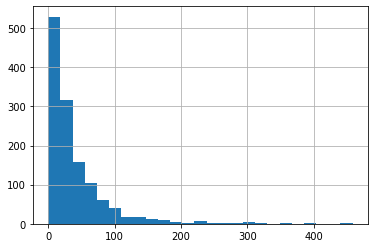

In [28]:
y_train["walk"].hist(bins=25)

In [30]:
y_train.describe()

bike          bus          car        truck          van  \
count  1292.000000  1292.000000  1292.000000  1292.000000  1292.000000   
mean     51.838235     2.476780   154.053406     2.606811    17.418731   
std      54.107355     6.722928   193.191042     7.952427    24.368467   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      17.000000     0.000000    29.000000     0.000000     3.000000   
50%      34.000000     0.000000    70.000000     0.000000     8.000000   
75%      66.000000     1.000000   202.500000     2.000000    21.000000   
max     438.000000    74.000000  1380.000000   130.000000   190.000000   

              walk  
count  1292.000000  
mean     40.181889  
std      50.116644  
min       0.000000  
25%      11.000000  
50%      24.000000  
75%      50.000000  
max     459.000000

# Model training

## LightGBM

In [20]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]
    
num_pred_minmax = num_pred_minmax_cols.copy()
num_pred_minmax.extend(num_pred_segm_cols)

#define pipeline
_pipeline_def = ("features", FeatureUnion([
    ('ohe', make_pipeline(
        Columns(names=one_hot_cols),
        OneHotEncoder(sparse=False, drop="first", categories=one_hot_categories, handle_unknown="error"))),
    ('mima', make_pipeline(
        Columns(names=num_pred_minmax),
        MinMaxScaler())),
    ('keep', make_pipeline(Columns(names=num_pred_remain_cols)))
]))

pipe_lgbm = Pipeline(
    [
        _pipeline_def,
        ('est', lightgbm.LGBMRegressor(random_state=42))
    ]
)

# set parameters to optimize
params = {
    'est__num_leaves': [7, 14, 21, 28, 31, 50],
    'est__learning_rate': [0.1, 0.03, 0.003],
    'est__max_depth': [-1, 3, 5],
    'est__n_estimators': [50, 100, 200, 500],
}

grid_lgbm = GridSearchCV(pipe_lgbm, params, scoring="neg_mean_absolute_error", cv=10, verbose=10)
grid_lgbm.fit(X_train, y_train['walk'])

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 1/10; 1/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7
[CV 1/10; 1/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7;, score=-22.538 total time=   0.2s
[CV 2/10; 1/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7
[CV 2/10; 1/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7;, score=-22.738 total time=   0.1s
[CV 3/10; 1/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7
[CV 3/10; 1/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7;, score=-22.606 total time=   0.1s
[CV 4/10; 1/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=7
[CV 4/10; 1/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num

[CV 4/10; 4/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-20.248 total time=   0.2s
[CV 5/10; 4/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 5/10; 4/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-18.330 total time=   0.2s
[CV 6/10; 4/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 6/10; 4/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-24.997 total time=   0.3s
[CV 7/10; 4/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 7/10; 4/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-21.955 total time=   0.2s
[CV 8/10; 4/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 8/10; 4/

[CV 8/10; 7/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-19.932 total time=   0.2s
[CV 9/10; 7/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7
[CV 9/10; 7/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-15.952 total time=   0.1s
[CV 10/10; 7/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7
[CV 10/10; 7/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-19.655 total time=   0.1s
[CV 1/10; 8/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=14
[CV 1/10; 8/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=14;, score=-23.709 total time=   0.2s
[CV 2/10; 8/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=14
[CV 2/1

[CV 1/10; 11/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31;, score=-23.455 total time=   0.3s
[CV 2/10; 11/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31
[CV 2/10; 11/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31;, score=-22.624 total time=   0.3s
[CV 3/10; 11/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31
[CV 3/10; 11/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31;, score=-23.256 total time=   0.3s
[CV 4/10; 11/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31
[CV 4/10; 11/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves=31;, score=-20.555 total time=   0.4s
[CV 5/10; 11/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=100, est__num_leaves

[CV 4/10; 14/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14;, score=-19.982 total time=   0.3s
[CV 5/10; 14/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14
[CV 5/10; 14/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14;, score=-19.374 total time=   0.3s
[CV 6/10; 14/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14
[CV 6/10; 14/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14;, score=-25.117 total time=   0.3s
[CV 7/10; 14/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14
[CV 7/10; 14/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14;, score=-23.324 total time=   0.3s
[CV 8/10; 14/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves

[CV 7/10; 17/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-23.049 total time=   0.7s
[CV 8/10; 17/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31
[CV 8/10; 17/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-19.918 total time=   0.8s
[CV 9/10; 17/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31
[CV 9/10; 17/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-17.953 total time=   1.1s
[CV 10/10; 17/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31
[CV 10/10; 17/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-19.240 total time=   1.0s
[CV 1/10; 18/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=200, est__num_leav

[CV 10/10; 20/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14;, score=-19.420 total time=   0.8s
[CV 1/10; 21/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=21
[CV 1/10; 21/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=21;, score=-24.601 total time=   1.4s
[CV 2/10; 21/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=21
[CV 2/10; 21/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=21;, score=-22.472 total time=   1.2s
[CV 3/10; 21/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=21
[CV 3/10; 21/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=21;, score=-24.252 total time=   1.6s
[CV 4/10; 21/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leave

[CV 3/10; 24/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50;, score=-24.219 total time=   2.5s
[CV 4/10; 24/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50
[CV 4/10; 24/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50;, score=-21.243 total time=   2.7s
[CV 5/10; 24/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50
[CV 5/10; 24/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50;, score=-19.782 total time=   2.7s
[CV 6/10; 24/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50
[CV 6/10; 24/216] END est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves=50;, score=-24.390 total time=   2.3s
[CV 7/10; 24/216] START est__learning_rate=0.1, est__max_depth=-1, est__n_estimators=500, est__num_leaves

[CV 8/10; 27/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=21;, score=-19.761 total time=   0.2s
[CV 9/10; 27/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=21
[CV 9/10; 27/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=21;, score=-15.348 total time=   0.2s
[CV 10/10; 27/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=21
[CV 10/10; 27/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=21;, score=-19.575 total time=   0.1s
[CV 1/10; 28/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=28
[CV 1/10; 28/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=28;, score=-22.910 total time=   0.1s
[CV 2/10; 28/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=50, est__num_leaves=28
[CV 2/10; 

[CV 3/10; 31/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7;, score=-22.029 total time=   0.1s
[CV 4/10; 31/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7
[CV 4/10; 31/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7;, score=-20.111 total time=   0.1s
[CV 5/10; 31/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7
[CV 5/10; 31/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7;, score=-18.971 total time=   0.1s
[CV 6/10; 31/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7
[CV 6/10; 31/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7;, score=-25.676 total time=   0.1s
[CV 7/10; 31/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=7
[CV 7/10; 31

[CV 6/10; 34/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28;, score=-25.850 total time=   0.1s
[CV 7/10; 34/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28
[CV 7/10; 34/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28;, score=-22.089 total time=   0.1s
[CV 8/10; 34/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28
[CV 8/10; 34/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28;, score=-19.937 total time=   0.1s
[CV 9/10; 34/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28
[CV 9/10; 34/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28;, score=-15.316 total time=   0.1s
[CV 10/10; 34/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=100, est__num_leaves=28
[CV

[CV 10/10; 37/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=7;, score=-20.321 total time=   0.2s
[CV 1/10; 38/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14
[CV 1/10; 38/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14;, score=-23.366 total time=   0.2s
[CV 2/10; 38/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14
[CV 2/10; 38/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14;, score=-21.676 total time=   0.2s
[CV 3/10; 38/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14
[CV 3/10; 38/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14;, score=-23.081 total time=   0.2s
[CV 4/10; 38/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=14
[CV 

[CV 3/10; 41/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31;, score=-23.081 total time=   0.2s
[CV 4/10; 41/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31
[CV 4/10; 41/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31;, score=-20.293 total time=   0.2s
[CV 5/10; 41/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31
[CV 5/10; 41/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31;, score=-19.577 total time=   0.2s
[CV 6/10; 41/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31
[CV 6/10; 41/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31;, score=-26.389 total time=   0.2s
[CV 7/10; 41/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=200, est__num_leaves=31
[CV 

[CV 6/10; 44/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14;, score=-26.395 total time=   0.3s
[CV 7/10; 44/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14
[CV 7/10; 44/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14;, score=-23.964 total time=   0.3s
[CV 8/10; 44/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14
[CV 8/10; 44/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14;, score=-20.961 total time=   0.3s
[CV 9/10; 44/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14
[CV 9/10; 44/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14;, score=-17.109 total time=   0.3s
[CV 10/10; 44/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=14
[CV

[CV 9/10; 47/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=31;, score=-17.109 total time=   0.4s
[CV 10/10; 47/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=31
[CV 10/10; 47/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=31;, score=-21.645 total time=   0.4s
[CV 1/10; 48/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=50
[CV 1/10; 48/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=50;, score=-24.394 total time=   0.4s
[CV 2/10; 48/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=50
[CV 2/10; 48/216] END est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=50;, score=-22.310 total time=   0.4s
[CV 3/10; 48/216] START est__learning_rate=0.1, est__max_depth=3, est__n_estimators=500, est__num_leaves=50
[C

[CV 3/10; 51/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21;, score=-22.277 total time=   0.2s
[CV 4/10; 51/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21
[CV 4/10; 51/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21;, score=-19.597 total time=   0.2s
[CV 5/10; 51/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21
[CV 5/10; 51/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21;, score=-17.902 total time=   0.2s
[CV 6/10; 51/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21
[CV 6/10; 51/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21;, score=-24.586 total time=   0.2s
[CV 7/10; 51/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=21
[CV 7/10; 51

[CV 7/10; 54/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50;, score=-21.626 total time=   0.1s
[CV 8/10; 54/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50
[CV 8/10; 54/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50;, score=-19.141 total time=   0.1s
[CV 9/10; 54/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50
[CV 9/10; 54/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50;, score=-15.720 total time=   0.1s
[CV 10/10; 54/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50
[CV 10/10; 54/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=50, est__num_leaves=50;, score=-18.429 total time=   0.1s
[CV 1/10; 55/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=7
[CV 1/10; 

[CV 10/10; 57/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=21;, score=-18.699 total time=   0.2s
[CV 1/10; 58/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28
[CV 1/10; 58/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28;, score=-23.275 total time=   0.2s
[CV 2/10; 58/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28
[CV 2/10; 58/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28;, score=-21.791 total time=   0.2s
[CV 3/10; 58/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28
[CV 3/10; 58/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28;, score=-22.509 total time=   0.2s
[CV 4/10; 58/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=100, est__num_leaves=28
[CV

[CV 3/10; 61/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7;, score=-22.784 total time=   0.4s
[CV 4/10; 61/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7
[CV 4/10; 61/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7;, score=-19.938 total time=   0.6s
[CV 5/10; 61/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7
[CV 5/10; 61/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7;, score=-19.395 total time=   0.3s
[CV 6/10; 61/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7
[CV 6/10; 61/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7;, score=-25.770 total time=   0.3s
[CV 7/10; 61/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=7
[CV 7/10; 61

[CV 6/10; 64/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28;, score=-24.750 total time=   0.6s
[CV 7/10; 64/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28
[CV 7/10; 64/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28;, score=-23.475 total time=   0.3s
[CV 8/10; 64/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28
[CV 8/10; 64/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28;, score=-19.507 total time=   0.3s
[CV 9/10; 64/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28
[CV 9/10; 64/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28;, score=-16.399 total time=   0.4s
[CV 10/10; 64/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=200, est__num_leaves=28
[CV

[CV 9/10; 67/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=7;, score=-16.082 total time=   0.5s
[CV 10/10; 67/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=7
[CV 10/10; 67/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=7;, score=-20.726 total time=   0.5s
[CV 1/10; 68/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=14
[CV 1/10; 68/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=14;, score=-25.205 total time=   1.0s
[CV 2/10; 68/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=14
[CV 2/10; 68/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=14;, score=-21.062 total time=   0.6s
[CV 3/10; 68/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=14
[CV 3

[CV 2/10; 71/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31;, score=-22.081 total time=   0.7s
[CV 3/10; 71/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31
[CV 3/10; 71/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31;, score=-23.290 total time=   0.5s
[CV 4/10; 71/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31
[CV 4/10; 71/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31;, score=-19.517 total time=   0.6s
[CV 5/10; 71/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31
[CV 5/10; 71/216] END est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31;, score=-20.496 total time=   0.6s
[CV 6/10; 71/216] START est__learning_rate=0.1, est__max_depth=5, est__n_estimators=500, est__num_leaves=31
[CV 

[CV 6/10; 74/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14;, score=-26.415 total time=   0.1s
[CV 7/10; 74/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14
[CV 7/10; 74/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14;, score=-22.060 total time=   0.1s
[CV 8/10; 74/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14
[CV 8/10; 74/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14;, score=-20.270 total time=   0.1s
[CV 9/10; 74/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14
[CV 9/10; 74/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=14;, score=-16.730 total time=   0.1s
[CV 10/10; 74/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leave

[CV 10/10; 77/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=31;, score=-19.056 total time=   0.2s
[CV 1/10; 78/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=50
[CV 1/10; 78/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=50;, score=-23.582 total time=   0.3s
[CV 2/10; 78/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=50
[CV 2/10; 78/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=50;, score=-24.645 total time=   0.2s
[CV 3/10; 78/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=50
[CV 3/10; 78/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leaves=50;, score=-22.583 total time=   0.2s
[CV 4/10; 78/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=50, est__num_leave

[CV 3/10; 81/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21;, score=-22.454 total time=   0.5s
[CV 4/10; 81/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21
[CV 4/10; 81/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21;, score=-19.622 total time=   0.3s
[CV 5/10; 81/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21
[CV 5/10; 81/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21;, score=-18.380 total time=   0.3s
[CV 6/10; 81/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21
[CV 6/10; 81/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=21;, score=-25.320 total time=   0.5s
[CV 7/10; 81/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__nu

[CV 6/10; 84/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50;, score=-25.288 total time=   0.5s
[CV 7/10; 84/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50
[CV 7/10; 84/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50;, score=-21.307 total time=   0.6s
[CV 8/10; 84/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50
[CV 8/10; 84/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50;, score=-19.103 total time=   0.6s
[CV 9/10; 84/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50
[CV 9/10; 84/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__num_leaves=50;, score=-15.151 total time=   0.5s
[CV 10/10; 84/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=100, est__n

[CV 9/10; 87/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=21;, score=-16.008 total time=   0.5s
[CV 10/10; 87/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=21
[CV 10/10; 87/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=21;, score=-18.641 total time=   0.5s
[CV 1/10; 88/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=28
[CV 1/10; 88/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=28;, score=-22.544 total time=   0.7s
[CV 2/10; 88/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=28
[CV 2/10; 88/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__num_leaves=28;, score=-22.711 total time=   0.8s
[CV 3/10; 88/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=200, est__

[CV 2/10; 91/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7;, score=-21.737 total time=   0.6s
[CV 3/10; 91/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7
[CV 3/10; 91/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7;, score=-22.093 total time=   0.7s
[CV 4/10; 91/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7
[CV 4/10; 91/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7;, score=-20.105 total time=   0.4s
[CV 5/10; 91/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7
[CV 5/10; 91/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=7;, score=-19.849 total time=   0.5s
[CV 6/10; 91/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leave

[CV 5/10; 94/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28;, score=-18.185 total time=   1.7s
[CV 6/10; 94/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28
[CV 6/10; 94/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28;, score=-24.023 total time=   1.6s
[CV 7/10; 94/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28
[CV 7/10; 94/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28;, score=-22.784 total time=   1.5s
[CV 8/10; 94/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28
[CV 8/10; 94/216] END est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__num_leaves=28;, score=-19.654 total time=   1.4s
[CV 9/10; 94/216] START est__learning_rate=0.03, est__max_depth=-1, est__n_estimators=500, est__nu

[CV 9/10; 97/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=7;, score=-16.726 total time=   0.1s
[CV 10/10; 97/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=7
[CV 10/10; 97/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=7;, score=-20.042 total time=   0.1s
[CV 1/10; 98/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=14
[CV 1/10; 98/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=14;, score=-23.702 total time=   0.1s
[CV 2/10; 98/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=14
[CV 2/10; 98/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=14;, score=-25.131 total time=   0.1s
[CV 3/10; 98/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=14
[CV 3

[CV 3/10; 101/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31;, score=-23.392 total time=   0.1s
[CV 4/10; 101/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31
[CV 4/10; 101/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31;, score=-20.176 total time=   0.1s
[CV 5/10; 101/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31
[CV 5/10; 101/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31;, score=-19.750 total time=   0.1s
[CV 6/10; 101/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31
[CV 6/10; 101/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves=31;, score=-26.869 total time=   0.1s
[CV 7/10; 101/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=50, est__num_leaves

[CV 7/10; 104/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14;, score=-21.798 total time=   0.1s
[CV 8/10; 104/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14
[CV 8/10; 104/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14;, score=-19.866 total time=   0.1s
[CV 9/10; 104/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14
[CV 9/10; 104/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14;, score=-15.320 total time=   0.1s
[CV 10/10; 104/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14
[CV 10/10; 104/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=14;, score=-19.012 total time=   0.1s
[CV 1/10; 105/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__

[CV 10/10; 107/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=31;, score=-19.012 total time=   0.1s
[CV 1/10; 108/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=50
[CV 1/10; 108/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=50;, score=-22.773 total time=   0.2s
[CV 2/10; 108/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=50
[CV 2/10; 108/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=50;, score=-23.600 total time=   0.2s
[CV 3/10; 108/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=50
[CV 3/10; 108/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__num_leaves=50;, score=-23.039 total time=   0.1s
[CV 4/10; 108/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=100, est__n

[CV 3/10; 111/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21;, score=-22.646 total time=   0.2s
[CV 4/10; 111/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21
[CV 4/10; 111/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21;, score=-20.202 total time=   0.2s
[CV 5/10; 111/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21
[CV 5/10; 111/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21;, score=-18.934 total time=   0.2s
[CV 6/10; 111/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21
[CV 6/10; 111/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=21;, score=-25.478 total time=   0.3s
[CV 7/10; 111/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__nu

[CV 7/10; 114/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50;, score=-21.674 total time=   0.2s
[CV 8/10; 114/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50
[CV 8/10; 114/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50;, score=-20.053 total time=   0.2s
[CV 9/10; 114/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50
[CV 9/10; 114/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50;, score=-15.138 total time=   0.2s
[CV 10/10; 114/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50
[CV 10/10; 114/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=200, est__num_leaves=50;, score=-19.415 total time=   0.2s
[CV 1/10; 115/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__

[CV 10/10; 117/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=21;, score=-19.604 total time=   0.3s
[CV 1/10; 118/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=28
[CV 1/10; 118/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=28;, score=-23.301 total time=   0.5s
[CV 2/10; 118/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=28
[CV 2/10; 118/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=28;, score=-21.234 total time=   0.3s
[CV 3/10; 118/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=28
[CV 3/10; 118/216] END est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__num_leaves=28;, score=-22.453 total time=   0.3s
[CV 4/10; 118/216] START est__learning_rate=0.03, est__max_depth=3, est__n_estimators=500, est__n

[CV 3/10; 121/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7;, score=-23.553 total time=   0.1s
[CV 4/10; 121/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7
[CV 4/10; 121/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7;, score=-20.857 total time=   0.1s
[CV 5/10; 121/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7
[CV 5/10; 121/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7;, score=-19.870 total time=   0.1s
[CV 6/10; 121/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7
[CV 6/10; 121/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7;, score=-27.139 total time=   0.1s
[CV 7/10; 121/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=7
[CV 

[CV 7/10; 124/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28;, score=-21.983 total time=   0.1s
[CV 8/10; 124/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28
[CV 8/10; 124/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28;, score=-19.571 total time=   0.1s
[CV 9/10; 124/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28
[CV 9/10; 124/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28;, score=-16.346 total time=   0.1s
[CV 10/10; 124/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28
[CV 10/10; 124/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leaves=28;, score=-18.608 total time=   0.1s
[CV 1/10; 125/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=50, est__num_leav

[CV 1/10; 128/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14;, score=-23.026 total time=   0.2s
[CV 2/10; 128/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14
[CV 2/10; 128/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14;, score=-23.025 total time=   0.2s
[CV 3/10; 128/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14
[CV 3/10; 128/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14;, score=-22.743 total time=   0.2s
[CV 4/10; 128/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14
[CV 4/10; 128/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=14;, score=-19.585 total time=   0.2s
[CV 5/10; 128/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__nu

[CV 5/10; 131/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31;, score=-18.037 total time=   0.2s
[CV 6/10; 131/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31
[CV 6/10; 131/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31;, score=-25.457 total time=   0.2s
[CV 7/10; 131/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31
[CV 7/10; 131/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31;, score=-21.458 total time=   0.2s
[CV 8/10; 131/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31
[CV 8/10; 131/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__num_leaves=31;, score=-19.196 total time=   0.2s
[CV 9/10; 131/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=100, est__nu

[CV 8/10; 134/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=14;, score=-19.167 total time=   0.4s
[CV 9/10; 134/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=14
[CV 9/10; 134/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=14;, score=-15.580 total time=   0.3s
[CV 10/10; 134/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=14
[CV 10/10; 134/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=14;, score=-18.514 total time=   0.3s
[CV 1/10; 135/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=21
[CV 1/10; 135/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=21;, score=-23.081 total time=   0.3s
[CV 2/10; 135/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__

[CV 1/10; 138/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50;, score=-23.081 total time=   0.3s
[CV 2/10; 138/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50
[CV 2/10; 138/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50;, score=-21.905 total time=   0.5s
[CV 3/10; 138/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50
[CV 3/10; 138/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50;, score=-22.530 total time=   0.6s
[CV 4/10; 138/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50
[CV 4/10; 138/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__num_leaves=50;, score=-19.855 total time=   0.4s
[CV 5/10; 138/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=200, est__nu

[CV 4/10; 141/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21;, score=-19.560 total time=   0.5s
[CV 5/10; 141/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21
[CV 5/10; 141/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21;, score=-19.657 total time=   0.7s
[CV 6/10; 141/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21
[CV 6/10; 141/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21;, score=-24.567 total time=   0.5s
[CV 7/10; 141/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21
[CV 7/10; 141/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=21;, score=-23.184 total time=   0.5s
[CV 8/10; 141/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__nu

[CV 7/10; 144/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50;, score=-23.184 total time=   0.7s
[CV 8/10; 144/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50
[CV 8/10; 144/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50;, score=-19.558 total time=   0.5s
[CV 9/10; 144/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50
[CV 9/10; 144/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50;, score=-15.856 total time=   0.5s
[CV 10/10; 144/216] START est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50
[CV 10/10; 144/216] END est__learning_rate=0.03, est__max_depth=5, est__n_estimators=500, est__num_leaves=50;, score=-18.980 total time=   0.5s
[CV 1/10; 145/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est_

[CV 1/10; 148/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-32.559 total time=   0.2s
[CV 2/10; 148/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 2/10; 148/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-33.053 total time=   0.4s
[CV 3/10; 148/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 3/10; 148/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-29.520 total time=   0.2s
[CV 4/10; 148/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28
[CV 4/10; 148/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50, est__num_leaves=28;, score=-27.087 total time=   0.2s
[CV 5/10; 148/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=50,

[CV 4/10; 151/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-25.559 total time=   0.1s
[CV 5/10; 151/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7
[CV 5/10; 151/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-25.638 total time=   0.1s
[CV 6/10; 151/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7
[CV 6/10; 151/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-32.472 total time=   0.1s
[CV 7/10; 151/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7
[CV 7/10; 151/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=7;, score=-29.098 total time=   0.1s
[CV 8/10; 151/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100

[CV 6/10; 154/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28;, score=-31.946 total time=   0.3s
[CV 7/10; 154/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28
[CV 7/10; 154/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28;, score=-28.466 total time=   0.3s
[CV 8/10; 154/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28
[CV 8/10; 154/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28;, score=-25.629 total time=   0.3s
[CV 9/10; 154/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28
[CV 9/10; 154/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=100, est__num_leaves=28;, score=-21.676 total time=   0.3s
[CV 10/10; 154/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estima

[CV 8/10; 157/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=7;, score=-23.622 total time=   0.3s
[CV 9/10; 157/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=7
[CV 9/10; 157/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=7;, score=-20.116 total time=   0.2s
[CV 10/10; 157/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=7
[CV 10/10; 157/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=7;, score=-23.150 total time=   0.2s
[CV 1/10; 158/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14
[CV 1/10; 158/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=14;, score=-27.568 total time=   0.3s
[CV 2/10; 158/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators

[CV 10/10; 160/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=28;, score=-22.431 total time=   0.7s
[CV 1/10; 161/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31
[CV 1/10; 161/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-27.448 total time=   0.6s
[CV 2/10; 161/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31
[CV 2/10; 161/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-28.350 total time=   0.8s
[CV 3/10; 161/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31
[CV 3/10; 161/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=200, est__num_leaves=31;, score=-24.727 total time=   0.8s
[CV 4/10; 161/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estima

[CV 2/10; 164/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14;, score=-25.220 total time=   0.7s
[CV 3/10; 164/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14
[CV 3/10; 164/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14;, score=-23.245 total time=   0.8s
[CV 4/10; 164/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14
[CV 4/10; 164/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14;, score=-19.967 total time=   0.8s
[CV 5/10; 164/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14
[CV 5/10; 164/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=14;, score=-19.306 total time=   0.8s
[CV 6/10; 164/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimat

[CV 4/10; 167/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31;, score=-20.009 total time=   1.7s
[CV 5/10; 167/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31
[CV 5/10; 167/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31;, score=-19.336 total time=   1.5s
[CV 6/10; 167/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31
[CV 6/10; 167/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31;, score=-26.211 total time=   1.5s
[CV 7/10; 167/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31
[CV 7/10; 167/216] END est__learning_rate=0.003, est__max_depth=-1, est__n_estimators=500, est__num_leaves=31;, score=-21.682 total time=   1.5s
[CV 8/10; 167/216] START est__learning_rate=0.003, est__max_depth=-1, est__n_estimat

[CV 8/10; 170/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=14;, score=-27.669 total time=   0.1s
[CV 9/10; 170/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=14
[CV 9/10; 170/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=14;, score=-23.985 total time=   0.1s
[CV 10/10; 170/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=14
[CV 10/10; 170/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=14;, score=-27.313 total time=   0.1s
[CV 1/10; 171/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=21
[CV 1/10; 171/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=21;, score=-32.808 total time=   0.1s
[CV 2/10; 171/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__

[CV 2/10; 174/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50;, score=-32.910 total time=   0.1s
[CV 3/10; 174/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50
[CV 3/10; 174/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50;, score=-29.691 total time=   0.1s
[CV 4/10; 174/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50
[CV 4/10; 174/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50;, score=-27.430 total time=   0.1s
[CV 5/10; 174/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50
[CV 5/10; 174/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__num_leaves=50;, score=-27.268 total time=   0.1s
[CV 6/10; 174/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=50, est__nu

[CV 6/10; 177/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21;, score=-32.178 total time=   0.1s
[CV 7/10; 177/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21
[CV 7/10; 177/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21;, score=-29.112 total time=   0.1s
[CV 8/10; 177/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21
[CV 8/10; 177/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21;, score=-25.931 total time=   0.1s
[CV 9/10; 177/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21
[CV 9/10; 177/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=21;, score=-22.106 total time=   0.1s
[CV 10/10; 177/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100

[CV 10/10; 180/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=100, est__num_leaves=50;, score=-25.585 total time=   0.1s
[CV 1/10; 181/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=7
[CV 1/10; 181/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=7;, score=-27.681 total time=   0.2s
[CV 2/10; 181/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=7
[CV 2/10; 181/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=7;, score=-28.593 total time=   0.2s
[CV 3/10; 181/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=7
[CV 3/10; 181/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=7;, score=-24.955 total time=   0.2s
[CV 4/10; 181/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est_

[CV 4/10; 184/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28;, score=-23.391 total time=   0.2s
[CV 5/10; 184/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28
[CV 5/10; 184/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28;, score=-22.968 total time=   0.2s
[CV 6/10; 184/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28
[CV 6/10; 184/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28;, score=-29.341 total time=   0.2s
[CV 7/10; 184/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28
[CV 7/10; 184/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200, est__num_leaves=28;, score=-26.106 total time=   0.2s
[CV 8/10; 184/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=200,

[CV 7/10; 187/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7;, score=-22.912 total time=   0.3s
[CV 8/10; 187/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7
[CV 8/10; 187/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7;, score=-20.578 total time=   0.3s
[CV 9/10; 187/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7
[CV 9/10; 187/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7;, score=-16.759 total time=   0.6s
[CV 10/10; 187/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7
[CV 10/10; 187/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=7;, score=-20.100 total time=   0.8s
[CV 1/10; 188/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est_

[CV 10/10; 190/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=28;, score=-19.975 total time=   0.3s
[CV 1/10; 191/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=31
[CV 1/10; 191/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=31;, score=-23.688 total time=   0.4s
[CV 2/10; 191/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=31
[CV 2/10; 191/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=31;, score=-25.123 total time=   0.3s
[CV 3/10; 191/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=31
[CV 3/10; 191/216] END est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500, est__num_leaves=31;, score=-23.295 total time=   0.3s
[CV 4/10; 191/216] START est__learning_rate=0.003, est__max_depth=3, est__n_estimators=500

[CV 3/10; 194/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14;, score=-29.465 total time=   0.1s
[CV 4/10; 194/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14
[CV 4/10; 194/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14;, score=-27.199 total time=   0.1s
[CV 5/10; 194/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14
[CV 5/10; 194/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14;, score=-27.099 total time=   0.1s
[CV 6/10; 194/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14
[CV 6/10; 194/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=14;, score=-34.279 total time=   0.1s
[CV 7/10; 194/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__nu

[CV 7/10; 197/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31;, score=-30.830 total time=   0.1s
[CV 8/10; 197/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31
[CV 8/10; 197/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31;, score=-27.563 total time=   0.1s
[CV 9/10; 197/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31
[CV 9/10; 197/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31;, score=-23.730 total time=   0.1s
[CV 10/10; 197/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31
[CV 10/10; 197/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__num_leaves=31;, score=-27.215 total time=   0.2s
[CV 1/10; 198/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=50, est__

[CV 10/10; 200/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=14;, score=-25.289 total time=   0.3s
[CV 1/10; 201/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=21
[CV 1/10; 201/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=21;, score=-30.537 total time=   0.3s
[CV 2/10; 201/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=21
[CV 2/10; 201/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=21;, score=-31.011 total time=   0.3s
[CV 3/10; 201/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=21
[CV 3/10; 201/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=21;, score=-27.311 total time=   0.3s
[CV 4/10; 201/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100

[CV 3/10; 204/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50;, score=-27.311 total time=   0.4s
[CV 4/10; 204/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50
[CV 4/10; 204/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50;, score=-25.295 total time=   0.4s
[CV 5/10; 204/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50
[CV 5/10; 204/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50;, score=-25.212 total time=   0.4s
[CV 6/10; 204/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50
[CV 6/10; 204/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100, est__num_leaves=50;, score=-31.989 total time=   0.4s
[CV 7/10; 204/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=100,

[CV 6/10; 207/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21;, score=-28.974 total time=   0.3s
[CV 7/10; 207/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21
[CV 7/10; 207/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21;, score=-25.485 total time=   0.4s
[CV 8/10; 207/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21
[CV 8/10; 207/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21;, score=-22.884 total time=   0.3s
[CV 9/10; 207/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21
[CV 9/10; 207/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=21;, score=-19.254 total time=   0.4s
[CV 10/10; 207/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200

[CV 9/10; 210/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=50;, score=-19.253 total time=   0.3s
[CV 10/10; 210/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=50
[CV 10/10; 210/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=200, est__num_leaves=50;, score=-22.274 total time=   0.4s
[CV 1/10; 211/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=7
[CV 1/10; 211/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=7;, score=-23.648 total time=   0.7s
[CV 2/10; 211/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=7
[CV 2/10; 211/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=7;, score=-26.148 total time=   0.4s
[CV 3/10; 211/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, e

[CV 2/10; 214/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28;, score=-24.696 total time=   0.6s
[CV 3/10; 214/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28
[CV 3/10; 214/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28;, score=-22.821 total time=   0.7s
[CV 4/10; 214/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28
[CV 4/10; 214/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28;, score=-20.057 total time=   0.7s
[CV 5/10; 214/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28
[CV 5/10; 214/216] END est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500, est__num_leaves=28;, score=-19.094 total time=   0.7s
[CV 6/10; 214/216] START est__learning_rate=0.003, est__max_depth=5, est__n_estimators=500,

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ohe',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['verh',
                                                                                                        'morf',
                                                                                                        'wegcat'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[[nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '1',
                                                                                                                    '2'],
                                                                                                                   [102,
                                                                                                                    103,
                                                                                                                    110,
                                  

### LightGBM fit results

Let's analyse the results of the model fit. 

In [22]:
grid_lgbm.best_params_

{'est__learning_rate': 0.1,
 'est__max_depth': 5,
 'est__n_estimators': 50,
 'est__num_leaves': 21}

In [21]:
#sorted(grid_lgbm.cv_results_.keys())

In [9]:
#print("best parameters:", grid.cv_results_["params"])
#print("best estimator:", grid.named_steps["est"].best_estimator_)

Model performance:
* MAE:  22.9356
* RMSE: 41.3602

In [23]:
print(f"MAE {mean_absolute_error(y_test['walk'],grid_lgbm.predict(X_test))}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test['walk'],grid_lgbm.predict(X_test)))}")

MAE 22.93547025629626
RMSE 41.36022037748904


### Error analysis

Let's plot the mean absolute error in a histogram:

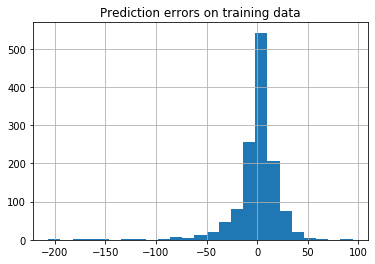

In [11]:
(grid_lgbm.predict(X_train) - y_train['walk']).hist(bins=25)

plt.title("Prediction errors on training data")
plt.show()

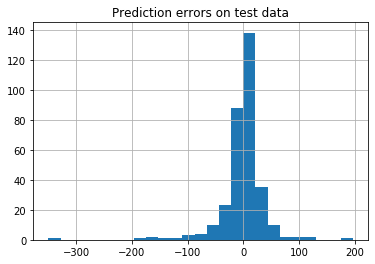

In [12]:
(grid_lgbm.predict(X_test) - y_test['walk']).hist(bins=25)
plt.title("Prediction errors on test data")
plt.show()

Let's look at the predictions for which the error was very large (> 150)

In [13]:
ERROR_ABS_THRESHOLD_VALUE = 150

X_test["LightGBM_abs_error_walk"] = grid.predict(X_test) - y_test['walk']
X_test["LightGBM_large_error_walk"] = abs(X_test["LightGBM_abs_error_walk"]) >= ERROR_ABS_THRESHOLD_VALUE

In [14]:
X_test[X_test["LightGBM_large_error_walk"]].sort_values(by="LightGBM_abs_error_walk", ascending=True)

verh  morf wegcat  is_natw  segm_wall  segm_building  segm_sky  segm_tree  \
109    1   103     L3      0.0   0.000000       0.000000  0.000000   0.000000   
602    1   103     L3      0.0   0.000000       0.482770  0.123713   0.007279   
694    1   103     L2      0.0   0.000264       0.114043  0.119587   0.307146   
590    1   103     L3      0.0   0.001346       0.139713  0.253246   0.120084   
352    1   103     L3      0.0   0.000504       0.526617  0.083670   0.007847   

     segm_road  segm_grass  ...  morf_110_2000  morf_111_2000  morf_112_2000  \
109   0.000000    0.000000  ...              0              0              0   
602   0.251050    0.000000  ...              0              1              0   
694   0.307816    0.003967  ...              0              0              0   
590   0.189863    0.018296  ...              1              0              0   
352   0.212477    0.000000  ...             10              0              0   

     morf_113_2000  morf_114_2000  morf_116_2000  morf_-8_2000  morf_125_2000  \
109              0             22              9             0              1   
602             19             20              7             0              0   
694              0              4              4             0              0   
590              7             15              2             0              0   
352             40             10              4             0              0   

     LightGBM_abs_error_walk  LightGBM_large_error_walk  
109              -349.810599                       True  
602              -192.833478                       True  
694              -169.495383                       True  
590              -167.566544                       True  
352               196.710120                       True  

[5 rows x 337 columns]

# TabNet regressor

In [ ]:
#!/opt/anaconda3/envs/straatvinken/bin/pip install pactools

In [16]:

pipe_tn = Pipeline(
    [
        _pipeline_def,
        ('est', TabNetRegressor(seed=42, verbose=0, patience=15))
    ]
)

# set parameters to optimize
params = {
    'est__n_a': [8], # max 64
    'est__n_d': [8], # preferably same as n_a
    'est__n_steps': [2, 3, 6],
    'est__gamma': [1.3], #1, 1.3, 1.7]
    'est__n_independent': [2, 4],
    'est__n_shared': [2, 4]
}


grid_tn = GridSearchCV(pipe_tn, params, scoring="neg_mean_absolute_error", cv=10, verbose=3)
grid_tn.fit(X_train, np.array(y_train['walk']).reshape(-1,1))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
No early stopping will be performed, last training weights will be used.
[CV 1/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=2, est__n_steps=2;, score=-28.070 total time=  15.7s
No early stopping will be performed, last training weights will be used.
[CV 2/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=2, est__n_steps=2;, score=-29.702 total time=  15.4s
No early stopping will be performed, last training weights will be used.
[CV 3/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=2, est__n_steps=2;, score=-25.220 total time=  15.2s
No early stopping will be performed, last training weights will be used.
[CV 4/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=2, est__n_steps=2;, score=-20.186 total time=  15.3s
No early stopping will be performed, last training weights will be used.


[CV 9/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=4, est__n_steps=2;, score=-17.525 total time=  16.6s
No early stopping will be performed, last training weights will be used.
[CV 10/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=4, est__n_steps=2;, score=-22.178 total time=  16.2s
No early stopping will be performed, last training weights will be used.
[CV 1/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=4, est__n_steps=3;, score=-26.859 total time=  22.5s
No early stopping will be performed, last training weights will be used.
[CV 2/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=4, est__n_steps=3;, score=-27.397 total time=  22.6s
No early stopping will be performed, last training weights will be used.
[CV 3/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=2, est__n_shared=4, est__n_steps=3;, score=-23.605 total time=

[CV 7/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=2, est__n_steps=3;, score=-24.330 total time=  22.8s
No early stopping will be performed, last training weights will be used.
[CV 8/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=2, est__n_steps=3;, score=-21.609 total time=  22.6s
No early stopping will be performed, last training weights will be used.
[CV 9/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=2, est__n_steps=3;, score=-16.417 total time=  23.0s
No early stopping will be performed, last training weights will be used.
[CV 10/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=2, est__n_steps=3;, score=-22.424 total time=  22.4s
No early stopping will be performed, last training weights will be used.
[CV 1/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=2, est__n_steps=6;, score=-25.183 total time=

[CV 5/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=4, est__n_steps=6;, score=-21.918 total time=  46.2s
No early stopping will be performed, last training weights will be used.
[CV 6/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=4, est__n_steps=6;, score=-28.935 total time=  46.6s
No early stopping will be performed, last training weights will be used.
[CV 7/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=4, est__n_steps=6;, score=-25.835 total time=  46.4s
No early stopping will be performed, last training weights will be used.
[CV 8/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=4, est__n_steps=6;, score=-24.209 total time=  45.9s
No early stopping will be performed, last training weights will be used.
[CV 9/10] END est__gamma=1.3, est__n_a=8, est__n_d=8, est__n_independent=4, est__n_shared=4, est__n_steps=6;, score=-17.086 total time= 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ohe',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['verh',
                                                                                                        'morf',
                                                                                                        'wegcat'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[[nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '1',
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '2'],
                                                                                                                   [102,
                                                                                                                    103,
                                                                                                                    110,
                                  

### Results

Model performance:
* MAE 27.6354
* RMSE 51.2187

In [17]:
print(f"MAE {mean_absolute_error(y_test['walk'], grid_tn.predict(X_test))}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test['walk'], grid_tn.predict(X_test)))}")

MAE 27.63541720237261
RMSE 51.218653372437586


In [24]:
grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ohe',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['verh',
                                                                                                        'morf',
                                                                                                        'wegcat'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[[nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '1',
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '2'],
                                                                                                                   [102,
                                                                                                                    103,
                                                                                                                    110,
                                  

### Feature importances

In [30]:
grid_tn.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['verh',
                                                                                 'morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[[nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             '1',
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             '2'],
                                                                                            [102,
                                                                                             103,
                                                                                             110,
                                                                                             111,
                                                                                             113,
                                                                                             114,
                                                                                             116],
                                                                                            ['S3',
                                                                                             'S1',
                                                                                             'L3',
                                                                                             'S2',
                                               

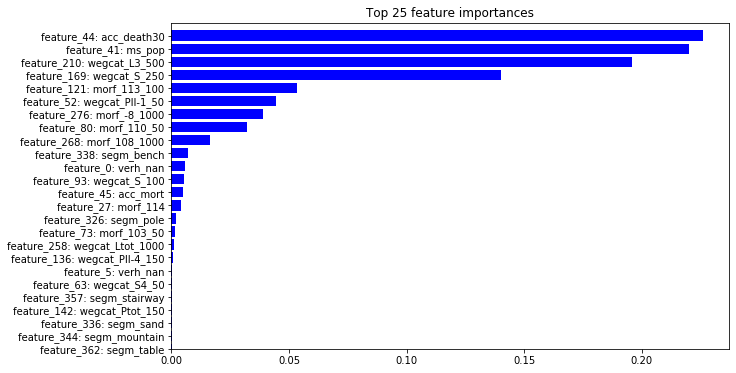

In [39]:
feat_importances = grid_tn.best_estimator_.named_steps["est"].feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Top 25 feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
features = [f'feature_{i}: {cols[i]}' for i in range(0, len(cols))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
# all features
# plt.ylim([-1, len(feat_importances)])
# Top 25 features
plt.ylim([len(feat_importances)-25, len(feat_importances)])
plt.show();

### Local explainability and masks

0
1


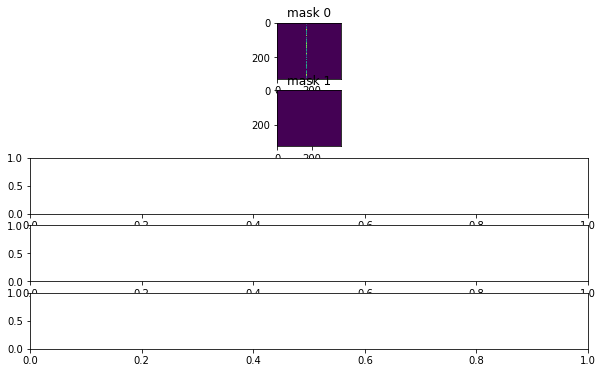

In [81]:
# TODO: fix this
pipe_expl = Pipeline([_pipeline_def])
pipe_expl.fit(X_train)
X_expl = pipe_expl.transform(X_test)
X_expl

explain_matrix, masks = grid.best_estimator_.named_steps["est"].explain(X_expl)

fig, ax = plt.subplots(5,1, figsize=(10,6))

for i in range(2):
    print(i)
    ax[i].imshow(masks[i])#[:50])
    ax[i].set_title(f"mask {i}")

# catboost regressor

In [6]:
#CatBoostClassifier()
pipe_cb = Pipeline(
    [
        _pipeline_def,
        ('est', CatBoostRegressor(loss_function="MAE", random_state=42))
    ]
)

# set parameters to optimize
params = {
    'est__depth': [6, 8, 10],
    'est__learning_rate': [0.01, 0.03],
}


grid_cb = GridSearchCV(pipe_cb, params, scoring="neg_mean_absolute_error", cv=10, verbose=3)
grid_cb.fit(X_train, y_train['walk'])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0:	learn: 28.0377529	total: 8.93ms	remaining: 8.92s
1:	learn: 27.9117546	total: 12.6ms	remaining: 6.31s
2:	learn: 27.7995491	total: 16.3ms	remaining: 5.4s
3:	learn: 27.6855021	total: 20ms	remaining: 4.99s
4:	learn: 27.5685744	total: 23.8ms	remaining: 4.73s
5:	learn: 27.4479179	total: 27.2ms	remaining: 4.5s
6:	learn: 27.3518873	total: 30.7ms	remaining: 4.35s
7:	learn: 27.2399943	total: 34.3ms	remaining: 4.25s
8:	learn: 27.1362868	total: 37.8ms	remaining: 4.16s
9:	learn: 27.0317662	total: 41.3ms	remaining: 4.08s
10:	learn: 26.9219475	total: 44.8ms	remaining: 4.03s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

11:	learn: 26.8211092	total: 48.6ms	remaining: 4s
12:	learn: 26.7195350	total: 53.2ms	remaining: 4.04s
13:	learn: 26.6321196	total: 57.6ms	remaining: 4.06s
14:	learn: 26.5296859	total: 61.8ms	remaining: 4.06s
15:	learn: 26.4322434	total: 65.7ms	remaining: 4.04s
16:	learn: 26.3359934	total: 69.6ms	remaining: 4.02s
17:	learn: 26.2431035	total: 73.7ms	remaining: 4.02s
18:	learn: 26.1613659	total: 77.4ms	remaining: 4s
19:	learn: 26.0736913	total: 81.6ms	remaining: 4s
20:	learn: 25.9848743	total: 85.2ms	remaining: 3.97s
21:	learn: 25.8930501	total: 88.9ms	remaining: 3.95s
22:	learn: 25.8195175	total: 92.5ms	remaining: 3.93s
23:	learn: 25.7355136	total: 96.2ms	remaining: 3.91s
24:	learn: 25.6536309	total: 99.9ms	remaining: 3.9s
25:	learn: 25.5645051	total: 103ms	remaining: 3.87s
26:	learn: 25.4893374	total: 108ms	remaining: 3.88s
27:	learn: 25.4018454	total: 111ms	remaining: 3.86s
28:	learn: 25.3170526	total: 115ms	remaining: 3.84s
29:	learn: 25.2266825	total: 118ms	remaining: 3.83s
30:	lear

215:	learn: 18.8669049	total: 821ms	remaining: 2.98s
216:	learn: 18.8525645	total: 826ms	remaining: 2.98s
217:	learn: 18.8429875	total: 830ms	remaining: 2.98s
218:	learn: 18.8279309	total: 834ms	remaining: 2.98s
219:	learn: 18.8171203	total: 839ms	remaining: 2.97s
220:	learn: 18.8069674	total: 842ms	remaining: 2.97s
221:	learn: 18.7913922	total: 846ms	remaining: 2.96s
222:	learn: 18.7844096	total: 850ms	remaining: 2.96s
223:	learn: 18.7669239	total: 854ms	remaining: 2.96s
224:	learn: 18.7561563	total: 858ms	remaining: 2.95s
225:	learn: 18.7398142	total: 862ms	remaining: 2.95s
226:	learn: 18.7225747	total: 865ms	remaining: 2.94s
227:	learn: 18.7122396	total: 869ms	remaining: 2.94s
228:	learn: 18.7009602	total: 873ms	remaining: 2.94s
229:	learn: 18.6819563	total: 876ms	remaining: 2.93s
230:	learn: 18.6743765	total: 880ms	remaining: 2.93s
231:	learn: 18.6630981	total: 883ms	remaining: 2.92s
232:	learn: 18.6439570	total: 887ms	remaining: 2.92s
233:	learn: 18.6376870	total: 890ms	remaining:

415:	learn: 16.6980551	total: 1.59s	remaining: 2.23s
416:	learn: 16.6884148	total: 1.59s	remaining: 2.23s
417:	learn: 16.6802491	total: 1.6s	remaining: 2.22s
418:	learn: 16.6725253	total: 1.6s	remaining: 2.22s
419:	learn: 16.6593272	total: 1.61s	remaining: 2.22s
420:	learn: 16.6515601	total: 1.61s	remaining: 2.21s
421:	learn: 16.6451435	total: 1.61s	remaining: 2.21s
422:	learn: 16.6386432	total: 1.62s	remaining: 2.21s
423:	learn: 16.6313526	total: 1.62s	remaining: 2.2s
424:	learn: 16.6250730	total: 1.63s	remaining: 2.2s
425:	learn: 16.6156515	total: 1.63s	remaining: 2.2s
426:	learn: 16.6076232	total: 1.64s	remaining: 2.19s
427:	learn: 16.6028095	total: 1.64s	remaining: 2.19s
428:	learn: 16.5920354	total: 1.65s	remaining: 2.19s
429:	learn: 16.5878650	total: 1.65s	remaining: 2.19s
430:	learn: 16.5782999	total: 1.66s	remaining: 2.19s
431:	learn: 16.5696651	total: 1.66s	remaining: 2.19s
432:	learn: 16.5634946	total: 1.67s	remaining: 2.19s
433:	learn: 16.5588208	total: 1.67s	remaining: 2.18

581:	learn: 15.5483525	total: 2.36s	remaining: 1.7s
582:	learn: 15.5426866	total: 2.37s	remaining: 1.69s
583:	learn: 15.5362489	total: 2.37s	remaining: 1.69s
584:	learn: 15.5303757	total: 2.37s	remaining: 1.68s
585:	learn: 15.5282305	total: 2.38s	remaining: 1.68s
586:	learn: 15.5240454	total: 2.38s	remaining: 1.68s
587:	learn: 15.5141059	total: 2.39s	remaining: 1.67s
588:	learn: 15.5094239	total: 2.39s	remaining: 1.67s
589:	learn: 15.5041435	total: 2.4s	remaining: 1.67s
590:	learn: 15.4994747	total: 2.4s	remaining: 1.66s
591:	learn: 15.4892673	total: 2.41s	remaining: 1.66s
592:	learn: 15.4802345	total: 2.41s	remaining: 1.66s
593:	learn: 15.4747257	total: 2.42s	remaining: 1.65s
594:	learn: 15.4686029	total: 2.42s	remaining: 1.65s
595:	learn: 15.4648114	total: 2.42s	remaining: 1.64s
596:	learn: 15.4552234	total: 2.43s	remaining: 1.64s
597:	learn: 15.4447120	total: 2.44s	remaining: 1.64s
598:	learn: 15.4378336	total: 2.44s	remaining: 1.63s
599:	learn: 15.4256794	total: 2.44s	remaining: 1.

766:	learn: 14.3934043	total: 3.13s	remaining: 951ms
767:	learn: 14.3895283	total: 3.13s	remaining: 947ms
768:	learn: 14.3822154	total: 3.14s	remaining: 943ms
769:	learn: 14.3710961	total: 3.14s	remaining: 939ms
770:	learn: 14.3680121	total: 3.15s	remaining: 935ms
771:	learn: 14.3616025	total: 3.15s	remaining: 931ms
772:	learn: 14.3567686	total: 3.15s	remaining: 927ms
773:	learn: 14.3536073	total: 3.16s	remaining: 923ms
774:	learn: 14.3437805	total: 3.16s	remaining: 918ms
775:	learn: 14.3367912	total: 3.17s	remaining: 914ms
776:	learn: 14.3334570	total: 3.17s	remaining: 910ms
777:	learn: 14.3245181	total: 3.17s	remaining: 906ms
778:	learn: 14.3195869	total: 3.18s	remaining: 903ms
779:	learn: 14.3151227	total: 3.19s	remaining: 899ms
780:	learn: 14.3070916	total: 3.19s	remaining: 895ms
781:	learn: 14.3015800	total: 3.19s	remaining: 890ms
782:	learn: 14.2930915	total: 3.2s	remaining: 886ms
783:	learn: 14.2800259	total: 3.2s	remaining: 882ms
784:	learn: 14.2764246	total: 3.2s	remaining: 87

952:	learn: 13.3023855	total: 3.86s	remaining: 190ms
953:	learn: 13.2978890	total: 3.87s	remaining: 186ms
954:	learn: 13.2915741	total: 3.87s	remaining: 182ms
955:	learn: 13.2903498	total: 3.87s	remaining: 178ms
956:	learn: 13.2832530	total: 3.88s	remaining: 174ms
957:	learn: 13.2792271	total: 3.88s	remaining: 170ms
958:	learn: 13.2750084	total: 3.88s	remaining: 166ms
959:	learn: 13.2633542	total: 3.89s	remaining: 162ms
960:	learn: 13.2571397	total: 3.89s	remaining: 158ms
961:	learn: 13.2526474	total: 3.9s	remaining: 154ms
962:	learn: 13.2411185	total: 3.9s	remaining: 150ms
963:	learn: 13.2378435	total: 3.9s	remaining: 146ms
964:	learn: 13.2283985	total: 3.9s	remaining: 142ms
965:	learn: 13.2221602	total: 3.91s	remaining: 138ms
966:	learn: 13.2181630	total: 3.91s	remaining: 134ms
967:	learn: 13.2139613	total: 3.92s	remaining: 129ms
968:	learn: 13.2112353	total: 3.92s	remaining: 125ms
969:	learn: 13.2033638	total: 3.92s	remaining: 121ms
970:	learn: 13.2007210	total: 3.93s	remaining: 117

123:	learn: 20.4482224	total: 466ms	remaining: 3.29s
124:	learn: 20.4280803	total: 470ms	remaining: 3.29s
125:	learn: 20.4044038	total: 475ms	remaining: 3.29s
126:	learn: 20.3644462	total: 479ms	remaining: 3.29s
127:	learn: 20.3407387	total: 484ms	remaining: 3.29s
128:	learn: 20.3163338	total: 487ms	remaining: 3.29s
129:	learn: 20.2793169	total: 491ms	remaining: 3.29s
130:	learn: 20.2530010	total: 495ms	remaining: 3.28s
131:	learn: 20.2287926	total: 499ms	remaining: 3.28s
132:	learn: 20.2087940	total: 502ms	remaining: 3.27s
133:	learn: 20.1825129	total: 506ms	remaining: 3.27s
134:	learn: 20.1525272	total: 510ms	remaining: 3.27s
135:	learn: 20.1394280	total: 513ms	remaining: 3.26s
136:	learn: 20.1128419	total: 517ms	remaining: 3.26s
137:	learn: 20.0796299	total: 521ms	remaining: 3.25s
138:	learn: 20.0508752	total: 525ms	remaining: 3.25s
139:	learn: 20.0242838	total: 529ms	remaining: 3.25s
140:	learn: 19.9983884	total: 532ms	remaining: 3.24s
141:	learn: 19.9704082	total: 536ms	remaining:

306:	learn: 17.5597150	total: 1.24s	remaining: 2.8s
307:	learn: 17.5535221	total: 1.24s	remaining: 2.79s
308:	learn: 17.5440078	total: 1.25s	remaining: 2.79s
309:	learn: 17.5352117	total: 1.25s	remaining: 2.79s
310:	learn: 17.5164086	total: 1.26s	remaining: 2.79s
311:	learn: 17.5128822	total: 1.26s	remaining: 2.79s
312:	learn: 17.4964220	total: 1.27s	remaining: 2.78s
313:	learn: 17.4880092	total: 1.27s	remaining: 2.78s
314:	learn: 17.4734175	total: 1.28s	remaining: 2.77s
315:	learn: 17.4633405	total: 1.28s	remaining: 2.77s
316:	learn: 17.4453334	total: 1.28s	remaining: 2.77s
317:	learn: 17.4354569	total: 1.29s	remaining: 2.76s
318:	learn: 17.4269427	total: 1.29s	remaining: 2.76s
319:	learn: 17.4165827	total: 1.3s	remaining: 2.76s
320:	learn: 17.4094681	total: 1.3s	remaining: 2.75s
321:	learn: 17.4029195	total: 1.3s	remaining: 2.75s
322:	learn: 17.3978519	total: 1.31s	remaining: 2.74s
323:	learn: 17.3904880	total: 1.31s	remaining: 2.74s
324:	learn: 17.3755385	total: 1.32s	remaining: 2.7

471:	learn: 16.2323520	total: 2.01s	remaining: 2.25s
472:	learn: 16.2258862	total: 2.02s	remaining: 2.25s
473:	learn: 16.2215511	total: 2.02s	remaining: 2.24s
474:	learn: 16.2149306	total: 2.02s	remaining: 2.24s
475:	learn: 16.2051151	total: 2.03s	remaining: 2.24s
476:	learn: 16.1962613	total: 2.04s	remaining: 2.23s
477:	learn: 16.1884389	total: 2.04s	remaining: 2.23s
478:	learn: 16.1807934	total: 2.04s	remaining: 2.23s
479:	learn: 16.1731927	total: 2.05s	remaining: 2.22s
480:	learn: 16.1670449	total: 2.06s	remaining: 2.22s
481:	learn: 16.1601253	total: 2.06s	remaining: 2.21s
482:	learn: 16.1549134	total: 2.07s	remaining: 2.21s
483:	learn: 16.1484899	total: 2.07s	remaining: 2.21s
484:	learn: 16.1425701	total: 2.08s	remaining: 2.21s
485:	learn: 16.1339642	total: 2.08s	remaining: 2.2s
486:	learn: 16.1315260	total: 2.09s	remaining: 2.2s
487:	learn: 16.1257971	total: 2.09s	remaining: 2.19s
488:	learn: 16.1183983	total: 2.1s	remaining: 2.19s
489:	learn: 16.1048098	total: 2.1s	remaining: 2.1

627:	learn: 15.2634978	total: 2.79s	remaining: 1.65s
628:	learn: 15.2578749	total: 2.8s	remaining: 1.65s
629:	learn: 15.2495058	total: 2.81s	remaining: 1.65s
630:	learn: 15.2438228	total: 2.82s	remaining: 1.65s
631:	learn: 15.2336464	total: 2.82s	remaining: 1.64s
632:	learn: 15.2252603	total: 2.83s	remaining: 1.64s
633:	learn: 15.2215728	total: 2.83s	remaining: 1.64s
634:	learn: 15.2165730	total: 2.84s	remaining: 1.63s
635:	learn: 15.2123214	total: 2.84s	remaining: 1.63s
636:	learn: 15.2028499	total: 2.85s	remaining: 1.62s
637:	learn: 15.1963716	total: 2.85s	remaining: 1.62s
638:	learn: 15.1949578	total: 2.86s	remaining: 1.61s
639:	learn: 15.1941035	total: 2.86s	remaining: 1.61s
640:	learn: 15.1911048	total: 2.87s	remaining: 1.61s
641:	learn: 15.1855104	total: 2.87s	remaining: 1.6s
642:	learn: 15.1788393	total: 2.88s	remaining: 1.6s
643:	learn: 15.1745386	total: 2.88s	remaining: 1.59s
644:	learn: 15.1716500	total: 2.89s	remaining: 1.59s
645:	learn: 15.1644062	total: 2.89s	remaining: 1.

788:	learn: 14.4090117	total: 3.56s	remaining: 952ms
789:	learn: 14.4073759	total: 3.56s	remaining: 948ms
790:	learn: 14.3892682	total: 3.57s	remaining: 943ms
791:	learn: 14.3819791	total: 3.57s	remaining: 939ms
792:	learn: 14.3768177	total: 3.58s	remaining: 934ms
793:	learn: 14.3729048	total: 3.58s	remaining: 930ms
794:	learn: 14.3698104	total: 3.59s	remaining: 926ms
795:	learn: 14.3538223	total: 3.6s	remaining: 922ms
796:	learn: 14.3482027	total: 3.6s	remaining: 917ms
797:	learn: 14.3394246	total: 3.6s	remaining: 913ms
798:	learn: 14.3350214	total: 3.61s	remaining: 908ms
799:	learn: 14.3334890	total: 3.61s	remaining: 904ms
800:	learn: 14.3256632	total: 3.62s	remaining: 899ms
801:	learn: 14.3130484	total: 3.62s	remaining: 895ms
802:	learn: 14.3023245	total: 3.63s	remaining: 890ms
803:	learn: 14.2961503	total: 3.63s	remaining: 886ms
804:	learn: 14.2855378	total: 3.64s	remaining: 881ms
805:	learn: 14.2772784	total: 3.64s	remaining: 877ms
806:	learn: 14.2728836	total: 3.65s	remaining: 87

985:	learn: 13.2251982	total: 4.51s	remaining: 64.1ms
986:	learn: 13.2135700	total: 4.52s	remaining: 59.5ms
987:	learn: 13.2102894	total: 4.52s	remaining: 54.9ms
988:	learn: 13.2085064	total: 4.53s	remaining: 50.4ms
989:	learn: 13.2058068	total: 4.53s	remaining: 45.8ms
990:	learn: 13.2002389	total: 4.54s	remaining: 41.2ms
991:	learn: 13.1946518	total: 4.54s	remaining: 36.6ms
992:	learn: 13.1902662	total: 4.55s	remaining: 32.1ms
993:	learn: 13.1872948	total: 4.55s	remaining: 27.5ms
994:	learn: 13.1812189	total: 4.56s	remaining: 22.9ms
995:	learn: 13.1743017	total: 4.56s	remaining: 18.3ms
996:	learn: 13.1674352	total: 4.57s	remaining: 13.7ms
997:	learn: 13.1626877	total: 4.57s	remaining: 9.16ms
998:	learn: 13.1585852	total: 4.57s	remaining: 4.58ms
999:	learn: 13.1548162	total: 4.58s	remaining: 0us
[CV 2/10] END est__depth=6, est__learning_rate=0.01;, score=-23.208 total time=   5.0s
0:	learn: 28.4374281	total: 6.68ms	remaining: 6.68s
1:	learn: 28.3282601	total: 11.7ms	remaining: 5.86s
2:

173:	learn: 19.7919241	total: 792ms	remaining: 3.76s
174:	learn: 19.7679934	total: 797ms	remaining: 3.75s
175:	learn: 19.7501734	total: 802ms	remaining: 3.75s
176:	learn: 19.7280860	total: 807ms	remaining: 3.75s
177:	learn: 19.7109163	total: 813ms	remaining: 3.75s
178:	learn: 19.6814495	total: 818ms	remaining: 3.75s
179:	learn: 19.6670101	total: 824ms	remaining: 3.75s
180:	learn: 19.6571113	total: 829ms	remaining: 3.75s
181:	learn: 19.6494430	total: 834ms	remaining: 3.75s
182:	learn: 19.6204546	total: 840ms	remaining: 3.75s
183:	learn: 19.6088468	total: 845ms	remaining: 3.75s
184:	learn: 19.5929288	total: 851ms	remaining: 3.75s
185:	learn: 19.5772686	total: 857ms	remaining: 3.75s
186:	learn: 19.5659018	total: 862ms	remaining: 3.75s
187:	learn: 19.5461624	total: 867ms	remaining: 3.74s
188:	learn: 19.5332383	total: 871ms	remaining: 3.74s
189:	learn: 19.5164675	total: 879ms	remaining: 3.75s
190:	learn: 19.4980075	total: 885ms	remaining: 3.75s
191:	learn: 19.4679966	total: 894ms	remaining:

360:	learn: 17.4874652	total: 1.77s	remaining: 3.14s
361:	learn: 17.4685845	total: 1.78s	remaining: 3.14s
362:	learn: 17.4589503	total: 1.78s	remaining: 3.13s
363:	learn: 17.4377465	total: 1.79s	remaining: 3.13s
364:	learn: 17.4285424	total: 1.8s	remaining: 3.12s
365:	learn: 17.4219342	total: 1.8s	remaining: 3.12s
366:	learn: 17.4167572	total: 1.81s	remaining: 3.12s
367:	learn: 17.4020036	total: 1.81s	remaining: 3.11s
368:	learn: 17.3934985	total: 1.82s	remaining: 3.11s
369:	learn: 17.3852920	total: 1.82s	remaining: 3.1s
370:	learn: 17.3809154	total: 1.83s	remaining: 3.1s
371:	learn: 17.3620358	total: 1.83s	remaining: 3.09s
372:	learn: 17.3552980	total: 1.84s	remaining: 3.09s
373:	learn: 17.3467365	total: 1.84s	remaining: 3.08s
374:	learn: 17.3369187	total: 1.85s	remaining: 3.08s
375:	learn: 17.3301539	total: 1.85s	remaining: 3.07s
376:	learn: 17.3193810	total: 1.86s	remaining: 3.07s
377:	learn: 17.3129173	total: 1.86s	remaining: 3.06s
378:	learn: 17.3072340	total: 1.87s	remaining: 3.0

530:	learn: 16.1099086	total: 2.55s	remaining: 2.25s
531:	learn: 16.1052167	total: 2.56s	remaining: 2.25s
532:	learn: 16.0998610	total: 2.56s	remaining: 2.24s
533:	learn: 16.0940057	total: 2.57s	remaining: 2.24s
534:	learn: 16.0789225	total: 2.57s	remaining: 2.23s
535:	learn: 16.0720305	total: 2.58s	remaining: 2.23s
536:	learn: 16.0634239	total: 2.58s	remaining: 2.23s
537:	learn: 16.0597139	total: 2.58s	remaining: 2.22s
538:	learn: 16.0544182	total: 2.59s	remaining: 2.21s
539:	learn: 16.0503796	total: 2.59s	remaining: 2.21s
540:	learn: 16.0467932	total: 2.6s	remaining: 2.2s
541:	learn: 16.0388460	total: 2.6s	remaining: 2.2s
542:	learn: 16.0295863	total: 2.61s	remaining: 2.19s
543:	learn: 16.0215040	total: 2.61s	remaining: 2.19s
544:	learn: 16.0133162	total: 2.62s	remaining: 2.18s
545:	learn: 16.0092017	total: 2.62s	remaining: 2.18s
546:	learn: 15.9972640	total: 2.63s	remaining: 2.17s
547:	learn: 15.9932491	total: 2.63s	remaining: 2.17s
548:	learn: 15.9894653	total: 2.63s	remaining: 2.1

693:	learn: 15.0471667	total: 3.33s	remaining: 1.47s
694:	learn: 15.0393043	total: 3.33s	remaining: 1.46s
695:	learn: 15.0331032	total: 3.34s	remaining: 1.46s
696:	learn: 15.0242359	total: 3.35s	remaining: 1.45s
697:	learn: 15.0227217	total: 3.35s	remaining: 1.45s
698:	learn: 15.0201320	total: 3.35s	remaining: 1.44s
699:	learn: 15.0180665	total: 3.36s	remaining: 1.44s
700:	learn: 15.0119241	total: 3.36s	remaining: 1.43s
701:	learn: 15.0075841	total: 3.37s	remaining: 1.43s
702:	learn: 15.0060560	total: 3.37s	remaining: 1.43s
703:	learn: 15.0035717	total: 3.38s	remaining: 1.42s
704:	learn: 14.9981989	total: 3.38s	remaining: 1.42s
705:	learn: 14.9874172	total: 3.39s	remaining: 1.41s
706:	learn: 14.9853011	total: 3.39s	remaining: 1.41s
707:	learn: 14.9814007	total: 3.4s	remaining: 1.4s
708:	learn: 14.9758212	total: 3.4s	remaining: 1.4s
709:	learn: 14.9658329	total: 3.41s	remaining: 1.39s
710:	learn: 14.9598464	total: 3.41s	remaining: 1.39s
711:	learn: 14.9569071	total: 3.41s	remaining: 1.3

856:	learn: 14.0351594	total: 4.08s	remaining: 682ms
857:	learn: 14.0286309	total: 4.09s	remaining: 677ms
858:	learn: 14.0180965	total: 4.09s	remaining: 672ms
859:	learn: 14.0110233	total: 4.1s	remaining: 667ms
860:	learn: 14.0090554	total: 4.1s	remaining: 663ms
861:	learn: 14.0044484	total: 4.11s	remaining: 658ms
862:	learn: 13.9960424	total: 4.11s	remaining: 653ms
863:	learn: 13.9818049	total: 4.12s	remaining: 648ms
864:	learn: 13.9757581	total: 4.12s	remaining: 643ms
865:	learn: 13.9738746	total: 4.13s	remaining: 638ms
866:	learn: 13.9693933	total: 4.13s	remaining: 634ms
867:	learn: 13.9645245	total: 4.13s	remaining: 629ms
868:	learn: 13.9626315	total: 4.14s	remaining: 624ms
869:	learn: 13.9599995	total: 4.14s	remaining: 619ms
870:	learn: 13.9507976	total: 4.15s	remaining: 614ms
871:	learn: 13.9449919	total: 4.15s	remaining: 610ms
872:	learn: 13.9411497	total: 4.16s	remaining: 605ms
873:	learn: 13.9374985	total: 4.16s	remaining: 600ms
874:	learn: 13.9259500	total: 4.17s	remaining: 5

46:	learn: 24.6157413	total: 205ms	remaining: 4.16s
47:	learn: 24.5609009	total: 210ms	remaining: 4.16s
48:	learn: 24.4843027	total: 215ms	remaining: 4.18s
49:	learn: 24.4165875	total: 220ms	remaining: 4.18s
50:	learn: 24.3564336	total: 225ms	remaining: 4.18s
51:	learn: 24.2884464	total: 229ms	remaining: 4.17s
52:	learn: 24.2226295	total: 233ms	remaining: 4.17s
53:	learn: 24.1494515	total: 238ms	remaining: 4.17s
54:	learn: 24.0906139	total: 242ms	remaining: 4.16s
55:	learn: 24.0215322	total: 247ms	remaining: 4.16s
56:	learn: 23.9488181	total: 251ms	remaining: 4.15s
57:	learn: 23.9031003	total: 256ms	remaining: 4.15s
58:	learn: 23.8503840	total: 260ms	remaining: 4.14s
59:	learn: 23.7938853	total: 264ms	remaining: 4.13s
60:	learn: 23.7392820	total: 268ms	remaining: 4.13s
61:	learn: 23.6900556	total: 272ms	remaining: 4.12s
62:	learn: 23.6521905	total: 277ms	remaining: 4.12s
63:	learn: 23.6027749	total: 281ms	remaining: 4.11s
64:	learn: 23.5456316	total: 285ms	remaining: 4.1s
65:	learn: 23

226:	learn: 19.2786638	total: 986ms	remaining: 3.36s
227:	learn: 19.2648981	total: 991ms	remaining: 3.35s
228:	learn: 19.2470166	total: 996ms	remaining: 3.35s
229:	learn: 19.2399449	total: 1s	remaining: 3.35s
230:	learn: 19.2177673	total: 1s	remaining: 3.35s
231:	learn: 19.2125796	total: 1.01s	remaining: 3.34s
232:	learn: 19.1902843	total: 1.01s	remaining: 3.34s
233:	learn: 19.1776264	total: 1.02s	remaining: 3.33s
234:	learn: 19.1709961	total: 1.02s	remaining: 3.33s
235:	learn: 19.1591206	total: 1.03s	remaining: 3.33s
236:	learn: 19.1385282	total: 1.03s	remaining: 3.32s
237:	learn: 19.1304561	total: 1.04s	remaining: 3.32s
238:	learn: 19.1195861	total: 1.04s	remaining: 3.31s
239:	learn: 19.1079885	total: 1.04s	remaining: 3.31s
240:	learn: 19.0938589	total: 1.05s	remaining: 3.31s
241:	learn: 19.0867308	total: 1.05s	remaining: 3.3s
242:	learn: 19.0762514	total: 1.06s	remaining: 3.3s
243:	learn: 19.0606677	total: 1.06s	remaining: 3.3s
244:	learn: 19.0483430	total: 1.07s	remaining: 3.29s
24

396:	learn: 17.4723791	total: 1.76s	remaining: 2.67s
397:	learn: 17.4639010	total: 1.77s	remaining: 2.67s
398:	learn: 17.4569498	total: 1.77s	remaining: 2.67s
399:	learn: 17.4350957	total: 1.78s	remaining: 2.67s
400:	learn: 17.4260261	total: 1.78s	remaining: 2.66s
401:	learn: 17.4141396	total: 1.79s	remaining: 2.66s
402:	learn: 17.4065996	total: 1.79s	remaining: 2.66s
403:	learn: 17.4012282	total: 1.8s	remaining: 2.65s
404:	learn: 17.3925909	total: 1.8s	remaining: 2.65s
405:	learn: 17.3865999	total: 1.81s	remaining: 2.64s
406:	learn: 17.3827751	total: 1.81s	remaining: 2.64s
407:	learn: 17.3734980	total: 1.82s	remaining: 2.64s
408:	learn: 17.3688776	total: 1.82s	remaining: 2.63s
409:	learn: 17.3631144	total: 1.83s	remaining: 2.63s
410:	learn: 17.3546356	total: 1.83s	remaining: 2.62s
411:	learn: 17.3485187	total: 1.83s	remaining: 2.62s
412:	learn: 17.3261689	total: 1.84s	remaining: 2.61s
413:	learn: 17.3186027	total: 1.84s	remaining: 2.61s
414:	learn: 17.3130832	total: 1.85s	remaining: 2

565:	learn: 16.1141912	total: 2.54s	remaining: 1.95s
566:	learn: 16.1061960	total: 2.54s	remaining: 1.94s
567:	learn: 16.0999344	total: 2.55s	remaining: 1.94s
568:	learn: 16.0918851	total: 2.56s	remaining: 1.94s
569:	learn: 16.0860258	total: 2.56s	remaining: 1.93s
570:	learn: 16.0840961	total: 2.56s	remaining: 1.93s
571:	learn: 16.0785640	total: 2.57s	remaining: 1.92s
572:	learn: 16.0678128	total: 2.57s	remaining: 1.92s
573:	learn: 16.0566074	total: 2.58s	remaining: 1.91s
574:	learn: 16.0520369	total: 2.58s	remaining: 1.91s
575:	learn: 16.0464167	total: 2.59s	remaining: 1.91s
576:	learn: 16.0391411	total: 2.59s	remaining: 1.9s
577:	learn: 16.0331069	total: 2.6s	remaining: 1.9s
578:	learn: 16.0256747	total: 2.6s	remaining: 1.89s
579:	learn: 16.0188085	total: 2.6s	remaining: 1.89s
580:	learn: 16.0072184	total: 2.61s	remaining: 1.88s
581:	learn: 16.0032972	total: 2.61s	remaining: 1.88s
582:	learn: 15.9885125	total: 2.62s	remaining: 1.87s
583:	learn: 15.9694527	total: 2.62s	remaining: 1.87

731:	learn: 15.0198341	total: 3.29s	remaining: 1.21s
732:	learn: 15.0148719	total: 3.3s	remaining: 1.2s
733:	learn: 15.0083047	total: 3.31s	remaining: 1.2s
734:	learn: 15.0018957	total: 3.31s	remaining: 1.19s
735:	learn: 14.9992233	total: 3.31s	remaining: 1.19s
736:	learn: 14.9927102	total: 3.32s	remaining: 1.18s
737:	learn: 14.9887669	total: 3.32s	remaining: 1.18s
738:	learn: 14.9832684	total: 3.33s	remaining: 1.18s
739:	learn: 14.9750716	total: 3.33s	remaining: 1.17s
740:	learn: 14.9677716	total: 3.34s	remaining: 1.17s
741:	learn: 14.9630903	total: 3.34s	remaining: 1.16s
742:	learn: 14.9601101	total: 3.35s	remaining: 1.16s
743:	learn: 14.9536637	total: 3.35s	remaining: 1.15s
744:	learn: 14.9464739	total: 3.35s	remaining: 1.15s
745:	learn: 14.9418521	total: 3.36s	remaining: 1.14s
746:	learn: 14.9316416	total: 3.36s	remaining: 1.14s
747:	learn: 14.9200674	total: 3.37s	remaining: 1.13s
748:	learn: 14.9124479	total: 3.37s	remaining: 1.13s
749:	learn: 14.9047434	total: 3.38s	remaining: 1.

900:	learn: 13.9923898	total: 4.07s	remaining: 447ms
901:	learn: 13.9852373	total: 4.07s	remaining: 443ms
902:	learn: 13.9800565	total: 4.08s	remaining: 438ms
903:	learn: 13.9716967	total: 4.08s	remaining: 434ms
904:	learn: 13.9697689	total: 4.09s	remaining: 429ms
905:	learn: 13.9684278	total: 4.09s	remaining: 425ms
906:	learn: 13.9619908	total: 4.1s	remaining: 420ms
907:	learn: 13.9587037	total: 4.1s	remaining: 416ms
908:	learn: 13.9563438	total: 4.11s	remaining: 411ms
909:	learn: 13.9471004	total: 4.11s	remaining: 407ms
910:	learn: 13.9446218	total: 4.12s	remaining: 402ms
911:	learn: 13.9394768	total: 4.12s	remaining: 398ms
912:	learn: 13.9340739	total: 4.13s	remaining: 393ms
913:	learn: 13.9305397	total: 4.13s	remaining: 389ms
914:	learn: 13.9270904	total: 4.13s	remaining: 384ms
915:	learn: 13.9189507	total: 4.14s	remaining: 380ms
916:	learn: 13.9157404	total: 4.14s	remaining: 375ms
917:	learn: 13.9144650	total: 4.15s	remaining: 371ms
918:	learn: 13.9087959	total: 4.15s	remaining: 3

86:	learn: 22.4574579	total: 394ms	remaining: 4.13s
87:	learn: 22.4309597	total: 399ms	remaining: 4.13s
88:	learn: 22.3914824	total: 403ms	remaining: 4.12s
89:	learn: 22.3431969	total: 407ms	remaining: 4.11s
90:	learn: 22.3055927	total: 412ms	remaining: 4.12s
91:	learn: 22.2764953	total: 417ms	remaining: 4.12s
92:	learn: 22.2289699	total: 422ms	remaining: 4.11s
93:	learn: 22.2007067	total: 426ms	remaining: 4.1s
94:	learn: 22.1621164	total: 430ms	remaining: 4.09s
95:	learn: 22.1164549	total: 435ms	remaining: 4.09s
96:	learn: 22.0848287	total: 440ms	remaining: 4.09s
97:	learn: 22.0310343	total: 444ms	remaining: 4.08s
98:	learn: 21.9856862	total: 449ms	remaining: 4.09s
99:	learn: 21.9412707	total: 453ms	remaining: 4.08s
100:	learn: 21.9137233	total: 457ms	remaining: 4.07s
101:	learn: 21.8795129	total: 462ms	remaining: 4.07s
102:	learn: 21.8352500	total: 467ms	remaining: 4.06s
103:	learn: 21.8002604	total: 471ms	remaining: 4.05s
104:	learn: 21.7582772	total: 475ms	remaining: 4.04s
105:	lea

246:	learn: 18.7586703	total: 1.15s	remaining: 3.5s
247:	learn: 18.7498901	total: 1.15s	remaining: 3.5s
248:	learn: 18.7352450	total: 1.16s	remaining: 3.49s
249:	learn: 18.7300876	total: 1.16s	remaining: 3.49s
250:	learn: 18.7207327	total: 1.17s	remaining: 3.48s
251:	learn: 18.7106612	total: 1.17s	remaining: 3.48s
252:	learn: 18.6941424	total: 1.18s	remaining: 3.47s
253:	learn: 18.6831581	total: 1.18s	remaining: 3.47s
254:	learn: 18.6693371	total: 1.18s	remaining: 3.46s
255:	learn: 18.6538597	total: 1.19s	remaining: 3.46s
256:	learn: 18.6412539	total: 1.19s	remaining: 3.45s
257:	learn: 18.6222083	total: 1.2s	remaining: 3.44s
258:	learn: 18.6134521	total: 1.2s	remaining: 3.44s
259:	learn: 18.6013623	total: 1.21s	remaining: 3.43s
260:	learn: 18.5937332	total: 1.21s	remaining: 3.43s
261:	learn: 18.5784166	total: 1.21s	remaining: 3.42s
262:	learn: 18.5656384	total: 1.22s	remaining: 3.41s
263:	learn: 18.5522436	total: 1.22s	remaining: 3.41s
264:	learn: 18.5446751	total: 1.23s	remaining: 3.4

416:	learn: 17.0358939	total: 1.93s	remaining: 2.69s
417:	learn: 17.0246134	total: 1.93s	remaining: 2.69s
418:	learn: 17.0146860	total: 1.94s	remaining: 2.69s
419:	learn: 17.0116488	total: 1.94s	remaining: 2.69s
420:	learn: 17.0036955	total: 1.95s	remaining: 2.68s
421:	learn: 16.9911725	total: 1.95s	remaining: 2.68s
422:	learn: 16.9817333	total: 1.96s	remaining: 2.67s
423:	learn: 16.9717150	total: 1.96s	remaining: 2.67s
424:	learn: 16.9690816	total: 1.97s	remaining: 2.66s
425:	learn: 16.9562558	total: 1.97s	remaining: 2.66s
426:	learn: 16.9511469	total: 1.98s	remaining: 2.65s
427:	learn: 16.9471521	total: 1.98s	remaining: 2.65s
428:	learn: 16.9400410	total: 1.99s	remaining: 2.65s
429:	learn: 16.9329708	total: 1.99s	remaining: 2.64s
430:	learn: 16.9228898	total: 2s	remaining: 2.64s
431:	learn: 16.9174608	total: 2s	remaining: 2.63s
432:	learn: 16.9105973	total: 2.01s	remaining: 2.63s
433:	learn: 16.8980799	total: 2.01s	remaining: 2.62s
434:	learn: 16.8882321	total: 2.02s	remaining: 2.62s

580:	learn: 15.9266760	total: 2.7s	remaining: 1.95s
581:	learn: 15.9126292	total: 2.71s	remaining: 1.94s
582:	learn: 15.9066059	total: 2.71s	remaining: 1.94s
583:	learn: 15.9030678	total: 2.72s	remaining: 1.94s
584:	learn: 15.8973589	total: 2.72s	remaining: 1.93s
585:	learn: 15.8939127	total: 2.73s	remaining: 1.93s
586:	learn: 15.8909499	total: 2.73s	remaining: 1.92s
587:	learn: 15.8865723	total: 2.73s	remaining: 1.92s
588:	learn: 15.8819078	total: 2.74s	remaining: 1.91s
589:	learn: 15.8797630	total: 2.74s	remaining: 1.91s
590:	learn: 15.8755796	total: 2.75s	remaining: 1.9s
591:	learn: 15.8717947	total: 2.75s	remaining: 1.9s
592:	learn: 15.8654212	total: 2.76s	remaining: 1.89s
593:	learn: 15.8599360	total: 2.76s	remaining: 1.89s
594:	learn: 15.8574206	total: 2.77s	remaining: 1.88s
595:	learn: 15.8520670	total: 2.77s	remaining: 1.88s
596:	learn: 15.8489523	total: 2.77s	remaining: 1.87s
597:	learn: 15.8457666	total: 2.78s	remaining: 1.87s
598:	learn: 15.8345156	total: 2.78s	remaining: 1.

752:	learn: 14.9107198	total: 3.48s	remaining: 1.14s
753:	learn: 14.9032898	total: 3.48s	remaining: 1.14s
754:	learn: 14.8988318	total: 3.49s	remaining: 1.13s
755:	learn: 14.8936008	total: 3.49s	remaining: 1.13s
756:	learn: 14.8900173	total: 3.5s	remaining: 1.12s
757:	learn: 14.8840374	total: 3.5s	remaining: 1.12s
758:	learn: 14.8787804	total: 3.51s	remaining: 1.11s
759:	learn: 14.8718669	total: 3.51s	remaining: 1.11s
760:	learn: 14.8598276	total: 3.52s	remaining: 1.1s
761:	learn: 14.8539528	total: 3.52s	remaining: 1.1s
762:	learn: 14.8509394	total: 3.52s	remaining: 1.09s
763:	learn: 14.8438132	total: 3.53s	remaining: 1.09s
764:	learn: 14.8402830	total: 3.53s	remaining: 1.08s
765:	learn: 14.8342309	total: 3.54s	remaining: 1.08s
766:	learn: 14.8310727	total: 3.54s	remaining: 1.08s
767:	learn: 14.8235403	total: 3.55s	remaining: 1.07s
768:	learn: 14.8138368	total: 3.55s	remaining: 1.07s
769:	learn: 14.8077256	total: 3.56s	remaining: 1.06s
770:	learn: 14.8056028	total: 3.56s	remaining: 1.0

917:	learn: 13.9673684	total: 4.25s	remaining: 380ms
918:	learn: 13.9553236	total: 4.26s	remaining: 375ms
919:	learn: 13.9523907	total: 4.26s	remaining: 371ms
920:	learn: 13.9498942	total: 4.27s	remaining: 366ms
921:	learn: 13.9449995	total: 4.27s	remaining: 362ms
922:	learn: 13.9322073	total: 4.28s	remaining: 357ms
923:	learn: 13.9263994	total: 4.28s	remaining: 352ms
924:	learn: 13.9234274	total: 4.29s	remaining: 348ms
925:	learn: 13.9202027	total: 4.29s	remaining: 343ms
926:	learn: 13.9147266	total: 4.3s	remaining: 339ms
927:	learn: 13.9119638	total: 4.3s	remaining: 334ms
928:	learn: 13.8952939	total: 4.31s	remaining: 329ms
929:	learn: 13.8883442	total: 4.31s	remaining: 325ms
930:	learn: 13.8852314	total: 4.32s	remaining: 320ms
931:	learn: 13.8743816	total: 4.32s	remaining: 315ms
932:	learn: 13.8705443	total: 4.32s	remaining: 311ms
933:	learn: 13.8690042	total: 4.33s	remaining: 306ms
934:	learn: 13.8635334	total: 4.33s	remaining: 301ms
935:	learn: 13.8564861	total: 4.34s	remaining: 2

95:	learn: 21.4778374	total: 451ms	remaining: 4.24s
96:	learn: 21.4423696	total: 456ms	remaining: 4.24s
97:	learn: 21.4015895	total: 462ms	remaining: 4.25s
98:	learn: 21.3678542	total: 467ms	remaining: 4.25s
99:	learn: 21.3268149	total: 472ms	remaining: 4.25s
100:	learn: 21.2982773	total: 477ms	remaining: 4.25s
101:	learn: 21.2606904	total: 481ms	remaining: 4.24s
102:	learn: 21.2208704	total: 487ms	remaining: 4.24s
103:	learn: 21.1803014	total: 491ms	remaining: 4.23s
104:	learn: 21.1492933	total: 497ms	remaining: 4.23s
105:	learn: 21.1187658	total: 501ms	remaining: 4.23s
106:	learn: 21.0955535	total: 506ms	remaining: 4.22s
107:	learn: 21.0604900	total: 512ms	remaining: 4.22s
108:	learn: 21.0350305	total: 516ms	remaining: 4.22s
109:	learn: 21.0088742	total: 521ms	remaining: 4.22s
110:	learn: 20.9791680	total: 526ms	remaining: 4.21s
111:	learn: 20.9373426	total: 530ms	remaining: 4.2s
112:	learn: 20.9009346	total: 535ms	remaining: 4.2s
113:	learn: 20.8673236	total: 541ms	remaining: 4.2s
1

262:	learn: 17.9748076	total: 1.23s	remaining: 3.45s
263:	learn: 17.9675317	total: 1.24s	remaining: 3.44s
264:	learn: 17.9572531	total: 1.24s	remaining: 3.44s
265:	learn: 17.9407362	total: 1.25s	remaining: 3.44s
266:	learn: 17.9282606	total: 1.25s	remaining: 3.44s
267:	learn: 17.9113355	total: 1.26s	remaining: 3.43s
268:	learn: 17.9039188	total: 1.26s	remaining: 3.43s
269:	learn: 17.8970231	total: 1.26s	remaining: 3.42s
270:	learn: 17.8804796	total: 1.27s	remaining: 3.42s
271:	learn: 17.8587594	total: 1.27s	remaining: 3.41s
272:	learn: 17.8493570	total: 1.28s	remaining: 3.4s
273:	learn: 17.8350662	total: 1.28s	remaining: 3.4s
274:	learn: 17.8207188	total: 1.29s	remaining: 3.4s
275:	learn: 17.8077703	total: 1.29s	remaining: 3.39s
276:	learn: 17.8006936	total: 1.3s	remaining: 3.39s
277:	learn: 17.7867832	total: 1.3s	remaining: 3.38s
278:	learn: 17.7821926	total: 1.31s	remaining: 3.38s
279:	learn: 17.7685068	total: 1.31s	remaining: 3.37s
280:	learn: 17.7575557	total: 1.32s	remaining: 3.37

429:	learn: 16.3376117	total: 2.01s	remaining: 2.67s
430:	learn: 16.3351040	total: 2.02s	remaining: 2.66s
431:	learn: 16.3251704	total: 2.02s	remaining: 2.66s
432:	learn: 16.3086073	total: 2.02s	remaining: 2.65s
433:	learn: 16.3007987	total: 2.03s	remaining: 2.65s
434:	learn: 16.2913447	total: 2.04s	remaining: 2.64s
435:	learn: 16.2831432	total: 2.04s	remaining: 2.64s
436:	learn: 16.2718006	total: 2.04s	remaining: 2.63s
437:	learn: 16.2622562	total: 2.05s	remaining: 2.63s
438:	learn: 16.2518956	total: 2.05s	remaining: 2.63s
439:	learn: 16.2459136	total: 2.06s	remaining: 2.62s
440:	learn: 16.2388698	total: 2.06s	remaining: 2.62s
441:	learn: 16.2294562	total: 2.07s	remaining: 2.61s
442:	learn: 16.2142319	total: 2.07s	remaining: 2.61s
443:	learn: 16.2077619	total: 2.08s	remaining: 2.6s
444:	learn: 16.1894606	total: 2.08s	remaining: 2.6s
445:	learn: 16.1840188	total: 2.09s	remaining: 2.59s
446:	learn: 16.1786358	total: 2.09s	remaining: 2.59s
447:	learn: 16.1662264	total: 2.1s	remaining: 2.

600:	learn: 15.1875622	total: 2.79s	remaining: 1.85s
601:	learn: 15.1795996	total: 2.8s	remaining: 1.85s
602:	learn: 15.1759548	total: 2.8s	remaining: 1.84s
603:	learn: 15.1597311	total: 2.81s	remaining: 1.84s
604:	learn: 15.1487100	total: 2.81s	remaining: 1.83s
605:	learn: 15.1474890	total: 2.82s	remaining: 1.83s
606:	learn: 15.1419736	total: 2.82s	remaining: 1.83s
607:	learn: 15.1350931	total: 2.83s	remaining: 1.82s
608:	learn: 15.1254600	total: 2.83s	remaining: 1.82s
609:	learn: 15.1200159	total: 2.83s	remaining: 1.81s
610:	learn: 15.1128698	total: 2.84s	remaining: 1.81s
611:	learn: 15.1094445	total: 2.85s	remaining: 1.8s
612:	learn: 15.1057248	total: 2.85s	remaining: 1.8s
613:	learn: 15.0898448	total: 2.85s	remaining: 1.79s
614:	learn: 15.0866465	total: 2.86s	remaining: 1.79s
615:	learn: 15.0778471	total: 2.86s	remaining: 1.78s
616:	learn: 15.0679997	total: 2.87s	remaining: 1.78s
617:	learn: 15.0645433	total: 2.87s	remaining: 1.78s
618:	learn: 15.0627685	total: 2.88s	remaining: 1.7

771:	learn: 14.1614985	total: 3.57s	remaining: 1.05s
772:	learn: 14.1555165	total: 3.57s	remaining: 1.05s
773:	learn: 14.1470354	total: 3.58s	remaining: 1.04s
774:	learn: 14.1393225	total: 3.58s	remaining: 1.04s
775:	learn: 14.1358129	total: 3.59s	remaining: 1.03s
776:	learn: 14.1314111	total: 3.59s	remaining: 1.03s
777:	learn: 14.1264098	total: 3.6s	remaining: 1.03s
778:	learn: 14.1213990	total: 3.6s	remaining: 1.02s
779:	learn: 14.1172707	total: 3.61s	remaining: 1.02s
780:	learn: 14.1121789	total: 3.61s	remaining: 1.01s
781:	learn: 14.1055791	total: 3.62s	remaining: 1.01s
782:	learn: 14.1034118	total: 3.62s	remaining: 1s
783:	learn: 14.1013872	total: 3.63s	remaining: 999ms
784:	learn: 14.0987182	total: 3.63s	remaining: 994ms
785:	learn: 14.0932989	total: 3.63s	remaining: 989ms
786:	learn: 14.0902022	total: 3.64s	remaining: 985ms
787:	learn: 14.0859806	total: 3.64s	remaining: 980ms
788:	learn: 14.0823684	total: 3.65s	remaining: 976ms
789:	learn: 14.0798596	total: 3.65s	remaining: 971m

947:	learn: 13.1427931	total: 4.35s	remaining: 239ms
948:	learn: 13.1384133	total: 4.36s	remaining: 234ms
949:	learn: 13.1270648	total: 4.36s	remaining: 230ms
950:	learn: 13.1210935	total: 4.37s	remaining: 225ms
951:	learn: 13.1141707	total: 4.37s	remaining: 220ms
952:	learn: 13.1108812	total: 4.38s	remaining: 216ms
953:	learn: 13.1077986	total: 4.38s	remaining: 211ms
954:	learn: 13.1036010	total: 4.38s	remaining: 207ms
955:	learn: 13.0982433	total: 4.39s	remaining: 202ms
956:	learn: 13.0951496	total: 4.39s	remaining: 197ms
957:	learn: 13.0921610	total: 4.4s	remaining: 193ms
958:	learn: 13.0910102	total: 4.4s	remaining: 188ms
959:	learn: 13.0877133	total: 4.41s	remaining: 184ms
960:	learn: 13.0760285	total: 4.41s	remaining: 179ms
961:	learn: 13.0730164	total: 4.42s	remaining: 174ms
962:	learn: 13.0695006	total: 4.42s	remaining: 170ms
963:	learn: 13.0642912	total: 4.43s	remaining: 165ms
964:	learn: 13.0601929	total: 4.43s	remaining: 161ms
965:	learn: 13.0578757	total: 4.44s	remaining: 1

117:	learn: 21.2452134	total: 549ms	remaining: 4.1s
118:	learn: 21.2224543	total: 557ms	remaining: 4.12s
119:	learn: 21.1784392	total: 565ms	remaining: 4.14s
120:	learn: 21.1473951	total: 570ms	remaining: 4.14s
121:	learn: 21.1211693	total: 576ms	remaining: 4.14s
122:	learn: 21.0971234	total: 581ms	remaining: 4.14s
123:	learn: 21.0633908	total: 585ms	remaining: 4.13s
124:	learn: 21.0360668	total: 590ms	remaining: 4.13s
125:	learn: 21.0036087	total: 594ms	remaining: 4.12s
126:	learn: 20.9702905	total: 599ms	remaining: 4.12s
127:	learn: 20.9440107	total: 603ms	remaining: 4.11s
128:	learn: 20.9119379	total: 608ms	remaining: 4.11s
129:	learn: 20.8848691	total: 612ms	remaining: 4.1s
130:	learn: 20.8658509	total: 617ms	remaining: 4.09s
131:	learn: 20.8466844	total: 622ms	remaining: 4.09s
132:	learn: 20.8064962	total: 626ms	remaining: 4.08s
133:	learn: 20.7848727	total: 631ms	remaining: 4.08s
134:	learn: 20.7611542	total: 635ms	remaining: 4.07s
135:	learn: 20.7426877	total: 639ms	remaining: 4

284:	learn: 18.1644470	total: 1.31s	remaining: 3.28s
285:	learn: 18.1546240	total: 1.31s	remaining: 3.27s
286:	learn: 18.1459289	total: 1.32s	remaining: 3.27s
287:	learn: 18.1378826	total: 1.32s	remaining: 3.27s
288:	learn: 18.1178921	total: 1.33s	remaining: 3.26s
289:	learn: 18.1025502	total: 1.33s	remaining: 3.26s
290:	learn: 18.0897475	total: 1.33s	remaining: 3.25s
291:	learn: 18.0782337	total: 1.34s	remaining: 3.25s
292:	learn: 18.0634410	total: 1.34s	remaining: 3.24s
293:	learn: 18.0553436	total: 1.35s	remaining: 3.23s
294:	learn: 18.0490196	total: 1.35s	remaining: 3.23s
295:	learn: 18.0361403	total: 1.36s	remaining: 3.23s
296:	learn: 18.0205390	total: 1.36s	remaining: 3.22s
297:	learn: 18.0008527	total: 1.37s	remaining: 3.22s
298:	learn: 17.9937746	total: 1.37s	remaining: 3.21s
299:	learn: 17.9875035	total: 1.38s	remaining: 3.21s
300:	learn: 17.9671328	total: 1.38s	remaining: 3.2s
301:	learn: 17.9469965	total: 1.38s	remaining: 3.2s
302:	learn: 17.9160243	total: 1.39s	remaining: 3

460:	learn: 16.5737843	total: 2.24s	remaining: 2.62s
461:	learn: 16.5651931	total: 2.25s	remaining: 2.62s
462:	learn: 16.5615566	total: 2.25s	remaining: 2.61s
463:	learn: 16.5565054	total: 2.25s	remaining: 2.6s
464:	learn: 16.5527657	total: 2.26s	remaining: 2.6s
465:	learn: 16.5429664	total: 2.26s	remaining: 2.59s
466:	learn: 16.5342290	total: 2.27s	remaining: 2.59s
467:	learn: 16.5315754	total: 2.27s	remaining: 2.58s
468:	learn: 16.5207595	total: 2.28s	remaining: 2.58s
469:	learn: 16.5159900	total: 2.28s	remaining: 2.57s
470:	learn: 16.5079944	total: 2.29s	remaining: 2.57s
471:	learn: 16.5010241	total: 2.29s	remaining: 2.56s
472:	learn: 16.4992478	total: 2.29s	remaining: 2.56s
473:	learn: 16.4889233	total: 2.3s	remaining: 2.55s
474:	learn: 16.4762964	total: 2.3s	remaining: 2.55s
475:	learn: 16.4720353	total: 2.31s	remaining: 2.54s
476:	learn: 16.4625680	total: 2.31s	remaining: 2.54s
477:	learn: 16.4584831	total: 2.31s	remaining: 2.53s
478:	learn: 16.4496164	total: 2.32s	remaining: 2.5

630:	learn: 15.3989026	total: 3.02s	remaining: 1.77s
631:	learn: 15.3952552	total: 3.02s	remaining: 1.76s
632:	learn: 15.3901747	total: 3.03s	remaining: 1.76s
633:	learn: 15.3876691	total: 3.04s	remaining: 1.75s
634:	learn: 15.3826635	total: 3.04s	remaining: 1.75s
635:	learn: 15.3783653	total: 3.05s	remaining: 1.75s
636:	learn: 15.3754895	total: 3.06s	remaining: 1.74s
637:	learn: 15.3669904	total: 3.06s	remaining: 1.74s
638:	learn: 15.3617490	total: 3.06s	remaining: 1.73s
639:	learn: 15.3486913	total: 3.07s	remaining: 1.73s
640:	learn: 15.3432852	total: 3.08s	remaining: 1.72s
641:	learn: 15.3388967	total: 3.08s	remaining: 1.72s
642:	learn: 15.3326533	total: 3.08s	remaining: 1.71s
643:	learn: 15.3313298	total: 3.09s	remaining: 1.71s
644:	learn: 15.3239869	total: 3.1s	remaining: 1.7s
645:	learn: 15.3201994	total: 3.1s	remaining: 1.7s
646:	learn: 15.3157686	total: 3.11s	remaining: 1.69s
647:	learn: 15.3113180	total: 3.11s	remaining: 1.69s
648:	learn: 15.3047984	total: 3.12s	remaining: 1.6

790:	learn: 14.3901083	total: 3.8s	remaining: 1s
791:	learn: 14.3847947	total: 3.8s	remaining: 999ms
792:	learn: 14.3754429	total: 3.81s	remaining: 994ms
793:	learn: 14.3711025	total: 3.81s	remaining: 989ms
794:	learn: 14.3661339	total: 3.82s	remaining: 984ms
795:	learn: 14.3598892	total: 3.82s	remaining: 980ms
796:	learn: 14.3475468	total: 3.83s	remaining: 975ms
797:	learn: 14.3435898	total: 3.83s	remaining: 970ms
798:	learn: 14.3304230	total: 3.84s	remaining: 965ms
799:	learn: 14.3244380	total: 3.84s	remaining: 960ms
800:	learn: 14.3182342	total: 3.85s	remaining: 956ms
801:	learn: 14.3084112	total: 3.85s	remaining: 951ms
802:	learn: 14.3012779	total: 3.86s	remaining: 947ms
803:	learn: 14.2958217	total: 3.86s	remaining: 942ms
804:	learn: 14.2871664	total: 3.87s	remaining: 937ms
805:	learn: 14.2798282	total: 3.87s	remaining: 932ms
806:	learn: 14.2709090	total: 3.88s	remaining: 927ms
807:	learn: 14.2676315	total: 3.88s	remaining: 922ms
808:	learn: 14.2648229	total: 3.88s	remaining: 917m

963:	learn: 13.3161578	total: 4.57s	remaining: 171ms
964:	learn: 13.3073058	total: 4.58s	remaining: 166ms
965:	learn: 13.2941202	total: 4.58s	remaining: 161ms
966:	learn: 13.2863207	total: 4.59s	remaining: 157ms
967:	learn: 13.2829725	total: 4.59s	remaining: 152ms
968:	learn: 13.2790488	total: 4.6s	remaining: 147ms
969:	learn: 13.2697563	total: 4.6s	remaining: 142ms
970:	learn: 13.2655076	total: 4.61s	remaining: 138ms
971:	learn: 13.2572354	total: 4.61s	remaining: 133ms
972:	learn: 13.2392076	total: 4.62s	remaining: 128ms
973:	learn: 13.2327833	total: 4.62s	remaining: 123ms
974:	learn: 13.2239395	total: 4.63s	remaining: 119ms
975:	learn: 13.2154416	total: 4.63s	remaining: 114ms
976:	learn: 13.2055971	total: 4.63s	remaining: 109ms
977:	learn: 13.1942135	total: 4.64s	remaining: 104ms
978:	learn: 13.1790106	total: 4.64s	remaining: 99.6ms
979:	learn: 13.1752353	total: 4.65s	remaining: 94.9ms
980:	learn: 13.1667449	total: 4.65s	remaining: 90.1ms
981:	learn: 13.1642579	total: 4.66s	remaining

124:	learn: 21.3048594	total: 590ms	remaining: 4.13s
125:	learn: 21.2752042	total: 596ms	remaining: 4.13s
126:	learn: 21.2553096	total: 601ms	remaining: 4.13s
127:	learn: 21.2342915	total: 607ms	remaining: 4.13s
128:	learn: 21.2011972	total: 611ms	remaining: 4.13s
129:	learn: 21.1807924	total: 617ms	remaining: 4.13s
130:	learn: 21.1543654	total: 623ms	remaining: 4.13s
131:	learn: 21.1296529	total: 627ms	remaining: 4.13s
132:	learn: 21.0993132	total: 633ms	remaining: 4.13s
133:	learn: 21.0643396	total: 638ms	remaining: 4.12s
134:	learn: 21.0306087	total: 642ms	remaining: 4.11s
135:	learn: 21.0025247	total: 647ms	remaining: 4.11s
136:	learn: 20.9776725	total: 652ms	remaining: 4.11s
137:	learn: 20.9513096	total: 656ms	remaining: 4.1s
138:	learn: 20.9312364	total: 661ms	remaining: 4.1s
139:	learn: 20.9120744	total: 665ms	remaining: 4.09s
140:	learn: 20.8845870	total: 671ms	remaining: 4.09s
141:	learn: 20.8483108	total: 675ms	remaining: 4.08s
142:	learn: 20.8295678	total: 680ms	remaining: 4

291:	learn: 18.3602400	total: 1.36s	remaining: 3.31s
292:	learn: 18.3493801	total: 1.37s	remaining: 3.31s
293:	learn: 18.3324334	total: 1.38s	remaining: 3.3s
294:	learn: 18.3211676	total: 1.38s	remaining: 3.3s
295:	learn: 18.3134320	total: 1.39s	remaining: 3.29s
296:	learn: 18.2978778	total: 1.39s	remaining: 3.29s
297:	learn: 18.2881719	total: 1.39s	remaining: 3.29s
298:	learn: 18.2769846	total: 1.4s	remaining: 3.28s
299:	learn: 18.2573068	total: 1.4s	remaining: 3.28s
300:	learn: 18.2517199	total: 1.41s	remaining: 3.27s
301:	learn: 18.2423005	total: 1.41s	remaining: 3.27s
302:	learn: 18.2282209	total: 1.42s	remaining: 3.26s
303:	learn: 18.2079020	total: 1.42s	remaining: 3.26s
304:	learn: 18.2002850	total: 1.43s	remaining: 3.25s
305:	learn: 18.1932072	total: 1.43s	remaining: 3.25s
306:	learn: 18.1837942	total: 1.44s	remaining: 3.24s
307:	learn: 18.1779016	total: 1.44s	remaining: 3.24s
308:	learn: 18.1702910	total: 1.45s	remaining: 3.23s
309:	learn: 18.1629772	total: 1.45s	remaining: 3.2

465:	learn: 16.7184921	total: 2.14s	remaining: 2.45s
466:	learn: 16.7151835	total: 2.15s	remaining: 2.45s
467:	learn: 16.7095923	total: 2.15s	remaining: 2.45s
468:	learn: 16.7046992	total: 2.16s	remaining: 2.44s
469:	learn: 16.7002548	total: 2.16s	remaining: 2.44s
470:	learn: 16.6908604	total: 2.17s	remaining: 2.43s
471:	learn: 16.6849448	total: 2.17s	remaining: 2.43s
472:	learn: 16.6749214	total: 2.17s	remaining: 2.42s
473:	learn: 16.6680588	total: 2.18s	remaining: 2.42s
474:	learn: 16.6595740	total: 2.18s	remaining: 2.41s
475:	learn: 16.6501882	total: 2.19s	remaining: 2.41s
476:	learn: 16.6432210	total: 2.19s	remaining: 2.4s
477:	learn: 16.6360479	total: 2.2s	remaining: 2.4s
478:	learn: 16.6281862	total: 2.2s	remaining: 2.4s
479:	learn: 16.6182189	total: 2.21s	remaining: 2.39s
480:	learn: 16.6142351	total: 2.21s	remaining: 2.38s
481:	learn: 16.6118312	total: 2.21s	remaining: 2.38s
482:	learn: 16.6082481	total: 2.22s	remaining: 2.38s
483:	learn: 16.6022100	total: 2.22s	remaining: 2.37

633:	learn: 15.5613941	total: 2.92s	remaining: 1.68s
634:	learn: 15.5498207	total: 2.92s	remaining: 1.68s
635:	learn: 15.5457369	total: 2.92s	remaining: 1.67s
636:	learn: 15.5401735	total: 2.93s	remaining: 1.67s
637:	learn: 15.5378646	total: 2.94s	remaining: 1.67s
638:	learn: 15.5325961	total: 2.94s	remaining: 1.66s
639:	learn: 15.5273640	total: 2.94s	remaining: 1.66s
640:	learn: 15.5189405	total: 2.95s	remaining: 1.65s
641:	learn: 15.5087999	total: 2.95s	remaining: 1.65s
642:	learn: 15.5050912	total: 2.96s	remaining: 1.64s
643:	learn: 15.4985803	total: 2.96s	remaining: 1.64s
644:	learn: 15.4955822	total: 2.97s	remaining: 1.63s
645:	learn: 15.4912423	total: 2.97s	remaining: 1.63s
646:	learn: 15.4856716	total: 2.97s	remaining: 1.62s
647:	learn: 15.4792691	total: 2.98s	remaining: 1.62s
648:	learn: 15.4749444	total: 2.98s	remaining: 1.61s
649:	learn: 15.4727564	total: 2.99s	remaining: 1.61s
650:	learn: 15.4688218	total: 2.99s	remaining: 1.6s
651:	learn: 15.4671624	total: 3s	remaining: 1.6

793:	learn: 14.5508270	total: 3.66s	remaining: 949ms
794:	learn: 14.5343741	total: 3.66s	remaining: 945ms
795:	learn: 14.5254721	total: 3.67s	remaining: 940ms
796:	learn: 14.5228918	total: 3.67s	remaining: 936ms
797:	learn: 14.5160621	total: 3.68s	remaining: 931ms
798:	learn: 14.5083715	total: 3.68s	remaining: 927ms
799:	learn: 14.5024538	total: 3.69s	remaining: 922ms
800:	learn: 14.4907688	total: 3.69s	remaining: 917ms
801:	learn: 14.4787376	total: 3.7s	remaining: 913ms
802:	learn: 14.4747970	total: 3.7s	remaining: 908ms
803:	learn: 14.4712070	total: 3.71s	remaining: 903ms
804:	learn: 14.4656928	total: 3.71s	remaining: 899ms
805:	learn: 14.4598930	total: 3.71s	remaining: 894ms
806:	learn: 14.4521894	total: 3.72s	remaining: 889ms
807:	learn: 14.4415239	total: 3.72s	remaining: 885ms
808:	learn: 14.4257999	total: 3.73s	remaining: 880ms
809:	learn: 14.4173598	total: 3.73s	remaining: 875ms
810:	learn: 14.4061432	total: 3.73s	remaining: 871ms
811:	learn: 14.4023504	total: 3.74s	remaining: 8

965:	learn: 13.4177207	total: 4.43s	remaining: 156ms
966:	learn: 13.4076463	total: 4.44s	remaining: 151ms
967:	learn: 13.4022511	total: 4.44s	remaining: 147ms
968:	learn: 13.3936691	total: 4.45s	remaining: 142ms
969:	learn: 13.3882949	total: 4.45s	remaining: 138ms
970:	learn: 13.3840284	total: 4.46s	remaining: 133ms
971:	learn: 13.3802069	total: 4.46s	remaining: 129ms
972:	learn: 13.3725705	total: 4.47s	remaining: 124ms
973:	learn: 13.3691209	total: 4.47s	remaining: 119ms
974:	learn: 13.3635786	total: 4.48s	remaining: 115ms
975:	learn: 13.3558472	total: 4.48s	remaining: 110ms
976:	learn: 13.3511229	total: 4.49s	remaining: 106ms
977:	learn: 13.3432411	total: 4.49s	remaining: 101ms
978:	learn: 13.3398744	total: 4.49s	remaining: 96.4ms
979:	learn: 13.3365302	total: 4.5s	remaining: 91.8ms
980:	learn: 13.3350857	total: 4.5s	remaining: 87.2ms
981:	learn: 13.3259455	total: 4.5s	remaining: 82.6ms
982:	learn: 13.3232531	total: 4.51s	remaining: 78ms
983:	learn: 13.3175835	total: 4.51s	remaining:

131:	learn: 21.4226566	total: 591ms	remaining: 3.88s
132:	learn: 21.3953536	total: 595ms	remaining: 3.88s
133:	learn: 21.3761591	total: 601ms	remaining: 3.88s
134:	learn: 21.3483317	total: 606ms	remaining: 3.88s
135:	learn: 21.3201384	total: 611ms	remaining: 3.88s
136:	learn: 21.3009748	total: 618ms	remaining: 3.89s
137:	learn: 21.2742391	total: 624ms	remaining: 3.9s
138:	learn: 21.2427762	total: 628ms	remaining: 3.89s
139:	learn: 21.2186867	total: 632ms	remaining: 3.88s
140:	learn: 21.2040920	total: 638ms	remaining: 3.88s
141:	learn: 21.1787154	total: 642ms	remaining: 3.88s
142:	learn: 21.1564481	total: 648ms	remaining: 3.88s
143:	learn: 21.1421203	total: 652ms	remaining: 3.88s
144:	learn: 21.1274328	total: 656ms	remaining: 3.87s
145:	learn: 21.1144469	total: 662ms	remaining: 3.87s
146:	learn: 21.0966887	total: 666ms	remaining: 3.86s
147:	learn: 21.0819149	total: 670ms	remaining: 3.86s
148:	learn: 21.0680550	total: 675ms	remaining: 3.86s
149:	learn: 21.0537040	total: 679ms	remaining: 

302:	learn: 18.5041218	total: 1.37s	remaining: 3.16s
303:	learn: 18.4930990	total: 1.38s	remaining: 3.15s
304:	learn: 18.4810317	total: 1.38s	remaining: 3.15s
305:	learn: 18.4721139	total: 1.39s	remaining: 3.15s
306:	learn: 18.4601290	total: 1.39s	remaining: 3.14s
307:	learn: 18.4536638	total: 1.4s	remaining: 3.14s
308:	learn: 18.4396806	total: 1.4s	remaining: 3.14s
309:	learn: 18.4299982	total: 1.41s	remaining: 3.13s
310:	learn: 18.4210586	total: 1.41s	remaining: 3.13s
311:	learn: 18.4049080	total: 1.42s	remaining: 3.12s
312:	learn: 18.3980483	total: 1.42s	remaining: 3.12s
313:	learn: 18.3884230	total: 1.43s	remaining: 3.11s
314:	learn: 18.3801397	total: 1.43s	remaining: 3.11s
315:	learn: 18.3700288	total: 1.43s	remaining: 3.1s
316:	learn: 18.3626836	total: 1.44s	remaining: 3.1s
317:	learn: 18.3472383	total: 1.44s	remaining: 3.09s
318:	learn: 18.3435712	total: 1.45s	remaining: 3.09s
319:	learn: 18.3333660	total: 1.45s	remaining: 3.08s
320:	learn: 18.3243728	total: 1.46s	remaining: 3.0

463:	learn: 17.0938818	total: 2.12s	remaining: 2.44s
464:	learn: 17.0855948	total: 2.12s	remaining: 2.44s
465:	learn: 17.0749814	total: 2.13s	remaining: 2.44s
466:	learn: 17.0660473	total: 2.13s	remaining: 2.44s
467:	learn: 17.0605185	total: 2.14s	remaining: 2.43s
468:	learn: 17.0509292	total: 2.14s	remaining: 2.43s
469:	learn: 17.0323458	total: 2.15s	remaining: 2.42s
470:	learn: 17.0257626	total: 2.15s	remaining: 2.42s
471:	learn: 17.0190665	total: 2.16s	remaining: 2.41s
472:	learn: 17.0102240	total: 2.16s	remaining: 2.41s
473:	learn: 16.9993331	total: 2.17s	remaining: 2.4s
474:	learn: 16.9904952	total: 2.17s	remaining: 2.4s
475:	learn: 16.9840370	total: 2.17s	remaining: 2.4s
476:	learn: 16.9780706	total: 2.18s	remaining: 2.39s
477:	learn: 16.9735647	total: 2.19s	remaining: 2.39s
478:	learn: 16.9709154	total: 2.19s	remaining: 2.38s
479:	learn: 16.9664695	total: 2.19s	remaining: 2.38s
480:	learn: 16.9621433	total: 2.2s	remaining: 2.37s
481:	learn: 16.9565460	total: 2.2s	remaining: 2.37

634:	learn: 15.9106591	total: 2.89s	remaining: 1.66s
635:	learn: 15.9029492	total: 2.9s	remaining: 1.66s
636:	learn: 15.8967335	total: 2.9s	remaining: 1.65s
637:	learn: 15.8884604	total: 2.91s	remaining: 1.65s
638:	learn: 15.8766388	total: 2.91s	remaining: 1.64s
639:	learn: 15.8680640	total: 2.92s	remaining: 1.64s
640:	learn: 15.8610668	total: 2.92s	remaining: 1.64s
641:	learn: 15.8537780	total: 2.92s	remaining: 1.63s
642:	learn: 15.8501845	total: 2.93s	remaining: 1.63s
643:	learn: 15.8417793	total: 2.93s	remaining: 1.62s
644:	learn: 15.8301535	total: 2.94s	remaining: 1.62s
645:	learn: 15.8271591	total: 2.94s	remaining: 1.61s
646:	learn: 15.8236998	total: 2.95s	remaining: 1.61s
647:	learn: 15.8164473	total: 2.95s	remaining: 1.6s
648:	learn: 15.8093528	total: 2.96s	remaining: 1.6s
649:	learn: 15.8038098	total: 2.96s	remaining: 1.59s
650:	learn: 15.7991292	total: 2.96s	remaining: 1.59s
651:	learn: 15.7969209	total: 2.97s	remaining: 1.58s
652:	learn: 15.7879243	total: 2.97s	remaining: 1.5

807:	learn: 14.8372115	total: 3.67s	remaining: 872ms
808:	learn: 14.8293295	total: 3.67s	remaining: 868ms
809:	learn: 14.8244307	total: 3.68s	remaining: 864ms
810:	learn: 14.8207701	total: 3.69s	remaining: 859ms
811:	learn: 14.8164321	total: 3.69s	remaining: 855ms
812:	learn: 14.8071464	total: 3.69s	remaining: 850ms
813:	learn: 14.8053839	total: 3.7s	remaining: 846ms
814:	learn: 14.8005641	total: 3.71s	remaining: 841ms
815:	learn: 14.7978631	total: 3.71s	remaining: 837ms
816:	learn: 14.7941443	total: 3.71s	remaining: 832ms
817:	learn: 14.7885902	total: 3.72s	remaining: 827ms
818:	learn: 14.7777605	total: 3.72s	remaining: 823ms
819:	learn: 14.7724429	total: 3.73s	remaining: 818ms
820:	learn: 14.7680749	total: 3.73s	remaining: 814ms
821:	learn: 14.7622081	total: 3.74s	remaining: 809ms
822:	learn: 14.7568809	total: 3.74s	remaining: 805ms
823:	learn: 14.7484430	total: 3.75s	remaining: 800ms
824:	learn: 14.7450456	total: 3.75s	remaining: 796ms
825:	learn: 14.7427030	total: 3.75s	remaining: 

986:	learn: 13.8361898	total: 4.44s	remaining: 58.5ms
987:	learn: 13.8310955	total: 4.45s	remaining: 54ms
988:	learn: 13.8248473	total: 4.46s	remaining: 49.6ms
989:	learn: 13.8139844	total: 4.46s	remaining: 45.1ms
990:	learn: 13.8068771	total: 4.46s	remaining: 40.6ms
991:	learn: 13.7987970	total: 4.47s	remaining: 36ms
992:	learn: 13.7926084	total: 4.47s	remaining: 31.5ms
993:	learn: 13.7874701	total: 4.48s	remaining: 27ms
994:	learn: 13.7749299	total: 4.48s	remaining: 22.5ms
995:	learn: 13.7730226	total: 4.49s	remaining: 18ms
996:	learn: 13.7674347	total: 4.49s	remaining: 13.5ms
997:	learn: 13.7629728	total: 4.5s	remaining: 9.01ms
998:	learn: 13.7603677	total: 4.5s	remaining: 4.5ms
999:	learn: 13.7556555	total: 4.5s	remaining: 0us
[CV 9/10] END est__depth=6, est__learning_rate=0.01;, score=-14.418 total time=   4.9s
0:	learn: 28.7628107	total: 4.55ms	remaining: 4.54s
1:	learn: 28.6400501	total: 10.2ms	remaining: 5.09s
2:	learn: 28.5271576	total: 15.2ms	remaining: 5.06s
3:	learn: 28.421

175:	learn: 19.8645040	total: 783ms	remaining: 3.67s
176:	learn: 19.8488259	total: 788ms	remaining: 3.67s
177:	learn: 19.8208921	total: 794ms	remaining: 3.66s
178:	learn: 19.8125693	total: 798ms	remaining: 3.66s
179:	learn: 19.7934370	total: 803ms	remaining: 3.66s
180:	learn: 19.7769667	total: 807ms	remaining: 3.65s
181:	learn: 19.7490101	total: 811ms	remaining: 3.65s
182:	learn: 19.7246851	total: 815ms	remaining: 3.64s
183:	learn: 19.7106725	total: 819ms	remaining: 3.63s
184:	learn: 19.6916137	total: 823ms	remaining: 3.63s
185:	learn: 19.6708040	total: 827ms	remaining: 3.62s
186:	learn: 19.6513587	total: 831ms	remaining: 3.61s
187:	learn: 19.6397667	total: 835ms	remaining: 3.61s
188:	learn: 19.6216207	total: 839ms	remaining: 3.6s
189:	learn: 19.6004424	total: 843ms	remaining: 3.59s
190:	learn: 19.5786708	total: 847ms	remaining: 3.59s
191:	learn: 19.5661696	total: 851ms	remaining: 3.58s
192:	learn: 19.5541792	total: 855ms	remaining: 3.57s
193:	learn: 19.5414396	total: 859ms	remaining: 

353:	learn: 17.4562525	total: 1.54s	remaining: 2.81s
354:	learn: 17.4493257	total: 1.55s	remaining: 2.81s
355:	learn: 17.4426129	total: 1.55s	remaining: 2.81s
356:	learn: 17.4310508	total: 1.55s	remaining: 2.8s
357:	learn: 17.4258594	total: 1.56s	remaining: 2.8s
358:	learn: 17.4154771	total: 1.56s	remaining: 2.79s
359:	learn: 17.4109199	total: 1.57s	remaining: 2.79s
360:	learn: 17.3987130	total: 1.57s	remaining: 2.78s
361:	learn: 17.3892950	total: 1.58s	remaining: 2.78s
362:	learn: 17.3825128	total: 1.58s	remaining: 2.77s
363:	learn: 17.3739154	total: 1.58s	remaining: 2.77s
364:	learn: 17.3617044	total: 1.59s	remaining: 2.76s
365:	learn: 17.3519695	total: 1.59s	remaining: 2.76s
366:	learn: 17.3394507	total: 1.59s	remaining: 2.75s
367:	learn: 17.3315400	total: 1.6s	remaining: 2.75s
368:	learn: 17.3252867	total: 1.6s	remaining: 2.74s
369:	learn: 17.3117030	total: 1.61s	remaining: 2.74s
370:	learn: 17.3024014	total: 1.61s	remaining: 2.73s
371:	learn: 17.2942337	total: 1.61s	remaining: 2.7

531:	learn: 16.0979378	total: 2.32s	remaining: 2.04s
532:	learn: 16.0935149	total: 2.32s	remaining: 2.04s
533:	learn: 16.0884384	total: 2.33s	remaining: 2.03s
534:	learn: 16.0849251	total: 2.33s	remaining: 2.03s
535:	learn: 16.0769596	total: 2.34s	remaining: 2.02s
536:	learn: 16.0721472	total: 2.34s	remaining: 2.02s
537:	learn: 16.0619307	total: 2.35s	remaining: 2.02s
538:	learn: 16.0561427	total: 2.35s	remaining: 2.01s
539:	learn: 16.0491649	total: 2.35s	remaining: 2.01s
540:	learn: 16.0428306	total: 2.36s	remaining: 2s
541:	learn: 16.0373129	total: 2.36s	remaining: 2s
542:	learn: 16.0247928	total: 2.37s	remaining: 1.99s
543:	learn: 16.0139648	total: 2.37s	remaining: 1.99s
544:	learn: 16.0071831	total: 2.38s	remaining: 1.98s
545:	learn: 16.0013165	total: 2.38s	remaining: 1.98s
546:	learn: 15.9984950	total: 2.38s	remaining: 1.97s
547:	learn: 15.9944648	total: 2.39s	remaining: 1.97s
548:	learn: 15.9886883	total: 2.39s	remaining: 1.96s
549:	learn: 15.9839117	total: 2.4s	remaining: 1.96s


689:	learn: 15.0975329	total: 3.12s	remaining: 1.4s
690:	learn: 15.0903678	total: 3.12s	remaining: 1.4s
691:	learn: 15.0807336	total: 3.13s	remaining: 1.39s
692:	learn: 15.0758185	total: 3.13s	remaining: 1.39s
693:	learn: 15.0694185	total: 3.13s	remaining: 1.38s
694:	learn: 15.0659307	total: 3.14s	remaining: 1.38s
695:	learn: 15.0536290	total: 3.14s	remaining: 1.37s
696:	learn: 15.0469654	total: 3.15s	remaining: 1.37s
697:	learn: 15.0448785	total: 3.15s	remaining: 1.36s
698:	learn: 15.0363976	total: 3.15s	remaining: 1.36s
699:	learn: 15.0277542	total: 3.16s	remaining: 1.35s
700:	learn: 15.0216414	total: 3.16s	remaining: 1.35s
701:	learn: 15.0165912	total: 3.17s	remaining: 1.34s
702:	learn: 15.0138741	total: 3.17s	remaining: 1.34s
703:	learn: 15.0098689	total: 3.17s	remaining: 1.33s
704:	learn: 15.0042674	total: 3.18s	remaining: 1.33s
705:	learn: 14.9964746	total: 3.18s	remaining: 1.32s
706:	learn: 14.9927840	total: 3.19s	remaining: 1.32s
707:	learn: 14.9876650	total: 3.19s	remaining: 1

880:	learn: 13.8850526	total: 3.88s	remaining: 525ms
881:	learn: 13.8801334	total: 3.89s	remaining: 520ms
882:	learn: 13.8770456	total: 3.9s	remaining: 516ms
883:	learn: 13.8728195	total: 3.9s	remaining: 512ms
884:	learn: 13.8632261	total: 3.9s	remaining: 507ms
885:	learn: 13.8566383	total: 3.91s	remaining: 503ms
886:	learn: 13.8501499	total: 3.91s	remaining: 499ms
887:	learn: 13.8431149	total: 3.92s	remaining: 494ms
888:	learn: 13.8390605	total: 3.92s	remaining: 490ms
889:	learn: 13.8349240	total: 3.93s	remaining: 485ms
890:	learn: 13.8297305	total: 3.93s	remaining: 481ms
891:	learn: 13.8244267	total: 3.93s	remaining: 476ms
892:	learn: 13.8188374	total: 3.94s	remaining: 472ms
893:	learn: 13.8158541	total: 3.94s	remaining: 468ms
894:	learn: 13.8121108	total: 3.95s	remaining: 463ms
895:	learn: 13.8072941	total: 3.95s	remaining: 459ms
896:	learn: 13.8043015	total: 3.96s	remaining: 454ms
897:	learn: 13.7951128	total: 3.96s	remaining: 450ms
898:	learn: 13.7907800	total: 3.96s	remaining: 44

45:	learn: 20.2358840	total: 201ms	remaining: 4.16s
46:	learn: 20.1614306	total: 206ms	remaining: 4.17s
47:	learn: 20.0770754	total: 211ms	remaining: 4.18s
48:	learn: 19.9932178	total: 216ms	remaining: 4.19s
49:	learn: 19.9387263	total: 220ms	remaining: 4.17s
50:	learn: 19.8659507	total: 224ms	remaining: 4.17s
51:	learn: 19.7889973	total: 228ms	remaining: 4.16s
52:	learn: 19.7102779	total: 232ms	remaining: 4.15s
53:	learn: 19.6648400	total: 236ms	remaining: 4.14s
54:	learn: 19.5791195	total: 240ms	remaining: 4.13s
55:	learn: 19.5389529	total: 244ms	remaining: 4.12s
56:	learn: 19.4882783	total: 249ms	remaining: 4.11s
57:	learn: 19.4312478	total: 253ms	remaining: 4.1s
58:	learn: 19.3841415	total: 256ms	remaining: 4.09s
59:	learn: 19.3475531	total: 260ms	remaining: 4.08s
60:	learn: 19.3102739	total: 264ms	remaining: 4.07s
61:	learn: 19.2630571	total: 268ms	remaining: 4.06s
62:	learn: 19.2239501	total: 272ms	remaining: 4.05s
63:	learn: 19.1799280	total: 276ms	remaining: 4.04s
64:	learn: 19

225:	learn: 14.9470667	total: 976ms	remaining: 3.34s
226:	learn: 14.9349364	total: 981ms	remaining: 3.34s
227:	learn: 14.9112942	total: 986ms	remaining: 3.34s
228:	learn: 14.8922030	total: 992ms	remaining: 3.34s
229:	learn: 14.8784078	total: 997ms	remaining: 3.34s
230:	learn: 14.8630440	total: 1s	remaining: 3.34s
231:	learn: 14.8531628	total: 1.01s	remaining: 3.34s
232:	learn: 14.8317174	total: 1.02s	remaining: 3.35s
233:	learn: 14.8204046	total: 1.02s	remaining: 3.35s
234:	learn: 14.7926163	total: 1.03s	remaining: 3.35s
235:	learn: 14.7772736	total: 1.04s	remaining: 3.36s
236:	learn: 14.7521026	total: 1.04s	remaining: 3.36s
237:	learn: 14.7423189	total: 1.05s	remaining: 3.36s
238:	learn: 14.7320231	total: 1.05s	remaining: 3.36s
239:	learn: 14.7068674	total: 1.06s	remaining: 3.36s
240:	learn: 14.6829402	total: 1.06s	remaining: 3.36s
241:	learn: 14.6662473	total: 1.07s	remaining: 3.35s
242:	learn: 14.6352317	total: 1.08s	remaining: 3.35s
243:	learn: 14.6164285	total: 1.08s	remaining: 3.

405:	learn: 12.0185531	total: 1.75s	remaining: 2.56s
406:	learn: 11.9935594	total: 1.75s	remaining: 2.56s
407:	learn: 11.9867039	total: 1.76s	remaining: 2.55s
408:	learn: 11.9819833	total: 1.76s	remaining: 2.55s
409:	learn: 11.9694474	total: 1.77s	remaining: 2.55s
410:	learn: 11.9544071	total: 1.77s	remaining: 2.54s
411:	learn: 11.9484537	total: 1.78s	remaining: 2.54s
412:	learn: 11.9359268	total: 1.78s	remaining: 2.53s
413:	learn: 11.9255687	total: 1.78s	remaining: 2.53s
414:	learn: 11.9186470	total: 1.79s	remaining: 2.52s
415:	learn: 11.9058132	total: 1.79s	remaining: 2.52s
416:	learn: 11.8901202	total: 1.8s	remaining: 2.51s
417:	learn: 11.8776580	total: 1.8s	remaining: 2.51s
418:	learn: 11.8702263	total: 1.81s	remaining: 2.5s
419:	learn: 11.8550333	total: 1.81s	remaining: 2.5s
420:	learn: 11.8396830	total: 1.81s	remaining: 2.5s
421:	learn: 11.8252323	total: 1.82s	remaining: 2.49s
422:	learn: 11.8104705	total: 1.82s	remaining: 2.49s
423:	learn: 11.7914719	total: 1.83s	remaining: 2.48

590:	learn: 10.1264145	total: 2.53s	remaining: 1.75s
591:	learn: 10.1200638	total: 2.53s	remaining: 1.75s
592:	learn: 10.1105917	total: 2.54s	remaining: 1.74s
593:	learn: 10.1029246	total: 2.54s	remaining: 1.74s
594:	learn: 10.0974821	total: 2.55s	remaining: 1.73s
595:	learn: 10.0875365	total: 2.55s	remaining: 1.73s
596:	learn: 10.0764669	total: 2.56s	remaining: 1.73s
597:	learn: 10.0729028	total: 2.56s	remaining: 1.72s
598:	learn: 10.0615048	total: 2.56s	remaining: 1.72s
599:	learn: 10.0586635	total: 2.57s	remaining: 1.71s
600:	learn: 10.0332691	total: 2.57s	remaining: 1.71s
601:	learn: 10.0215221	total: 2.58s	remaining: 1.7s
602:	learn: 10.0141056	total: 2.58s	remaining: 1.7s
603:	learn: 10.0029117	total: 2.58s	remaining: 1.69s
604:	learn: 9.9896409	total: 2.59s	remaining: 1.69s
605:	learn: 9.9815870	total: 2.59s	remaining: 1.69s
606:	learn: 9.9691863	total: 2.6s	remaining: 1.68s
607:	learn: 9.9668074	total: 2.6s	remaining: 1.68s
608:	learn: 9.9575947	total: 2.6s	remaining: 1.67s
609

771:	learn: 8.8052906	total: 3.31s	remaining: 977ms
772:	learn: 8.7985850	total: 3.31s	remaining: 972ms
773:	learn: 8.7959806	total: 3.32s	remaining: 968ms
774:	learn: 8.7907571	total: 3.32s	remaining: 964ms
775:	learn: 8.7821822	total: 3.33s	remaining: 960ms
776:	learn: 8.7804754	total: 3.33s	remaining: 955ms
777:	learn: 8.7783128	total: 3.33s	remaining: 951ms
778:	learn: 8.7701731	total: 3.34s	remaining: 947ms
779:	learn: 8.7668893	total: 3.34s	remaining: 942ms
780:	learn: 8.7631774	total: 3.35s	remaining: 938ms
781:	learn: 8.7548897	total: 3.35s	remaining: 934ms
782:	learn: 8.7488154	total: 3.35s	remaining: 929ms
783:	learn: 8.7443892	total: 3.36s	remaining: 925ms
784:	learn: 8.7422443	total: 3.36s	remaining: 921ms
785:	learn: 8.7374799	total: 3.37s	remaining: 916ms
786:	learn: 8.7291631	total: 3.37s	remaining: 912ms
787:	learn: 8.7250556	total: 3.37s	remaining: 908ms
788:	learn: 8.6965277	total: 3.38s	remaining: 903ms
789:	learn: 8.6803989	total: 3.38s	remaining: 899ms
790:	learn: 

959:	learn: 7.8519417	total: 4.08s	remaining: 170ms
960:	learn: 7.8484148	total: 4.08s	remaining: 166ms
961:	learn: 7.8376671	total: 4.09s	remaining: 162ms
962:	learn: 7.8345731	total: 4.09s	remaining: 157ms
963:	learn: 7.8326546	total: 4.1s	remaining: 153ms
964:	learn: 7.8270531	total: 4.1s	remaining: 149ms
965:	learn: 7.8156461	total: 4.11s	remaining: 145ms
966:	learn: 7.8124380	total: 4.11s	remaining: 140ms
967:	learn: 7.8021426	total: 4.11s	remaining: 136ms
968:	learn: 7.8014087	total: 4.12s	remaining: 132ms
969:	learn: 7.7935254	total: 4.12s	remaining: 128ms
970:	learn: 7.7906168	total: 4.13s	remaining: 123ms
971:	learn: 7.7877934	total: 4.13s	remaining: 119ms
972:	learn: 7.7859099	total: 4.13s	remaining: 115ms
973:	learn: 7.7812812	total: 4.14s	remaining: 110ms
974:	learn: 7.7765585	total: 4.14s	remaining: 106ms
975:	learn: 7.7730688	total: 4.15s	remaining: 102ms
976:	learn: 7.7716200	total: 4.15s	remaining: 97.7ms
977:	learn: 7.7661772	total: 4.15s	remaining: 93.5ms
978:	learn: 

135:	learn: 16.7396083	total: 586ms	remaining: 3.72s
136:	learn: 16.7146851	total: 591ms	remaining: 3.72s
137:	learn: 16.6764823	total: 595ms	remaining: 3.72s
138:	learn: 16.6467170	total: 600ms	remaining: 3.72s
139:	learn: 16.6332347	total: 604ms	remaining: 3.71s
140:	learn: 16.6018905	total: 608ms	remaining: 3.7s
141:	learn: 16.5899549	total: 612ms	remaining: 3.7s
142:	learn: 16.5746113	total: 616ms	remaining: 3.69s
143:	learn: 16.5470776	total: 620ms	remaining: 3.69s
144:	learn: 16.5248212	total: 624ms	remaining: 3.68s
145:	learn: 16.5101496	total: 628ms	remaining: 3.67s
146:	learn: 16.5004631	total: 632ms	remaining: 3.67s
147:	learn: 16.4776416	total: 636ms	remaining: 3.66s
148:	learn: 16.4588450	total: 640ms	remaining: 3.66s
149:	learn: 16.4406295	total: 644ms	remaining: 3.65s
150:	learn: 16.4252269	total: 649ms	remaining: 3.65s
151:	learn: 16.4106326	total: 652ms	remaining: 3.64s
152:	learn: 16.3877787	total: 656ms	remaining: 3.63s
153:	learn: 16.3733978	total: 660ms	remaining: 3

327:	learn: 13.3514319	total: 1.36s	remaining: 2.78s
328:	learn: 13.3424506	total: 1.36s	remaining: 2.78s
329:	learn: 13.3346753	total: 1.37s	remaining: 2.77s
330:	learn: 13.3091962	total: 1.37s	remaining: 2.77s
331:	learn: 13.2783660	total: 1.38s	remaining: 2.77s
332:	learn: 13.2529246	total: 1.38s	remaining: 2.77s
333:	learn: 13.2410174	total: 1.38s	remaining: 2.76s
334:	learn: 13.2280545	total: 1.39s	remaining: 2.76s
335:	learn: 13.2150378	total: 1.39s	remaining: 2.75s
336:	learn: 13.1990488	total: 1.4s	remaining: 2.75s
337:	learn: 13.1917392	total: 1.4s	remaining: 2.74s
338:	learn: 13.1799277	total: 1.4s	remaining: 2.74s
339:	learn: 13.1724989	total: 1.41s	remaining: 2.73s
340:	learn: 13.1625495	total: 1.41s	remaining: 2.73s
341:	learn: 13.1404439	total: 1.42s	remaining: 2.73s
342:	learn: 13.1336495	total: 1.42s	remaining: 2.72s
343:	learn: 13.1216672	total: 1.42s	remaining: 2.71s
344:	learn: 13.1094528	total: 1.43s	remaining: 2.71s
345:	learn: 13.0880823	total: 1.43s	remaining: 2.

523:	learn: 11.0036584	total: 2.14s	remaining: 1.94s
524:	learn: 10.9908190	total: 2.14s	remaining: 1.94s
525:	learn: 10.9725684	total: 2.15s	remaining: 1.93s
526:	learn: 10.9648881	total: 2.15s	remaining: 1.93s
527:	learn: 10.9599175	total: 2.15s	remaining: 1.93s
528:	learn: 10.9447426	total: 2.16s	remaining: 1.92s
529:	learn: 10.9367459	total: 2.16s	remaining: 1.92s
530:	learn: 10.9304529	total: 2.17s	remaining: 1.91s
531:	learn: 10.9216647	total: 2.17s	remaining: 1.91s
532:	learn: 10.9195611	total: 2.17s	remaining: 1.91s
533:	learn: 10.9003228	total: 2.18s	remaining: 1.9s
534:	learn: 10.8953012	total: 2.18s	remaining: 1.9s
535:	learn: 10.8895264	total: 2.19s	remaining: 1.89s
536:	learn: 10.8816127	total: 2.19s	remaining: 1.89s
537:	learn: 10.8684928	total: 2.19s	remaining: 1.88s
538:	learn: 10.8576676	total: 2.2s	remaining: 1.88s
539:	learn: 10.8540925	total: 2.2s	remaining: 1.88s
540:	learn: 10.8489596	total: 2.21s	remaining: 1.87s
541:	learn: 10.8463568	total: 2.21s	remaining: 1.8

714:	learn: 9.4570281	total: 2.92s	remaining: 1.16s
715:	learn: 9.4517477	total: 2.92s	remaining: 1.16s
716:	learn: 9.4462601	total: 2.93s	remaining: 1.16s
717:	learn: 9.4420694	total: 2.93s	remaining: 1.15s
718:	learn: 9.4404047	total: 2.94s	remaining: 1.15s
719:	learn: 9.4356578	total: 2.94s	remaining: 1.14s
720:	learn: 9.4189288	total: 2.94s	remaining: 1.14s
721:	learn: 9.4177674	total: 2.95s	remaining: 1.14s
722:	learn: 9.4122102	total: 2.95s	remaining: 1.13s
723:	learn: 9.4099054	total: 2.96s	remaining: 1.13s
724:	learn: 9.4007463	total: 2.96s	remaining: 1.12s
725:	learn: 9.3946244	total: 2.96s	remaining: 1.12s
726:	learn: 9.3869943	total: 2.97s	remaining: 1.11s
727:	learn: 9.3746312	total: 2.97s	remaining: 1.11s
728:	learn: 9.3684830	total: 2.98s	remaining: 1.11s
729:	learn: 9.3611400	total: 2.98s	remaining: 1.1s
730:	learn: 9.3592559	total: 2.98s	remaining: 1.1s
731:	learn: 9.3542937	total: 2.99s	remaining: 1.09s
732:	learn: 9.3490101	total: 2.99s	remaining: 1.09s
733:	learn: 9.

906:	learn: 8.3797844	total: 3.7s	remaining: 379ms
907:	learn: 8.3764332	total: 3.7s	remaining: 375ms
908:	learn: 8.3726496	total: 3.71s	remaining: 371ms
909:	learn: 8.3708784	total: 3.71s	remaining: 367ms
910:	learn: 8.3686186	total: 3.72s	remaining: 363ms
911:	learn: 8.3671514	total: 3.72s	remaining: 359ms
912:	learn: 8.3636220	total: 3.73s	remaining: 355ms
913:	learn: 8.3630218	total: 3.73s	remaining: 351ms
914:	learn: 8.3437000	total: 3.73s	remaining: 347ms
915:	learn: 8.3424271	total: 3.74s	remaining: 343ms
916:	learn: 8.3412387	total: 3.74s	remaining: 339ms
917:	learn: 8.3383513	total: 3.75s	remaining: 335ms
918:	learn: 8.3376798	total: 3.75s	remaining: 330ms
919:	learn: 8.3305220	total: 3.75s	remaining: 326ms
920:	learn: 8.3254940	total: 3.76s	remaining: 322ms
921:	learn: 8.3217226	total: 3.76s	remaining: 318ms
922:	learn: 8.3195561	total: 3.77s	remaining: 314ms
923:	learn: 8.3146122	total: 3.77s	remaining: 310ms
924:	learn: 8.3085261	total: 3.77s	remaining: 306ms
925:	learn: 8.

63:	learn: 19.5007048	total: 261ms	remaining: 3.81s
64:	learn: 19.4583552	total: 266ms	remaining: 3.82s
65:	learn: 19.3833845	total: 270ms	remaining: 3.83s
66:	learn: 19.3167752	total: 275ms	remaining: 3.83s
67:	learn: 19.2825703	total: 280ms	remaining: 3.83s
68:	learn: 19.2242663	total: 284ms	remaining: 3.83s
69:	learn: 19.1737421	total: 288ms	remaining: 3.83s
70:	learn: 19.1342635	total: 292ms	remaining: 3.82s
71:	learn: 19.0836134	total: 296ms	remaining: 3.82s
72:	learn: 19.0355505	total: 300ms	remaining: 3.81s
73:	learn: 18.9684874	total: 304ms	remaining: 3.81s
74:	learn: 18.9144274	total: 308ms	remaining: 3.8s
75:	learn: 18.8878910	total: 312ms	remaining: 3.79s
76:	learn: 18.8653359	total: 316ms	remaining: 3.79s
77:	learn: 18.8463239	total: 320ms	remaining: 3.78s
78:	learn: 18.8177538	total: 324ms	remaining: 3.78s
79:	learn: 18.7774719	total: 328ms	remaining: 3.77s
80:	learn: 18.7292190	total: 332ms	remaining: 3.77s
81:	learn: 18.6815125	total: 336ms	remaining: 3.76s
82:	learn: 18

254:	learn: 14.5643418	total: 1.03s	remaining: 3.02s
255:	learn: 14.5468108	total: 1.04s	remaining: 3.02s
256:	learn: 14.5328931	total: 1.04s	remaining: 3.02s
257:	learn: 14.5126985	total: 1.05s	remaining: 3.01s
258:	learn: 14.4986775	total: 1.05s	remaining: 3.01s
259:	learn: 14.4756197	total: 1.06s	remaining: 3.01s
260:	learn: 14.4649217	total: 1.06s	remaining: 3s
261:	learn: 14.4548682	total: 1.06s	remaining: 3s
262:	learn: 14.4360597	total: 1.07s	remaining: 3s
263:	learn: 14.4227358	total: 1.07s	remaining: 2.99s
264:	learn: 14.4078516	total: 1.08s	remaining: 2.98s
265:	learn: 14.3950442	total: 1.08s	remaining: 2.98s
266:	learn: 14.3851723	total: 1.08s	remaining: 2.98s
267:	learn: 14.3375921	total: 1.09s	remaining: 2.97s
268:	learn: 14.3228112	total: 1.09s	remaining: 2.97s
269:	learn: 14.2952101	total: 1.1s	remaining: 2.96s
270:	learn: 14.2820166	total: 1.1s	remaining: 2.96s
271:	learn: 14.2681179	total: 1.1s	remaining: 2.95s
272:	learn: 14.2372264	total: 1.11s	remaining: 2.95s
273:	

442:	learn: 11.6530721	total: 1.79s	remaining: 2.25s
443:	learn: 11.6486859	total: 1.79s	remaining: 2.25s
444:	learn: 11.6457623	total: 1.8s	remaining: 2.24s
445:	learn: 11.6376336	total: 1.8s	remaining: 2.24s
446:	learn: 11.6190708	total: 1.81s	remaining: 2.23s
447:	learn: 11.6100024	total: 1.81s	remaining: 2.23s
448:	learn: 11.6037128	total: 1.81s	remaining: 2.23s
449:	learn: 11.5956237	total: 1.82s	remaining: 2.22s
450:	learn: 11.5844309	total: 1.82s	remaining: 2.22s
451:	learn: 11.5672131	total: 1.83s	remaining: 2.21s
452:	learn: 11.5613112	total: 1.83s	remaining: 2.21s
453:	learn: 11.5553593	total: 1.83s	remaining: 2.21s
454:	learn: 11.5441376	total: 1.84s	remaining: 2.2s
455:	learn: 11.5307183	total: 1.84s	remaining: 2.2s
456:	learn: 11.5260387	total: 1.85s	remaining: 2.19s
457:	learn: 11.5099475	total: 1.85s	remaining: 2.19s
458:	learn: 11.4854726	total: 1.85s	remaining: 2.19s
459:	learn: 11.4810176	total: 1.86s	remaining: 2.18s
460:	learn: 11.4677419	total: 1.86s	remaining: 2.1

636:	learn: 9.7284486	total: 2.56s	remaining: 1.46s
637:	learn: 9.7265201	total: 2.57s	remaining: 1.46s
638:	learn: 9.7207006	total: 2.57s	remaining: 1.45s
639:	learn: 9.7079227	total: 2.58s	remaining: 1.45s
640:	learn: 9.7033372	total: 2.58s	remaining: 1.45s
641:	learn: 9.6985686	total: 2.59s	remaining: 1.44s
642:	learn: 9.6930819	total: 2.59s	remaining: 1.44s
643:	learn: 9.6846608	total: 2.6s	remaining: 1.43s
644:	learn: 9.6775136	total: 2.6s	remaining: 1.43s
645:	learn: 9.6697990	total: 2.6s	remaining: 1.43s
646:	learn: 9.6648589	total: 2.61s	remaining: 1.42s
647:	learn: 9.6508102	total: 2.61s	remaining: 1.42s
648:	learn: 9.6460140	total: 2.61s	remaining: 1.41s
649:	learn: 9.6289535	total: 2.62s	remaining: 1.41s
650:	learn: 9.6271755	total: 2.62s	remaining: 1.41s
651:	learn: 9.6148014	total: 2.63s	remaining: 1.4s
652:	learn: 9.5974873	total: 2.63s	remaining: 1.4s
653:	learn: 9.5931981	total: 2.63s	remaining: 1.39s
654:	learn: 9.5878623	total: 2.64s	remaining: 1.39s
655:	learn: 9.580

828:	learn: 8.3024946	total: 3.33s	remaining: 688ms
829:	learn: 8.2997271	total: 3.34s	remaining: 684ms
830:	learn: 8.2962285	total: 3.34s	remaining: 680ms
831:	learn: 8.2842429	total: 3.35s	remaining: 676ms
832:	learn: 8.2822150	total: 3.35s	remaining: 672ms
833:	learn: 8.2769434	total: 3.36s	remaining: 668ms
834:	learn: 8.2703288	total: 3.36s	remaining: 664ms
835:	learn: 8.2518103	total: 3.37s	remaining: 660ms
836:	learn: 8.2482576	total: 3.37s	remaining: 656ms
837:	learn: 8.2286053	total: 3.37s	remaining: 652ms
838:	learn: 8.2192897	total: 3.38s	remaining: 648ms
839:	learn: 8.2172058	total: 3.38s	remaining: 644ms
840:	learn: 8.2080797	total: 3.38s	remaining: 640ms
841:	learn: 8.2055340	total: 3.39s	remaining: 636ms
842:	learn: 8.2005896	total: 3.39s	remaining: 632ms
843:	learn: 8.1969199	total: 3.4s	remaining: 628ms
844:	learn: 8.1918920	total: 3.4s	remaining: 624ms
845:	learn: 8.1878417	total: 3.41s	remaining: 620ms
846:	learn: 8.1797115	total: 3.41s	remaining: 616ms
847:	learn: 8.

0:	learn: 28.4898184	total: 4.91ms	remaining: 4.9s
1:	learn: 28.0957775	total: 9.7ms	remaining: 4.84s
2:	learn: 27.7493577	total: 13.8ms	remaining: 4.58s
3:	learn: 27.4875032	total: 18.3ms	remaining: 4.55s
4:	learn: 27.2344475	total: 22.4ms	remaining: 4.46s
5:	learn: 26.9085562	total: 26.6ms	remaining: 4.41s
6:	learn: 26.6365354	total: 31ms	remaining: 4.39s
7:	learn: 26.3898762	total: 34.9ms	remaining: 4.33s
8:	learn: 26.1630366	total: 38.9ms	remaining: 4.28s
9:	learn: 25.9036689	total: 43.3ms	remaining: 4.29s
10:	learn: 25.6461553	total: 47.2ms	remaining: 4.25s
11:	learn: 25.4202271	total: 51.3ms	remaining: 4.22s
12:	learn: 25.2028761	total: 55.3ms	remaining: 4.2s
13:	learn: 25.0188408	total: 59.3ms	remaining: 4.17s
14:	learn: 24.7946202	total: 63.1ms	remaining: 4.14s
15:	learn: 24.5619145	total: 67.5ms	remaining: 4.15s
16:	learn: 24.3972049	total: 72.1ms	remaining: 4.17s
17:	learn: 24.2322135	total: 76.2ms	remaining: 4.16s
18:	learn: 24.0716834	total: 80.1ms	remaining: 4.13s
19:	lear

191:	learn: 16.1652077	total: 781ms	remaining: 3.29s
192:	learn: 16.1497883	total: 786ms	remaining: 3.29s
193:	learn: 16.1131428	total: 791ms	remaining: 3.29s
194:	learn: 16.0985529	total: 796ms	remaining: 3.29s
195:	learn: 16.0811992	total: 800ms	remaining: 3.28s
196:	learn: 16.0681386	total: 804ms	remaining: 3.28s
197:	learn: 16.0449427	total: 809ms	remaining: 3.27s
198:	learn: 16.0200899	total: 813ms	remaining: 3.27s
199:	learn: 15.9928161	total: 817ms	remaining: 3.27s
200:	learn: 15.9814973	total: 821ms	remaining: 3.26s
201:	learn: 15.9453402	total: 825ms	remaining: 3.26s
202:	learn: 15.9282205	total: 829ms	remaining: 3.25s
203:	learn: 15.9013311	total: 833ms	remaining: 3.25s
204:	learn: 15.8909903	total: 837ms	remaining: 3.24s
205:	learn: 15.8499397	total: 841ms	remaining: 3.24s
206:	learn: 15.8202993	total: 845ms	remaining: 3.23s
207:	learn: 15.7988350	total: 849ms	remaining: 3.23s
208:	learn: 15.7926487	total: 853ms	remaining: 3.23s
209:	learn: 15.7853840	total: 857ms	remaining:

382:	learn: 12.8600971	total: 1.55s	remaining: 2.5s
383:	learn: 12.8489480	total: 1.56s	remaining: 2.5s
384:	learn: 12.8435778	total: 1.56s	remaining: 2.5s
385:	learn: 12.8285801	total: 1.57s	remaining: 2.5s
386:	learn: 12.8209535	total: 1.57s	remaining: 2.49s
387:	learn: 12.8103818	total: 1.58s	remaining: 2.49s
388:	learn: 12.7900388	total: 1.58s	remaining: 2.48s
389:	learn: 12.7863823	total: 1.58s	remaining: 2.48s
390:	learn: 12.7697273	total: 1.59s	remaining: 2.47s
391:	learn: 12.7475033	total: 1.59s	remaining: 2.47s
392:	learn: 12.7376830	total: 1.6s	remaining: 2.47s
393:	learn: 12.7180198	total: 1.6s	remaining: 2.46s
394:	learn: 12.7070476	total: 1.6s	remaining: 2.46s
395:	learn: 12.6929592	total: 1.61s	remaining: 2.45s
396:	learn: 12.6708861	total: 1.61s	remaining: 2.45s
397:	learn: 12.6604165	total: 1.62s	remaining: 2.44s
398:	learn: 12.6547629	total: 1.62s	remaining: 2.44s
399:	learn: 12.6428648	total: 1.62s	remaining: 2.44s
400:	learn: 12.6374590	total: 1.63s	remaining: 2.43s


577:	learn: 10.7753870	total: 2.33s	remaining: 1.7s
578:	learn: 10.7545334	total: 2.33s	remaining: 1.7s
579:	learn: 10.7460776	total: 2.34s	remaining: 1.69s
580:	learn: 10.7404874	total: 2.34s	remaining: 1.69s
581:	learn: 10.7282944	total: 2.35s	remaining: 1.69s
582:	learn: 10.7239522	total: 2.35s	remaining: 1.68s
583:	learn: 10.7180123	total: 2.35s	remaining: 1.68s
584:	learn: 10.7127535	total: 2.36s	remaining: 1.67s
585:	learn: 10.6925409	total: 2.36s	remaining: 1.67s
586:	learn: 10.6857504	total: 2.37s	remaining: 1.67s
587:	learn: 10.6642304	total: 2.37s	remaining: 1.66s
588:	learn: 10.6594390	total: 2.38s	remaining: 1.66s
589:	learn: 10.6459386	total: 2.38s	remaining: 1.65s
590:	learn: 10.6290033	total: 2.38s	remaining: 1.65s
591:	learn: 10.6207818	total: 2.39s	remaining: 1.64s
592:	learn: 10.6004089	total: 2.39s	remaining: 1.64s
593:	learn: 10.5942572	total: 2.39s	remaining: 1.64s
594:	learn: 10.5717773	total: 2.4s	remaining: 1.63s
595:	learn: 10.5703968	total: 2.4s	remaining: 1.6

769:	learn: 9.1622078	total: 3.1s	remaining: 925ms
770:	learn: 9.1601919	total: 3.1s	remaining: 921ms
771:	learn: 9.1573612	total: 3.1s	remaining: 917ms
772:	learn: 9.1551624	total: 3.11s	remaining: 914ms
773:	learn: 9.1424039	total: 3.12s	remaining: 910ms
774:	learn: 9.1290030	total: 3.12s	remaining: 906ms
775:	learn: 9.1267102	total: 3.12s	remaining: 902ms
776:	learn: 9.1119260	total: 3.13s	remaining: 898ms
777:	learn: 9.1024140	total: 3.13s	remaining: 894ms
778:	learn: 9.0944018	total: 3.14s	remaining: 890ms
779:	learn: 9.0924632	total: 3.14s	remaining: 886ms
780:	learn: 9.0831476	total: 3.14s	remaining: 882ms
781:	learn: 9.0733291	total: 3.15s	remaining: 878ms
782:	learn: 9.0694093	total: 3.15s	remaining: 874ms
783:	learn: 9.0648016	total: 3.16s	remaining: 870ms
784:	learn: 9.0608707	total: 3.16s	remaining: 865ms
785:	learn: 9.0555827	total: 3.16s	remaining: 861ms
786:	learn: 9.0546839	total: 3.17s	remaining: 857ms
787:	learn: 9.0489393	total: 3.17s	remaining: 853ms
788:	learn: 9.0

957:	learn: 8.0379319	total: 3.87s	remaining: 170ms
958:	learn: 8.0336448	total: 3.88s	remaining: 166ms
959:	learn: 8.0227479	total: 3.88s	remaining: 162ms
960:	learn: 8.0093149	total: 3.89s	remaining: 158ms
961:	learn: 8.0078362	total: 3.89s	remaining: 154ms
962:	learn: 8.0017106	total: 3.9s	remaining: 150ms
963:	learn: 7.9976540	total: 3.9s	remaining: 146ms
964:	learn: 7.9956294	total: 3.9s	remaining: 142ms
965:	learn: 7.9928682	total: 3.91s	remaining: 138ms
966:	learn: 7.9911113	total: 3.91s	remaining: 134ms
967:	learn: 7.9900692	total: 3.92s	remaining: 129ms
968:	learn: 7.9845836	total: 3.92s	remaining: 125ms
969:	learn: 7.9823029	total: 3.92s	remaining: 121ms
970:	learn: 7.9755926	total: 3.93s	remaining: 117ms
971:	learn: 7.9698500	total: 3.93s	remaining: 113ms
972:	learn: 7.9601750	total: 3.94s	remaining: 109ms
973:	learn: 7.9568010	total: 3.94s	remaining: 105ms
974:	learn: 7.9485442	total: 3.94s	remaining: 101ms
975:	learn: 7.9448132	total: 3.95s	remaining: 97.1ms
976:	learn: 7.

141:	learn: 17.1693448	total: 587ms	remaining: 3.55s
142:	learn: 17.1352066	total: 592ms	remaining: 3.55s
143:	learn: 17.1237674	total: 597ms	remaining: 3.55s
144:	learn: 17.1068550	total: 602ms	remaining: 3.55s
145:	learn: 17.0901906	total: 607ms	remaining: 3.55s
146:	learn: 17.0788043	total: 611ms	remaining: 3.54s
147:	learn: 17.0610568	total: 615ms	remaining: 3.54s
148:	learn: 17.0445253	total: 619ms	remaining: 3.53s
149:	learn: 16.9962285	total: 623ms	remaining: 3.53s
150:	learn: 16.9585953	total: 627ms	remaining: 3.52s
151:	learn: 16.9455073	total: 631ms	remaining: 3.52s
152:	learn: 16.9138828	total: 635ms	remaining: 3.51s
153:	learn: 16.8980833	total: 639ms	remaining: 3.51s
154:	learn: 16.8519858	total: 643ms	remaining: 3.51s
155:	learn: 16.8345398	total: 647ms	remaining: 3.5s
156:	learn: 16.8135708	total: 651ms	remaining: 3.5s
157:	learn: 16.8021468	total: 655ms	remaining: 3.49s
158:	learn: 16.7859297	total: 659ms	remaining: 3.48s
159:	learn: 16.7538132	total: 663ms	remaining: 3

324:	learn: 13.6561979	total: 1.36s	remaining: 2.83s
325:	learn: 13.6215418	total: 1.36s	remaining: 2.82s
326:	learn: 13.6134168	total: 1.37s	remaining: 2.82s
327:	learn: 13.5911202	total: 1.37s	remaining: 2.82s
328:	learn: 13.5862113	total: 1.38s	remaining: 2.81s
329:	learn: 13.5789714	total: 1.38s	remaining: 2.81s
330:	learn: 13.5679782	total: 1.39s	remaining: 2.81s
331:	learn: 13.5580550	total: 1.39s	remaining: 2.8s
332:	learn: 13.5345853	total: 1.4s	remaining: 2.8s
333:	learn: 13.5238834	total: 1.4s	remaining: 2.79s
334:	learn: 13.5113946	total: 1.4s	remaining: 2.79s
335:	learn: 13.4949964	total: 1.41s	remaining: 2.78s
336:	learn: 13.4806533	total: 1.41s	remaining: 2.78s
337:	learn: 13.4707217	total: 1.42s	remaining: 2.77s
338:	learn: 13.4557096	total: 1.42s	remaining: 2.77s
339:	learn: 13.4447389	total: 1.42s	remaining: 2.76s
340:	learn: 13.4271844	total: 1.43s	remaining: 2.76s
341:	learn: 13.4129204	total: 1.43s	remaining: 2.75s
342:	learn: 13.3991017	total: 1.44s	remaining: 2.75

515:	learn: 11.2075564	total: 2.14s	remaining: 2.01s
516:	learn: 11.1899662	total: 2.14s	remaining: 2s
517:	learn: 11.1755745	total: 2.15s	remaining: 2s
518:	learn: 11.1596844	total: 2.15s	remaining: 2s
519:	learn: 11.1539752	total: 2.16s	remaining: 1.99s
520:	learn: 11.1471098	total: 2.16s	remaining: 1.99s
521:	learn: 11.1347159	total: 2.17s	remaining: 1.98s
522:	learn: 11.1271444	total: 2.17s	remaining: 1.98s
523:	learn: 11.1175525	total: 2.17s	remaining: 1.97s
524:	learn: 11.1107870	total: 2.18s	remaining: 1.97s
525:	learn: 11.0893242	total: 2.18s	remaining: 1.97s
526:	learn: 11.0755216	total: 2.19s	remaining: 1.96s
527:	learn: 11.0720165	total: 2.19s	remaining: 1.96s
528:	learn: 11.0627122	total: 2.19s	remaining: 1.95s
529:	learn: 11.0522357	total: 2.2s	remaining: 1.95s
530:	learn: 11.0387800	total: 2.2s	remaining: 1.94s
531:	learn: 11.0268436	total: 2.21s	remaining: 1.94s
532:	learn: 11.0233801	total: 2.21s	remaining: 1.94s
533:	learn: 11.0155473	total: 2.21s	remaining: 1.93s
534:

702:	learn: 9.7561150	total: 2.91s	remaining: 1.23s
703:	learn: 9.7503645	total: 2.92s	remaining: 1.23s
704:	learn: 9.7482416	total: 2.92s	remaining: 1.22s
705:	learn: 9.7463604	total: 2.92s	remaining: 1.22s
706:	learn: 9.7247203	total: 2.93s	remaining: 1.21s
707:	learn: 9.7205602	total: 2.93s	remaining: 1.21s
708:	learn: 9.7181094	total: 2.94s	remaining: 1.21s
709:	learn: 9.7077016	total: 2.94s	remaining: 1.2s
710:	learn: 9.6999339	total: 2.95s	remaining: 1.2s
711:	learn: 9.6824463	total: 2.95s	remaining: 1.19s
712:	learn: 9.6749914	total: 2.95s	remaining: 1.19s
713:	learn: 9.6668327	total: 2.96s	remaining: 1.18s
714:	learn: 9.6608866	total: 2.96s	remaining: 1.18s
715:	learn: 9.6415677	total: 2.96s	remaining: 1.18s
716:	learn: 9.6390381	total: 2.97s	remaining: 1.17s
717:	learn: 9.6349377	total: 2.97s	remaining: 1.17s
718:	learn: 9.6220742	total: 2.98s	remaining: 1.16s
719:	learn: 9.6172983	total: 2.98s	remaining: 1.16s
720:	learn: 9.6027042	total: 2.98s	remaining: 1.16s
721:	learn: 9.

891:	learn: 8.7146695	total: 3.69s	remaining: 446ms
892:	learn: 8.7092678	total: 3.69s	remaining: 442ms
893:	learn: 8.7075365	total: 3.69s	remaining: 438ms
894:	learn: 8.6968440	total: 3.7s	remaining: 434ms
895:	learn: 8.6957658	total: 3.7s	remaining: 430ms
896:	learn: 8.6946778	total: 3.71s	remaining: 426ms
897:	learn: 8.6934717	total: 3.71s	remaining: 422ms
898:	learn: 8.6930934	total: 3.72s	remaining: 418ms
899:	learn: 8.6865594	total: 3.72s	remaining: 414ms
900:	learn: 8.6814617	total: 3.73s	remaining: 409ms
901:	learn: 8.6810241	total: 3.73s	remaining: 405ms
902:	learn: 8.6755136	total: 3.73s	remaining: 401ms
903:	learn: 8.6689495	total: 3.74s	remaining: 397ms
904:	learn: 8.6659799	total: 3.74s	remaining: 393ms
905:	learn: 8.6643164	total: 3.75s	remaining: 389ms
906:	learn: 8.6593708	total: 3.75s	remaining: 385ms
907:	learn: 8.6590166	total: 3.75s	remaining: 380ms
908:	learn: 8.6531860	total: 3.76s	remaining: 376ms
909:	learn: 8.6492395	total: 3.76s	remaining: 372ms
910:	learn: 8.

48:	learn: 19.8950730	total: 200ms	remaining: 3.88s
49:	learn: 19.8461065	total: 205ms	remaining: 3.9s
50:	learn: 19.8070744	total: 210ms	remaining: 3.91s
51:	learn: 19.7406002	total: 215ms	remaining: 3.91s
52:	learn: 19.6603398	total: 219ms	remaining: 3.9s
53:	learn: 19.5947274	total: 222ms	remaining: 3.9s
54:	learn: 19.5319607	total: 227ms	remaining: 3.9s
55:	learn: 19.4681087	total: 231ms	remaining: 3.9s
56:	learn: 19.3951901	total: 235ms	remaining: 3.89s
57:	learn: 19.3353171	total: 239ms	remaining: 3.88s
58:	learn: 19.2748244	total: 243ms	remaining: 3.88s
59:	learn: 19.2304307	total: 247ms	remaining: 3.87s
60:	learn: 19.1611437	total: 251ms	remaining: 3.87s
61:	learn: 19.1001815	total: 255ms	remaining: 3.86s
62:	learn: 19.0339803	total: 259ms	remaining: 3.85s
63:	learn: 18.9950545	total: 263ms	remaining: 3.84s
64:	learn: 18.9305393	total: 267ms	remaining: 3.84s
65:	learn: 18.8683150	total: 271ms	remaining: 3.83s
66:	learn: 18.8116449	total: 275ms	remaining: 3.83s
67:	learn: 18.784

233:	learn: 14.3329590	total: 976ms	remaining: 3.2s
234:	learn: 14.3205305	total: 982ms	remaining: 3.19s
235:	learn: 14.2974710	total: 987ms	remaining: 3.19s
236:	learn: 14.2795557	total: 992ms	remaining: 3.19s
237:	learn: 14.2604648	total: 996ms	remaining: 3.19s
238:	learn: 14.2458266	total: 1000ms	remaining: 3.18s
239:	learn: 14.2256736	total: 1s	remaining: 3.18s
240:	learn: 14.2124730	total: 1.01s	remaining: 3.18s
241:	learn: 14.1984328	total: 1.01s	remaining: 3.17s
242:	learn: 14.1839314	total: 1.02s	remaining: 3.17s
243:	learn: 14.1587439	total: 1.02s	remaining: 3.16s
244:	learn: 14.1465743	total: 1.02s	remaining: 3.16s
245:	learn: 14.1337900	total: 1.03s	remaining: 3.15s
246:	learn: 14.1267483	total: 1.03s	remaining: 3.15s
247:	learn: 14.1139076	total: 1.04s	remaining: 3.15s
248:	learn: 14.1078711	total: 1.04s	remaining: 3.14s
249:	learn: 14.0985952	total: 1.05s	remaining: 3.14s
250:	learn: 14.0857972	total: 1.05s	remaining: 3.13s
251:	learn: 14.0599209	total: 1.05s	remaining: 3.

422:	learn: 11.1700551	total: 1.75s	remaining: 2.39s
423:	learn: 11.1583713	total: 1.75s	remaining: 2.38s
424:	learn: 11.1519756	total: 1.76s	remaining: 2.38s
425:	learn: 11.1317532	total: 1.76s	remaining: 2.38s
426:	learn: 11.1212038	total: 1.77s	remaining: 2.37s
427:	learn: 11.1008747	total: 1.77s	remaining: 2.37s
428:	learn: 11.0853426	total: 1.78s	remaining: 2.36s
429:	learn: 11.0588976	total: 1.78s	remaining: 2.36s
430:	learn: 11.0487682	total: 1.78s	remaining: 2.35s
431:	learn: 11.0376058	total: 1.79s	remaining: 2.35s
432:	learn: 11.0222261	total: 1.79s	remaining: 2.35s
433:	learn: 11.0076748	total: 1.8s	remaining: 2.34s
434:	learn: 10.9909615	total: 1.8s	remaining: 2.34s
435:	learn: 10.9867116	total: 1.8s	remaining: 2.33s
436:	learn: 10.9845864	total: 1.81s	remaining: 2.33s
437:	learn: 10.9723823	total: 1.81s	remaining: 2.32s
438:	learn: 10.9596369	total: 1.81s	remaining: 2.32s
439:	learn: 10.9458771	total: 1.82s	remaining: 2.31s
440:	learn: 10.9396578	total: 1.82s	remaining: 2.

617:	learn: 9.2004914	total: 2.52s	remaining: 1.56s
618:	learn: 9.1917220	total: 2.53s	remaining: 1.55s
619:	learn: 9.1887208	total: 2.53s	remaining: 1.55s
620:	learn: 9.1816841	total: 2.54s	remaining: 1.55s
621:	learn: 9.1701719	total: 2.54s	remaining: 1.54s
622:	learn: 9.1685612	total: 2.54s	remaining: 1.54s
623:	learn: 9.1637192	total: 2.55s	remaining: 1.54s
624:	learn: 9.1623706	total: 2.55s	remaining: 1.53s
625:	learn: 9.1549846	total: 2.56s	remaining: 1.53s
626:	learn: 9.1501338	total: 2.56s	remaining: 1.52s
627:	learn: 9.1432568	total: 2.56s	remaining: 1.52s
628:	learn: 9.1373636	total: 2.57s	remaining: 1.51s
629:	learn: 9.1347456	total: 2.57s	remaining: 1.51s
630:	learn: 9.1306793	total: 2.58s	remaining: 1.51s
631:	learn: 9.1294282	total: 2.58s	remaining: 1.5s
632:	learn: 9.1221287	total: 2.58s	remaining: 1.5s
633:	learn: 9.1038118	total: 2.59s	remaining: 1.49s
634:	learn: 9.0980250	total: 2.59s	remaining: 1.49s
635:	learn: 9.0951390	total: 2.6s	remaining: 1.49s
636:	learn: 9.0

806:	learn: 8.0826452	total: 3.3s	remaining: 789ms
807:	learn: 8.0765279	total: 3.3s	remaining: 785ms
808:	learn: 8.0637969	total: 3.31s	remaining: 781ms
809:	learn: 8.0562349	total: 3.31s	remaining: 777ms
810:	learn: 8.0535632	total: 3.32s	remaining: 773ms
811:	learn: 8.0492248	total: 3.32s	remaining: 769ms
812:	learn: 8.0411772	total: 3.33s	remaining: 765ms
813:	learn: 8.0372962	total: 3.33s	remaining: 761ms
814:	learn: 8.0323387	total: 3.33s	remaining: 757ms
815:	learn: 8.0288167	total: 3.34s	remaining: 753ms
816:	learn: 8.0250457	total: 3.34s	remaining: 749ms
817:	learn: 8.0101822	total: 3.35s	remaining: 745ms
818:	learn: 8.0000766	total: 3.35s	remaining: 741ms
819:	learn: 7.9988298	total: 3.35s	remaining: 737ms
820:	learn: 7.9949915	total: 3.36s	remaining: 732ms
821:	learn: 7.9917788	total: 3.36s	remaining: 728ms
822:	learn: 7.9854946	total: 3.37s	remaining: 724ms
823:	learn: 7.9834187	total: 3.37s	remaining: 720ms
824:	learn: 7.9792061	total: 3.38s	remaining: 716ms
825:	learn: 7.

993:	learn: 7.2209122	total: 4.08s	remaining: 24.6ms
994:	learn: 7.2146172	total: 4.08s	remaining: 20.5ms
995:	learn: 7.2124485	total: 4.08s	remaining: 16.4ms
996:	learn: 7.2097707	total: 4.09s	remaining: 12.3ms
997:	learn: 7.2056388	total: 4.1s	remaining: 8.22ms
998:	learn: 7.1925322	total: 4.11s	remaining: 4.11ms
999:	learn: 7.1873079	total: 4.11s	remaining: 0us
[CV 6/10] END est__depth=6, est__learning_rate=0.03;, score=-23.995 total time=   4.5s
0:	learn: 28.2313404	total: 4.6ms	remaining: 4.6s
1:	learn: 27.8723620	total: 9.64ms	remaining: 4.81s
2:	learn: 27.5129584	total: 13.6ms	remaining: 4.52s
3:	learn: 27.2084284	total: 18.1ms	remaining: 4.51s
4:	learn: 26.9442832	total: 21.9ms	remaining: 4.35s
5:	learn: 26.6750894	total: 25.8ms	remaining: 4.27s
6:	learn: 26.4307993	total: 29.9ms	remaining: 4.24s
7:	learn: 26.1621138	total: 34ms	remaining: 4.21s
8:	learn: 25.9135349	total: 37.9ms	remaining: 4.18s
9:	learn: 25.6148160	total: 42.1ms	remaining: 4.17s
10:	learn: 25.3757929	total: 4

193:	learn: 15.8989147	total: 778ms	remaining: 3.23s
194:	learn: 15.8689164	total: 783ms	remaining: 3.23s
195:	learn: 15.8414063	total: 788ms	remaining: 3.23s
196:	learn: 15.8319202	total: 793ms	remaining: 3.23s
197:	learn: 15.8095919	total: 797ms	remaining: 3.23s
198:	learn: 15.8004715	total: 801ms	remaining: 3.22s
199:	learn: 15.7723802	total: 805ms	remaining: 3.22s
200:	learn: 15.7494707	total: 810ms	remaining: 3.22s
201:	learn: 15.7309829	total: 814ms	remaining: 3.21s
202:	learn: 15.7116560	total: 818ms	remaining: 3.21s
203:	learn: 15.6962756	total: 822ms	remaining: 3.21s
204:	learn: 15.6788834	total: 826ms	remaining: 3.2s
205:	learn: 15.6617638	total: 830ms	remaining: 3.2s
206:	learn: 15.6527104	total: 834ms	remaining: 3.2s
207:	learn: 15.6185717	total: 838ms	remaining: 3.19s
208:	learn: 15.6102855	total: 843ms	remaining: 3.19s
209:	learn: 15.5850166	total: 847ms	remaining: 3.19s
210:	learn: 15.5694171	total: 851ms	remaining: 3.18s
211:	learn: 15.5520560	total: 855ms	remaining: 3.

379:	learn: 12.5340013	total: 1.52s	remaining: 2.49s
380:	learn: 12.5260736	total: 1.53s	remaining: 2.49s
381:	learn: 12.5160235	total: 1.53s	remaining: 2.48s
382:	learn: 12.5034633	total: 1.54s	remaining: 2.48s
383:	learn: 12.4819996	total: 1.54s	remaining: 2.48s
384:	learn: 12.4654506	total: 1.55s	remaining: 2.47s
385:	learn: 12.4498484	total: 1.55s	remaining: 2.47s
386:	learn: 12.4406682	total: 1.56s	remaining: 2.47s
387:	learn: 12.4285295	total: 1.56s	remaining: 2.46s
388:	learn: 12.4208362	total: 1.56s	remaining: 2.46s
389:	learn: 12.4109547	total: 1.57s	remaining: 2.45s
390:	learn: 12.3923055	total: 1.57s	remaining: 2.45s
391:	learn: 12.3812197	total: 1.58s	remaining: 2.44s
392:	learn: 12.3770060	total: 1.58s	remaining: 2.44s
393:	learn: 12.3634455	total: 1.58s	remaining: 2.44s
394:	learn: 12.3543066	total: 1.59s	remaining: 2.43s
395:	learn: 12.3454110	total: 1.59s	remaining: 2.43s
396:	learn: 12.3317432	total: 1.6s	remaining: 2.42s
397:	learn: 12.3213744	total: 1.6s	remaining: 2

571:	learn: 10.1478365	total: 2.3s	remaining: 1.72s
572:	learn: 10.1336686	total: 2.3s	remaining: 1.72s
573:	learn: 10.1166703	total: 2.31s	remaining: 1.71s
574:	learn: 10.0970196	total: 2.31s	remaining: 1.71s
575:	learn: 10.0907951	total: 2.32s	remaining: 1.71s
576:	learn: 10.0783397	total: 2.32s	remaining: 1.7s
577:	learn: 10.0605825	total: 2.33s	remaining: 1.7s
578:	learn: 10.0488871	total: 2.33s	remaining: 1.7s
579:	learn: 10.0454987	total: 2.33s	remaining: 1.69s
580:	learn: 10.0383127	total: 2.34s	remaining: 1.69s
581:	learn: 10.0262182	total: 2.34s	remaining: 1.68s
582:	learn: 10.0159450	total: 2.35s	remaining: 1.68s
583:	learn: 10.0113040	total: 2.35s	remaining: 1.68s
584:	learn: 10.0047377	total: 2.36s	remaining: 1.67s
585:	learn: 9.9976851	total: 2.36s	remaining: 1.67s
586:	learn: 9.9933991	total: 2.36s	remaining: 1.66s
587:	learn: 9.9829852	total: 2.37s	remaining: 1.66s
588:	learn: 9.9664774	total: 2.37s	remaining: 1.66s
589:	learn: 9.9602292	total: 2.38s	remaining: 1.65s
590

753:	learn: 8.7663489	total: 3.07s	remaining: 1s
754:	learn: 8.7633102	total: 3.08s	remaining: 999ms
755:	learn: 8.7524371	total: 3.08s	remaining: 995ms
756:	learn: 8.7509266	total: 3.09s	remaining: 991ms
757:	learn: 8.7458913	total: 3.09s	remaining: 987ms
758:	learn: 8.7391276	total: 3.1s	remaining: 983ms
759:	learn: 8.7297644	total: 3.1s	remaining: 979ms
760:	learn: 8.7255671	total: 3.1s	remaining: 975ms
761:	learn: 8.7207354	total: 3.11s	remaining: 971ms
762:	learn: 8.7153460	total: 3.11s	remaining: 967ms
763:	learn: 8.7083122	total: 3.12s	remaining: 963ms
764:	learn: 8.7069224	total: 3.12s	remaining: 959ms
765:	learn: 8.7016741	total: 3.13s	remaining: 955ms
766:	learn: 8.6901100	total: 3.13s	remaining: 951ms
767:	learn: 8.6861196	total: 3.13s	remaining: 947ms
768:	learn: 8.6730619	total: 3.14s	remaining: 943ms
769:	learn: 8.6711159	total: 3.14s	remaining: 938ms
770:	learn: 8.6662700	total: 3.15s	remaining: 935ms
771:	learn: 8.6543417	total: 3.15s	remaining: 930ms
772:	learn: 8.6494

930:	learn: 7.7633528	total: 3.85s	remaining: 285ms
931:	learn: 7.7618871	total: 3.85s	remaining: 281ms
932:	learn: 7.7553463	total: 3.86s	remaining: 277ms
933:	learn: 7.7437859	total: 3.86s	remaining: 273ms
934:	learn: 7.7389833	total: 3.87s	remaining: 269ms
935:	learn: 7.7349361	total: 3.87s	remaining: 265ms
936:	learn: 7.7325736	total: 3.88s	remaining: 261ms
937:	learn: 7.7282968	total: 3.88s	remaining: 257ms
938:	learn: 7.7259159	total: 3.89s	remaining: 252ms
939:	learn: 7.7192053	total: 3.89s	remaining: 248ms
940:	learn: 7.7167782	total: 3.89s	remaining: 244ms
941:	learn: 7.7141236	total: 3.9s	remaining: 240ms
942:	learn: 7.7108919	total: 3.9s	remaining: 236ms
943:	learn: 7.7069038	total: 3.91s	remaining: 232ms
944:	learn: 7.7040955	total: 3.91s	remaining: 228ms
945:	learn: 7.6999970	total: 3.92s	remaining: 224ms
946:	learn: 7.6978044	total: 3.92s	remaining: 220ms
947:	learn: 7.6946908	total: 3.93s	remaining: 215ms
948:	learn: 7.6906586	total: 3.93s	remaining: 211ms
949:	learn: 7.

126:	learn: 17.5844636	total: 587ms	remaining: 4.03s
127:	learn: 17.5720908	total: 592ms	remaining: 4.03s
128:	learn: 17.5260181	total: 598ms	remaining: 4.04s
129:	learn: 17.4901250	total: 604ms	remaining: 4.04s
130:	learn: 17.4690168	total: 609ms	remaining: 4.04s
131:	learn: 17.4541177	total: 614ms	remaining: 4.04s
132:	learn: 17.4282638	total: 619ms	remaining: 4.03s
133:	learn: 17.3961879	total: 623ms	remaining: 4.03s
134:	learn: 17.3818024	total: 628ms	remaining: 4.02s
135:	learn: 17.3606941	total: 633ms	remaining: 4.02s
136:	learn: 17.3367586	total: 637ms	remaining: 4.01s
137:	learn: 17.3228188	total: 641ms	remaining: 4s
138:	learn: 17.3083574	total: 646ms	remaining: 4s
139:	learn: 17.2713215	total: 651ms	remaining: 4s
140:	learn: 17.2472005	total: 655ms	remaining: 3.99s
141:	learn: 17.2312479	total: 660ms	remaining: 3.98s
142:	learn: 17.2066610	total: 664ms	remaining: 3.98s
143:	learn: 17.1907064	total: 669ms	remaining: 3.97s
144:	learn: 17.1550418	total: 673ms	remaining: 3.97s
14

295:	learn: 14.1588162	total: 1.37s	remaining: 3.25s
296:	learn: 14.1461992	total: 1.37s	remaining: 3.25s
297:	learn: 14.1303870	total: 1.38s	remaining: 3.25s
298:	learn: 14.1116520	total: 1.38s	remaining: 3.24s
299:	learn: 14.0781024	total: 1.39s	remaining: 3.24s
300:	learn: 14.0679219	total: 1.39s	remaining: 3.23s
301:	learn: 14.0484763	total: 1.4s	remaining: 3.23s
302:	learn: 14.0255669	total: 1.4s	remaining: 3.22s
303:	learn: 14.0190851	total: 1.41s	remaining: 3.22s
304:	learn: 13.9912144	total: 1.41s	remaining: 3.21s
305:	learn: 13.9803182	total: 1.41s	remaining: 3.21s
306:	learn: 13.9653223	total: 1.42s	remaining: 3.2s
307:	learn: 13.9383284	total: 1.42s	remaining: 3.19s
308:	learn: 13.9234385	total: 1.43s	remaining: 3.19s
309:	learn: 13.9163658	total: 1.43s	remaining: 3.18s
310:	learn: 13.8972867	total: 1.44s	remaining: 3.18s
311:	learn: 13.8787409	total: 1.44s	remaining: 3.17s
312:	learn: 13.8635147	total: 1.44s	remaining: 3.17s
313:	learn: 13.8521547	total: 1.45s	remaining: 3.

462:	learn: 11.4759482	total: 2.14s	remaining: 2.48s
463:	learn: 11.4708619	total: 2.15s	remaining: 2.48s
464:	learn: 11.4617209	total: 2.15s	remaining: 2.48s
465:	learn: 11.4572206	total: 2.16s	remaining: 2.47s
466:	learn: 11.4435620	total: 2.16s	remaining: 2.47s
467:	learn: 11.4341475	total: 2.17s	remaining: 2.46s
468:	learn: 11.4215367	total: 2.17s	remaining: 2.46s
469:	learn: 11.3972028	total: 2.18s	remaining: 2.46s
470:	learn: 11.3829587	total: 2.18s	remaining: 2.45s
471:	learn: 11.3794672	total: 2.19s	remaining: 2.45s
472:	learn: 11.3653469	total: 2.19s	remaining: 2.44s
473:	learn: 11.3571416	total: 2.2s	remaining: 2.44s
474:	learn: 11.3521199	total: 2.2s	remaining: 2.43s
475:	learn: 11.3451047	total: 2.2s	remaining: 2.43s
476:	learn: 11.3354420	total: 2.21s	remaining: 2.42s
477:	learn: 11.3229275	total: 2.21s	remaining: 2.42s
478:	learn: 11.3194098	total: 2.22s	remaining: 2.41s
479:	learn: 11.3086303	total: 2.22s	remaining: 2.41s
480:	learn: 11.3003634	total: 2.23s	remaining: 2.

638:	learn: 9.6794624	total: 2.9s	remaining: 1.64s
639:	learn: 9.6730603	total: 2.9s	remaining: 1.63s
640:	learn: 9.6676123	total: 2.91s	remaining: 1.63s
641:	learn: 9.6659312	total: 2.91s	remaining: 1.62s
642:	learn: 9.6639803	total: 2.92s	remaining: 1.62s
643:	learn: 9.6448612	total: 2.92s	remaining: 1.61s
644:	learn: 9.6364071	total: 2.92s	remaining: 1.61s
645:	learn: 9.6193087	total: 2.93s	remaining: 1.6s
646:	learn: 9.6167471	total: 2.93s	remaining: 1.6s
647:	learn: 9.6111824	total: 2.94s	remaining: 1.59s
648:	learn: 9.6030229	total: 2.94s	remaining: 1.59s
649:	learn: 9.5878289	total: 2.94s	remaining: 1.59s
650:	learn: 9.5816048	total: 2.95s	remaining: 1.58s
651:	learn: 9.5630125	total: 2.95s	remaining: 1.58s
652:	learn: 9.5577338	total: 2.96s	remaining: 1.57s
653:	learn: 9.5478366	total: 2.96s	remaining: 1.57s
654:	learn: 9.5409381	total: 2.97s	remaining: 1.56s
655:	learn: 9.5309197	total: 2.97s	remaining: 1.56s
656:	learn: 9.5251178	total: 2.98s	remaining: 1.55s
657:	learn: 9.51

825:	learn: 8.3977544	total: 3.66s	remaining: 772ms
826:	learn: 8.3944293	total: 3.67s	remaining: 768ms
827:	learn: 8.3901001	total: 3.67s	remaining: 763ms
828:	learn: 8.3799836	total: 3.68s	remaining: 759ms
829:	learn: 8.3788887	total: 3.68s	remaining: 755ms
830:	learn: 8.3762500	total: 3.69s	remaining: 750ms
831:	learn: 8.3699047	total: 3.69s	remaining: 746ms
832:	learn: 8.3681277	total: 3.7s	remaining: 741ms
833:	learn: 8.3586226	total: 3.7s	remaining: 737ms
834:	learn: 8.3532135	total: 3.7s	remaining: 732ms
835:	learn: 8.3462489	total: 3.71s	remaining: 728ms
836:	learn: 8.3430774	total: 3.71s	remaining: 723ms
837:	learn: 8.3396502	total: 3.72s	remaining: 719ms
838:	learn: 8.3378945	total: 3.72s	remaining: 714ms
839:	learn: 8.3347722	total: 3.73s	remaining: 710ms
840:	learn: 8.3334828	total: 3.73s	remaining: 705ms
841:	learn: 8.3292664	total: 3.73s	remaining: 701ms
842:	learn: 8.3197770	total: 3.74s	remaining: 696ms
843:	learn: 8.3177120	total: 3.74s	remaining: 692ms
844:	learn: 8.3

0:	learn: 29.0275484	total: 4.67ms	remaining: 4.67s
1:	learn: 28.6738176	total: 9.44ms	remaining: 4.71s
2:	learn: 28.3464720	total: 13.5ms	remaining: 4.47s
3:	learn: 28.0367139	total: 17.8ms	remaining: 4.43s
4:	learn: 27.7435761	total: 21.8ms	remaining: 4.34s
5:	learn: 27.4268492	total: 25.6ms	remaining: 4.24s
6:	learn: 27.1425022	total: 29.6ms	remaining: 4.19s
7:	learn: 26.8547967	total: 33.6ms	remaining: 4.16s
8:	learn: 26.6130985	total: 37.4ms	remaining: 4.12s
9:	learn: 26.3518261	total: 41.3ms	remaining: 4.08s
10:	learn: 26.0623988	total: 45.1ms	remaining: 4.05s
11:	learn: 25.8100132	total: 49.1ms	remaining: 4.04s
12:	learn: 25.6162006	total: 53ms	remaining: 4.02s
13:	learn: 25.3829526	total: 56.9ms	remaining: 4s
14:	learn: 25.1837054	total: 60.5ms	remaining: 3.98s
15:	learn: 25.0348229	total: 64.5ms	remaining: 3.97s
16:	learn: 24.8219321	total: 68.5ms	remaining: 3.96s
17:	learn: 24.6646139	total: 72.7ms	remaining: 3.96s
18:	learn: 24.5216300	total: 76.5ms	remaining: 3.95s
19:	lear

194:	learn: 16.2787660	total: 783ms	remaining: 3.23s
195:	learn: 16.2579413	total: 787ms	remaining: 3.23s
196:	learn: 16.2404521	total: 791ms	remaining: 3.22s
197:	learn: 16.2222086	total: 795ms	remaining: 3.22s
198:	learn: 16.1802339	total: 799ms	remaining: 3.22s
199:	learn: 16.1428135	total: 803ms	remaining: 3.21s
200:	learn: 16.1162291	total: 807ms	remaining: 3.21s
201:	learn: 16.1093853	total: 811ms	remaining: 3.2s
202:	learn: 16.0874354	total: 815ms	remaining: 3.2s
203:	learn: 16.0799202	total: 819ms	remaining: 3.19s
204:	learn: 16.0572333	total: 822ms	remaining: 3.19s
205:	learn: 16.0159522	total: 826ms	remaining: 3.19s
206:	learn: 16.0046875	total: 830ms	remaining: 3.18s
207:	learn: 15.9956906	total: 834ms	remaining: 3.18s
208:	learn: 15.9816357	total: 838ms	remaining: 3.17s
209:	learn: 15.9743607	total: 842ms	remaining: 3.17s
210:	learn: 15.9449974	total: 846ms	remaining: 3.16s
211:	learn: 15.9200068	total: 849ms	remaining: 3.16s
212:	learn: 15.8924505	total: 853ms	remaining: 3

374:	learn: 12.9288334	total: 1.55s	remaining: 2.59s
375:	learn: 12.9127414	total: 1.56s	remaining: 2.59s
376:	learn: 12.9035420	total: 1.56s	remaining: 2.59s
377:	learn: 12.8902271	total: 1.57s	remaining: 2.58s
378:	learn: 12.8838988	total: 1.57s	remaining: 2.58s
379:	learn: 12.8738375	total: 1.58s	remaining: 2.58s
380:	learn: 12.8535855	total: 1.58s	remaining: 2.57s
381:	learn: 12.8267301	total: 1.59s	remaining: 2.57s
382:	learn: 12.7861743	total: 1.59s	remaining: 2.56s
383:	learn: 12.7695249	total: 1.59s	remaining: 2.56s
384:	learn: 12.7631065	total: 1.6s	remaining: 2.55s
385:	learn: 12.7469063	total: 1.6s	remaining: 2.55s
386:	learn: 12.7367078	total: 1.61s	remaining: 2.54s
387:	learn: 12.7244316	total: 1.61s	remaining: 2.54s
388:	learn: 12.7117639	total: 1.61s	remaining: 2.54s
389:	learn: 12.6961773	total: 1.62s	remaining: 2.53s
390:	learn: 12.6810037	total: 1.62s	remaining: 2.53s
391:	learn: 12.6754455	total: 1.63s	remaining: 2.52s
392:	learn: 12.6712630	total: 1.63s	remaining: 2

560:	learn: 10.7337152	total: 2.31s	remaining: 1.8s
561:	learn: 10.7267072	total: 2.31s	remaining: 1.8s
562:	learn: 10.7174900	total: 2.31s	remaining: 1.8s
563:	learn: 10.7080463	total: 2.32s	remaining: 1.79s
564:	learn: 10.6992815	total: 2.32s	remaining: 1.79s
565:	learn: 10.6810431	total: 2.33s	remaining: 1.78s
566:	learn: 10.6706314	total: 2.33s	remaining: 1.78s
567:	learn: 10.6501577	total: 2.34s	remaining: 1.78s
568:	learn: 10.6462168	total: 2.34s	remaining: 1.77s
569:	learn: 10.6422412	total: 2.35s	remaining: 1.77s
570:	learn: 10.6291947	total: 2.35s	remaining: 1.76s
571:	learn: 10.6176612	total: 2.35s	remaining: 1.76s
572:	learn: 10.6110055	total: 2.36s	remaining: 1.76s
573:	learn: 10.5991376	total: 2.36s	remaining: 1.75s
574:	learn: 10.5925458	total: 2.36s	remaining: 1.75s
575:	learn: 10.5844828	total: 2.37s	remaining: 1.74s
576:	learn: 10.5756314	total: 2.37s	remaining: 1.74s
577:	learn: 10.5700370	total: 2.38s	remaining: 1.74s
578:	learn: 10.5649908	total: 2.38s	remaining: 1.

749:	learn: 9.0663563	total: 3.08s	remaining: 1.03s
750:	learn: 9.0639565	total: 3.09s	remaining: 1.02s
751:	learn: 9.0507790	total: 3.09s	remaining: 1.02s
752:	learn: 9.0390080	total: 3.1s	remaining: 1.02s
753:	learn: 9.0371286	total: 3.1s	remaining: 1.01s
754:	learn: 9.0327299	total: 3.11s	remaining: 1.01s
755:	learn: 9.0298415	total: 3.11s	remaining: 1s
756:	learn: 9.0158021	total: 3.11s	remaining: 1000ms
757:	learn: 9.0098362	total: 3.12s	remaining: 996ms
758:	learn: 9.0055344	total: 3.12s	remaining: 991ms
759:	learn: 9.0031836	total: 3.13s	remaining: 987ms
760:	learn: 9.0013578	total: 3.13s	remaining: 983ms
761:	learn: 8.9960658	total: 3.13s	remaining: 979ms
762:	learn: 8.9874750	total: 3.14s	remaining: 975ms
763:	learn: 8.9818749	total: 3.14s	remaining: 971ms
764:	learn: 8.9778152	total: 3.15s	remaining: 967ms
765:	learn: 8.9707556	total: 3.15s	remaining: 962ms
766:	learn: 8.9620927	total: 3.15s	remaining: 958ms
767:	learn: 8.9589040	total: 3.16s	remaining: 954ms
768:	learn: 8.94

934:	learn: 7.8804733	total: 3.86s	remaining: 268ms
935:	learn: 7.8773592	total: 3.87s	remaining: 265ms
936:	learn: 7.8745822	total: 3.87s	remaining: 260ms
937:	learn: 7.8728454	total: 3.88s	remaining: 256ms
938:	learn: 7.8650670	total: 3.88s	remaining: 252ms
939:	learn: 7.8599925	total: 3.89s	remaining: 248ms
940:	learn: 7.8572516	total: 3.89s	remaining: 244ms
941:	learn: 7.8476203	total: 3.89s	remaining: 240ms
942:	learn: 7.8415579	total: 3.9s	remaining: 236ms
943:	learn: 7.8336346	total: 3.9s	remaining: 232ms
944:	learn: 7.8263059	total: 3.91s	remaining: 227ms
945:	learn: 7.8238062	total: 3.91s	remaining: 223ms
946:	learn: 7.8190565	total: 3.91s	remaining: 219ms
947:	learn: 7.8166741	total: 3.92s	remaining: 215ms
948:	learn: 7.7998276	total: 3.92s	remaining: 211ms
949:	learn: 7.7928688	total: 3.93s	remaining: 207ms
950:	learn: 7.7855848	total: 3.93s	remaining: 203ms
951:	learn: 7.7845685	total: 3.93s	remaining: 198ms
952:	learn: 7.7800963	total: 3.94s	remaining: 194ms
953:	learn: 7.

97:	learn: 18.3283435	total: 391ms	remaining: 3.59s
98:	learn: 18.2680777	total: 396ms	remaining: 3.6s
99:	learn: 18.2301400	total: 400ms	remaining: 3.6s
100:	learn: 18.2055495	total: 405ms	remaining: 3.61s
101:	learn: 18.1722271	total: 409ms	remaining: 3.6s
102:	learn: 18.1437363	total: 413ms	remaining: 3.6s
103:	learn: 18.0918346	total: 417ms	remaining: 3.6s
104:	learn: 18.0738433	total: 421ms	remaining: 3.59s
105:	learn: 18.0586555	total: 425ms	remaining: 3.59s
106:	learn: 17.9823209	total: 429ms	remaining: 3.58s
107:	learn: 17.9329020	total: 434ms	remaining: 3.58s
108:	learn: 17.9120922	total: 437ms	remaining: 3.58s
109:	learn: 17.8638101	total: 441ms	remaining: 3.57s
110:	learn: 17.8459331	total: 445ms	remaining: 3.56s
111:	learn: 17.8232951	total: 449ms	remaining: 3.56s
112:	learn: 17.8076870	total: 453ms	remaining: 3.55s
113:	learn: 17.7836550	total: 457ms	remaining: 3.55s
114:	learn: 17.7462543	total: 461ms	remaining: 3.54s
115:	learn: 17.7283374	total: 465ms	remaining: 3.54s
1

288:	learn: 14.1167860	total: 1.16s	remaining: 2.86s
289:	learn: 14.1045571	total: 1.17s	remaining: 2.85s
290:	learn: 14.0885917	total: 1.17s	remaining: 2.85s
291:	learn: 14.0634805	total: 1.18s	remaining: 2.85s
292:	learn: 14.0309049	total: 1.18s	remaining: 2.85s
293:	learn: 13.9808522	total: 1.19s	remaining: 2.85s
294:	learn: 13.9737438	total: 1.19s	remaining: 2.84s
295:	learn: 13.9568076	total: 1.19s	remaining: 2.84s
296:	learn: 13.9145888	total: 1.2s	remaining: 2.84s
297:	learn: 13.8625365	total: 1.2s	remaining: 2.83s
298:	learn: 13.8536514	total: 1.21s	remaining: 2.83s
299:	learn: 13.8314608	total: 1.21s	remaining: 2.82s
300:	learn: 13.7977759	total: 1.21s	remaining: 2.82s
301:	learn: 13.7814095	total: 1.22s	remaining: 2.82s
302:	learn: 13.7347183	total: 1.22s	remaining: 2.81s
303:	learn: 13.7054883	total: 1.23s	remaining: 2.81s
304:	learn: 13.6963307	total: 1.23s	remaining: 2.8s
305:	learn: 13.6831073	total: 1.23s	remaining: 2.8s
306:	learn: 13.6642739	total: 1.24s	remaining: 2.8

474:	learn: 11.3144054	total: 1.92s	remaining: 2.12s
475:	learn: 11.3055483	total: 1.93s	remaining: 2.12s
476:	learn: 11.2875862	total: 1.93s	remaining: 2.12s
477:	learn: 11.2777493	total: 1.94s	remaining: 2.11s
478:	learn: 11.2649644	total: 1.94s	remaining: 2.11s
479:	learn: 11.2552601	total: 1.94s	remaining: 2.11s
480:	learn: 11.2434362	total: 1.95s	remaining: 2.1s
481:	learn: 11.2187246	total: 1.95s	remaining: 2.1s
482:	learn: 11.2108412	total: 1.96s	remaining: 2.09s
483:	learn: 11.2016347	total: 1.96s	remaining: 2.09s
484:	learn: 11.1977530	total: 1.96s	remaining: 2.09s
485:	learn: 11.1881540	total: 1.97s	remaining: 2.08s
486:	learn: 11.1799125	total: 1.97s	remaining: 2.08s
487:	learn: 11.1718139	total: 1.98s	remaining: 2.07s
488:	learn: 11.1567508	total: 1.98s	remaining: 2.07s
489:	learn: 11.1321179	total: 1.98s	remaining: 2.06s
490:	learn: 11.1165131	total: 1.99s	remaining: 2.06s
491:	learn: 11.1080590	total: 1.99s	remaining: 2.06s
492:	learn: 11.0966692	total: 2s	remaining: 2.05

659:	learn: 9.5652314	total: 2.69s	remaining: 1.39s
660:	learn: 9.5587237	total: 2.7s	remaining: 1.38s
661:	learn: 9.5438244	total: 2.7s	remaining: 1.38s
662:	learn: 9.5387374	total: 2.71s	remaining: 1.38s
663:	learn: 9.5279024	total: 2.71s	remaining: 1.37s
664:	learn: 9.5172156	total: 2.72s	remaining: 1.37s
665:	learn: 9.5077882	total: 2.72s	remaining: 1.36s
666:	learn: 9.4996308	total: 2.73s	remaining: 1.36s
667:	learn: 9.4965549	total: 2.73s	remaining: 1.36s
668:	learn: 9.4845366	total: 2.74s	remaining: 1.35s
669:	learn: 9.4768930	total: 2.74s	remaining: 1.35s
670:	learn: 9.4705311	total: 2.75s	remaining: 1.35s
671:	learn: 9.4567590	total: 2.75s	remaining: 1.34s
672:	learn: 9.4509328	total: 2.76s	remaining: 1.34s
673:	learn: 9.4436843	total: 2.76s	remaining: 1.33s
674:	learn: 9.4332735	total: 2.77s	remaining: 1.33s
675:	learn: 9.4216871	total: 2.77s	remaining: 1.33s
676:	learn: 9.4185449	total: 2.77s	remaining: 1.32s
677:	learn: 9.4106815	total: 2.78s	remaining: 1.32s
678:	learn: 9.

841:	learn: 8.3831056	total: 3.46s	remaining: 650ms
842:	learn: 8.3771464	total: 3.47s	remaining: 646ms
843:	learn: 8.3746233	total: 3.48s	remaining: 642ms
844:	learn: 8.3703366	total: 3.48s	remaining: 638ms
845:	learn: 8.3659708	total: 3.48s	remaining: 634ms
846:	learn: 8.3630355	total: 3.49s	remaining: 630ms
847:	learn: 8.3610696	total: 3.49s	remaining: 626ms
848:	learn: 8.3566497	total: 3.5s	remaining: 622ms
849:	learn: 8.3550576	total: 3.5s	remaining: 618ms
850:	learn: 8.3544490	total: 3.5s	remaining: 614ms
851:	learn: 8.3529983	total: 3.51s	remaining: 610ms
852:	learn: 8.3515371	total: 3.51s	remaining: 605ms
853:	learn: 8.3499384	total: 3.52s	remaining: 601ms
854:	learn: 8.3492856	total: 3.52s	remaining: 597ms
855:	learn: 8.3416327	total: 3.52s	remaining: 593ms
856:	learn: 8.3359329	total: 3.53s	remaining: 589ms
857:	learn: 8.3296292	total: 3.53s	remaining: 585ms
858:	learn: 8.3263698	total: 3.54s	remaining: 581ms
859:	learn: 8.3214463	total: 3.54s	remaining: 576ms
860:	learn: 8.3

0:	learn: 28.0151969	total: 25.7ms	remaining: 25.6s
1:	learn: 27.8767063	total: 37.9ms	remaining: 18.9s
2:	learn: 27.7530839	total: 53.5ms	remaining: 17.8s
3:	learn: 27.6309529	total: 71.7ms	remaining: 17.8s
4:	learn: 27.5077195	total: 91.1ms	remaining: 18.1s
5:	learn: 27.3714247	total: 109ms	remaining: 18.1s
6:	learn: 27.2576783	total: 126ms	remaining: 17.9s
7:	learn: 27.1276679	total: 142ms	remaining: 17.7s
8:	learn: 27.0158879	total: 159ms	remaining: 17.5s
9:	learn: 26.8871932	total: 177ms	remaining: 17.5s
10:	learn: 26.7694311	total: 191ms	remaining: 17.1s
11:	learn: 26.6520748	total: 204ms	remaining: 16.8s
12:	learn: 26.5463836	total: 222ms	remaining: 16.9s
13:	learn: 26.4393117	total: 251ms	remaining: 17.6s
14:	learn: 26.3301686	total: 270ms	remaining: 17.7s
15:	learn: 26.2147491	total: 286ms	remaining: 17.6s
16:	learn: 26.1168823	total: 302ms	remaining: 17.5s
17:	learn: 26.0107772	total: 317ms	remaining: 17.3s
18:	learn: 25.9170179	total: 334ms	remaining: 17.2s
19:	learn: 25.819

163:	learn: 18.5272416	total: 2.31s	remaining: 11.8s
164:	learn: 18.5169199	total: 2.32s	remaining: 11.8s
165:	learn: 18.4863836	total: 2.33s	remaining: 11.7s
166:	learn: 18.4576007	total: 2.35s	remaining: 11.7s
167:	learn: 18.4246614	total: 2.36s	remaining: 11.7s
168:	learn: 18.4001871	total: 2.37s	remaining: 11.7s
169:	learn: 18.3560919	total: 2.39s	remaining: 11.7s
170:	learn: 18.3265501	total: 2.4s	remaining: 11.6s
171:	learn: 18.3054835	total: 2.41s	remaining: 11.6s
172:	learn: 18.2757856	total: 2.42s	remaining: 11.6s
173:	learn: 18.2491272	total: 2.43s	remaining: 11.6s
174:	learn: 18.2253889	total: 2.44s	remaining: 11.5s
175:	learn: 18.1993928	total: 2.46s	remaining: 11.5s
176:	learn: 18.1819389	total: 2.47s	remaining: 11.5s
177:	learn: 18.1617972	total: 2.48s	remaining: 11.5s
178:	learn: 18.1490635	total: 2.49s	remaining: 11.4s
179:	learn: 18.1233096	total: 2.5s	remaining: 11.4s
180:	learn: 18.1052052	total: 2.52s	remaining: 11.4s
181:	learn: 18.0932012	total: 2.53s	remaining: 1

323:	learn: 15.4172551	total: 4.33s	remaining: 9.04s
324:	learn: 15.4009028	total: 4.35s	remaining: 9.03s
325:	learn: 15.3852485	total: 4.36s	remaining: 9.01s
326:	learn: 15.3658499	total: 4.37s	remaining: 9s
327:	learn: 15.3507498	total: 4.38s	remaining: 8.98s
328:	learn: 15.3396867	total: 4.39s	remaining: 8.96s
329:	learn: 15.3246552	total: 4.41s	remaining: 8.95s
330:	learn: 15.3044584	total: 4.42s	remaining: 8.93s
331:	learn: 15.2831019	total: 4.43s	remaining: 8.91s
332:	learn: 15.2697152	total: 4.44s	remaining: 8.89s
333:	learn: 15.2532188	total: 4.45s	remaining: 8.88s
334:	learn: 15.2446917	total: 4.46s	remaining: 8.86s
335:	learn: 15.2262483	total: 4.47s	remaining: 8.84s
336:	learn: 15.2193647	total: 4.48s	remaining: 8.82s
337:	learn: 15.2009797	total: 4.49s	remaining: 8.8s
338:	learn: 15.1811848	total: 4.5s	remaining: 8.79s
339:	learn: 15.1642625	total: 4.52s	remaining: 8.78s
340:	learn: 15.1528092	total: 4.53s	remaining: 8.76s
341:	learn: 15.1394937	total: 4.55s	remaining: 8.76

489:	learn: 13.4173625	total: 6.33s	remaining: 6.59s
490:	learn: 13.4109724	total: 6.34s	remaining: 6.58s
491:	learn: 13.4051763	total: 6.36s	remaining: 6.56s
492:	learn: 13.3900856	total: 6.37s	remaining: 6.55s
493:	learn: 13.3761843	total: 6.38s	remaining: 6.54s
494:	learn: 13.3689353	total: 6.39s	remaining: 6.52s
495:	learn: 13.3610450	total: 6.41s	remaining: 6.51s
496:	learn: 13.3376972	total: 6.42s	remaining: 6.5s
497:	learn: 13.3328827	total: 6.43s	remaining: 6.48s
498:	learn: 13.3222262	total: 6.44s	remaining: 6.47s
499:	learn: 13.3152896	total: 6.46s	remaining: 6.46s
500:	learn: 13.3093193	total: 6.47s	remaining: 6.44s
501:	learn: 13.2988915	total: 6.48s	remaining: 6.43s
502:	learn: 13.2862836	total: 6.49s	remaining: 6.42s
503:	learn: 13.2830602	total: 6.51s	remaining: 6.4s
504:	learn: 13.2635983	total: 6.52s	remaining: 6.39s
505:	learn: 13.2521726	total: 6.53s	remaining: 6.38s
506:	learn: 13.2432129	total: 6.54s	remaining: 6.36s
507:	learn: 13.2369612	total: 6.56s	remaining: 6

650:	learn: 12.0351300	total: 8.34s	remaining: 4.47s
651:	learn: 12.0286979	total: 8.35s	remaining: 4.46s
652:	learn: 12.0203720	total: 8.37s	remaining: 4.45s
653:	learn: 12.0134585	total: 8.38s	remaining: 4.43s
654:	learn: 12.0063039	total: 8.39s	remaining: 4.42s
655:	learn: 12.0002112	total: 8.4s	remaining: 4.41s
656:	learn: 11.9938365	total: 8.42s	remaining: 4.39s
657:	learn: 11.9852932	total: 8.43s	remaining: 4.38s
658:	learn: 11.9818397	total: 8.44s	remaining: 4.37s
659:	learn: 11.9733160	total: 8.45s	remaining: 4.35s
660:	learn: 11.9651972	total: 8.46s	remaining: 4.34s
661:	learn: 11.9605450	total: 8.47s	remaining: 4.33s
662:	learn: 11.9468525	total: 8.49s	remaining: 4.31s
663:	learn: 11.9441064	total: 8.5s	remaining: 4.3s
664:	learn: 11.9344356	total: 8.51s	remaining: 4.29s
665:	learn: 11.9275638	total: 8.52s	remaining: 4.27s
666:	learn: 11.9192528	total: 8.53s	remaining: 4.26s
667:	learn: 11.9115125	total: 8.55s	remaining: 4.25s
668:	learn: 11.9061430	total: 8.56s	remaining: 4.

813:	learn: 10.7162561	total: 10.4s	remaining: 2.37s
814:	learn: 10.7070208	total: 10.4s	remaining: 2.36s
815:	learn: 10.6988569	total: 10.4s	remaining: 2.35s
816:	learn: 10.6944176	total: 10.4s	remaining: 2.33s
817:	learn: 10.6887695	total: 10.4s	remaining: 2.32s
818:	learn: 10.6827053	total: 10.4s	remaining: 2.31s
819:	learn: 10.6665847	total: 10.4s	remaining: 2.29s
820:	learn: 10.6573322	total: 10.5s	remaining: 2.28s
821:	learn: 10.6538050	total: 10.5s	remaining: 2.27s
822:	learn: 10.6463843	total: 10.5s	remaining: 2.26s
823:	learn: 10.6423573	total: 10.5s	remaining: 2.25s
824:	learn: 10.6354420	total: 10.5s	remaining: 2.23s
825:	learn: 10.6284224	total: 10.5s	remaining: 2.22s
826:	learn: 10.6248665	total: 10.6s	remaining: 2.21s
827:	learn: 10.6161252	total: 10.6s	remaining: 2.19s
828:	learn: 10.6092940	total: 10.6s	remaining: 2.18s
829:	learn: 10.5977305	total: 10.6s	remaining: 2.17s
830:	learn: 10.5889949	total: 10.6s	remaining: 2.16s
831:	learn: 10.5770956	total: 10.6s	remaining:

977:	learn: 9.4653889	total: 12.4s	remaining: 279ms
978:	learn: 9.4614097	total: 12.4s	remaining: 266ms
979:	learn: 9.4501613	total: 12.4s	remaining: 253ms
980:	learn: 9.4479856	total: 12.4s	remaining: 241ms
981:	learn: 9.4419080	total: 12.4s	remaining: 228ms
982:	learn: 9.4384598	total: 12.4s	remaining: 215ms
983:	learn: 9.4226948	total: 12.5s	remaining: 203ms
984:	learn: 9.4187813	total: 12.5s	remaining: 190ms
985:	learn: 9.4087860	total: 12.5s	remaining: 177ms
986:	learn: 9.4036553	total: 12.5s	remaining: 165ms
987:	learn: 9.3973222	total: 12.5s	remaining: 152ms
988:	learn: 9.3912098	total: 12.5s	remaining: 139ms
989:	learn: 9.3889677	total: 12.5s	remaining: 127ms
990:	learn: 9.3872281	total: 12.5s	remaining: 114ms
991:	learn: 9.3809378	total: 12.6s	remaining: 101ms
992:	learn: 9.3770761	total: 12.6s	remaining: 88.6ms
993:	learn: 9.3669065	total: 12.6s	remaining: 75.9ms
994:	learn: 9.3523547	total: 12.6s	remaining: 63.3ms
995:	learn: 9.3504667	total: 12.6s	remaining: 50.6ms
996:	lea

145:	learn: 18.8509806	total: 1.86s	remaining: 10.9s
146:	learn: 18.8307731	total: 1.88s	remaining: 10.9s
147:	learn: 18.8032897	total: 1.89s	remaining: 10.9s
148:	learn: 18.7682878	total: 1.9s	remaining: 10.9s
149:	learn: 18.7399024	total: 1.92s	remaining: 10.9s
150:	learn: 18.7064241	total: 1.93s	remaining: 10.8s
151:	learn: 18.6667215	total: 1.94s	remaining: 10.8s
152:	learn: 18.6440423	total: 1.95s	remaining: 10.8s
153:	learn: 18.6125800	total: 1.96s	remaining: 10.8s
154:	learn: 18.5722469	total: 1.97s	remaining: 10.8s
155:	learn: 18.5504355	total: 1.99s	remaining: 10.7s
156:	learn: 18.5228623	total: 2s	remaining: 10.7s
157:	learn: 18.5024272	total: 2.01s	remaining: 10.7s
158:	learn: 18.4696925	total: 2.02s	remaining: 10.7s
159:	learn: 18.4434048	total: 2.03s	remaining: 10.7s
160:	learn: 18.4209883	total: 2.04s	remaining: 10.6s
161:	learn: 18.4082548	total: 2.06s	remaining: 10.6s
162:	learn: 18.3676210	total: 2.07s	remaining: 10.6s
163:	learn: 18.3555107	total: 2.08s	remaining: 10.

306:	learn: 15.5756716	total: 3.9s	remaining: 8.79s
307:	learn: 15.5567712	total: 3.91s	remaining: 8.78s
308:	learn: 15.5404878	total: 3.92s	remaining: 8.77s
309:	learn: 15.5265105	total: 3.94s	remaining: 8.76s
310:	learn: 15.5183585	total: 3.95s	remaining: 8.75s
311:	learn: 15.5093120	total: 3.96s	remaining: 8.73s
312:	learn: 15.5021583	total: 3.97s	remaining: 8.72s
313:	learn: 15.4924476	total: 3.99s	remaining: 8.71s
314:	learn: 15.4581183	total: 4s	remaining: 8.7s
315:	learn: 15.4408050	total: 4.01s	remaining: 8.68s
316:	learn: 15.4239493	total: 4.02s	remaining: 8.67s
317:	learn: 15.4160865	total: 4.04s	remaining: 8.66s
318:	learn: 15.4088261	total: 4.05s	remaining: 8.64s
319:	learn: 15.3972270	total: 4.06s	remaining: 8.63s
320:	learn: 15.3783838	total: 4.07s	remaining: 8.62s
321:	learn: 15.3708226	total: 4.08s	remaining: 8.6s
322:	learn: 15.3533622	total: 4.1s	remaining: 8.59s
323:	learn: 15.3320509	total: 4.11s	remaining: 8.58s
324:	learn: 15.3211809	total: 4.12s	remaining: 8.56s


474:	learn: 13.6453274	total: 5.93s	remaining: 6.55s
475:	learn: 13.6313793	total: 5.94s	remaining: 6.54s
476:	learn: 13.6233343	total: 5.95s	remaining: 6.53s
477:	learn: 13.6138883	total: 5.96s	remaining: 6.51s
478:	learn: 13.6066765	total: 5.97s	remaining: 6.5s
479:	learn: 13.5976432	total: 5.99s	remaining: 6.49s
480:	learn: 13.5737976	total: 6s	remaining: 6.47s
481:	learn: 13.5686018	total: 6.01s	remaining: 6.46s
482:	learn: 13.5643717	total: 6.02s	remaining: 6.45s
483:	learn: 13.5616706	total: 6.03s	remaining: 6.43s
484:	learn: 13.5503967	total: 6.04s	remaining: 6.42s
485:	learn: 13.5442959	total: 6.06s	remaining: 6.41s
486:	learn: 13.5344154	total: 6.07s	remaining: 6.39s
487:	learn: 13.5209178	total: 6.08s	remaining: 6.38s
488:	learn: 13.5090784	total: 6.09s	remaining: 6.37s
489:	learn: 13.5017428	total: 6.11s	remaining: 6.35s
490:	learn: 13.4911105	total: 6.12s	remaining: 6.34s
491:	learn: 13.4794128	total: 6.13s	remaining: 6.33s
492:	learn: 13.4697949	total: 6.14s	remaining: 6.3

640:	learn: 12.1506356	total: 7.77s	remaining: 4.35s
641:	learn: 12.1438073	total: 7.78s	remaining: 4.34s
642:	learn: 12.1411691	total: 7.8s	remaining: 4.33s
643:	learn: 12.1342006	total: 7.81s	remaining: 4.32s
644:	learn: 12.1247782	total: 7.82s	remaining: 4.3s
645:	learn: 12.1215960	total: 7.83s	remaining: 4.29s
646:	learn: 12.1025195	total: 7.84s	remaining: 4.28s
647:	learn: 12.0794780	total: 7.86s	remaining: 4.27s
648:	learn: 12.0723423	total: 7.87s	remaining: 4.25s
649:	learn: 12.0637185	total: 7.88s	remaining: 4.24s
650:	learn: 12.0494382	total: 7.89s	remaining: 4.23s
651:	learn: 12.0405534	total: 7.9s	remaining: 4.22s
652:	learn: 12.0327330	total: 7.91s	remaining: 4.2s
653:	learn: 12.0256328	total: 7.92s	remaining: 4.19s
654:	learn: 12.0187210	total: 7.93s	remaining: 4.18s
655:	learn: 12.0067703	total: 7.94s	remaining: 4.16s
656:	learn: 12.0002496	total: 7.95s	remaining: 4.15s
657:	learn: 11.9918052	total: 7.96s	remaining: 4.14s
658:	learn: 11.9877799	total: 7.98s	remaining: 4.1

801:	learn: 10.9445457	total: 9.62s	remaining: 2.38s
802:	learn: 10.9414930	total: 9.63s	remaining: 2.36s
803:	learn: 10.9360666	total: 9.64s	remaining: 2.35s
804:	learn: 10.9312691	total: 9.66s	remaining: 2.34s
805:	learn: 10.9109354	total: 9.67s	remaining: 2.33s
806:	learn: 10.9057261	total: 9.68s	remaining: 2.31s
807:	learn: 10.9027408	total: 9.69s	remaining: 2.3s
808:	learn: 10.8954528	total: 9.7s	remaining: 2.29s
809:	learn: 10.8921266	total: 9.71s	remaining: 2.28s
810:	learn: 10.8889016	total: 9.72s	remaining: 2.27s
811:	learn: 10.8805123	total: 9.73s	remaining: 2.25s
812:	learn: 10.8677449	total: 9.74s	remaining: 2.24s
813:	learn: 10.8620336	total: 9.76s	remaining: 2.23s
814:	learn: 10.8520610	total: 9.77s	remaining: 2.22s
815:	learn: 10.8462330	total: 9.78s	remaining: 2.2s
816:	learn: 10.8373507	total: 9.79s	remaining: 2.19s
817:	learn: 10.8348231	total: 9.8s	remaining: 2.18s
818:	learn: 10.8226397	total: 9.81s	remaining: 2.17s
819:	learn: 10.8176474	total: 9.82s	remaining: 2.1

964:	learn: 9.8450929	total: 11.5s	remaining: 415ms
965:	learn: 9.8301448	total: 11.5s	remaining: 404ms
966:	learn: 9.8197677	total: 11.5s	remaining: 392ms
967:	learn: 9.8138697	total: 11.5s	remaining: 380ms
968:	learn: 9.8104491	total: 11.5s	remaining: 368ms
969:	learn: 9.8017451	total: 11.5s	remaining: 356ms
970:	learn: 9.7974507	total: 11.5s	remaining: 344ms
971:	learn: 9.7949639	total: 11.5s	remaining: 333ms
972:	learn: 9.7916514	total: 11.6s	remaining: 321ms
973:	learn: 9.7881290	total: 11.6s	remaining: 309ms
974:	learn: 9.7839514	total: 11.6s	remaining: 297ms
975:	learn: 9.7772119	total: 11.6s	remaining: 285ms
976:	learn: 9.7727030	total: 11.6s	remaining: 273ms
977:	learn: 9.7660098	total: 11.6s	remaining: 261ms
978:	learn: 9.7634236	total: 11.6s	remaining: 249ms
979:	learn: 9.7607717	total: 11.6s	remaining: 238ms
980:	learn: 9.7577706	total: 11.7s	remaining: 226ms
981:	learn: 9.7523710	total: 11.7s	remaining: 214ms
982:	learn: 9.7504867	total: 11.7s	remaining: 202ms
983:	learn: 

121:	learn: 19.9793714	total: 1.47s	remaining: 10.5s
122:	learn: 19.9517046	total: 1.48s	remaining: 10.6s
123:	learn: 19.9291765	total: 1.49s	remaining: 10.5s
124:	learn: 19.8970207	total: 1.5s	remaining: 10.5s
125:	learn: 19.8616306	total: 1.52s	remaining: 10.5s
126:	learn: 19.8313925	total: 1.53s	remaining: 10.5s
127:	learn: 19.8006413	total: 1.54s	remaining: 10.5s
128:	learn: 19.7717369	total: 1.55s	remaining: 10.5s
129:	learn: 19.7295990	total: 1.57s	remaining: 10.5s
130:	learn: 19.6929623	total: 1.58s	remaining: 10.5s
131:	learn: 19.6716751	total: 1.59s	remaining: 10.5s
132:	learn: 19.6437447	total: 1.6s	remaining: 10.4s
133:	learn: 19.6080431	total: 1.61s	remaining: 10.4s
134:	learn: 19.5677108	total: 1.63s	remaining: 10.4s
135:	learn: 19.5388383	total: 1.64s	remaining: 10.4s
136:	learn: 19.4947748	total: 1.65s	remaining: 10.4s
137:	learn: 19.4609384	total: 1.66s	remaining: 10.4s
138:	learn: 19.4403051	total: 1.68s	remaining: 10.4s
139:	learn: 19.4072092	total: 1.69s	remaining: 1

293:	learn: 15.8986049	total: 3.51s	remaining: 8.44s
294:	learn: 15.8725879	total: 3.53s	remaining: 8.43s
295:	learn: 15.8551176	total: 3.54s	remaining: 8.43s
296:	learn: 15.8441560	total: 3.56s	remaining: 8.41s
297:	learn: 15.8218688	total: 3.57s	remaining: 8.4s
298:	learn: 15.8135719	total: 3.58s	remaining: 8.39s
299:	learn: 15.7889348	total: 3.59s	remaining: 8.38s
300:	learn: 15.7753057	total: 3.6s	remaining: 8.37s
301:	learn: 15.7673777	total: 3.62s	remaining: 8.36s
302:	learn: 15.7564132	total: 3.63s	remaining: 8.35s
303:	learn: 15.7415367	total: 3.64s	remaining: 8.34s
304:	learn: 15.7197014	total: 3.65s	remaining: 8.32s
305:	learn: 15.7004737	total: 3.67s	remaining: 8.31s
306:	learn: 15.6792433	total: 3.68s	remaining: 8.3s
307:	learn: 15.6698273	total: 3.69s	remaining: 8.29s
308:	learn: 15.6562533	total: 3.7s	remaining: 8.28s
309:	learn: 15.6364995	total: 3.71s	remaining: 8.27s
310:	learn: 15.6098326	total: 3.73s	remaining: 8.26s
311:	learn: 15.5979805	total: 3.74s	remaining: 8.2

459:	learn: 13.6213203	total: 5.53s	remaining: 6.49s
460:	learn: 13.6038873	total: 5.54s	remaining: 6.48s
461:	learn: 13.5934862	total: 5.55s	remaining: 6.47s
462:	learn: 13.5899523	total: 5.57s	remaining: 6.46s
463:	learn: 13.5718212	total: 5.58s	remaining: 6.45s
464:	learn: 13.5605002	total: 5.59s	remaining: 6.43s
465:	learn: 13.5486791	total: 5.6s	remaining: 6.42s
466:	learn: 13.5406169	total: 5.62s	remaining: 6.41s
467:	learn: 13.5345360	total: 5.63s	remaining: 6.4s
468:	learn: 13.5264868	total: 5.64s	remaining: 6.39s
469:	learn: 13.5101473	total: 5.66s	remaining: 6.38s
470:	learn: 13.4966247	total: 5.67s	remaining: 6.37s
471:	learn: 13.4863942	total: 5.68s	remaining: 6.35s
472:	learn: 13.4761030	total: 5.69s	remaining: 6.34s
473:	learn: 13.4618874	total: 5.7s	remaining: 6.33s
474:	learn: 13.4569183	total: 5.72s	remaining: 6.32s
475:	learn: 13.4493786	total: 5.73s	remaining: 6.31s
476:	learn: 13.4330938	total: 5.74s	remaining: 6.3s
477:	learn: 13.4196880	total: 5.76s	remaining: 6.2

628:	learn: 12.0354677	total: 7.56s	remaining: 4.46s
629:	learn: 12.0298678	total: 7.57s	remaining: 4.45s
630:	learn: 12.0264783	total: 7.58s	remaining: 4.43s
631:	learn: 12.0209810	total: 7.6s	remaining: 4.42s
632:	learn: 12.0126315	total: 7.61s	remaining: 4.41s
633:	learn: 12.0066559	total: 7.62s	remaining: 4.4s
634:	learn: 12.0037059	total: 7.63s	remaining: 4.39s
635:	learn: 11.9972881	total: 7.64s	remaining: 4.38s
636:	learn: 11.9901257	total: 7.66s	remaining: 4.36s
637:	learn: 11.9879362	total: 7.67s	remaining: 4.35s
638:	learn: 11.9831627	total: 7.68s	remaining: 4.34s
639:	learn: 11.9796535	total: 7.7s	remaining: 4.33s
640:	learn: 11.9718822	total: 7.71s	remaining: 4.32s
641:	learn: 11.9572188	total: 7.72s	remaining: 4.31s
642:	learn: 11.9511054	total: 7.74s	remaining: 4.29s
643:	learn: 11.9426142	total: 7.75s	remaining: 4.28s
644:	learn: 11.9358475	total: 7.76s	remaining: 4.27s
645:	learn: 11.9240259	total: 7.77s	remaining: 4.26s
646:	learn: 11.9173836	total: 7.79s	remaining: 4.

794:	learn: 10.6574753	total: 9.6s	remaining: 2.47s
795:	learn: 10.6520315	total: 9.61s	remaining: 2.46s
796:	learn: 10.6395923	total: 9.63s	remaining: 2.45s
797:	learn: 10.6295054	total: 9.64s	remaining: 2.44s
798:	learn: 10.6230296	total: 9.65s	remaining: 2.43s
799:	learn: 10.6193543	total: 9.66s	remaining: 2.42s
800:	learn: 10.6126463	total: 9.68s	remaining: 2.4s
801:	learn: 10.6041080	total: 9.69s	remaining: 2.39s
802:	learn: 10.6009219	total: 9.7s	remaining: 2.38s
803:	learn: 10.5973313	total: 9.71s	remaining: 2.37s
804:	learn: 10.5908503	total: 9.72s	remaining: 2.35s
805:	learn: 10.5799762	total: 9.73s	remaining: 2.34s
806:	learn: 10.5711206	total: 9.74s	remaining: 2.33s
807:	learn: 10.5673274	total: 9.76s	remaining: 2.32s
808:	learn: 10.5566606	total: 9.77s	remaining: 2.31s
809:	learn: 10.5493534	total: 9.78s	remaining: 2.29s
810:	learn: 10.5437876	total: 9.79s	remaining: 2.28s
811:	learn: 10.5349553	total: 9.81s	remaining: 2.27s
812:	learn: 10.5280329	total: 9.82s	remaining: 2.

960:	learn: 9.4036125	total: 11.6s	remaining: 472ms
961:	learn: 9.4015565	total: 11.6s	remaining: 460ms
962:	learn: 9.3941947	total: 11.7s	remaining: 448ms
963:	learn: 9.3859478	total: 11.7s	remaining: 436ms
964:	learn: 9.3789202	total: 11.7s	remaining: 424ms
965:	learn: 9.3684149	total: 11.7s	remaining: 412ms
966:	learn: 9.3603444	total: 11.7s	remaining: 400ms
967:	learn: 9.3468532	total: 11.7s	remaining: 387ms
968:	learn: 9.3336934	total: 11.7s	remaining: 375ms
969:	learn: 9.3216834	total: 11.7s	remaining: 363ms
970:	learn: 9.3070803	total: 11.8s	remaining: 351ms
971:	learn: 9.3035991	total: 11.8s	remaining: 339ms
972:	learn: 9.2944878	total: 11.8s	remaining: 327ms
973:	learn: 9.2880662	total: 11.8s	remaining: 315ms
974:	learn: 9.2827250	total: 11.8s	remaining: 303ms
975:	learn: 9.2718475	total: 11.8s	remaining: 291ms
976:	learn: 9.2653161	total: 11.8s	remaining: 278ms
977:	learn: 9.2612487	total: 11.8s	remaining: 266ms
978:	learn: 9.2518738	total: 11.9s	remaining: 254ms
979:	learn: 

118:	learn: 20.4869472	total: 1.43s	remaining: 10.6s
119:	learn: 20.4518668	total: 1.44s	remaining: 10.6s
120:	learn: 20.4122494	total: 1.45s	remaining: 10.6s
121:	learn: 20.3778355	total: 1.47s	remaining: 10.6s
122:	learn: 20.3597137	total: 1.48s	remaining: 10.5s
123:	learn: 20.3348468	total: 1.49s	remaining: 10.5s
124:	learn: 20.3045520	total: 1.5s	remaining: 10.5s
125:	learn: 20.2719995	total: 1.52s	remaining: 10.5s
126:	learn: 20.2367831	total: 1.53s	remaining: 10.5s
127:	learn: 20.2036119	total: 1.54s	remaining: 10.5s
128:	learn: 20.1700841	total: 1.55s	remaining: 10.5s
129:	learn: 20.1407762	total: 1.56s	remaining: 10.5s
130:	learn: 20.1041029	total: 1.57s	remaining: 10.5s
131:	learn: 20.0759234	total: 1.59s	remaining: 10.4s
132:	learn: 20.0459501	total: 1.6s	remaining: 10.4s
133:	learn: 20.0087990	total: 1.61s	remaining: 10.4s
134:	learn: 19.9778949	total: 1.62s	remaining: 10.4s
135:	learn: 19.9360501	total: 1.64s	remaining: 10.4s
136:	learn: 19.9041984	total: 1.64s	remaining: 1

287:	learn: 16.4127107	total: 3.49s	remaining: 8.62s
288:	learn: 16.3813941	total: 3.5s	remaining: 8.61s
289:	learn: 16.3632884	total: 3.52s	remaining: 8.61s
290:	learn: 16.3427165	total: 3.53s	remaining: 8.6s
291:	learn: 16.3314618	total: 3.54s	remaining: 8.59s
292:	learn: 16.3056164	total: 3.55s	remaining: 8.57s
293:	learn: 16.2975121	total: 3.57s	remaining: 8.56s
294:	learn: 16.2789632	total: 3.58s	remaining: 8.55s
295:	learn: 16.2650006	total: 3.59s	remaining: 8.54s
296:	learn: 16.2484921	total: 3.6s	remaining: 8.53s
297:	learn: 16.2341433	total: 3.62s	remaining: 8.52s
298:	learn: 16.2230256	total: 3.63s	remaining: 8.51s
299:	learn: 16.1968467	total: 3.64s	remaining: 8.5s
300:	learn: 16.1774862	total: 3.65s	remaining: 8.48s
301:	learn: 16.1542023	total: 3.67s	remaining: 8.47s
302:	learn: 16.1397957	total: 3.68s	remaining: 8.46s
303:	learn: 16.1189953	total: 3.69s	remaining: 8.45s
304:	learn: 16.0998365	total: 3.71s	remaining: 8.44s
305:	learn: 16.0822030	total: 3.72s	remaining: 8.4

450:	learn: 14.1904703	total: 5.52s	remaining: 6.71s
451:	learn: 14.1818916	total: 5.53s	remaining: 6.71s
452:	learn: 14.1757979	total: 5.55s	remaining: 6.7s
453:	learn: 14.1709254	total: 5.56s	remaining: 6.68s
454:	learn: 14.1574872	total: 5.57s	remaining: 6.67s
455:	learn: 14.1472022	total: 5.58s	remaining: 6.66s
456:	learn: 14.1423810	total: 5.59s	remaining: 6.65s
457:	learn: 14.1338880	total: 5.61s	remaining: 6.63s
458:	learn: 14.1264022	total: 5.62s	remaining: 6.63s
459:	learn: 14.1158370	total: 5.63s	remaining: 6.62s
460:	learn: 14.1085052	total: 5.65s	remaining: 6.6s
461:	learn: 14.0895640	total: 5.66s	remaining: 6.59s
462:	learn: 14.0734899	total: 5.67s	remaining: 6.58s
463:	learn: 14.0596816	total: 5.69s	remaining: 6.57s
464:	learn: 14.0516578	total: 5.7s	remaining: 6.56s
465:	learn: 14.0387937	total: 5.71s	remaining: 6.54s
466:	learn: 14.0303002	total: 5.72s	remaining: 6.53s
467:	learn: 14.0203285	total: 5.74s	remaining: 6.52s
468:	learn: 14.0120921	total: 5.75s	remaining: 6.

616:	learn: 12.6210652	total: 7.54s	remaining: 4.68s
617:	learn: 12.6141740	total: 7.55s	remaining: 4.67s
618:	learn: 12.6094791	total: 7.56s	remaining: 4.66s
619:	learn: 12.6008832	total: 7.58s	remaining: 4.64s
620:	learn: 12.5978386	total: 7.59s	remaining: 4.63s
621:	learn: 12.5880890	total: 7.6s	remaining: 4.62s
622:	learn: 12.5653308	total: 7.61s	remaining: 4.61s
623:	learn: 12.5522603	total: 7.62s	remaining: 4.59s
624:	learn: 12.5340883	total: 7.63s	remaining: 4.58s
625:	learn: 12.5271459	total: 7.64s	remaining: 4.57s
626:	learn: 12.5116427	total: 7.66s	remaining: 4.55s
627:	learn: 12.5035826	total: 7.67s	remaining: 4.54s
628:	learn: 12.4957514	total: 7.68s	remaining: 4.53s
629:	learn: 12.4841882	total: 7.69s	remaining: 4.52s
630:	learn: 12.4776406	total: 7.71s	remaining: 4.5s
631:	learn: 12.4694996	total: 7.72s	remaining: 4.49s
632:	learn: 12.4670087	total: 7.73s	remaining: 4.48s
633:	learn: 12.4600359	total: 7.74s	remaining: 4.47s
634:	learn: 12.4513843	total: 7.76s	remaining: 4

783:	learn: 11.2116627	total: 9.58s	remaining: 2.64s
784:	learn: 11.2034161	total: 9.59s	remaining: 2.63s
785:	learn: 11.1956098	total: 9.61s	remaining: 2.62s
786:	learn: 11.1769225	total: 9.62s	remaining: 2.6s
787:	learn: 11.1724024	total: 9.63s	remaining: 2.59s
788:	learn: 11.1603195	total: 9.65s	remaining: 2.58s
789:	learn: 11.1550040	total: 9.66s	remaining: 2.57s
790:	learn: 11.1534496	total: 9.67s	remaining: 2.56s
791:	learn: 11.1490664	total: 9.69s	remaining: 2.54s
792:	learn: 11.1433905	total: 9.7s	remaining: 2.53s
793:	learn: 11.1325086	total: 9.71s	remaining: 2.52s
794:	learn: 11.1290942	total: 9.72s	remaining: 2.51s
795:	learn: 11.1227434	total: 9.73s	remaining: 2.49s
796:	learn: 11.1170072	total: 9.74s	remaining: 2.48s
797:	learn: 11.1102410	total: 9.76s	remaining: 2.47s
798:	learn: 11.1059968	total: 9.77s	remaining: 2.46s
799:	learn: 11.1034367	total: 9.78s	remaining: 2.44s
800:	learn: 11.0943176	total: 9.79s	remaining: 2.43s
801:	learn: 11.0897654	total: 9.8s	remaining: 2.

939:	learn: 10.0602503	total: 11.4s	remaining: 729ms
940:	learn: 10.0489348	total: 11.4s	remaining: 717ms
941:	learn: 10.0412509	total: 11.5s	remaining: 705ms
942:	learn: 10.0359329	total: 11.5s	remaining: 693ms
943:	learn: 10.0294020	total: 11.5s	remaining: 681ms
944:	learn: 10.0226728	total: 11.5s	remaining: 668ms
945:	learn: 10.0040215	total: 11.5s	remaining: 656ms
946:	learn: 10.0017237	total: 11.5s	remaining: 644ms
947:	learn: 9.9903472	total: 11.5s	remaining: 632ms
948:	learn: 9.9762489	total: 11.5s	remaining: 620ms
949:	learn: 9.9670545	total: 11.5s	remaining: 607ms
950:	learn: 9.9526876	total: 11.6s	remaining: 595ms
951:	learn: 9.9417762	total: 11.6s	remaining: 583ms
952:	learn: 9.9282932	total: 11.6s	remaining: 571ms
953:	learn: 9.9230150	total: 11.6s	remaining: 559ms
954:	learn: 9.9208405	total: 11.6s	remaining: 546ms
955:	learn: 9.9163448	total: 11.6s	remaining: 534ms
956:	learn: 9.9130029	total: 11.6s	remaining: 522ms
957:	learn: 9.9090739	total: 11.6s	remaining: 510ms
958:

111:	learn: 20.8060013	total: 1.45s	remaining: 11.5s
112:	learn: 20.7683046	total: 1.47s	remaining: 11.5s
113:	learn: 20.7071888	total: 1.48s	remaining: 11.5s
114:	learn: 20.6701055	total: 1.49s	remaining: 11.5s
115:	learn: 20.6430137	total: 1.5s	remaining: 11.5s
116:	learn: 20.5997460	total: 1.51s	remaining: 11.4s
117:	learn: 20.5490241	total: 1.52s	remaining: 11.4s
118:	learn: 20.5149624	total: 1.53s	remaining: 11.4s
119:	learn: 20.4753822	total: 1.55s	remaining: 11.3s
120:	learn: 20.4509059	total: 1.56s	remaining: 11.3s
121:	learn: 20.4092283	total: 1.57s	remaining: 11.3s
122:	learn: 20.3723643	total: 1.58s	remaining: 11.3s
123:	learn: 20.3424805	total: 1.59s	remaining: 11.2s
124:	learn: 20.3005038	total: 1.6s	remaining: 11.2s
125:	learn: 20.2621710	total: 1.61s	remaining: 11.2s
126:	learn: 20.2292166	total: 1.62s	remaining: 11.1s
127:	learn: 20.1852151	total: 1.63s	remaining: 11.1s
128:	learn: 20.1458615	total: 1.64s	remaining: 11.1s
129:	learn: 20.1173329	total: 1.66s	remaining: 1

282:	learn: 16.3451400	total: 3.48s	remaining: 8.82s
283:	learn: 16.3307163	total: 3.5s	remaining: 8.81s
284:	learn: 16.3016749	total: 3.51s	remaining: 8.8s
285:	learn: 16.2922046	total: 3.52s	remaining: 8.78s
286:	learn: 16.2619723	total: 3.53s	remaining: 8.77s
287:	learn: 16.2427160	total: 3.54s	remaining: 8.76s
288:	learn: 16.2294891	total: 3.55s	remaining: 8.74s
289:	learn: 16.2071390	total: 3.56s	remaining: 8.72s
290:	learn: 16.1908930	total: 3.58s	remaining: 8.71s
291:	learn: 16.1640905	total: 3.59s	remaining: 8.7s
292:	learn: 16.1500559	total: 3.6s	remaining: 8.69s
293:	learn: 16.1309268	total: 3.61s	remaining: 8.68s
294:	learn: 16.1075382	total: 3.63s	remaining: 8.66s
295:	learn: 16.0754521	total: 3.64s	remaining: 8.65s
296:	learn: 16.0545365	total: 3.65s	remaining: 8.64s
297:	learn: 16.0394567	total: 3.66s	remaining: 8.63s
298:	learn: 16.0267187	total: 3.67s	remaining: 8.62s
299:	learn: 16.0208167	total: 3.69s	remaining: 8.62s
300:	learn: 16.0041156	total: 3.71s	remaining: 8.6

444:	learn: 14.1411637	total: 5.35s	remaining: 6.67s
445:	learn: 14.1287979	total: 5.37s	remaining: 6.67s
446:	learn: 14.1077300	total: 5.38s	remaining: 6.65s
447:	learn: 14.0925786	total: 5.39s	remaining: 6.64s
448:	learn: 14.0708085	total: 5.4s	remaining: 6.63s
449:	learn: 14.0645256	total: 5.41s	remaining: 6.61s
450:	learn: 14.0585726	total: 5.42s	remaining: 6.6s
451:	learn: 14.0473931	total: 5.43s	remaining: 6.59s
452:	learn: 14.0412411	total: 5.45s	remaining: 6.57s
453:	learn: 14.0289005	total: 5.46s	remaining: 6.56s
454:	learn: 14.0178538	total: 5.47s	remaining: 6.55s
455:	learn: 14.0041602	total: 5.48s	remaining: 6.53s
456:	learn: 13.9931557	total: 5.49s	remaining: 6.52s
457:	learn: 13.9863672	total: 5.5s	remaining: 6.51s
458:	learn: 13.9767867	total: 5.51s	remaining: 6.49s
459:	learn: 13.9700050	total: 5.52s	remaining: 6.48s
460:	learn: 13.9591982	total: 5.53s	remaining: 6.46s
461:	learn: 13.9496689	total: 5.54s	remaining: 6.45s
462:	learn: 13.9421760	total: 5.55s	remaining: 6.

608:	learn: 12.5635963	total: 7.19s	remaining: 4.62s
609:	learn: 12.5444899	total: 7.21s	remaining: 4.61s
610:	learn: 12.5384012	total: 7.22s	remaining: 4.6s
611:	learn: 12.5291430	total: 7.23s	remaining: 4.58s
612:	learn: 12.5263717	total: 7.24s	remaining: 4.57s
613:	learn: 12.5182967	total: 7.25s	remaining: 4.56s
614:	learn: 12.5097916	total: 7.26s	remaining: 4.55s
615:	learn: 12.5071302	total: 7.28s	remaining: 4.54s
616:	learn: 12.4918294	total: 7.29s	remaining: 4.52s
617:	learn: 12.4778750	total: 7.3s	remaining: 4.51s
618:	learn: 12.4741461	total: 7.31s	remaining: 4.5s
619:	learn: 12.4658158	total: 7.32s	remaining: 4.49s
620:	learn: 12.4484531	total: 7.33s	remaining: 4.48s
621:	learn: 12.4410475	total: 7.35s	remaining: 4.46s
622:	learn: 12.4303028	total: 7.36s	remaining: 4.45s
623:	learn: 12.4202939	total: 7.37s	remaining: 4.44s
624:	learn: 12.4147441	total: 7.38s	remaining: 4.43s
625:	learn: 12.4041787	total: 7.39s	remaining: 4.42s
626:	learn: 12.3984335	total: 7.41s	remaining: 4.

780:	learn: 11.1512571	total: 9.21s	remaining: 2.58s
781:	learn: 11.1484296	total: 9.23s	remaining: 2.57s
782:	learn: 11.1414186	total: 9.24s	remaining: 2.56s
783:	learn: 11.1337241	total: 9.26s	remaining: 2.55s
784:	learn: 11.1294055	total: 9.27s	remaining: 2.54s
785:	learn: 11.1202749	total: 9.28s	remaining: 2.53s
786:	learn: 11.1112378	total: 9.29s	remaining: 2.51s
787:	learn: 11.1074631	total: 9.3s	remaining: 2.5s
788:	learn: 11.0992063	total: 9.31s	remaining: 2.49s
789:	learn: 11.0957137	total: 9.33s	remaining: 2.48s
790:	learn: 11.0909954	total: 9.34s	remaining: 2.47s
791:	learn: 11.0854752	total: 9.35s	remaining: 2.46s
792:	learn: 11.0795131	total: 9.36s	remaining: 2.44s
793:	learn: 11.0765064	total: 9.38s	remaining: 2.43s
794:	learn: 11.0688478	total: 9.39s	remaining: 2.42s
795:	learn: 11.0632971	total: 9.4s	remaining: 2.41s
796:	learn: 11.0570432	total: 9.41s	remaining: 2.4s
797:	learn: 11.0433454	total: 9.43s	remaining: 2.39s
798:	learn: 11.0376221	total: 9.44s	remaining: 2.3

942:	learn: 9.9857157	total: 11.2s	remaining: 679ms
943:	learn: 9.9783239	total: 11.2s	remaining: 667ms
944:	learn: 9.9740877	total: 11.3s	remaining: 655ms
945:	learn: 9.9696939	total: 11.3s	remaining: 643ms
946:	learn: 9.9663404	total: 11.3s	remaining: 631ms
947:	learn: 9.9638929	total: 11.3s	remaining: 619ms
948:	learn: 9.9465196	total: 11.3s	remaining: 607ms
949:	learn: 9.9304874	total: 11.3s	remaining: 596ms
950:	learn: 9.9169715	total: 11.3s	remaining: 584ms
951:	learn: 9.9112138	total: 11.3s	remaining: 572ms
952:	learn: 9.9071608	total: 11.4s	remaining: 560ms
953:	learn: 9.8942996	total: 11.4s	remaining: 548ms
954:	learn: 9.8858633	total: 11.4s	remaining: 536ms
955:	learn: 9.8799136	total: 11.4s	remaining: 524ms
956:	learn: 9.8757487	total: 11.4s	remaining: 512ms
957:	learn: 9.8660179	total: 11.4s	remaining: 500ms
958:	learn: 9.8481949	total: 11.4s	remaining: 488ms
959:	learn: 9.8419687	total: 11.4s	remaining: 477ms
960:	learn: 9.8387728	total: 11.5s	remaining: 465ms
961:	learn: 

101:	learn: 20.4898439	total: 1.25s	remaining: 11s
102:	learn: 20.4477423	total: 1.26s	remaining: 11s
103:	learn: 20.3989173	total: 1.27s	remaining: 11s
104:	learn: 20.3522814	total: 1.28s	remaining: 10.9s
105:	learn: 20.3197216	total: 1.29s	remaining: 10.9s
106:	learn: 20.2707718	total: 1.3s	remaining: 10.9s
107:	learn: 20.2215374	total: 1.32s	remaining: 10.9s
108:	learn: 20.1888258	total: 1.33s	remaining: 10.8s
109:	learn: 20.1581523	total: 1.34s	remaining: 10.8s
110:	learn: 20.0984002	total: 1.35s	remaining: 10.8s
111:	learn: 20.0571569	total: 1.36s	remaining: 10.8s
112:	learn: 20.0279427	total: 1.37s	remaining: 10.8s
113:	learn: 19.9814130	total: 1.38s	remaining: 10.7s
114:	learn: 19.9454688	total: 1.39s	remaining: 10.7s
115:	learn: 19.9112102	total: 1.4s	remaining: 10.7s
116:	learn: 19.8767335	total: 1.41s	remaining: 10.7s
117:	learn: 19.8391866	total: 1.42s	remaining: 10.6s
118:	learn: 19.8129910	total: 1.44s	remaining: 10.6s
119:	learn: 19.7853379	total: 1.45s	remaining: 10.6s
1

262:	learn: 16.2424765	total: 3.29s	remaining: 9.21s
263:	learn: 16.2249066	total: 3.3s	remaining: 9.2s
264:	learn: 16.2159753	total: 3.31s	remaining: 9.19s
265:	learn: 16.2014207	total: 3.32s	remaining: 9.17s
266:	learn: 16.1618666	total: 3.33s	remaining: 9.15s
267:	learn: 16.1428627	total: 3.34s	remaining: 9.13s
268:	learn: 16.1283841	total: 3.35s	remaining: 9.12s
269:	learn: 16.1136057	total: 3.37s	remaining: 9.1s
270:	learn: 16.1017454	total: 3.38s	remaining: 9.08s
271:	learn: 16.0895476	total: 3.39s	remaining: 9.06s
272:	learn: 16.0760910	total: 3.4s	remaining: 9.05s
273:	learn: 16.0586268	total: 3.41s	remaining: 9.03s
274:	learn: 16.0337758	total: 3.42s	remaining: 9.01s
275:	learn: 16.0156908	total: 3.43s	remaining: 9s
276:	learn: 15.9916884	total: 3.44s	remaining: 8.98s
277:	learn: 15.9680357	total: 3.45s	remaining: 8.96s
278:	learn: 15.9560566	total: 3.46s	remaining: 8.95s
279:	learn: 15.9383834	total: 3.47s	remaining: 8.93s
280:	learn: 15.9190995	total: 3.48s	remaining: 8.91s


420:	learn: 13.9558960	total: 5.13s	remaining: 7.06s
421:	learn: 13.9394787	total: 5.14s	remaining: 7.05s
422:	learn: 13.9348151	total: 5.16s	remaining: 7.03s
423:	learn: 13.9263243	total: 5.17s	remaining: 7.02s
424:	learn: 13.9189336	total: 5.18s	remaining: 7.01s
425:	learn: 13.9144823	total: 5.19s	remaining: 6.99s
426:	learn: 13.9067550	total: 5.2s	remaining: 6.98s
427:	learn: 13.8954536	total: 5.21s	remaining: 6.96s
428:	learn: 13.8868003	total: 5.22s	remaining: 6.95s
429:	learn: 13.8709460	total: 5.23s	remaining: 6.93s
430:	learn: 13.8590262	total: 5.24s	remaining: 6.92s
431:	learn: 13.8546258	total: 5.25s	remaining: 6.91s
432:	learn: 13.8469097	total: 5.26s	remaining: 6.89s
433:	learn: 13.8291900	total: 5.28s	remaining: 6.88s
434:	learn: 13.8227296	total: 5.29s	remaining: 6.86s
435:	learn: 13.8140370	total: 5.29s	remaining: 6.85s
436:	learn: 13.8019363	total: 5.31s	remaining: 6.84s
437:	learn: 13.7823064	total: 5.32s	remaining: 6.82s
438:	learn: 13.7692596	total: 5.33s	remaining: 

582:	learn: 12.2811419	total: 7.14s	remaining: 5.11s
583:	learn: 12.2742123	total: 7.16s	remaining: 5.1s
584:	learn: 12.2676740	total: 7.17s	remaining: 5.09s
585:	learn: 12.2632490	total: 7.19s	remaining: 5.08s
586:	learn: 12.2529131	total: 7.2s	remaining: 5.07s
587:	learn: 12.2495008	total: 7.21s	remaining: 5.05s
588:	learn: 12.2367072	total: 7.22s	remaining: 5.04s
589:	learn: 12.2251301	total: 7.24s	remaining: 5.03s
590:	learn: 12.2113827	total: 7.25s	remaining: 5.02s
591:	learn: 12.1974247	total: 7.26s	remaining: 5s
592:	learn: 12.1865496	total: 7.28s	remaining: 4.99s
593:	learn: 12.1745986	total: 7.29s	remaining: 4.98s
594:	learn: 12.1625502	total: 7.3s	remaining: 4.97s
595:	learn: 12.1537148	total: 7.31s	remaining: 4.96s
596:	learn: 12.1447874	total: 7.32s	remaining: 4.94s
597:	learn: 12.1339269	total: 7.34s	remaining: 4.93s
598:	learn: 12.1218839	total: 7.35s	remaining: 4.92s
599:	learn: 12.1193752	total: 7.36s	remaining: 4.91s
600:	learn: 12.1099730	total: 7.38s	remaining: 4.9s


741:	learn: 10.8631190	total: 9.14s	remaining: 3.18s
742:	learn: 10.8536783	total: 9.15s	remaining: 3.17s
743:	learn: 10.8430656	total: 9.17s	remaining: 3.15s
744:	learn: 10.8379118	total: 9.18s	remaining: 3.14s
745:	learn: 10.8244448	total: 9.2s	remaining: 3.13s
746:	learn: 10.8169149	total: 9.21s	remaining: 3.12s
747:	learn: 10.8090607	total: 9.22s	remaining: 3.1s
748:	learn: 10.7963865	total: 9.23s	remaining: 3.09s
749:	learn: 10.7893793	total: 9.24s	remaining: 3.08s
750:	learn: 10.7804088	total: 9.26s	remaining: 3.07s
751:	learn: 10.7756101	total: 9.27s	remaining: 3.06s
752:	learn: 10.7682451	total: 9.28s	remaining: 3.04s
753:	learn: 10.7597130	total: 9.29s	remaining: 3.03s
754:	learn: 10.7520201	total: 9.3s	remaining: 3.02s
755:	learn: 10.7459597	total: 9.31s	remaining: 3s
756:	learn: 10.7402353	total: 9.32s	remaining: 2.99s
757:	learn: 10.7332502	total: 9.34s	remaining: 2.98s
758:	learn: 10.7221058	total: 9.35s	remaining: 2.97s
759:	learn: 10.7115111	total: 9.37s	remaining: 2.96s

904:	learn: 9.5619872	total: 11.2s	remaining: 1.17s
905:	learn: 9.5558751	total: 11.2s	remaining: 1.16s
906:	learn: 9.5535576	total: 11.2s	remaining: 1.15s
907:	learn: 9.5430800	total: 11.2s	remaining: 1.14s
908:	learn: 9.5403473	total: 11.2s	remaining: 1.12s
909:	learn: 9.5340084	total: 11.2s	remaining: 1.11s
910:	learn: 9.5280640	total: 11.2s	remaining: 1.1s
911:	learn: 9.5221707	total: 11.3s	remaining: 1.08s
912:	learn: 9.5163132	total: 11.3s	remaining: 1.07s
913:	learn: 9.4975177	total: 11.3s	remaining: 1.06s
914:	learn: 9.4938189	total: 11.3s	remaining: 1.05s
915:	learn: 9.4892454	total: 11.3s	remaining: 1.04s
916:	learn: 9.4759802	total: 11.3s	remaining: 1.02s
917:	learn: 9.4698617	total: 11.3s	remaining: 1.01s
918:	learn: 9.4648544	total: 11.3s	remaining: 1s
919:	learn: 9.4527563	total: 11.4s	remaining: 988ms
920:	learn: 9.4501440	total: 11.4s	remaining: 976ms
921:	learn: 9.4428715	total: 11.4s	remaining: 963ms
922:	learn: 9.4416364	total: 11.4s	remaining: 951ms
923:	learn: 9.43

66:	learn: 22.6314699	total: 884ms	remaining: 12.3s
67:	learn: 22.5547629	total: 898ms	remaining: 12.3s
68:	learn: 22.4950232	total: 912ms	remaining: 12.3s
69:	learn: 22.4453103	total: 925ms	remaining: 12.3s
70:	learn: 22.3940809	total: 938ms	remaining: 12.3s
71:	learn: 22.3386226	total: 954ms	remaining: 12.3s
72:	learn: 22.2765021	total: 968ms	remaining: 12.3s
73:	learn: 22.2176623	total: 984ms	remaining: 12.3s
74:	learn: 22.1711502	total: 999ms	remaining: 12.3s
75:	learn: 22.1264361	total: 1.01s	remaining: 12.3s
76:	learn: 22.0816600	total: 1.03s	remaining: 12.3s
77:	learn: 22.0232191	total: 1.04s	remaining: 12.3s
78:	learn: 21.9832521	total: 1.06s	remaining: 12.3s
79:	learn: 21.9184826	total: 1.07s	remaining: 12.3s
80:	learn: 21.8651721	total: 1.08s	remaining: 12.3s
81:	learn: 21.8201017	total: 1.1s	remaining: 12.3s
82:	learn: 21.7599478	total: 1.11s	remaining: 12.3s
83:	learn: 21.7053710	total: 1.13s	remaining: 12.3s
84:	learn: 21.6613962	total: 1.14s	remaining: 12.3s
85:	learn: 21

222:	learn: 17.3263060	total: 2.92s	remaining: 10.2s
223:	learn: 17.3147468	total: 2.93s	remaining: 10.2s
224:	learn: 17.2897472	total: 2.95s	remaining: 10.2s
225:	learn: 17.2790530	total: 2.96s	remaining: 10.1s
226:	learn: 17.2646777	total: 2.98s	remaining: 10.1s
227:	learn: 17.2347816	total: 2.99s	remaining: 10.1s
228:	learn: 17.2156046	total: 3s	remaining: 10.1s
229:	learn: 17.1862826	total: 3.02s	remaining: 10.1s
230:	learn: 17.1619003	total: 3.03s	remaining: 10.1s
231:	learn: 17.1404235	total: 3.04s	remaining: 10.1s
232:	learn: 17.1161339	total: 3.05s	remaining: 10.1s
233:	learn: 17.1103346	total: 3.07s	remaining: 10s
234:	learn: 17.0986102	total: 3.08s	remaining: 10s
235:	learn: 17.0707432	total: 3.09s	remaining: 10s
236:	learn: 17.0557595	total: 3.1s	remaining: 10s
237:	learn: 17.0350986	total: 3.12s	remaining: 9.98s
238:	learn: 17.0198332	total: 3.13s	remaining: 9.98s
239:	learn: 16.9932214	total: 3.15s	remaining: 9.97s
240:	learn: 16.9812640	total: 3.16s	remaining: 9.95s
241:	

381:	learn: 14.6107294	total: 4.94s	remaining: 7.99s
382:	learn: 14.5984576	total: 4.97s	remaining: 8s
383:	learn: 14.5743483	total: 4.98s	remaining: 7.99s
384:	learn: 14.5625445	total: 5s	remaining: 7.98s
385:	learn: 14.5513447	total: 5.01s	remaining: 7.97s
386:	learn: 14.5451576	total: 5.02s	remaining: 7.96s
387:	learn: 14.5297709	total: 5.04s	remaining: 7.94s
388:	learn: 14.5185602	total: 5.05s	remaining: 7.93s
389:	learn: 14.5019649	total: 5.06s	remaining: 7.92s
390:	learn: 14.4911052	total: 5.08s	remaining: 7.91s
391:	learn: 14.4831911	total: 5.09s	remaining: 7.89s
392:	learn: 14.4735205	total: 5.1s	remaining: 7.88s
393:	learn: 14.4418964	total: 5.11s	remaining: 7.86s
394:	learn: 14.4331071	total: 5.13s	remaining: 7.85s
395:	learn: 14.4276801	total: 5.14s	remaining: 7.83s
396:	learn: 14.4196695	total: 5.15s	remaining: 7.82s
397:	learn: 14.4066900	total: 5.16s	remaining: 7.81s
398:	learn: 14.3976180	total: 5.18s	remaining: 7.8s
399:	learn: 14.3878316	total: 5.19s	remaining: 7.78s
4

540:	learn: 12.7607587	total: 6.99s	remaining: 5.93s
541:	learn: 12.7500902	total: 7s	remaining: 5.92s
542:	learn: 12.7444901	total: 7.01s	remaining: 5.9s
543:	learn: 12.7348776	total: 7.03s	remaining: 5.89s
544:	learn: 12.7300958	total: 7.04s	remaining: 5.88s
545:	learn: 12.7210761	total: 7.05s	remaining: 5.87s
546:	learn: 12.7067317	total: 7.07s	remaining: 5.85s
547:	learn: 12.6985162	total: 7.09s	remaining: 5.84s
548:	learn: 12.6927846	total: 7.1s	remaining: 5.83s
549:	learn: 12.6850894	total: 7.12s	remaining: 5.82s
550:	learn: 12.6781065	total: 7.13s	remaining: 5.81s
551:	learn: 12.6652023	total: 7.14s	remaining: 5.8s
552:	learn: 12.6558972	total: 7.16s	remaining: 5.79s
553:	learn: 12.6410163	total: 7.17s	remaining: 5.78s
554:	learn: 12.6330228	total: 7.19s	remaining: 5.77s
555:	learn: 12.6285861	total: 7.21s	remaining: 5.76s
556:	learn: 12.6188492	total: 7.22s	remaining: 5.74s
557:	learn: 12.6037907	total: 7.24s	remaining: 5.73s
558:	learn: 12.5858577	total: 7.25s	remaining: 5.72s

700:	learn: 11.3541079	total: 9.02s	remaining: 3.85s
701:	learn: 11.3513030	total: 9.04s	remaining: 3.84s
702:	learn: 11.3466262	total: 9.05s	remaining: 3.82s
703:	learn: 11.3349381	total: 9.06s	remaining: 3.81s
704:	learn: 11.3238446	total: 9.08s	remaining: 3.8s
705:	learn: 11.3187652	total: 9.09s	remaining: 3.79s
706:	learn: 11.3133612	total: 9.1s	remaining: 3.77s
707:	learn: 11.3076095	total: 9.12s	remaining: 3.76s
708:	learn: 11.2996196	total: 9.13s	remaining: 3.75s
709:	learn: 11.2940825	total: 9.14s	remaining: 3.73s
710:	learn: 11.2874173	total: 9.16s	remaining: 3.72s
711:	learn: 11.2816159	total: 9.17s	remaining: 3.71s
712:	learn: 11.2722616	total: 9.18s	remaining: 3.7s
713:	learn: 11.2509626	total: 9.2s	remaining: 3.68s
714:	learn: 11.2404006	total: 9.21s	remaining: 3.67s
715:	learn: 11.2360434	total: 9.22s	remaining: 3.66s
716:	learn: 11.2280993	total: 9.23s	remaining: 3.65s
717:	learn: 11.2243391	total: 9.25s	remaining: 3.63s
718:	learn: 11.2133219	total: 9.26s	remaining: 3.6

860:	learn: 10.0422648	total: 11s	remaining: 1.78s
861:	learn: 10.0369833	total: 11.1s	remaining: 1.77s
862:	learn: 10.0332751	total: 11.1s	remaining: 1.76s
863:	learn: 10.0301193	total: 11.1s	remaining: 1.74s
864:	learn: 10.0192439	total: 11.1s	remaining: 1.73s
865:	learn: 10.0134303	total: 11.1s	remaining: 1.72s
866:	learn: 10.0098835	total: 11.1s	remaining: 1.7s
867:	learn: 10.0062205	total: 11.1s	remaining: 1.69s
868:	learn: 9.9973149	total: 11.1s	remaining: 1.68s
869:	learn: 9.9845670	total: 11.2s	remaining: 1.67s
870:	learn: 9.9731367	total: 11.2s	remaining: 1.65s
871:	learn: 9.9653542	total: 11.2s	remaining: 1.64s
872:	learn: 9.9605868	total: 11.2s	remaining: 1.63s
873:	learn: 9.9558924	total: 11.2s	remaining: 1.61s
874:	learn: 9.9529150	total: 11.2s	remaining: 1.6s
875:	learn: 9.9425311	total: 11.2s	remaining: 1.59s
876:	learn: 9.9299763	total: 11.2s	remaining: 1.58s
877:	learn: 9.9275919	total: 11.3s	remaining: 1.56s
878:	learn: 9.9233810	total: 11.3s	remaining: 1.55s
879:	lea

32:	learn: 25.3708047	total: 425ms	remaining: 12.4s
33:	learn: 25.2782069	total: 438ms	remaining: 12.5s
34:	learn: 25.1796467	total: 453ms	remaining: 12.5s
35:	learn: 25.1081612	total: 466ms	remaining: 12.5s
36:	learn: 25.0324989	total: 480ms	remaining: 12.5s
37:	learn: 24.9525183	total: 494ms	remaining: 12.5s
38:	learn: 24.8715582	total: 507ms	remaining: 12.5s
39:	learn: 24.7970407	total: 519ms	remaining: 12.5s
40:	learn: 24.7125530	total: 531ms	remaining: 12.4s
41:	learn: 24.6251231	total: 544ms	remaining: 12.4s
42:	learn: 24.5590243	total: 556ms	remaining: 12.4s
43:	learn: 24.4876791	total: 568ms	remaining: 12.4s
44:	learn: 24.3872144	total: 581ms	remaining: 12.3s
45:	learn: 24.3114446	total: 593ms	remaining: 12.3s
46:	learn: 24.2276480	total: 605ms	remaining: 12.3s
47:	learn: 24.1476639	total: 616ms	remaining: 12.2s
48:	learn: 24.0707130	total: 627ms	remaining: 12.2s
49:	learn: 23.9820290	total: 639ms	remaining: 12.1s
50:	learn: 23.9129963	total: 654ms	remaining: 12.2s
51:	learn: 2

199:	learn: 17.9930410	total: 2.46s	remaining: 9.82s
200:	learn: 17.9751530	total: 2.47s	remaining: 9.81s
201:	learn: 17.9411521	total: 2.48s	remaining: 9.81s
202:	learn: 17.9134961	total: 2.49s	remaining: 9.79s
203:	learn: 17.9013185	total: 2.5s	remaining: 9.77s
204:	learn: 17.8886085	total: 2.52s	remaining: 9.76s
205:	learn: 17.8619661	total: 2.53s	remaining: 9.75s
206:	learn: 17.8515804	total: 2.54s	remaining: 9.73s
207:	learn: 17.8333693	total: 2.55s	remaining: 9.71s
208:	learn: 17.8089979	total: 2.56s	remaining: 9.69s
209:	learn: 17.7848793	total: 2.57s	remaining: 9.67s
210:	learn: 17.7639131	total: 2.58s	remaining: 9.65s
211:	learn: 17.7431853	total: 2.59s	remaining: 9.64s
212:	learn: 17.7202437	total: 2.6s	remaining: 9.62s
213:	learn: 17.6905426	total: 2.61s	remaining: 9.6s
214:	learn: 17.6663661	total: 2.62s	remaining: 9.58s
215:	learn: 17.6381443	total: 2.63s	remaining: 9.56s
216:	learn: 17.6152305	total: 2.65s	remaining: 9.55s
217:	learn: 17.5943946	total: 2.66s	remaining: 9.

359:	learn: 15.2162684	total: 4.29s	remaining: 7.62s
360:	learn: 15.2107083	total: 4.3s	remaining: 7.61s
361:	learn: 15.1915684	total: 4.32s	remaining: 7.61s
362:	learn: 15.1766878	total: 4.33s	remaining: 7.59s
363:	learn: 15.1614820	total: 4.34s	remaining: 7.58s
364:	learn: 15.1553580	total: 4.35s	remaining: 7.57s
365:	learn: 15.1439337	total: 4.36s	remaining: 7.56s
366:	learn: 15.1183593	total: 4.37s	remaining: 7.54s
367:	learn: 15.1034326	total: 4.39s	remaining: 7.53s
368:	learn: 15.0792454	total: 4.4s	remaining: 7.52s
369:	learn: 15.0715684	total: 4.41s	remaining: 7.51s
370:	learn: 15.0632224	total: 4.42s	remaining: 7.5s
371:	learn: 15.0543583	total: 4.43s	remaining: 7.49s
372:	learn: 15.0402422	total: 4.45s	remaining: 7.47s
373:	learn: 15.0322287	total: 4.46s	remaining: 7.46s
374:	learn: 15.0174306	total: 4.47s	remaining: 7.45s
375:	learn: 15.0017372	total: 4.48s	remaining: 7.44s
376:	learn: 14.9785158	total: 4.49s	remaining: 7.43s
377:	learn: 14.9640882	total: 4.51s	remaining: 7.

530:	learn: 13.1472644	total: 6.34s	remaining: 5.6s
531:	learn: 13.1295881	total: 6.35s	remaining: 5.58s
532:	learn: 13.1162979	total: 6.36s	remaining: 5.57s
533:	learn: 13.1021112	total: 6.37s	remaining: 5.56s
534:	learn: 13.0998644	total: 6.38s	remaining: 5.55s
535:	learn: 13.0900206	total: 6.4s	remaining: 5.54s
536:	learn: 13.0806840	total: 6.41s	remaining: 5.53s
537:	learn: 13.0760307	total: 6.42s	remaining: 5.51s
538:	learn: 13.0679339	total: 6.43s	remaining: 5.5s
539:	learn: 13.0588911	total: 6.45s	remaining: 5.49s
540:	learn: 13.0521325	total: 6.46s	remaining: 5.48s
541:	learn: 13.0416748	total: 6.47s	remaining: 5.47s
542:	learn: 13.0398231	total: 6.48s	remaining: 5.45s
543:	learn: 13.0341545	total: 6.49s	remaining: 5.44s
544:	learn: 13.0213745	total: 6.5s	remaining: 5.43s
545:	learn: 13.0134659	total: 6.51s	remaining: 5.42s
546:	learn: 13.0077019	total: 6.52s	remaining: 5.4s
547:	learn: 12.9990431	total: 6.54s	remaining: 5.39s
548:	learn: 12.9900756	total: 6.55s	remaining: 5.38

692:	learn: 11.8327843	total: 8.17s	remaining: 3.62s
693:	learn: 11.8277573	total: 8.19s	remaining: 3.61s
694:	learn: 11.8182195	total: 8.2s	remaining: 3.6s
695:	learn: 11.8057379	total: 8.21s	remaining: 3.59s
696:	learn: 11.7962913	total: 8.22s	remaining: 3.57s
697:	learn: 11.7907080	total: 8.23s	remaining: 3.56s
698:	learn: 11.7828271	total: 8.24s	remaining: 3.55s
699:	learn: 11.7614342	total: 8.26s	remaining: 3.54s
700:	learn: 11.7492844	total: 8.27s	remaining: 3.53s
701:	learn: 11.7467816	total: 8.28s	remaining: 3.52s
702:	learn: 11.7440543	total: 8.29s	remaining: 3.5s
703:	learn: 11.7402615	total: 8.3s	remaining: 3.49s
704:	learn: 11.7353013	total: 8.32s	remaining: 3.48s
705:	learn: 11.7234923	total: 8.33s	remaining: 3.47s
706:	learn: 11.7129794	total: 8.34s	remaining: 3.46s
707:	learn: 11.7096608	total: 8.35s	remaining: 3.44s
708:	learn: 11.7060544	total: 8.36s	remaining: 3.43s
709:	learn: 11.7012072	total: 8.38s	remaining: 3.42s
710:	learn: 11.6859560	total: 8.39s	remaining: 3.4

864:	learn: 10.4307165	total: 10.3s	remaining: 1.61s
865:	learn: 10.4237767	total: 10.3s	remaining: 1.6s
866:	learn: 10.4099321	total: 10.3s	remaining: 1.59s
867:	learn: 10.3996700	total: 10.4s	remaining: 1.57s
868:	learn: 10.3940059	total: 10.4s	remaining: 1.56s
869:	learn: 10.3881662	total: 10.4s	remaining: 1.55s
870:	learn: 10.3813720	total: 10.4s	remaining: 1.54s
871:	learn: 10.3702353	total: 10.4s	remaining: 1.53s
872:	learn: 10.3619527	total: 10.4s	remaining: 1.51s
873:	learn: 10.3558934	total: 10.4s	remaining: 1.5s
874:	learn: 10.3417187	total: 10.4s	remaining: 1.49s
875:	learn: 10.3378601	total: 10.4s	remaining: 1.48s
876:	learn: 10.3308162	total: 10.5s	remaining: 1.47s
877:	learn: 10.3186495	total: 10.5s	remaining: 1.46s
878:	learn: 10.3088462	total: 10.5s	remaining: 1.44s
879:	learn: 10.2988571	total: 10.5s	remaining: 1.43s
880:	learn: 10.2950822	total: 10.5s	remaining: 1.42s
881:	learn: 10.2889479	total: 10.5s	remaining: 1.41s
882:	learn: 10.2779283	total: 10.5s	remaining: 1

31:	learn: 25.8236355	total: 417ms	remaining: 12.6s
32:	learn: 25.7339460	total: 430ms	remaining: 12.6s
33:	learn: 25.6361450	total: 443ms	remaining: 12.6s
34:	learn: 25.5466836	total: 455ms	remaining: 12.5s
35:	learn: 25.4488287	total: 467ms	remaining: 12.5s
36:	learn: 25.3549036	total: 479ms	remaining: 12.5s
37:	learn: 25.2676013	total: 490ms	remaining: 12.4s
38:	learn: 25.1854115	total: 504ms	remaining: 12.4s
39:	learn: 25.1267857	total: 517ms	remaining: 12.4s
40:	learn: 25.0374819	total: 529ms	remaining: 12.4s
41:	learn: 24.9664681	total: 541ms	remaining: 12.3s
42:	learn: 24.8984825	total: 552ms	remaining: 12.3s
43:	learn: 24.8197604	total: 563ms	remaining: 12.2s
44:	learn: 24.7537191	total: 575ms	remaining: 12.2s
45:	learn: 24.6884745	total: 586ms	remaining: 12.2s
46:	learn: 24.6109228	total: 598ms	remaining: 12.1s
47:	learn: 24.5241545	total: 610ms	remaining: 12.1s
48:	learn: 24.4483351	total: 622ms	remaining: 12.1s
49:	learn: 24.3666072	total: 637ms	remaining: 12.1s
50:	learn: 2

198:	learn: 18.3415869	total: 2.46s	remaining: 9.9s
199:	learn: 18.3199415	total: 2.47s	remaining: 9.9s
200:	learn: 18.2921184	total: 2.49s	remaining: 9.89s
201:	learn: 18.2757648	total: 2.5s	remaining: 9.88s
202:	learn: 18.2581180	total: 2.51s	remaining: 9.87s
203:	learn: 18.2253884	total: 2.52s	remaining: 9.85s
204:	learn: 18.1937393	total: 2.54s	remaining: 9.84s
205:	learn: 18.1715277	total: 2.55s	remaining: 9.83s
206:	learn: 18.1453796	total: 2.56s	remaining: 9.82s
207:	learn: 18.1174077	total: 2.58s	remaining: 9.81s
208:	learn: 18.0957548	total: 2.59s	remaining: 9.79s
209:	learn: 18.0673804	total: 2.6s	remaining: 9.78s
210:	learn: 18.0579826	total: 2.61s	remaining: 9.77s
211:	learn: 18.0294684	total: 2.63s	remaining: 9.76s
212:	learn: 18.0161227	total: 2.64s	remaining: 9.74s
213:	learn: 17.9905293	total: 2.65s	remaining: 9.73s
214:	learn: 17.9696951	total: 2.66s	remaining: 9.71s
215:	learn: 17.9452674	total: 2.67s	remaining: 9.71s
216:	learn: 17.9305223	total: 2.69s	remaining: 9.7

357:	learn: 15.3840900	total: 4.48s	remaining: 8.04s
358:	learn: 15.3730453	total: 4.5s	remaining: 8.03s
359:	learn: 15.3450478	total: 4.51s	remaining: 8.02s
360:	learn: 15.3260713	total: 4.53s	remaining: 8.01s
361:	learn: 15.3214647	total: 4.54s	remaining: 8s
362:	learn: 15.3137012	total: 4.55s	remaining: 7.99s
363:	learn: 15.3011838	total: 4.56s	remaining: 7.97s
364:	learn: 15.2900969	total: 4.57s	remaining: 7.96s
365:	learn: 15.2765423	total: 4.59s	remaining: 7.95s
366:	learn: 15.2620300	total: 4.6s	remaining: 7.93s
367:	learn: 15.2490505	total: 4.61s	remaining: 7.92s
368:	learn: 15.2302050	total: 4.62s	remaining: 7.91s
369:	learn: 15.2166641	total: 4.64s	remaining: 7.89s
370:	learn: 15.1991039	total: 4.65s	remaining: 7.88s
371:	learn: 15.1930806	total: 4.66s	remaining: 7.87s
372:	learn: 15.1820105	total: 4.68s	remaining: 7.86s
373:	learn: 15.1731505	total: 4.69s	remaining: 7.85s
374:	learn: 15.1576229	total: 4.71s	remaining: 7.84s
375:	learn: 15.1463496	total: 4.72s	remaining: 7.83

517:	learn: 13.5089268	total: 6.54s	remaining: 6.09s
518:	learn: 13.5045745	total: 6.56s	remaining: 6.08s
519:	learn: 13.4984245	total: 6.57s	remaining: 6.07s
520:	learn: 13.4801424	total: 6.58s	remaining: 6.05s
521:	learn: 13.4638629	total: 6.6s	remaining: 6.04s
522:	learn: 13.4564884	total: 6.61s	remaining: 6.03s
523:	learn: 13.4475537	total: 6.62s	remaining: 6.01s
524:	learn: 13.4327656	total: 6.63s	remaining: 6s
525:	learn: 13.4062164	total: 6.65s	remaining: 5.99s
526:	learn: 13.3866624	total: 6.66s	remaining: 5.98s
527:	learn: 13.3817261	total: 6.67s	remaining: 5.97s
528:	learn: 13.3763364	total: 6.69s	remaining: 5.95s
529:	learn: 13.3647796	total: 6.7s	remaining: 5.94s
530:	learn: 13.3551369	total: 6.71s	remaining: 5.93s
531:	learn: 13.3348334	total: 6.72s	remaining: 5.92s
532:	learn: 13.3219602	total: 6.74s	remaining: 5.9s
533:	learn: 13.3163609	total: 6.75s	remaining: 5.89s
534:	learn: 13.3050900	total: 6.76s	remaining: 5.88s
535:	learn: 13.2975001	total: 6.78s	remaining: 5.87s

679:	learn: 12.0075446	total: 8.6s	remaining: 4.05s
680:	learn: 11.9992584	total: 8.61s	remaining: 4.03s
681:	learn: 11.9919276	total: 8.62s	remaining: 4.02s
682:	learn: 11.9802825	total: 8.64s	remaining: 4.01s
683:	learn: 11.9727373	total: 8.65s	remaining: 4s
684:	learn: 11.9662996	total: 8.66s	remaining: 3.98s
685:	learn: 11.9588948	total: 8.68s	remaining: 3.97s
686:	learn: 11.9518765	total: 8.69s	remaining: 3.96s
687:	learn: 11.9410207	total: 8.7s	remaining: 3.94s
688:	learn: 11.9275312	total: 8.71s	remaining: 3.93s
689:	learn: 11.9168059	total: 8.72s	remaining: 3.92s
690:	learn: 11.9108923	total: 8.74s	remaining: 3.91s
691:	learn: 11.9028786	total: 8.75s	remaining: 3.89s
692:	learn: 11.8957419	total: 8.76s	remaining: 3.88s
693:	learn: 11.8735901	total: 8.77s	remaining: 3.87s
694:	learn: 11.8669880	total: 8.79s	remaining: 3.86s
695:	learn: 11.8609664	total: 8.8s	remaining: 3.84s
696:	learn: 11.8547965	total: 8.81s	remaining: 3.83s
697:	learn: 11.8397353	total: 8.83s	remaining: 3.82s

847:	learn: 10.5212244	total: 10.8s	remaining: 1.94s
848:	learn: 10.4956920	total: 10.8s	remaining: 1.93s
849:	learn: 10.4828576	total: 10.9s	remaining: 1.92s
850:	learn: 10.4764820	total: 10.9s	remaining: 1.9s
851:	learn: 10.4719079	total: 10.9s	remaining: 1.89s
852:	learn: 10.4573094	total: 10.9s	remaining: 1.88s
853:	learn: 10.4480176	total: 10.9s	remaining: 1.86s
854:	learn: 10.4373524	total: 10.9s	remaining: 1.85s
855:	learn: 10.4352388	total: 10.9s	remaining: 1.84s
856:	learn: 10.4295692	total: 10.9s	remaining: 1.83s
857:	learn: 10.4180840	total: 11s	remaining: 1.81s
858:	learn: 10.4131014	total: 11s	remaining: 1.8s
859:	learn: 10.4040670	total: 11s	remaining: 1.79s
860:	learn: 10.3932368	total: 11s	remaining: 1.77s
861:	learn: 10.3683505	total: 11s	remaining: 1.76s
862:	learn: 10.3644177	total: 11s	remaining: 1.75s
863:	learn: 10.3539489	total: 11s	remaining: 1.74s
864:	learn: 10.3501559	total: 11s	remaining: 1.72s
865:	learn: 10.3434695	total: 11.1s	remaining: 1.71s
866:	learn:

19:	learn: 26.5159922	total: 232ms	remaining: 11.4s
20:	learn: 26.4155564	total: 244ms	remaining: 11.4s
21:	learn: 26.3010543	total: 266ms	remaining: 11.8s
22:	learn: 26.2001159	total: 278ms	remaining: 11.8s
23:	learn: 26.0947885	total: 288ms	remaining: 11.7s
24:	learn: 25.9905363	total: 299ms	remaining: 11.7s
25:	learn: 25.8877577	total: 310ms	remaining: 11.6s
26:	learn: 25.7800193	total: 321ms	remaining: 11.6s
27:	learn: 25.6828660	total: 332ms	remaining: 11.5s
28:	learn: 25.5963239	total: 343ms	remaining: 11.5s
29:	learn: 25.5198732	total: 354ms	remaining: 11.5s
30:	learn: 25.4254086	total: 365ms	remaining: 11.4s
31:	learn: 25.3324855	total: 376ms	remaining: 11.4s
32:	learn: 25.2391169	total: 386ms	remaining: 11.3s
33:	learn: 25.1437397	total: 398ms	remaining: 11.3s
34:	learn: 25.0545576	total: 408ms	remaining: 11.3s
35:	learn: 24.9532953	total: 419ms	remaining: 11.2s
36:	learn: 24.8537112	total: 430ms	remaining: 11.2s
37:	learn: 24.7610156	total: 441ms	remaining: 11.2s
38:	learn: 2

188:	learn: 18.0819837	total: 2.26s	remaining: 9.7s
189:	learn: 18.0506310	total: 2.27s	remaining: 9.69s
190:	learn: 18.0350604	total: 2.29s	remaining: 9.69s
191:	learn: 18.0195778	total: 2.3s	remaining: 9.68s
192:	learn: 18.0024556	total: 2.31s	remaining: 9.67s
193:	learn: 17.9784819	total: 2.32s	remaining: 9.66s
194:	learn: 17.9601476	total: 2.34s	remaining: 9.65s
195:	learn: 17.9299355	total: 2.35s	remaining: 9.64s
196:	learn: 17.9122867	total: 2.36s	remaining: 9.63s
197:	learn: 17.8948803	total: 2.37s	remaining: 9.62s
198:	learn: 17.8633032	total: 2.38s	remaining: 9.6s
199:	learn: 17.8332360	total: 2.4s	remaining: 9.6s
200:	learn: 17.8133373	total: 2.41s	remaining: 9.59s
201:	learn: 17.7956931	total: 2.43s	remaining: 9.59s
202:	learn: 17.7766122	total: 2.44s	remaining: 9.57s
203:	learn: 17.7376876	total: 2.45s	remaining: 9.56s
204:	learn: 17.7176600	total: 2.46s	remaining: 9.54s
205:	learn: 17.7018401	total: 2.47s	remaining: 9.53s
206:	learn: 17.6701757	total: 2.48s	remaining: 9.52

349:	learn: 15.1640715	total: 4.28s	remaining: 7.96s
350:	learn: 15.1588075	total: 4.3s	remaining: 7.94s
351:	learn: 15.1313514	total: 4.31s	remaining: 7.93s
352:	learn: 15.1169311	total: 4.33s	remaining: 7.93s
353:	learn: 15.0937861	total: 4.34s	remaining: 7.92s
354:	learn: 15.0872858	total: 4.36s	remaining: 7.92s
355:	learn: 15.0610221	total: 4.37s	remaining: 7.91s
356:	learn: 15.0496249	total: 4.38s	remaining: 7.9s
357:	learn: 15.0377830	total: 4.39s	remaining: 7.88s
358:	learn: 15.0308883	total: 4.41s	remaining: 7.87s
359:	learn: 15.0160660	total: 4.42s	remaining: 7.86s
360:	learn: 15.0084422	total: 4.43s	remaining: 7.84s
361:	learn: 14.9991194	total: 4.44s	remaining: 7.83s
362:	learn: 14.9793004	total: 4.46s	remaining: 7.82s
363:	learn: 14.9679431	total: 4.47s	remaining: 7.81s
364:	learn: 14.9596078	total: 4.48s	remaining: 7.79s
365:	learn: 14.9506485	total: 4.49s	remaining: 7.78s
366:	learn: 14.9408188	total: 4.5s	remaining: 7.77s
367:	learn: 14.9264515	total: 4.51s	remaining: 7.

509:	learn: 13.2584795	total: 6.52s	remaining: 6.27s
510:	learn: 13.2497731	total: 6.54s	remaining: 6.25s
511:	learn: 13.2407144	total: 6.54s	remaining: 6.24s
512:	learn: 13.2363514	total: 6.55s	remaining: 6.22s
513:	learn: 13.2162856	total: 6.57s	remaining: 6.21s
514:	learn: 13.2111559	total: 6.58s	remaining: 6.19s
515:	learn: 13.2036674	total: 6.59s	remaining: 6.18s
516:	learn: 13.1933115	total: 6.6s	remaining: 6.16s
517:	learn: 13.1898221	total: 6.61s	remaining: 6.15s
518:	learn: 13.1788852	total: 6.62s	remaining: 6.13s
519:	learn: 13.1650307	total: 6.63s	remaining: 6.12s
520:	learn: 13.1615252	total: 6.64s	remaining: 6.11s
521:	learn: 13.1492992	total: 6.65s	remaining: 6.09s
522:	learn: 13.1435629	total: 6.66s	remaining: 6.08s
523:	learn: 13.1368887	total: 6.67s	remaining: 6.06s
524:	learn: 13.1157163	total: 6.69s	remaining: 6.05s
525:	learn: 13.1078055	total: 6.7s	remaining: 6.04s
526:	learn: 13.0984358	total: 6.71s	remaining: 6.02s
527:	learn: 13.0807441	total: 6.72s	remaining: 6

672:	learn: 11.7717852	total: 8.52s	remaining: 4.14s
673:	learn: 11.7504962	total: 8.54s	remaining: 4.13s
674:	learn: 11.7446169	total: 8.55s	remaining: 4.11s
675:	learn: 11.7345727	total: 8.56s	remaining: 4.1s
676:	learn: 11.7236491	total: 8.57s	remaining: 4.09s
677:	learn: 11.7100907	total: 8.58s	remaining: 4.07s
678:	learn: 11.7024294	total: 8.59s	remaining: 4.06s
679:	learn: 11.6953683	total: 8.6s	remaining: 4.05s
680:	learn: 11.6926143	total: 8.61s	remaining: 4.03s
681:	learn: 11.6901430	total: 8.62s	remaining: 4.02s
682:	learn: 11.6700401	total: 8.63s	remaining: 4.01s
683:	learn: 11.6648646	total: 8.64s	remaining: 3.99s
684:	learn: 11.6597868	total: 8.65s	remaining: 3.98s
685:	learn: 11.6534672	total: 8.66s	remaining: 3.96s
686:	learn: 11.6454635	total: 8.67s	remaining: 3.95s
687:	learn: 11.6404607	total: 8.69s	remaining: 3.94s
688:	learn: 11.6331548	total: 8.7s	remaining: 3.92s
689:	learn: 11.6279083	total: 8.71s	remaining: 3.91s
690:	learn: 11.6230243	total: 8.72s	remaining: 3.

833:	learn: 10.5248702	total: 10.4s	remaining: 2.06s
834:	learn: 10.5113458	total: 10.4s	remaining: 2.05s
835:	learn: 10.5036981	total: 10.4s	remaining: 2.04s
836:	learn: 10.4899312	total: 10.4s	remaining: 2.02s
837:	learn: 10.4867738	total: 10.4s	remaining: 2.01s
838:	learn: 10.4808638	total: 10.4s	remaining: 2s
839:	learn: 10.4741068	total: 10.4s	remaining: 1.99s
840:	learn: 10.4705077	total: 10.4s	remaining: 1.97s
841:	learn: 10.4583677	total: 10.5s	remaining: 1.96s
842:	learn: 10.4508557	total: 10.5s	remaining: 1.95s
843:	learn: 10.4389645	total: 10.5s	remaining: 1.94s
844:	learn: 10.4366876	total: 10.5s	remaining: 1.92s
845:	learn: 10.4295536	total: 10.5s	remaining: 1.91s
846:	learn: 10.4237374	total: 10.5s	remaining: 1.9s
847:	learn: 10.4116765	total: 10.5s	remaining: 1.89s
848:	learn: 10.4006174	total: 10.5s	remaining: 1.87s
849:	learn: 10.3886635	total: 10.6s	remaining: 1.86s
850:	learn: 10.3826532	total: 10.6s	remaining: 1.85s
851:	learn: 10.3701887	total: 10.6s	remaining: 1.8

999:	learn: 9.3764937	total: 12.6s	remaining: 0us
[CV 10/10] END est__depth=8, est__learning_rate=0.01;, score=-18.292 total time=  13.1s
0:	learn: 27.7655928	total: 24.4ms	remaining: 24.4s
1:	learn: 27.3288710	total: 38ms	remaining: 18.9s
2:	learn: 26.9801954	total: 53.2ms	remaining: 17.7s
3:	learn: 26.6333421	total: 66.9ms	remaining: 16.7s
4:	learn: 26.2981215	total: 79.3ms	remaining: 15.8s
5:	learn: 25.9352727	total: 90.5ms	remaining: 15s
6:	learn: 25.6203530	total: 103ms	remaining: 14.6s
7:	learn: 25.3121073	total: 114ms	remaining: 14.1s
8:	learn: 25.0622141	total: 126ms	remaining: 13.9s
9:	learn: 24.7506824	total: 138ms	remaining: 13.7s
10:	learn: 24.4680099	total: 151ms	remaining: 13.5s
11:	learn: 24.2005017	total: 163ms	remaining: 13.4s
12:	learn: 23.9364909	total: 175ms	remaining: 13.3s
13:	learn: 23.7015206	total: 188ms	remaining: 13.2s
14:	learn: 23.4750448	total: 201ms	remaining: 13.2s
15:	learn: 23.2574650	total: 213ms	remaining: 13.1s
16:	learn: 23.0838205	total: 226ms	rem

160:	learn: 13.3728036	total: 1.85s	remaining: 9.63s
161:	learn: 13.3584631	total: 1.86s	remaining: 9.61s
162:	learn: 13.3288170	total: 1.87s	remaining: 9.6s
163:	learn: 13.3061603	total: 1.88s	remaining: 9.58s
164:	learn: 13.2996413	total: 1.89s	remaining: 9.56s
165:	learn: 13.2748277	total: 1.9s	remaining: 9.54s
166:	learn: 13.2447325	total: 1.91s	remaining: 9.53s
167:	learn: 13.2290646	total: 1.92s	remaining: 9.51s
168:	learn: 13.1911275	total: 1.93s	remaining: 9.49s
169:	learn: 13.1507267	total: 1.94s	remaining: 9.48s
170:	learn: 13.1112772	total: 1.95s	remaining: 9.46s
171:	learn: 13.0926109	total: 1.96s	remaining: 9.45s
172:	learn: 13.0625578	total: 1.98s	remaining: 9.45s
173:	learn: 13.0404329	total: 1.99s	remaining: 9.43s
174:	learn: 13.0232426	total: 2s	remaining: 9.42s
175:	learn: 12.9967228	total: 2.01s	remaining: 9.4s
176:	learn: 12.9764316	total: 2.02s	remaining: 9.39s
177:	learn: 12.9418953	total: 2.03s	remaining: 9.38s
178:	learn: 12.9202814	total: 2.04s	remaining: 9.37s

324:	learn: 9.5995891	total: 3.63s	remaining: 7.53s
325:	learn: 9.5658778	total: 3.64s	remaining: 7.52s
326:	learn: 9.5463850	total: 3.65s	remaining: 7.51s
327:	learn: 9.5335152	total: 3.66s	remaining: 7.5s
328:	learn: 9.4826082	total: 3.67s	remaining: 7.49s
329:	learn: 9.4365253	total: 3.68s	remaining: 7.47s
330:	learn: 9.3924080	total: 3.69s	remaining: 7.46s
331:	learn: 9.3776951	total: 3.7s	remaining: 7.45s
332:	learn: 9.3601539	total: 3.71s	remaining: 7.44s
333:	learn: 9.3098290	total: 3.72s	remaining: 7.42s
334:	learn: 9.2979000	total: 3.73s	remaining: 7.41s
335:	learn: 9.2660544	total: 3.74s	remaining: 7.4s
336:	learn: 9.2316886	total: 3.75s	remaining: 7.39s
337:	learn: 9.2021121	total: 3.77s	remaining: 7.38s
338:	learn: 9.1684455	total: 3.78s	remaining: 7.36s
339:	learn: 9.1362791	total: 3.79s	remaining: 7.35s
340:	learn: 9.1022523	total: 3.8s	remaining: 7.34s
341:	learn: 9.0876891	total: 3.81s	remaining: 7.33s
342:	learn: 9.0778779	total: 3.82s	remaining: 7.31s
343:	learn: 9.05

484:	learn: 6.6128259	total: 5.44s	remaining: 5.77s
485:	learn: 6.6093513	total: 5.45s	remaining: 5.76s
486:	learn: 6.6048532	total: 5.46s	remaining: 5.75s
487:	learn: 6.5789319	total: 5.47s	remaining: 5.74s
488:	learn: 6.5708974	total: 5.48s	remaining: 5.73s
489:	learn: 6.5558224	total: 5.49s	remaining: 5.71s
490:	learn: 6.5480957	total: 5.5s	remaining: 5.7s
491:	learn: 6.5034664	total: 5.51s	remaining: 5.69s
492:	learn: 6.4883847	total: 5.52s	remaining: 5.68s
493:	learn: 6.4692262	total: 5.53s	remaining: 5.67s
494:	learn: 6.4580579	total: 5.54s	remaining: 5.66s
495:	learn: 6.4453055	total: 5.56s	remaining: 5.65s
496:	learn: 6.4355912	total: 5.57s	remaining: 5.63s
497:	learn: 6.4259388	total: 5.58s	remaining: 5.62s
498:	learn: 6.4186027	total: 5.59s	remaining: 5.61s
499:	learn: 6.4131042	total: 5.6s	remaining: 5.6s
500:	learn: 6.3801959	total: 5.61s	remaining: 5.59s
501:	learn: 6.3683686	total: 5.62s	remaining: 5.58s
502:	learn: 6.3637143	total: 5.63s	remaining: 5.57s
503:	learn: 6.36

654:	learn: 5.0625166	total: 7.45s	remaining: 3.92s
655:	learn: 5.0539969	total: 7.46s	remaining: 3.91s
656:	learn: 5.0507519	total: 7.47s	remaining: 3.9s
657:	learn: 5.0449933	total: 7.48s	remaining: 3.89s
658:	learn: 5.0338128	total: 7.49s	remaining: 3.88s
659:	learn: 5.0323710	total: 7.5s	remaining: 3.86s
660:	learn: 5.0203088	total: 7.51s	remaining: 3.85s
661:	learn: 5.0130998	total: 7.52s	remaining: 3.84s
662:	learn: 4.9973489	total: 7.53s	remaining: 3.83s
663:	learn: 4.9924002	total: 7.54s	remaining: 3.82s
664:	learn: 4.9829223	total: 7.55s	remaining: 3.81s
665:	learn: 4.9743158	total: 7.56s	remaining: 3.79s
666:	learn: 4.9510418	total: 7.58s	remaining: 3.78s
667:	learn: 4.9435920	total: 7.59s	remaining: 3.77s
668:	learn: 4.9392050	total: 7.6s	remaining: 3.76s
669:	learn: 4.9320221	total: 7.61s	remaining: 3.75s
670:	learn: 4.9222794	total: 7.62s	remaining: 3.73s
671:	learn: 4.9128156	total: 7.63s	remaining: 3.72s
672:	learn: 4.9032658	total: 7.64s	remaining: 3.71s
673:	learn: 4.9

817:	learn: 3.9848302	total: 9.27s	remaining: 2.06s
818:	learn: 3.9770300	total: 9.28s	remaining: 2.05s
819:	learn: 3.9709281	total: 9.29s	remaining: 2.04s
820:	learn: 3.9692825	total: 9.3s	remaining: 2.03s
821:	learn: 3.9673920	total: 9.31s	remaining: 2.02s
822:	learn: 3.9659906	total: 9.32s	remaining: 2s
823:	learn: 3.9617793	total: 9.34s	remaining: 1.99s
824:	learn: 3.9594628	total: 9.35s	remaining: 1.98s
825:	learn: 3.9558508	total: 9.36s	remaining: 1.97s
826:	learn: 3.9495686	total: 9.37s	remaining: 1.96s
827:	learn: 3.9453882	total: 9.38s	remaining: 1.95s
828:	learn: 3.9323461	total: 9.39s	remaining: 1.94s
829:	learn: 3.9279338	total: 9.4s	remaining: 1.93s
830:	learn: 3.9253369	total: 9.41s	remaining: 1.91s
831:	learn: 3.9148720	total: 9.42s	remaining: 1.9s
832:	learn: 3.9118658	total: 9.43s	remaining: 1.89s
833:	learn: 3.9070548	total: 9.44s	remaining: 1.88s
834:	learn: 3.9057050	total: 9.45s	remaining: 1.87s
835:	learn: 3.9002186	total: 9.47s	remaining: 1.86s
836:	learn: 3.8951

980:	learn: 3.2948981	total: 11.1s	remaining: 215ms
981:	learn: 3.2930571	total: 11.1s	remaining: 203ms
982:	learn: 3.2890914	total: 11.1s	remaining: 192ms
983:	learn: 3.2807295	total: 11.1s	remaining: 181ms
984:	learn: 3.2786481	total: 11.1s	remaining: 169ms
985:	learn: 3.2765613	total: 11.1s	remaining: 158ms
986:	learn: 3.2748128	total: 11.2s	remaining: 147ms
987:	learn: 3.2723925	total: 11.2s	remaining: 136ms
988:	learn: 3.2683375	total: 11.2s	remaining: 124ms
989:	learn: 3.2665519	total: 11.2s	remaining: 113ms
990:	learn: 3.2631090	total: 11.2s	remaining: 102ms
991:	learn: 3.2606643	total: 11.2s	remaining: 90.4ms
992:	learn: 3.2596471	total: 11.2s	remaining: 79.1ms
993:	learn: 3.2584319	total: 11.2s	remaining: 67.8ms
994:	learn: 3.2559037	total: 11.2s	remaining: 56.5ms
995:	learn: 3.2553855	total: 11.3s	remaining: 45.2ms
996:	learn: 3.2549606	total: 11.3s	remaining: 33.9ms
997:	learn: 3.2524327	total: 11.3s	remaining: 22.6ms
998:	learn: 3.2489314	total: 11.3s	remaining: 11.3ms
999:

142:	learn: 13.8108659	total: 1.62s	remaining: 9.7s
143:	learn: 13.7850131	total: 1.63s	remaining: 9.7s
144:	learn: 13.7510644	total: 1.64s	remaining: 9.69s
145:	learn: 13.7076190	total: 1.66s	remaining: 9.68s
146:	learn: 13.6862080	total: 1.67s	remaining: 9.68s
147:	learn: 13.6508662	total: 1.68s	remaining: 9.67s
148:	learn: 13.6269212	total: 1.69s	remaining: 9.65s
149:	learn: 13.6197438	total: 1.7s	remaining: 9.64s
150:	learn: 13.6082860	total: 1.71s	remaining: 9.62s
151:	learn: 13.5824161	total: 1.72s	remaining: 9.62s
152:	learn: 13.5615375	total: 1.74s	remaining: 9.6s
153:	learn: 13.5209939	total: 1.75s	remaining: 9.59s
154:	learn: 13.4757566	total: 1.76s	remaining: 9.58s
155:	learn: 13.4486832	total: 1.77s	remaining: 9.57s
156:	learn: 13.4226062	total: 1.78s	remaining: 9.56s
157:	learn: 13.4006380	total: 1.79s	remaining: 9.56s
158:	learn: 13.3711788	total: 1.8s	remaining: 9.55s
159:	learn: 13.3126179	total: 1.82s	remaining: 9.55s
160:	learn: 13.2987454	total: 1.83s	remaining: 9.54

314:	learn: 9.6083235	total: 3.65s	remaining: 7.93s
315:	learn: 9.5943759	total: 3.66s	remaining: 7.92s
316:	learn: 9.5809664	total: 3.67s	remaining: 7.91s
317:	learn: 9.5636005	total: 3.68s	remaining: 7.9s
318:	learn: 9.5559299	total: 3.69s	remaining: 7.88s
319:	learn: 9.5310306	total: 3.7s	remaining: 7.87s
320:	learn: 9.4854897	total: 3.71s	remaining: 7.86s
321:	learn: 9.4740769	total: 3.73s	remaining: 7.85s
322:	learn: 9.4568832	total: 3.74s	remaining: 7.83s
323:	learn: 9.4379492	total: 3.75s	remaining: 7.82s
324:	learn: 9.4233076	total: 3.76s	remaining: 7.81s
325:	learn: 9.4009680	total: 3.77s	remaining: 7.79s
326:	learn: 9.3943461	total: 3.78s	remaining: 7.78s
327:	learn: 9.3853348	total: 3.79s	remaining: 7.77s
328:	learn: 9.3699259	total: 3.8s	remaining: 7.75s
329:	learn: 9.3631574	total: 3.81s	remaining: 7.74s
330:	learn: 9.3510631	total: 3.83s	remaining: 7.73s
331:	learn: 9.3211643	total: 3.84s	remaining: 7.72s
332:	learn: 9.3064250	total: 3.85s	remaining: 7.71s
333:	learn: 9.2

480:	learn: 6.7765991	total: 5.48s	remaining: 5.92s
481:	learn: 6.7649258	total: 5.49s	remaining: 5.9s
482:	learn: 6.7457121	total: 5.5s	remaining: 5.89s
483:	learn: 6.7411051	total: 5.52s	remaining: 5.88s
484:	learn: 6.7311166	total: 5.53s	remaining: 5.87s
485:	learn: 6.7197521	total: 5.54s	remaining: 5.86s
486:	learn: 6.7043918	total: 5.55s	remaining: 5.84s
487:	learn: 6.6956950	total: 5.56s	remaining: 5.83s
488:	learn: 6.6855018	total: 5.57s	remaining: 5.82s
489:	learn: 6.6801922	total: 5.58s	remaining: 5.81s
490:	learn: 6.6770390	total: 5.59s	remaining: 5.8s
491:	learn: 6.6726542	total: 5.6s	remaining: 5.79s
492:	learn: 6.6553953	total: 5.62s	remaining: 5.77s
493:	learn: 6.6317018	total: 5.63s	remaining: 5.76s
494:	learn: 6.6293433	total: 5.64s	remaining: 5.75s
495:	learn: 6.6205009	total: 5.65s	remaining: 5.74s
496:	learn: 6.5843863	total: 5.66s	remaining: 5.73s
497:	learn: 6.5794299	total: 5.67s	remaining: 5.71s
498:	learn: 6.5615750	total: 5.68s	remaining: 5.7s
499:	learn: 6.540

651:	learn: 4.9247827	total: 7.48s	remaining: 3.99s
652:	learn: 4.9157709	total: 7.49s	remaining: 3.98s
653:	learn: 4.9056325	total: 7.51s	remaining: 3.97s
654:	learn: 4.9030695	total: 7.52s	remaining: 3.96s
655:	learn: 4.8986765	total: 7.53s	remaining: 3.95s
656:	learn: 4.8953107	total: 7.54s	remaining: 3.94s
657:	learn: 4.8877032	total: 7.55s	remaining: 3.93s
658:	learn: 4.8813659	total: 7.57s	remaining: 3.91s
659:	learn: 4.8763097	total: 7.58s	remaining: 3.9s
660:	learn: 4.8666631	total: 7.59s	remaining: 3.89s
661:	learn: 4.8577212	total: 7.6s	remaining: 3.88s
662:	learn: 4.8551208	total: 7.61s	remaining: 3.87s
663:	learn: 4.8524565	total: 7.63s	remaining: 3.86s
664:	learn: 4.8490309	total: 7.64s	remaining: 3.85s
665:	learn: 4.8453420	total: 7.65s	remaining: 3.84s
666:	learn: 4.8283521	total: 7.67s	remaining: 3.83s
667:	learn: 4.8251716	total: 7.68s	remaining: 3.82s
668:	learn: 4.8057105	total: 7.69s	remaining: 3.81s
669:	learn: 4.7993039	total: 7.7s	remaining: 3.79s
670:	learn: 4.7

827:	learn: 3.8894492	total: 9.52s	remaining: 1.98s
828:	learn: 3.8835879	total: 9.53s	remaining: 1.97s
829:	learn: 3.8732045	total: 9.54s	remaining: 1.95s
830:	learn: 3.8698430	total: 9.55s	remaining: 1.94s
831:	learn: 3.8678543	total: 9.56s	remaining: 1.93s
832:	learn: 3.8655114	total: 9.57s	remaining: 1.92s
833:	learn: 3.8649780	total: 9.58s	remaining: 1.91s
834:	learn: 3.8631129	total: 9.6s	remaining: 1.9s
835:	learn: 3.8467610	total: 9.61s	remaining: 1.88s
836:	learn: 3.8440092	total: 9.62s	remaining: 1.87s
837:	learn: 3.8415144	total: 9.63s	remaining: 1.86s
838:	learn: 3.8363797	total: 9.64s	remaining: 1.85s
839:	learn: 3.8335103	total: 9.65s	remaining: 1.84s
840:	learn: 3.8319336	total: 9.66s	remaining: 1.83s
841:	learn: 3.8270509	total: 9.68s	remaining: 1.81s
842:	learn: 3.8225883	total: 9.69s	remaining: 1.8s
843:	learn: 3.8170872	total: 9.7s	remaining: 1.79s
844:	learn: 3.8147372	total: 9.71s	remaining: 1.78s
845:	learn: 3.8123006	total: 9.72s	remaining: 1.77s
846:	learn: 3.81

[CV 2/10] END est__depth=8, est__learning_rate=0.03;, score=-24.121 total time=  12.0s
0:	learn: 28.1754246	total: 19.8ms	remaining: 19.8s
1:	learn: 27.7937998	total: 31.2ms	remaining: 15.6s
2:	learn: 27.4325800	total: 41.6ms	remaining: 13.8s
3:	learn: 27.0971614	total: 52.6ms	remaining: 13.1s
4:	learn: 26.7526126	total: 63ms	remaining: 12.5s
5:	learn: 26.4289009	total: 74.1ms	remaining: 12.3s
6:	learn: 26.1026593	total: 86.1ms	remaining: 12.2s
7:	learn: 25.8055115	total: 97.2ms	remaining: 12.1s
8:	learn: 25.4858339	total: 108ms	remaining: 11.9s
9:	learn: 25.1947264	total: 118ms	remaining: 11.7s
10:	learn: 24.9524538	total: 129ms	remaining: 11.6s
11:	learn: 24.7414905	total: 139ms	remaining: 11.4s
12:	learn: 24.4570763	total: 149ms	remaining: 11.3s
13:	learn: 24.2638638	total: 159ms	remaining: 11.2s
14:	learn: 24.0333067	total: 170ms	remaining: 11.1s
15:	learn: 23.7808714	total: 180ms	remaining: 11.1s
16:	learn: 23.5686138	total: 190ms	remaining: 11s
17:	learn: 23.3743460	total: 200ms	

166:	learn: 13.6419906	total: 1.89s	remaining: 9.43s
167:	learn: 13.5744093	total: 1.9s	remaining: 9.43s
168:	learn: 13.5537921	total: 1.92s	remaining: 9.42s
169:	learn: 13.5315978	total: 1.93s	remaining: 9.4s
170:	learn: 13.5191403	total: 1.94s	remaining: 9.39s
171:	learn: 13.4993896	total: 1.95s	remaining: 9.37s
172:	learn: 13.4484455	total: 1.96s	remaining: 9.35s
173:	learn: 13.4157729	total: 1.97s	remaining: 9.34s
174:	learn: 13.3716997	total: 1.98s	remaining: 9.32s
175:	learn: 13.3656228	total: 1.99s	remaining: 9.31s
176:	learn: 13.3464423	total: 2s	remaining: 9.29s
177:	learn: 13.3223522	total: 2.01s	remaining: 9.28s
178:	learn: 13.3097545	total: 2.02s	remaining: 9.26s
179:	learn: 13.2899176	total: 2.03s	remaining: 9.25s
180:	learn: 13.2763349	total: 2.04s	remaining: 9.23s
181:	learn: 13.2402937	total: 2.05s	remaining: 9.22s
182:	learn: 13.2028474	total: 2.06s	remaining: 9.21s
183:	learn: 13.1846973	total: 2.07s	remaining: 9.2s
184:	learn: 13.1407540	total: 2.08s	remaining: 9.18s

324:	learn: 9.5118276	total: 3.7s	remaining: 7.68s
325:	learn: 9.4701492	total: 3.71s	remaining: 7.67s
326:	learn: 9.4547948	total: 3.72s	remaining: 7.66s
327:	learn: 9.4398573	total: 3.73s	remaining: 7.65s
328:	learn: 9.4170211	total: 3.74s	remaining: 7.63s
329:	learn: 9.3887286	total: 3.75s	remaining: 7.62s
330:	learn: 9.3637706	total: 3.77s	remaining: 7.61s
331:	learn: 9.3386948	total: 3.78s	remaining: 7.6s
332:	learn: 9.3154155	total: 3.79s	remaining: 7.59s
333:	learn: 9.3030770	total: 3.8s	remaining: 7.58s
334:	learn: 9.2756636	total: 3.81s	remaining: 7.57s
335:	learn: 9.2608942	total: 3.82s	remaining: 7.55s
336:	learn: 9.2497239	total: 3.83s	remaining: 7.54s
337:	learn: 9.2310167	total: 3.84s	remaining: 7.53s
338:	learn: 9.2021321	total: 3.86s	remaining: 7.52s
339:	learn: 9.1897274	total: 3.87s	remaining: 7.51s
340:	learn: 9.1721586	total: 3.88s	remaining: 7.5s
341:	learn: 9.1343153	total: 3.89s	remaining: 7.49s
342:	learn: 9.1242496	total: 3.9s	remaining: 7.48s
343:	learn: 9.110

483:	learn: 6.7524795	total: 5.54s	remaining: 5.9s
484:	learn: 6.7468312	total: 5.55s	remaining: 5.89s
485:	learn: 6.7408887	total: 5.56s	remaining: 5.88s
486:	learn: 6.7368544	total: 5.57s	remaining: 5.87s
487:	learn: 6.7109810	total: 5.58s	remaining: 5.85s
488:	learn: 6.7058344	total: 5.59s	remaining: 5.84s
489:	learn: 6.6889865	total: 5.61s	remaining: 5.83s
490:	learn: 6.6782575	total: 5.62s	remaining: 5.82s
491:	learn: 6.6682856	total: 5.63s	remaining: 5.81s
492:	learn: 6.6561325	total: 5.64s	remaining: 5.8s
493:	learn: 6.6488138	total: 5.65s	remaining: 5.79s
494:	learn: 6.6428926	total: 5.66s	remaining: 5.77s
495:	learn: 6.6373097	total: 5.67s	remaining: 5.76s
496:	learn: 6.6026838	total: 5.68s	remaining: 5.75s
497:	learn: 6.5953165	total: 5.69s	remaining: 5.74s
498:	learn: 6.5845547	total: 5.7s	remaining: 5.72s
499:	learn: 6.5532004	total: 5.71s	remaining: 5.71s
500:	learn: 6.5474627	total: 5.72s	remaining: 5.7s
501:	learn: 6.5237715	total: 5.73s	remaining: 5.69s
502:	learn: 6.50

656:	learn: 5.1715617	total: 7.5s	remaining: 3.92s
657:	learn: 5.1547038	total: 7.52s	remaining: 3.91s
658:	learn: 5.1454908	total: 7.53s	remaining: 3.9s
659:	learn: 5.1423398	total: 7.54s	remaining: 3.88s
660:	learn: 5.1378546	total: 7.55s	remaining: 3.87s
661:	learn: 5.1320234	total: 7.56s	remaining: 3.86s
662:	learn: 5.1256216	total: 7.57s	remaining: 3.85s
663:	learn: 5.1187171	total: 7.58s	remaining: 3.84s
664:	learn: 5.1135757	total: 7.59s	remaining: 3.82s
665:	learn: 5.1082222	total: 7.6s	remaining: 3.81s
666:	learn: 5.1042894	total: 7.61s	remaining: 3.8s
667:	learn: 5.1002430	total: 7.62s	remaining: 3.79s
668:	learn: 5.0946499	total: 7.64s	remaining: 3.78s
669:	learn: 5.0905133	total: 7.65s	remaining: 3.77s
670:	learn: 5.0820789	total: 7.66s	remaining: 3.75s
671:	learn: 5.0733799	total: 7.67s	remaining: 3.74s
672:	learn: 5.0708665	total: 7.68s	remaining: 3.73s
673:	learn: 5.0625144	total: 7.69s	remaining: 3.72s
674:	learn: 5.0582438	total: 7.7s	remaining: 3.71s
675:	learn: 5.040

831:	learn: 4.0708273	total: 9.52s	remaining: 1.92s
832:	learn: 4.0627651	total: 9.54s	remaining: 1.91s
833:	learn: 4.0617280	total: 9.55s	remaining: 1.9s
834:	learn: 4.0556492	total: 9.56s	remaining: 1.89s
835:	learn: 4.0480399	total: 9.57s	remaining: 1.88s
836:	learn: 4.0449644	total: 9.59s	remaining: 1.87s
837:	learn: 4.0417074	total: 9.6s	remaining: 1.85s
838:	learn: 4.0403938	total: 9.61s	remaining: 1.84s
839:	learn: 4.0374865	total: 9.62s	remaining: 1.83s
840:	learn: 4.0353357	total: 9.63s	remaining: 1.82s
841:	learn: 4.0284918	total: 9.65s	remaining: 1.81s
842:	learn: 4.0253737	total: 9.66s	remaining: 1.8s
843:	learn: 4.0231686	total: 9.67s	remaining: 1.79s
844:	learn: 4.0147048	total: 9.68s	remaining: 1.78s
845:	learn: 4.0118941	total: 9.7s	remaining: 1.76s
846:	learn: 4.0108351	total: 9.71s	remaining: 1.75s
847:	learn: 4.0085802	total: 9.72s	remaining: 1.74s
848:	learn: 4.0041518	total: 9.73s	remaining: 1.73s
849:	learn: 3.9981779	total: 9.74s	remaining: 1.72s
850:	learn: 3.99

0:	learn: 28.4400936	total: 21ms	remaining: 21s
1:	learn: 28.1116586	total: 32.5ms	remaining: 16.2s
2:	learn: 27.7447713	total: 43.5ms	remaining: 14.5s
3:	learn: 27.4189857	total: 54ms	remaining: 13.5s
4:	learn: 27.0768006	total: 64.9ms	remaining: 12.9s
5:	learn: 26.7708271	total: 75.7ms	remaining: 12.5s
6:	learn: 26.4667228	total: 82.9ms	remaining: 11.8s
7:	learn: 26.1794083	total: 94ms	remaining: 11.7s
8:	learn: 25.8839765	total: 105ms	remaining: 11.5s
9:	learn: 25.5637468	total: 115ms	remaining: 11.4s
10:	learn: 25.2809498	total: 126ms	remaining: 11.3s
11:	learn: 25.0353683	total: 137ms	remaining: 11.3s
12:	learn: 24.7954361	total: 148ms	remaining: 11.2s
13:	learn: 24.5654861	total: 159ms	remaining: 11.2s
14:	learn: 24.3007202	total: 169ms	remaining: 11.1s
15:	learn: 24.0754295	total: 180ms	remaining: 11.1s
16:	learn: 23.8179573	total: 191ms	remaining: 11.1s
17:	learn: 23.6190566	total: 202ms	remaining: 11s
18:	learn: 23.3762293	total: 213ms	remaining: 11s
19:	learn: 23.1373230	tota

163:	learn: 13.8171741	total: 1.85s	remaining: 9.41s
164:	learn: 13.7891470	total: 1.86s	remaining: 9.4s
165:	learn: 13.7443295	total: 1.87s	remaining: 9.39s
166:	learn: 13.7246784	total: 1.88s	remaining: 9.37s
167:	learn: 13.6925464	total: 1.89s	remaining: 9.36s
168:	learn: 13.6770948	total: 1.9s	remaining: 9.35s
169:	learn: 13.6602136	total: 1.91s	remaining: 9.34s
170:	learn: 13.6301896	total: 1.92s	remaining: 9.32s
171:	learn: 13.6101322	total: 1.93s	remaining: 9.31s
172:	learn: 13.5722790	total: 1.95s	remaining: 9.31s
173:	learn: 13.5651290	total: 1.96s	remaining: 9.29s
174:	learn: 13.5307501	total: 1.97s	remaining: 9.29s
175:	learn: 13.5105117	total: 1.98s	remaining: 9.28s
176:	learn: 13.4941786	total: 1.99s	remaining: 9.27s
177:	learn: 13.4597716	total: 2.01s	remaining: 9.26s
178:	learn: 13.3922943	total: 2.02s	remaining: 9.25s
179:	learn: 13.3591650	total: 2.03s	remaining: 9.24s
180:	learn: 13.3345654	total: 2.04s	remaining: 9.23s
181:	learn: 13.2667980	total: 2.05s	remaining: 9

328:	learn: 9.5535597	total: 3.65s	remaining: 7.46s
329:	learn: 9.5295960	total: 3.67s	remaining: 7.44s
330:	learn: 9.5086909	total: 3.68s	remaining: 7.43s
331:	learn: 9.4841139	total: 3.69s	remaining: 7.42s
332:	learn: 9.4614959	total: 3.7s	remaining: 7.41s
333:	learn: 9.4427968	total: 3.71s	remaining: 7.39s
334:	learn: 9.4183855	total: 3.72s	remaining: 7.38s
335:	learn: 9.4060247	total: 3.73s	remaining: 7.37s
336:	learn: 9.3898220	total: 3.74s	remaining: 7.36s
337:	learn: 9.3755351	total: 3.75s	remaining: 7.34s
338:	learn: 9.3590434	total: 3.76s	remaining: 7.33s
339:	learn: 9.3359670	total: 3.77s	remaining: 7.32s
340:	learn: 9.3113152	total: 3.78s	remaining: 7.31s
341:	learn: 9.2986820	total: 3.79s	remaining: 7.29s
342:	learn: 9.2739360	total: 3.8s	remaining: 7.28s
343:	learn: 9.2602684	total: 3.81s	remaining: 7.27s
344:	learn: 9.2296305	total: 3.82s	remaining: 7.26s
345:	learn: 9.2241138	total: 3.83s	remaining: 7.25s
346:	learn: 9.2036553	total: 3.84s	remaining: 7.23s
347:	learn: 9.

496:	learn: 6.8145655	total: 5.47s	remaining: 5.53s
497:	learn: 6.8044637	total: 5.48s	remaining: 5.52s
498:	learn: 6.7771055	total: 5.49s	remaining: 5.51s
499:	learn: 6.7601060	total: 5.5s	remaining: 5.5s
500:	learn: 6.7522323	total: 5.51s	remaining: 5.49s
501:	learn: 6.7490855	total: 5.53s	remaining: 5.48s
502:	learn: 6.7237626	total: 5.54s	remaining: 5.47s
503:	learn: 6.7145787	total: 5.55s	remaining: 5.46s
504:	learn: 6.7104924	total: 5.56s	remaining: 5.45s
505:	learn: 6.6927714	total: 5.57s	remaining: 5.44s
506:	learn: 6.6842226	total: 5.58s	remaining: 5.43s
507:	learn: 6.6767626	total: 5.59s	remaining: 5.42s
508:	learn: 6.6586099	total: 5.61s	remaining: 5.41s
509:	learn: 6.6380003	total: 5.62s	remaining: 5.4s
510:	learn: 6.6163333	total: 5.63s	remaining: 5.39s
511:	learn: 6.5949403	total: 5.64s	remaining: 5.38s
512:	learn: 6.5745256	total: 5.65s	remaining: 5.37s
513:	learn: 6.5703348	total: 5.66s	remaining: 5.36s
514:	learn: 6.5580499	total: 5.67s	remaining: 5.34s
515:	learn: 6.5

658:	learn: 5.1768927	total: 7.28s	remaining: 3.77s
659:	learn: 5.1724647	total: 7.29s	remaining: 3.76s
660:	learn: 5.1595788	total: 7.31s	remaining: 3.75s
661:	learn: 5.1558630	total: 7.32s	remaining: 3.74s
662:	learn: 5.1440872	total: 7.33s	remaining: 3.73s
663:	learn: 5.1382526	total: 7.34s	remaining: 3.71s
664:	learn: 5.1355527	total: 7.35s	remaining: 3.7s
665:	learn: 5.1335745	total: 7.36s	remaining: 3.69s
666:	learn: 5.1294942	total: 7.38s	remaining: 3.68s
667:	learn: 5.1242786	total: 7.39s	remaining: 3.67s
668:	learn: 5.1163781	total: 7.4s	remaining: 3.66s
669:	learn: 5.1002015	total: 7.41s	remaining: 3.65s
670:	learn: 5.0926989	total: 7.42s	remaining: 3.64s
671:	learn: 5.0724904	total: 7.43s	remaining: 3.63s
672:	learn: 5.0714953	total: 7.44s	remaining: 3.62s
673:	learn: 5.0686670	total: 7.46s	remaining: 3.61s
674:	learn: 5.0640843	total: 7.47s	remaining: 3.6s
675:	learn: 5.0602546	total: 7.48s	remaining: 3.58s
676:	learn: 5.0574888	total: 7.49s	remaining: 3.57s
677:	learn: 5.0

824:	learn: 4.1231687	total: 9.13s	remaining: 1.94s
825:	learn: 4.1192536	total: 9.14s	remaining: 1.93s
826:	learn: 4.1184553	total: 9.15s	remaining: 1.91s
827:	learn: 4.1130970	total: 9.16s	remaining: 1.9s
828:	learn: 4.1053218	total: 9.18s	remaining: 1.89s
829:	learn: 4.1048430	total: 9.19s	remaining: 1.88s
830:	learn: 4.1031835	total: 9.2s	remaining: 1.87s
831:	learn: 4.1022794	total: 9.21s	remaining: 1.86s
832:	learn: 4.0991394	total: 9.22s	remaining: 1.85s
833:	learn: 4.0964905	total: 9.24s	remaining: 1.84s
834:	learn: 4.0930570	total: 9.25s	remaining: 1.83s
835:	learn: 4.0862026	total: 9.26s	remaining: 1.82s
836:	learn: 4.0825248	total: 9.27s	remaining: 1.8s
837:	learn: 4.0819387	total: 9.28s	remaining: 1.79s
838:	learn: 4.0799923	total: 9.29s	remaining: 1.78s
839:	learn: 4.0713241	total: 9.3s	remaining: 1.77s
840:	learn: 4.0679570	total: 9.32s	remaining: 1.76s
841:	learn: 4.0663976	total: 9.33s	remaining: 1.75s
842:	learn: 4.0636605	total: 9.34s	remaining: 1.74s
843:	learn: 4.06

984:	learn: 3.5039688	total: 10.9s	remaining: 166ms
985:	learn: 3.5025102	total: 10.9s	remaining: 155ms
986:	learn: 3.4990446	total: 11s	remaining: 144ms
987:	learn: 3.4955494	total: 11s	remaining: 133ms
988:	learn: 3.4911881	total: 11s	remaining: 122ms
989:	learn: 3.4891566	total: 11s	remaining: 111ms
990:	learn: 3.4776468	total: 11s	remaining: 100ms
991:	learn: 3.4726909	total: 11s	remaining: 88.9ms
992:	learn: 3.4704026	total: 11s	remaining: 77.8ms
993:	learn: 3.4689428	total: 11.1s	remaining: 66.7ms
994:	learn: 3.4659855	total: 11.1s	remaining: 55.6ms
995:	learn: 3.4647823	total: 11.1s	remaining: 44.5ms
996:	learn: 3.4565404	total: 11.1s	remaining: 33.5ms
997:	learn: 3.4533000	total: 11.2s	remaining: 22.4ms
998:	learn: 3.4496085	total: 11.2s	remaining: 11.2ms
999:	learn: 3.4464967	total: 11.2s	remaining: 0us
[CV 4/10] END est__depth=8, est__learning_rate=0.03;, score=-18.840 total time=  11.7s
0:	learn: 28.4911942	total: 19.3ms	remaining: 19.2s
1:	learn: 28.0801786	total: 29.7ms	re

154:	learn: 14.0201413	total: 1.64s	remaining: 8.97s
155:	learn: 13.9860851	total: 1.66s	remaining: 8.96s
156:	learn: 13.9546483	total: 1.67s	remaining: 8.95s
157:	learn: 13.9422999	total: 1.68s	remaining: 8.94s
158:	learn: 13.9241181	total: 1.69s	remaining: 8.93s
159:	learn: 13.8657338	total: 1.7s	remaining: 8.92s
160:	learn: 13.8438997	total: 1.71s	remaining: 8.91s
161:	learn: 13.8144248	total: 1.72s	remaining: 8.9s
162:	learn: 13.7900524	total: 1.73s	remaining: 8.89s
163:	learn: 13.7627830	total: 1.74s	remaining: 8.88s
164:	learn: 13.7377528	total: 1.75s	remaining: 8.86s
165:	learn: 13.6823159	total: 1.76s	remaining: 8.86s
166:	learn: 13.6490800	total: 1.77s	remaining: 8.85s
167:	learn: 13.6133038	total: 1.78s	remaining: 8.84s
168:	learn: 13.5920573	total: 1.79s	remaining: 8.82s
169:	learn: 13.5579750	total: 1.8s	remaining: 8.81s
170:	learn: 13.5200111	total: 1.82s	remaining: 8.8s
171:	learn: 13.4737416	total: 1.83s	remaining: 8.79s
172:	learn: 13.4371089	total: 1.84s	remaining: 8.7

321:	learn: 9.6257242	total: 3.48s	remaining: 7.33s
322:	learn: 9.5870781	total: 3.49s	remaining: 7.32s
323:	learn: 9.5761112	total: 3.5s	remaining: 7.31s
324:	learn: 9.5521007	total: 3.51s	remaining: 7.3s
325:	learn: 9.5343711	total: 3.52s	remaining: 7.29s
326:	learn: 9.5145974	total: 3.54s	remaining: 7.28s
327:	learn: 9.4829429	total: 3.55s	remaining: 7.27s
328:	learn: 9.4584142	total: 3.56s	remaining: 7.26s
329:	learn: 9.4436655	total: 3.57s	remaining: 7.25s
330:	learn: 9.4242744	total: 3.58s	remaining: 7.24s
331:	learn: 9.4077246	total: 3.6s	remaining: 7.23s
332:	learn: 9.3821022	total: 3.61s	remaining: 7.22s
333:	learn: 9.3626457	total: 3.62s	remaining: 7.21s
334:	learn: 9.3519277	total: 3.63s	remaining: 7.21s
335:	learn: 9.3452008	total: 3.64s	remaining: 7.2s
336:	learn: 9.3263011	total: 3.65s	remaining: 7.18s
337:	learn: 9.3113721	total: 3.66s	remaining: 7.17s
338:	learn: 9.3076608	total: 3.67s	remaining: 7.16s
339:	learn: 9.3001924	total: 3.69s	remaining: 7.15s
340:	learn: 9.23

495:	learn: 6.6165790	total: 5.5s	remaining: 5.59s
496:	learn: 6.6017650	total: 5.51s	remaining: 5.58s
497:	learn: 6.5990372	total: 5.52s	remaining: 5.57s
498:	learn: 6.5881953	total: 5.53s	remaining: 5.56s
499:	learn: 6.5684706	total: 5.54s	remaining: 5.54s
500:	learn: 6.5609606	total: 5.56s	remaining: 5.53s
501:	learn: 6.5515714	total: 5.57s	remaining: 5.52s
502:	learn: 6.5353383	total: 5.58s	remaining: 5.51s
503:	learn: 6.5255704	total: 5.59s	remaining: 5.5s
504:	learn: 6.5091660	total: 5.6s	remaining: 5.49s
505:	learn: 6.5020089	total: 5.62s	remaining: 5.48s
506:	learn: 6.4935154	total: 5.63s	remaining: 5.47s
507:	learn: 6.4887058	total: 5.64s	remaining: 5.46s
508:	learn: 6.4804426	total: 5.65s	remaining: 5.45s
509:	learn: 6.4734423	total: 5.66s	remaining: 5.44s
510:	learn: 6.4611756	total: 5.67s	remaining: 5.43s
511:	learn: 6.4433655	total: 5.68s	remaining: 5.42s
512:	learn: 6.4267834	total: 5.7s	remaining: 5.41s
513:	learn: 6.4212353	total: 5.71s	remaining: 5.39s
514:	learn: 6.41

661:	learn: 5.1865820	total: 7.33s	remaining: 3.74s
662:	learn: 5.1811259	total: 7.34s	remaining: 3.73s
663:	learn: 5.1643550	total: 7.35s	remaining: 3.72s
664:	learn: 5.1620461	total: 7.36s	remaining: 3.71s
665:	learn: 5.1551985	total: 7.38s	remaining: 3.7s
666:	learn: 5.1491196	total: 7.39s	remaining: 3.69s
667:	learn: 5.1455371	total: 7.4s	remaining: 3.68s
668:	learn: 5.1390644	total: 7.41s	remaining: 3.67s
669:	learn: 5.1355569	total: 7.43s	remaining: 3.66s
670:	learn: 5.1330181	total: 7.44s	remaining: 3.65s
671:	learn: 5.1290950	total: 7.45s	remaining: 3.63s
672:	learn: 5.1168087	total: 7.46s	remaining: 3.62s
673:	learn: 5.1134179	total: 7.47s	remaining: 3.61s
674:	learn: 5.1095397	total: 7.48s	remaining: 3.6s
675:	learn: 5.0936086	total: 7.49s	remaining: 3.59s
676:	learn: 5.0874862	total: 7.5s	remaining: 3.58s
677:	learn: 5.0850306	total: 7.52s	remaining: 3.57s
678:	learn: 5.0808035	total: 7.53s	remaining: 3.56s
679:	learn: 5.0738288	total: 7.54s	remaining: 3.55s
680:	learn: 5.07

821:	learn: 4.3172227	total: 9.14s	remaining: 1.98s
822:	learn: 4.3150306	total: 9.15s	remaining: 1.97s
823:	learn: 4.3123963	total: 9.17s	remaining: 1.96s
824:	learn: 4.3110977	total: 9.18s	remaining: 1.95s
825:	learn: 4.3102183	total: 9.19s	remaining: 1.94s
826:	learn: 4.3075459	total: 9.2s	remaining: 1.92s
827:	learn: 4.3055032	total: 9.21s	remaining: 1.91s
828:	learn: 4.3009522	total: 9.22s	remaining: 1.9s
829:	learn: 4.2957979	total: 9.23s	remaining: 1.89s
830:	learn: 4.2924027	total: 9.24s	remaining: 1.88s
831:	learn: 4.2880789	total: 9.25s	remaining: 1.87s
832:	learn: 4.2834590	total: 9.26s	remaining: 1.86s
833:	learn: 4.2815319	total: 9.27s	remaining: 1.85s
834:	learn: 4.2807693	total: 9.29s	remaining: 1.83s
835:	learn: 4.2770449	total: 9.3s	remaining: 1.82s
836:	learn: 4.2691678	total: 9.31s	remaining: 1.81s
837:	learn: 4.2648907	total: 9.32s	remaining: 1.8s
838:	learn: 4.2564260	total: 9.33s	remaining: 1.79s
839:	learn: 4.2542381	total: 9.34s	remaining: 1.78s
840:	learn: 4.25

988:	learn: 3.6782475	total: 11s	remaining: 122ms
989:	learn: 3.6773088	total: 11s	remaining: 111ms
990:	learn: 3.6766191	total: 11s	remaining: 99.8ms
991:	learn: 3.6698134	total: 11s	remaining: 88.7ms
992:	learn: 3.6681435	total: 11s	remaining: 77.6ms
993:	learn: 3.6670677	total: 11s	remaining: 66.5ms
994:	learn: 3.6667109	total: 11s	remaining: 55.4ms
995:	learn: 3.6657215	total: 11s	remaining: 44.3ms
996:	learn: 3.6643364	total: 11.1s	remaining: 33.3ms
997:	learn: 3.6598088	total: 11.1s	remaining: 22.2ms
998:	learn: 3.6587160	total: 11.1s	remaining: 11.1ms
999:	learn: 3.6484890	total: 11.1s	remaining: 0us
[CV 5/10] END est__depth=8, est__learning_rate=0.03;, score=-19.049 total time=  11.5s
0:	learn: 27.6724323	total: 21ms	remaining: 21s
1:	learn: 27.3109561	total: 31.5ms	remaining: 15.7s
2:	learn: 26.9320257	total: 43.2ms	remaining: 14.4s
3:	learn: 26.5985203	total: 55.2ms	remaining: 13.7s
4:	learn: 26.2563695	total: 66.1ms	remaining: 13.1s
5:	learn: 25.9252221	total: 76.6ms	remaini

150:	learn: 13.5571879	total: 1.65s	remaining: 9.28s
151:	learn: 13.5385345	total: 1.66s	remaining: 9.26s
152:	learn: 13.4703627	total: 1.67s	remaining: 9.25s
153:	learn: 13.3906316	total: 1.68s	remaining: 9.24s
154:	learn: 13.3755075	total: 1.69s	remaining: 9.22s
155:	learn: 13.3562485	total: 1.7s	remaining: 9.21s
156:	learn: 13.3133148	total: 1.71s	remaining: 9.2s
157:	learn: 13.2947850	total: 1.72s	remaining: 9.19s
158:	learn: 13.2711668	total: 1.73s	remaining: 9.17s
159:	learn: 13.2377476	total: 1.75s	remaining: 9.16s
160:	learn: 13.2182197	total: 1.75s	remaining: 9.15s
161:	learn: 13.1911322	total: 1.77s	remaining: 9.14s
162:	learn: 13.1755017	total: 1.78s	remaining: 9.12s
163:	learn: 13.1391224	total: 1.79s	remaining: 9.11s
164:	learn: 13.1028701	total: 1.8s	remaining: 9.1s
165:	learn: 13.0932125	total: 1.81s	remaining: 9.09s
166:	learn: 13.0648264	total: 1.82s	remaining: 9.08s
167:	learn: 13.0145370	total: 1.83s	remaining: 9.07s
168:	learn: 12.9659066	total: 1.84s	remaining: 9.0

315:	learn: 9.5298148	total: 3.47s	remaining: 7.5s
316:	learn: 9.5000728	total: 3.48s	remaining: 7.49s
317:	learn: 9.4783990	total: 3.49s	remaining: 7.48s
318:	learn: 9.4619517	total: 3.5s	remaining: 7.47s
319:	learn: 9.4287273	total: 3.51s	remaining: 7.46s
320:	learn: 9.3980597	total: 3.52s	remaining: 7.46s
321:	learn: 9.3722371	total: 3.54s	remaining: 7.44s
322:	learn: 9.3530796	total: 3.55s	remaining: 7.43s
323:	learn: 9.3303700	total: 3.56s	remaining: 7.42s
324:	learn: 9.3156438	total: 3.57s	remaining: 7.41s
325:	learn: 9.2937524	total: 3.58s	remaining: 7.41s
326:	learn: 9.2625231	total: 3.59s	remaining: 7.39s
327:	learn: 9.2299939	total: 3.6s	remaining: 7.39s
328:	learn: 9.2215852	total: 3.62s	remaining: 7.38s
329:	learn: 9.2058230	total: 3.63s	remaining: 7.37s
330:	learn: 9.1903990	total: 3.64s	remaining: 7.36s
331:	learn: 9.1641720	total: 3.65s	remaining: 7.35s
332:	learn: 9.1586241	total: 3.66s	remaining: 7.34s
333:	learn: 9.1363698	total: 3.68s	remaining: 7.33s
334:	learn: 9.1

477:	learn: 6.8373962	total: 5.29s	remaining: 5.77s
478:	learn: 6.8244994	total: 5.3s	remaining: 5.76s
479:	learn: 6.8216696	total: 5.31s	remaining: 5.75s
480:	learn: 6.8083239	total: 5.32s	remaining: 5.74s
481:	learn: 6.8020744	total: 5.33s	remaining: 5.73s
482:	learn: 6.7968028	total: 5.34s	remaining: 5.71s
483:	learn: 6.7912310	total: 5.35s	remaining: 5.7s
484:	learn: 6.7706049	total: 5.36s	remaining: 5.69s
485:	learn: 6.7608917	total: 5.37s	remaining: 5.68s
486:	learn: 6.7408331	total: 5.38s	remaining: 5.67s
487:	learn: 6.7354717	total: 5.39s	remaining: 5.66s
488:	learn: 6.7259800	total: 5.4s	remaining: 5.65s
489:	learn: 6.7129519	total: 5.41s	remaining: 5.63s
490:	learn: 6.7017437	total: 5.42s	remaining: 5.62s
491:	learn: 6.6966378	total: 5.43s	remaining: 5.61s
492:	learn: 6.6935257	total: 5.45s	remaining: 5.6s
493:	learn: 6.6870238	total: 5.46s	remaining: 5.59s
494:	learn: 6.6824891	total: 5.47s	remaining: 5.58s
495:	learn: 6.6650471	total: 5.48s	remaining: 5.57s
496:	learn: 6.63

642:	learn: 5.1657264	total: 7.12s	remaining: 3.96s
643:	learn: 5.1624930	total: 7.14s	remaining: 3.94s
644:	learn: 5.1599904	total: 7.15s	remaining: 3.93s
645:	learn: 5.1408986	total: 7.16s	remaining: 3.92s
646:	learn: 5.1338117	total: 7.17s	remaining: 3.91s
647:	learn: 5.1267059	total: 7.18s	remaining: 3.9s
648:	learn: 5.1207815	total: 7.19s	remaining: 3.89s
649:	learn: 5.1129589	total: 7.2s	remaining: 3.88s
650:	learn: 5.1047634	total: 7.21s	remaining: 3.87s
651:	learn: 5.0950331	total: 7.22s	remaining: 3.85s
652:	learn: 5.0848205	total: 7.23s	remaining: 3.84s
653:	learn: 5.0798190	total: 7.24s	remaining: 3.83s
654:	learn: 5.0768405	total: 7.25s	remaining: 3.82s
655:	learn: 5.0685269	total: 7.26s	remaining: 3.81s
656:	learn: 5.0566079	total: 7.27s	remaining: 3.8s
657:	learn: 5.0543296	total: 7.29s	remaining: 3.79s
658:	learn: 5.0367213	total: 7.3s	remaining: 3.78s
659:	learn: 5.0283522	total: 7.31s	remaining: 3.77s
660:	learn: 5.0235280	total: 7.32s	remaining: 3.75s
661:	learn: 5.01

807:	learn: 4.0856997	total: 8.96s	remaining: 2.13s
808:	learn: 4.0820467	total: 8.98s	remaining: 2.12s
809:	learn: 4.0748432	total: 8.99s	remaining: 2.11s
810:	learn: 4.0726163	total: 9s	remaining: 2.1s
811:	learn: 4.0691407	total: 9.01s	remaining: 2.09s
812:	learn: 4.0450713	total: 9.03s	remaining: 2.08s
813:	learn: 4.0358158	total: 9.04s	remaining: 2.06s
814:	learn: 4.0280344	total: 9.05s	remaining: 2.05s
815:	learn: 4.0256570	total: 9.06s	remaining: 2.04s
816:	learn: 4.0202158	total: 9.07s	remaining: 2.03s
817:	learn: 4.0133931	total: 9.08s	remaining: 2.02s
818:	learn: 4.0040861	total: 9.09s	remaining: 2.01s
819:	learn: 4.0021293	total: 9.1s	remaining: 2s
820:	learn: 3.9975997	total: 9.11s	remaining: 1.99s
821:	learn: 3.9952482	total: 9.12s	remaining: 1.98s
822:	learn: 3.9900511	total: 9.13s	remaining: 1.96s
823:	learn: 3.9847079	total: 9.14s	remaining: 1.95s
824:	learn: 3.9797771	total: 9.15s	remaining: 1.94s
825:	learn: 3.9759282	total: 9.16s	remaining: 1.93s
826:	learn: 3.973878

970:	learn: 3.2867507	total: 11s	remaining: 329ms
971:	learn: 3.2778481	total: 11s	remaining: 317ms
972:	learn: 3.2715298	total: 11s	remaining: 306ms
973:	learn: 3.2648252	total: 11s	remaining: 295ms
974:	learn: 3.2627455	total: 11.1s	remaining: 283ms
975:	learn: 3.2601381	total: 11.1s	remaining: 272ms
976:	learn: 3.2598112	total: 11.1s	remaining: 261ms
977:	learn: 3.2551878	total: 11.1s	remaining: 249ms
978:	learn: 3.2493248	total: 11.1s	remaining: 238ms
979:	learn: 3.2429359	total: 11.1s	remaining: 227ms
980:	learn: 3.2408724	total: 11.1s	remaining: 215ms
981:	learn: 3.2378257	total: 11.1s	remaining: 204ms
982:	learn: 3.2358923	total: 11.1s	remaining: 193ms
983:	learn: 3.2293739	total: 11.2s	remaining: 181ms
984:	learn: 3.2260804	total: 11.2s	remaining: 170ms
985:	learn: 3.2247623	total: 11.2s	remaining: 159ms
986:	learn: 3.2184685	total: 11.2s	remaining: 147ms
987:	learn: 3.2153606	total: 11.2s	remaining: 136ms
988:	learn: 3.2127959	total: 11.2s	remaining: 125ms
989:	learn: 3.207218

145:	learn: 14.1679077	total: 1.68s	remaining: 9.85s
146:	learn: 14.1320779	total: 1.69s	remaining: 9.83s
147:	learn: 14.0985830	total: 1.7s	remaining: 9.81s
148:	learn: 14.0673246	total: 1.72s	remaining: 9.8s
149:	learn: 14.0335422	total: 1.73s	remaining: 9.79s
150:	learn: 13.9649239	total: 1.74s	remaining: 9.78s
151:	learn: 13.9147957	total: 1.75s	remaining: 9.76s
152:	learn: 13.8812758	total: 1.76s	remaining: 9.75s
153:	learn: 13.8456115	total: 1.77s	remaining: 9.73s
154:	learn: 13.8142919	total: 1.78s	remaining: 9.72s
155:	learn: 13.8012139	total: 1.79s	remaining: 9.71s
156:	learn: 13.7264749	total: 1.81s	remaining: 9.7s
157:	learn: 13.7062674	total: 1.82s	remaining: 9.69s
158:	learn: 13.6952131	total: 1.83s	remaining: 9.67s
159:	learn: 13.6743136	total: 1.84s	remaining: 9.66s
160:	learn: 13.6637060	total: 1.85s	remaining: 9.66s
161:	learn: 13.6325345	total: 1.86s	remaining: 9.65s
162:	learn: 13.6096940	total: 1.88s	remaining: 9.64s
163:	learn: 13.5709363	total: 1.89s	remaining: 9.

310:	learn: 9.7023054	total: 3.5s	remaining: 7.77s
311:	learn: 9.6898986	total: 3.52s	remaining: 7.75s
312:	learn: 9.6760428	total: 3.53s	remaining: 7.74s
313:	learn: 9.6504381	total: 3.54s	remaining: 7.73s
314:	learn: 9.6174651	total: 3.55s	remaining: 7.71s
315:	learn: 9.5644734	total: 3.56s	remaining: 7.7s
316:	learn: 9.5453837	total: 3.57s	remaining: 7.69s
317:	learn: 9.5211995	total: 3.58s	remaining: 7.67s
318:	learn: 9.5000403	total: 3.59s	remaining: 7.66s
319:	learn: 9.4910375	total: 3.6s	remaining: 7.65s
320:	learn: 9.4621437	total: 3.61s	remaining: 7.63s
321:	learn: 9.4508432	total: 3.62s	remaining: 7.62s
322:	learn: 9.4369223	total: 3.63s	remaining: 7.61s
323:	learn: 9.3989833	total: 3.64s	remaining: 7.6s
324:	learn: 9.3811575	total: 3.65s	remaining: 7.58s
325:	learn: 9.3704853	total: 3.66s	remaining: 7.57s
326:	learn: 9.3607301	total: 3.67s	remaining: 7.56s
327:	learn: 9.3352910	total: 3.68s	remaining: 7.54s
328:	learn: 9.3236896	total: 3.69s	remaining: 7.53s
329:	learn: 9.27

475:	learn: 6.6528153	total: 5.32s	remaining: 5.86s
476:	learn: 6.6400422	total: 5.33s	remaining: 5.84s
477:	learn: 6.6370016	total: 5.34s	remaining: 5.83s
478:	learn: 6.6199093	total: 5.35s	remaining: 5.82s
479:	learn: 6.6018882	total: 5.36s	remaining: 5.81s
480:	learn: 6.5936958	total: 5.37s	remaining: 5.8s
481:	learn: 6.5900376	total: 5.38s	remaining: 5.79s
482:	learn: 6.5798970	total: 5.4s	remaining: 5.78s
483:	learn: 6.5585009	total: 5.41s	remaining: 5.76s
484:	learn: 6.5472510	total: 5.42s	remaining: 5.75s
485:	learn: 6.5404642	total: 5.43s	remaining: 5.74s
486:	learn: 6.5267797	total: 5.44s	remaining: 5.73s
487:	learn: 6.5131191	total: 5.45s	remaining: 5.72s
488:	learn: 6.4988607	total: 5.46s	remaining: 5.71s
489:	learn: 6.4862853	total: 5.47s	remaining: 5.7s
490:	learn: 6.4782634	total: 5.48s	remaining: 5.69s
491:	learn: 6.4728486	total: 5.5s	remaining: 5.67s
492:	learn: 6.4612410	total: 5.51s	remaining: 5.66s
493:	learn: 6.4520970	total: 5.52s	remaining: 5.65s
494:	learn: 6.43

638:	learn: 5.1600726	total: 7.12s	remaining: 4.03s
639:	learn: 5.1479993	total: 7.14s	remaining: 4.01s
640:	learn: 5.1372519	total: 7.15s	remaining: 4s
641:	learn: 5.1344565	total: 7.16s	remaining: 3.99s
642:	learn: 5.1267535	total: 7.17s	remaining: 3.98s
643:	learn: 5.1033710	total: 7.18s	remaining: 3.97s
644:	learn: 5.0961170	total: 7.19s	remaining: 3.96s
645:	learn: 5.0935203	total: 7.2s	remaining: 3.95s
646:	learn: 5.0822460	total: 7.21s	remaining: 3.94s
647:	learn: 5.0761885	total: 7.22s	remaining: 3.92s
648:	learn: 5.0689635	total: 7.24s	remaining: 3.91s
649:	learn: 5.0605182	total: 7.25s	remaining: 3.9s
650:	learn: 5.0486818	total: 7.26s	remaining: 3.89s
651:	learn: 5.0339227	total: 7.27s	remaining: 3.88s
652:	learn: 5.0296312	total: 7.28s	remaining: 3.87s
653:	learn: 5.0175458	total: 7.29s	remaining: 3.86s
654:	learn: 5.0111024	total: 7.3s	remaining: 3.85s
655:	learn: 5.0040542	total: 7.31s	remaining: 3.83s
656:	learn: 4.9856395	total: 7.32s	remaining: 3.82s
657:	learn: 4.9718

804:	learn: 4.1482298	total: 8.94s	remaining: 2.16s
805:	learn: 4.1466317	total: 8.95s	remaining: 2.15s
806:	learn: 4.1445707	total: 8.96s	remaining: 2.14s
807:	learn: 4.1407009	total: 8.97s	remaining: 2.13s
808:	learn: 4.1374407	total: 8.98s	remaining: 2.12s
809:	learn: 4.1273054	total: 8.99s	remaining: 2.11s
810:	learn: 4.1253490	total: 9s	remaining: 2.1s
811:	learn: 4.1194248	total: 9.01s	remaining: 2.09s
812:	learn: 4.1180605	total: 9.02s	remaining: 2.07s
813:	learn: 4.1115954	total: 9.03s	remaining: 2.06s
814:	learn: 4.1078364	total: 9.04s	remaining: 2.05s
815:	learn: 4.1060906	total: 9.05s	remaining: 2.04s
816:	learn: 4.1047399	total: 9.06s	remaining: 2.03s
817:	learn: 4.1040869	total: 9.07s	remaining: 2.02s
818:	learn: 4.1000156	total: 9.08s	remaining: 2.01s
819:	learn: 4.0940479	total: 9.09s	remaining: 2s
820:	learn: 4.0905932	total: 9.1s	remaining: 1.99s
821:	learn: 4.0859856	total: 9.12s	remaining: 1.97s
822:	learn: 4.0831125	total: 9.13s	remaining: 1.96s
823:	learn: 4.076485

972:	learn: 3.4695809	total: 10.8s	remaining: 299ms
973:	learn: 3.4629971	total: 10.8s	remaining: 288ms
974:	learn: 3.4577482	total: 10.8s	remaining: 277ms
975:	learn: 3.4532581	total: 10.8s	remaining: 266ms
976:	learn: 3.4512826	total: 10.8s	remaining: 255ms
977:	learn: 3.4433649	total: 10.8s	remaining: 244ms
978:	learn: 3.4305051	total: 10.8s	remaining: 233ms
979:	learn: 3.4294730	total: 10.9s	remaining: 221ms
980:	learn: 3.4251528	total: 10.9s	remaining: 210ms
981:	learn: 3.4190539	total: 10.9s	remaining: 199ms
982:	learn: 3.4163473	total: 10.9s	remaining: 188ms
983:	learn: 3.4055570	total: 10.9s	remaining: 177ms
984:	learn: 3.4028884	total: 10.9s	remaining: 166ms
985:	learn: 3.3980927	total: 10.9s	remaining: 155ms
986:	learn: 3.3933453	total: 10.9s	remaining: 144ms
987:	learn: 3.3906306	total: 10.9s	remaining: 133ms
988:	learn: 3.3880252	total: 11s	remaining: 122ms
989:	learn: 3.3873012	total: 11s	remaining: 111ms
990:	learn: 3.3795919	total: 11s	remaining: 99.7ms
991:	learn: 3.369

137:	learn: 14.3397318	total: 1.63s	remaining: 10.2s
138:	learn: 14.3166474	total: 1.65s	remaining: 10.2s
139:	learn: 14.2555115	total: 1.66s	remaining: 10.2s
140:	learn: 14.2195862	total: 1.67s	remaining: 10.2s
141:	learn: 14.1817036	total: 1.68s	remaining: 10.2s
142:	learn: 14.1224683	total: 1.69s	remaining: 10.1s
143:	learn: 14.0788074	total: 1.7s	remaining: 10.1s
144:	learn: 14.0394195	total: 1.72s	remaining: 10.1s
145:	learn: 14.0065429	total: 1.73s	remaining: 10.1s
146:	learn: 13.9717780	total: 1.74s	remaining: 10.1s
147:	learn: 13.9199099	total: 1.75s	remaining: 10.1s
148:	learn: 13.8803452	total: 1.76s	remaining: 10s
149:	learn: 13.8639848	total: 1.77s	remaining: 10s
150:	learn: 13.8326895	total: 1.78s	remaining: 9.99s
151:	learn: 13.7955640	total: 1.79s	remaining: 9.98s
152:	learn: 13.7633594	total: 1.8s	remaining: 9.96s
153:	learn: 13.7372830	total: 1.81s	remaining: 9.94s
154:	learn: 13.6869416	total: 1.82s	remaining: 9.92s
155:	learn: 13.6688838	total: 1.83s	remaining: 9.91s

304:	learn: 9.8068207	total: 3.63s	remaining: 8.28s
305:	learn: 9.7837757	total: 3.65s	remaining: 8.27s
306:	learn: 9.7668030	total: 3.66s	remaining: 8.26s
307:	learn: 9.7273010	total: 3.67s	remaining: 8.24s
308:	learn: 9.7108548	total: 3.68s	remaining: 8.23s
309:	learn: 9.6973913	total: 3.69s	remaining: 8.22s
310:	learn: 9.6900791	total: 3.71s	remaining: 8.21s
311:	learn: 9.6812262	total: 3.72s	remaining: 8.2s
312:	learn: 9.6654989	total: 3.73s	remaining: 8.19s
313:	learn: 9.6515152	total: 3.74s	remaining: 8.17s
314:	learn: 9.6354838	total: 3.75s	remaining: 8.16s
315:	learn: 9.6004586	total: 3.76s	remaining: 8.15s
316:	learn: 9.5863189	total: 3.77s	remaining: 8.13s
317:	learn: 9.5535966	total: 3.79s	remaining: 8.12s
318:	learn: 9.5408081	total: 3.8s	remaining: 8.11s
319:	learn: 9.5170381	total: 3.81s	remaining: 8.1s
320:	learn: 9.5077806	total: 3.82s	remaining: 8.09s
321:	learn: 9.4891111	total: 3.84s	remaining: 8.08s
322:	learn: 9.4601105	total: 3.85s	remaining: 8.08s
323:	learn: 9.4

473:	learn: 6.9525353	total: 5.67s	remaining: 6.29s
474:	learn: 6.9327978	total: 5.68s	remaining: 6.28s
475:	learn: 6.9180612	total: 5.69s	remaining: 6.26s
476:	learn: 6.9137911	total: 5.7s	remaining: 6.25s
477:	learn: 6.9051106	total: 5.71s	remaining: 6.24s
478:	learn: 6.8819906	total: 5.72s	remaining: 6.22s
479:	learn: 6.8711463	total: 5.73s	remaining: 6.21s
480:	learn: 6.8463257	total: 5.74s	remaining: 6.2s
481:	learn: 6.8367481	total: 5.75s	remaining: 6.18s
482:	learn: 6.8201204	total: 5.77s	remaining: 6.17s
483:	learn: 6.8109872	total: 5.78s	remaining: 6.16s
484:	learn: 6.8023588	total: 5.79s	remaining: 6.15s
485:	learn: 6.7860849	total: 5.8s	remaining: 6.13s
486:	learn: 6.7688872	total: 5.81s	remaining: 6.12s
487:	learn: 6.7591483	total: 5.82s	remaining: 6.11s
488:	learn: 6.7451431	total: 5.83s	remaining: 6.1s
489:	learn: 6.7310004	total: 5.84s	remaining: 6.08s
490:	learn: 6.7140376	total: 5.85s	remaining: 6.07s
491:	learn: 6.7043553	total: 5.87s	remaining: 6.06s
492:	learn: 6.68

638:	learn: 5.2056323	total: 7.5s	remaining: 4.24s
639:	learn: 5.1954507	total: 7.51s	remaining: 4.22s
640:	learn: 5.1817888	total: 7.52s	remaining: 4.21s
641:	learn: 5.1659398	total: 7.53s	remaining: 4.2s
642:	learn: 5.1579644	total: 7.54s	remaining: 4.19s
643:	learn: 5.1420978	total: 7.56s	remaining: 4.18s
644:	learn: 5.1268710	total: 7.57s	remaining: 4.17s
645:	learn: 5.1115669	total: 7.58s	remaining: 4.15s
646:	learn: 5.0978289	total: 7.59s	remaining: 4.14s
647:	learn: 5.0863290	total: 7.6s	remaining: 4.13s
648:	learn: 5.0776113	total: 7.62s	remaining: 4.12s
649:	learn: 5.0697993	total: 7.63s	remaining: 4.11s
650:	learn: 5.0598204	total: 7.64s	remaining: 4.09s
651:	learn: 5.0541153	total: 7.65s	remaining: 4.08s
652:	learn: 5.0432746	total: 7.66s	remaining: 4.07s
653:	learn: 5.0389418	total: 7.67s	remaining: 4.06s
654:	learn: 5.0353697	total: 7.69s	remaining: 4.05s
655:	learn: 5.0276470	total: 7.7s	remaining: 4.04s
656:	learn: 5.0214500	total: 7.71s	remaining: 4.02s
657:	learn: 5.01

802:	learn: 4.0947007	total: 9.39s	remaining: 2.3s
803:	learn: 4.0898830	total: 9.4s	remaining: 2.29s
804:	learn: 4.0870272	total: 9.41s	remaining: 2.28s
805:	learn: 4.0713505	total: 9.42s	remaining: 2.27s
806:	learn: 4.0696365	total: 9.43s	remaining: 2.25s
807:	learn: 4.0678325	total: 9.44s	remaining: 2.24s
808:	learn: 4.0618441	total: 9.45s	remaining: 2.23s
809:	learn: 4.0524029	total: 9.46s	remaining: 2.22s
810:	learn: 4.0453195	total: 9.47s	remaining: 2.21s
811:	learn: 4.0405849	total: 9.48s	remaining: 2.19s
812:	learn: 4.0385863	total: 9.49s	remaining: 2.18s
813:	learn: 4.0353075	total: 9.51s	remaining: 2.17s
814:	learn: 4.0301951	total: 9.52s	remaining: 2.16s
815:	learn: 4.0238544	total: 9.53s	remaining: 2.15s
816:	learn: 4.0170278	total: 9.54s	remaining: 2.14s
817:	learn: 4.0104879	total: 9.55s	remaining: 2.13s
818:	learn: 4.0043957	total: 9.56s	remaining: 2.11s
819:	learn: 3.9983404	total: 9.58s	remaining: 2.1s
820:	learn: 3.9903708	total: 9.59s	remaining: 2.09s
821:	learn: 3.9

961:	learn: 3.4089385	total: 11.2s	remaining: 443ms
962:	learn: 3.4061237	total: 11.2s	remaining: 432ms
963:	learn: 3.4056984	total: 11.2s	remaining: 420ms
964:	learn: 3.4024571	total: 11.3s	remaining: 408ms
965:	learn: 3.4002802	total: 11.3s	remaining: 397ms
966:	learn: 3.3995232	total: 11.3s	remaining: 385ms
967:	learn: 3.3984071	total: 11.3s	remaining: 373ms
968:	learn: 3.3964154	total: 11.3s	remaining: 362ms
969:	learn: 3.3938631	total: 11.3s	remaining: 350ms
970:	learn: 3.3910525	total: 11.3s	remaining: 338ms
971:	learn: 3.3893658	total: 11.3s	remaining: 327ms
972:	learn: 3.3874146	total: 11.4s	remaining: 315ms
973:	learn: 3.3869511	total: 11.4s	remaining: 303ms
974:	learn: 3.3828200	total: 11.4s	remaining: 292ms
975:	learn: 3.3805348	total: 11.4s	remaining: 280ms
976:	learn: 3.3795481	total: 11.4s	remaining: 268ms
977:	learn: 3.3792684	total: 11.4s	remaining: 257ms
978:	learn: 3.3784169	total: 11.4s	remaining: 245ms
979:	learn: 3.3739822	total: 11.4s	remaining: 233ms
980:	learn: 

132:	learn: 14.8693482	total: 1.43s	remaining: 9.33s
133:	learn: 14.8300188	total: 1.44s	remaining: 9.32s
134:	learn: 14.8014482	total: 1.45s	remaining: 9.31s
135:	learn: 14.7733650	total: 1.47s	remaining: 9.31s
136:	learn: 14.7549239	total: 1.48s	remaining: 9.3s
137:	learn: 14.7424068	total: 1.49s	remaining: 9.29s
138:	learn: 14.7040798	total: 1.5s	remaining: 9.28s
139:	learn: 14.6274654	total: 1.51s	remaining: 9.27s
140:	learn: 14.5798405	total: 1.52s	remaining: 9.26s
141:	learn: 14.5472175	total: 1.53s	remaining: 9.25s
142:	learn: 14.5245387	total: 1.54s	remaining: 9.24s
143:	learn: 14.4624617	total: 1.55s	remaining: 9.23s
144:	learn: 14.4014064	total: 1.56s	remaining: 9.22s
145:	learn: 14.3825775	total: 1.57s	remaining: 9.21s
146:	learn: 14.3470723	total: 1.59s	remaining: 9.21s
147:	learn: 14.3270676	total: 1.6s	remaining: 9.21s
148:	learn: 14.2900556	total: 1.61s	remaining: 9.21s
149:	learn: 14.2545855	total: 1.62s	remaining: 9.21s
150:	learn: 14.2298222	total: 1.64s	remaining: 9.

292:	learn: 10.6302901	total: 3.26s	remaining: 7.86s
293:	learn: 10.6026797	total: 3.27s	remaining: 7.85s
294:	learn: 10.5969283	total: 3.28s	remaining: 7.83s
295:	learn: 10.5843195	total: 3.29s	remaining: 7.82s
296:	learn: 10.5720952	total: 3.3s	remaining: 7.81s
297:	learn: 10.5013526	total: 3.31s	remaining: 7.8s
298:	learn: 10.4907497	total: 3.32s	remaining: 7.79s
299:	learn: 10.4324028	total: 3.33s	remaining: 7.77s
300:	learn: 10.4012373	total: 3.34s	remaining: 7.76s
301:	learn: 10.3852366	total: 3.36s	remaining: 7.76s
302:	learn: 10.3720334	total: 3.37s	remaining: 7.75s
303:	learn: 10.3622643	total: 3.38s	remaining: 7.74s
304:	learn: 10.3584622	total: 3.39s	remaining: 7.73s
305:	learn: 10.3487622	total: 3.4s	remaining: 7.72s
306:	learn: 10.2941809	total: 3.42s	remaining: 7.71s
307:	learn: 10.2779903	total: 3.43s	remaining: 7.7s
308:	learn: 10.2547331	total: 3.44s	remaining: 7.69s
309:	learn: 10.2348501	total: 3.45s	remaining: 7.68s
310:	learn: 10.2228208	total: 3.46s	remaining: 7.6

455:	learn: 7.5038823	total: 5.06s	remaining: 6.04s
456:	learn: 7.4934984	total: 5.08s	remaining: 6.03s
457:	learn: 7.4855089	total: 5.09s	remaining: 6.02s
458:	learn: 7.4583471	total: 5.1s	remaining: 6.01s
459:	learn: 7.4411896	total: 5.11s	remaining: 6s
460:	learn: 7.4049775	total: 5.12s	remaining: 5.99s
461:	learn: 7.3981742	total: 5.13s	remaining: 5.97s
462:	learn: 7.3773029	total: 5.14s	remaining: 5.96s
463:	learn: 7.3476826	total: 5.15s	remaining: 5.95s
464:	learn: 7.3367639	total: 5.16s	remaining: 5.94s
465:	learn: 7.3233057	total: 5.17s	remaining: 5.93s
466:	learn: 7.3078417	total: 5.18s	remaining: 5.92s
467:	learn: 7.2953832	total: 5.19s	remaining: 5.9s
468:	learn: 7.2802024	total: 5.2s	remaining: 5.89s
469:	learn: 7.2744327	total: 5.21s	remaining: 5.88s
470:	learn: 7.2678907	total: 5.23s	remaining: 5.87s
471:	learn: 7.2580652	total: 5.24s	remaining: 5.86s
472:	learn: 7.2520215	total: 5.25s	remaining: 5.84s
473:	learn: 7.2461836	total: 5.26s	remaining: 5.83s
474:	learn: 7.2068

620:	learn: 5.6682411	total: 6.88s	remaining: 4.2s
621:	learn: 5.6617083	total: 6.9s	remaining: 4.19s
622:	learn: 5.6525088	total: 6.91s	remaining: 4.18s
623:	learn: 5.6434252	total: 6.92s	remaining: 4.17s
624:	learn: 5.6332760	total: 6.93s	remaining: 4.16s
625:	learn: 5.6260313	total: 6.94s	remaining: 4.15s
626:	learn: 5.6160702	total: 6.95s	remaining: 4.13s
627:	learn: 5.6134866	total: 6.96s	remaining: 4.12s
628:	learn: 5.6114082	total: 6.97s	remaining: 4.11s
629:	learn: 5.6028403	total: 6.98s	remaining: 4.1s
630:	learn: 5.5924696	total: 6.99s	remaining: 4.09s
631:	learn: 5.5844814	total: 7s	remaining: 4.08s
632:	learn: 5.5794915	total: 7.01s	remaining: 4.07s
633:	learn: 5.5589850	total: 7.03s	remaining: 4.05s
634:	learn: 5.5462513	total: 7.04s	remaining: 4.04s
635:	learn: 5.5306368	total: 7.05s	remaining: 4.03s
636:	learn: 5.5255130	total: 7.06s	remaining: 4.02s
637:	learn: 5.5122047	total: 7.08s	remaining: 4.01s
638:	learn: 5.5086679	total: 7.09s	remaining: 4s
639:	learn: 5.5012285

795:	learn: 4.3700039	total: 8.9s	remaining: 2.28s
796:	learn: 4.3659344	total: 8.91s	remaining: 2.27s
797:	learn: 4.3623260	total: 8.92s	remaining: 2.26s
798:	learn: 4.3587315	total: 8.93s	remaining: 2.25s
799:	learn: 4.3537283	total: 8.94s	remaining: 2.24s
800:	learn: 4.3456011	total: 8.96s	remaining: 2.22s
801:	learn: 4.3439840	total: 8.97s	remaining: 2.21s
802:	learn: 4.3393111	total: 8.98s	remaining: 2.2s
803:	learn: 4.3334644	total: 8.99s	remaining: 2.19s
804:	learn: 4.3270362	total: 9.01s	remaining: 2.18s
805:	learn: 4.3214135	total: 9.02s	remaining: 2.17s
806:	learn: 4.3138202	total: 9.03s	remaining: 2.16s
807:	learn: 4.3099825	total: 9.04s	remaining: 2.15s
808:	learn: 4.2861546	total: 9.05s	remaining: 2.14s
809:	learn: 4.2808710	total: 9.07s	remaining: 2.13s
810:	learn: 4.2771256	total: 9.08s	remaining: 2.12s
811:	learn: 4.2737239	total: 9.09s	remaining: 2.1s
812:	learn: 4.2669035	total: 9.1s	remaining: 2.09s
813:	learn: 4.2575877	total: 9.11s	remaining: 2.08s
814:	learn: 4.24

954:	learn: 3.4943192	total: 10.7s	remaining: 505ms
955:	learn: 3.4915016	total: 10.7s	remaining: 494ms
956:	learn: 3.4869220	total: 10.7s	remaining: 483ms
957:	learn: 3.4853103	total: 10.8s	remaining: 472ms
958:	learn: 3.4820464	total: 10.8s	remaining: 460ms
959:	learn: 3.4767137	total: 10.8s	remaining: 449ms
960:	learn: 3.4736580	total: 10.8s	remaining: 438ms
961:	learn: 3.4715578	total: 10.8s	remaining: 427ms
962:	learn: 3.4668143	total: 10.8s	remaining: 416ms
963:	learn: 3.4658500	total: 10.8s	remaining: 404ms
964:	learn: 3.4603636	total: 10.8s	remaining: 393ms
965:	learn: 3.4593574	total: 10.9s	remaining: 382ms
966:	learn: 3.4508888	total: 10.9s	remaining: 371ms
967:	learn: 3.4486541	total: 10.9s	remaining: 359ms
968:	learn: 3.4455521	total: 10.9s	remaining: 348ms
969:	learn: 3.4444871	total: 10.9s	remaining: 337ms
970:	learn: 3.4438413	total: 10.9s	remaining: 326ms
971:	learn: 3.4408043	total: 10.9s	remaining: 315ms
972:	learn: 3.4381412	total: 10.9s	remaining: 303ms
973:	learn: 

119:	learn: 14.9570731	total: 1.38s	remaining: 10.1s
120:	learn: 14.9295829	total: 1.39s	remaining: 10.1s
121:	learn: 14.8948314	total: 1.4s	remaining: 10.1s
122:	learn: 14.8529595	total: 1.42s	remaining: 10.1s
123:	learn: 14.8172961	total: 1.43s	remaining: 10.1s
124:	learn: 14.7686397	total: 1.44s	remaining: 10.1s
125:	learn: 14.7492779	total: 1.46s	remaining: 10.1s
126:	learn: 14.7240859	total: 1.47s	remaining: 10.1s
127:	learn: 14.6681202	total: 1.48s	remaining: 10.1s
128:	learn: 14.6368886	total: 1.49s	remaining: 10.1s
129:	learn: 14.6037015	total: 1.5s	remaining: 10.1s
130:	learn: 14.5498455	total: 1.51s	remaining: 10.1s
131:	learn: 14.5159280	total: 1.53s	remaining: 10s
132:	learn: 14.4597867	total: 1.54s	remaining: 10s
133:	learn: 14.4024490	total: 1.55s	remaining: 10s
134:	learn: 14.3809875	total: 1.56s	remaining: 9.99s
135:	learn: 14.3451114	total: 1.57s	remaining: 9.98s
136:	learn: 14.3018786	total: 1.58s	remaining: 9.96s
137:	learn: 14.2794985	total: 1.59s	remaining: 9.95s
1

288:	learn: 10.5996994	total: 3.58s	remaining: 8.8s
289:	learn: 10.5848693	total: 3.59s	remaining: 8.78s
290:	learn: 10.5661634	total: 3.6s	remaining: 8.76s
291:	learn: 10.5540313	total: 3.61s	remaining: 8.75s
292:	learn: 10.5437216	total: 3.62s	remaining: 8.73s
293:	learn: 10.5158447	total: 3.63s	remaining: 8.72s
294:	learn: 10.5025823	total: 3.64s	remaining: 8.7s
295:	learn: 10.4677988	total: 3.65s	remaining: 8.69s
296:	learn: 10.4485105	total: 3.66s	remaining: 8.67s
297:	learn: 10.4161615	total: 3.67s	remaining: 8.65s
298:	learn: 10.4018148	total: 3.68s	remaining: 8.64s
299:	learn: 10.3879370	total: 3.69s	remaining: 8.62s
300:	learn: 10.3766707	total: 3.71s	remaining: 8.61s
301:	learn: 10.3502660	total: 3.72s	remaining: 8.59s
302:	learn: 10.3284393	total: 3.73s	remaining: 8.57s
303:	learn: 10.3141425	total: 3.74s	remaining: 8.55s
304:	learn: 10.2948235	total: 3.75s	remaining: 8.54s
305:	learn: 10.2677299	total: 3.76s	remaining: 8.52s
306:	learn: 10.2468901	total: 3.77s	remaining: 8.

448:	learn: 7.6430649	total: 5.41s	remaining: 6.63s
449:	learn: 7.6195199	total: 5.42s	remaining: 6.62s
450:	learn: 7.6050987	total: 5.43s	remaining: 6.62s
451:	learn: 7.5994077	total: 5.45s	remaining: 6.61s
452:	learn: 7.5932143	total: 5.46s	remaining: 6.59s
453:	learn: 7.5706926	total: 5.47s	remaining: 6.58s
454:	learn: 7.5565825	total: 5.48s	remaining: 6.57s
455:	learn: 7.5414327	total: 5.5s	remaining: 6.56s
456:	learn: 7.5302639	total: 5.51s	remaining: 6.54s
457:	learn: 7.5165460	total: 5.52s	remaining: 6.53s
458:	learn: 7.5093447	total: 5.53s	remaining: 6.52s
459:	learn: 7.4929025	total: 5.54s	remaining: 6.5s
460:	learn: 7.4866613	total: 5.55s	remaining: 6.49s
461:	learn: 7.4722067	total: 5.56s	remaining: 6.48s
462:	learn: 7.4504473	total: 5.57s	remaining: 6.46s
463:	learn: 7.4385853	total: 5.59s	remaining: 6.45s
464:	learn: 7.3787157	total: 5.6s	remaining: 6.44s
465:	learn: 7.3572692	total: 5.61s	remaining: 6.43s
466:	learn: 7.3470962	total: 5.62s	remaining: 6.41s
467:	learn: 7.3

610:	learn: 5.8021706	total: 7.21s	remaining: 4.59s
611:	learn: 5.7978267	total: 7.22s	remaining: 4.58s
612:	learn: 5.7914509	total: 7.23s	remaining: 4.57s
613:	learn: 5.7890676	total: 7.24s	remaining: 4.55s
614:	learn: 5.7829009	total: 7.25s	remaining: 4.54s
615:	learn: 5.7792394	total: 7.26s	remaining: 4.53s
616:	learn: 5.7766744	total: 7.28s	remaining: 4.52s
617:	learn: 5.7592054	total: 7.29s	remaining: 4.5s
618:	learn: 5.7535143	total: 7.3s	remaining: 4.49s
619:	learn: 5.7529658	total: 7.31s	remaining: 4.48s
620:	learn: 5.7490869	total: 7.32s	remaining: 4.47s
621:	learn: 5.7453581	total: 7.33s	remaining: 4.45s
622:	learn: 5.7417320	total: 7.34s	remaining: 4.44s
623:	learn: 5.7384450	total: 7.35s	remaining: 4.43s
624:	learn: 5.7319931	total: 7.36s	remaining: 4.42s
625:	learn: 5.7254200	total: 7.37s	remaining: 4.4s
626:	learn: 5.7177502	total: 7.38s	remaining: 4.39s
627:	learn: 5.7080099	total: 7.39s	remaining: 4.38s
628:	learn: 5.7013971	total: 7.4s	remaining: 4.37s
629:	learn: 5.68

770:	learn: 4.6930727	total: 9.02s	remaining: 2.68s
771:	learn: 4.6862992	total: 9.03s	remaining: 2.67s
772:	learn: 4.6823311	total: 9.04s	remaining: 2.65s
773:	learn: 4.6763472	total: 9.05s	remaining: 2.64s
774:	learn: 4.6656529	total: 9.07s	remaining: 2.63s
775:	learn: 4.6585763	total: 9.08s	remaining: 2.62s
776:	learn: 4.6552663	total: 9.09s	remaining: 2.61s
777:	learn: 4.6463635	total: 9.1s	remaining: 2.6s
778:	learn: 4.6391254	total: 9.11s	remaining: 2.58s
779:	learn: 4.6304482	total: 9.12s	remaining: 2.57s
780:	learn: 4.6193950	total: 9.13s	remaining: 2.56s
781:	learn: 4.6144472	total: 9.14s	remaining: 2.55s
782:	learn: 4.6050069	total: 9.15s	remaining: 2.54s
783:	learn: 4.6009035	total: 9.17s	remaining: 2.52s
784:	learn: 4.5985246	total: 9.18s	remaining: 2.51s
785:	learn: 4.5972905	total: 9.19s	remaining: 2.5s
786:	learn: 4.5939223	total: 9.2s	remaining: 2.49s
787:	learn: 4.5887618	total: 9.21s	remaining: 2.48s
788:	learn: 4.5843373	total: 9.22s	remaining: 2.47s
789:	learn: 4.57

938:	learn: 3.8236230	total: 11s	remaining: 718ms
939:	learn: 3.8195185	total: 11.1s	remaining: 706ms
940:	learn: 3.8137553	total: 11.1s	remaining: 694ms
941:	learn: 3.8104348	total: 11.1s	remaining: 682ms
942:	learn: 3.8070503	total: 11.1s	remaining: 671ms
943:	learn: 3.8009482	total: 11.1s	remaining: 659ms
944:	learn: 3.7910957	total: 11.1s	remaining: 647ms
945:	learn: 3.7813617	total: 11.1s	remaining: 636ms
946:	learn: 3.7782498	total: 11.1s	remaining: 624ms
947:	learn: 3.7649848	total: 11.2s	remaining: 612ms
948:	learn: 3.7639099	total: 11.2s	remaining: 600ms
949:	learn: 3.7572409	total: 11.2s	remaining: 588ms
950:	learn: 3.7507853	total: 11.2s	remaining: 577ms
951:	learn: 3.7474409	total: 11.2s	remaining: 565ms
952:	learn: 3.7438464	total: 11.2s	remaining: 553ms
953:	learn: 3.7426168	total: 11.2s	remaining: 541ms
954:	learn: 3.7396115	total: 11.2s	remaining: 529ms
955:	learn: 3.7359638	total: 11.2s	remaining: 518ms
956:	learn: 3.7339744	total: 11.3s	remaining: 506ms
957:	learn: 3.

96:	learn: 19.4708188	total: 3.38s	remaining: 31.5s
97:	learn: 19.4278500	total: 3.42s	remaining: 31.4s
98:	learn: 19.3767227	total: 3.45s	remaining: 31.4s
99:	learn: 19.3132685	total: 3.48s	remaining: 31.4s
100:	learn: 19.2683680	total: 3.52s	remaining: 31.4s
101:	learn: 19.1795696	total: 3.56s	remaining: 31.3s
102:	learn: 19.1156803	total: 3.59s	remaining: 31.3s
103:	learn: 19.0690430	total: 3.63s	remaining: 31.2s
104:	learn: 19.0298399	total: 3.66s	remaining: 31.2s
105:	learn: 18.9803437	total: 3.7s	remaining: 31.2s
106:	learn: 18.9037951	total: 3.73s	remaining: 31.1s
107:	learn: 18.8617078	total: 3.77s	remaining: 31.1s
108:	learn: 18.8275386	total: 3.8s	remaining: 31.1s
109:	learn: 18.7699319	total: 3.84s	remaining: 31.1s
110:	learn: 18.7319073	total: 3.87s	remaining: 31s
111:	learn: 18.6833430	total: 3.91s	remaining: 31s
112:	learn: 18.6627120	total: 3.94s	remaining: 30.9s
113:	learn: 18.6101180	total: 3.98s	remaining: 30.9s
114:	learn: 18.5727318	total: 4.01s	remaining: 30.9s
115

252:	learn: 13.9627623	total: 8.83s	remaining: 26.1s
253:	learn: 13.9367820	total: 8.87s	remaining: 26s
254:	learn: 13.9088737	total: 8.9s	remaining: 26s
255:	learn: 13.8743969	total: 8.94s	remaining: 26s
256:	learn: 13.8472908	total: 8.97s	remaining: 25.9s
257:	learn: 13.8280199	total: 9.01s	remaining: 25.9s
258:	learn: 13.8048467	total: 9.04s	remaining: 25.9s
259:	learn: 13.7889862	total: 9.07s	remaining: 25.8s
260:	learn: 13.7694456	total: 9.11s	remaining: 25.8s
261:	learn: 13.7385426	total: 9.15s	remaining: 25.8s
262:	learn: 13.7268693	total: 9.18s	remaining: 25.7s
263:	learn: 13.6990151	total: 9.22s	remaining: 25.7s
264:	learn: 13.6727493	total: 9.25s	remaining: 25.7s
265:	learn: 13.6491785	total: 9.29s	remaining: 25.6s
266:	learn: 13.6290715	total: 9.32s	remaining: 25.6s
267:	learn: 13.6140628	total: 9.36s	remaining: 25.6s
268:	learn: 13.5891863	total: 9.39s	remaining: 25.5s
269:	learn: 13.5482693	total: 9.43s	remaining: 25.5s
270:	learn: 13.5263645	total: 9.46s	remaining: 25.5s


413:	learn: 11.0522661	total: 14.6s	remaining: 20.6s
414:	learn: 11.0453918	total: 14.6s	remaining: 20.6s
415:	learn: 11.0374601	total: 14.6s	remaining: 20.5s
416:	learn: 11.0191225	total: 14.7s	remaining: 20.5s
417:	learn: 11.0111421	total: 14.7s	remaining: 20.5s
418:	learn: 10.9969005	total: 14.7s	remaining: 20.4s
419:	learn: 10.9896774	total: 14.8s	remaining: 20.4s
420:	learn: 10.9763758	total: 14.8s	remaining: 20.3s
421:	learn: 10.9702352	total: 14.8s	remaining: 20.3s
422:	learn: 10.9550235	total: 14.9s	remaining: 20.3s
423:	learn: 10.9280481	total: 14.9s	remaining: 20.2s
424:	learn: 10.9176147	total: 14.9s	remaining: 20.2s
425:	learn: 10.9043192	total: 15s	remaining: 20.2s
426:	learn: 10.8837681	total: 15s	remaining: 20.1s
427:	learn: 10.8735567	total: 15s	remaining: 20.1s
428:	learn: 10.8516333	total: 15.1s	remaining: 20.1s
429:	learn: 10.8459872	total: 15.1s	remaining: 20s
430:	learn: 10.8411354	total: 15.2s	remaining: 20s
431:	learn: 10.8123575	total: 15.2s	remaining: 20s
432:	

571:	learn: 9.1012673	total: 20.4s	remaining: 15.3s
572:	learn: 9.0920296	total: 20.5s	remaining: 15.3s
573:	learn: 9.0869132	total: 20.5s	remaining: 15.2s
574:	learn: 9.0848803	total: 20.5s	remaining: 15.2s
575:	learn: 9.0771703	total: 20.6s	remaining: 15.1s
576:	learn: 9.0598510	total: 20.6s	remaining: 15.1s
577:	learn: 9.0527649	total: 20.6s	remaining: 15.1s
578:	learn: 9.0458486	total: 20.7s	remaining: 15s
579:	learn: 9.0399757	total: 20.7s	remaining: 15s
580:	learn: 9.0282017	total: 20.7s	remaining: 15s
581:	learn: 9.0200670	total: 20.8s	remaining: 14.9s
582:	learn: 9.0073266	total: 20.8s	remaining: 14.9s
583:	learn: 8.9938190	total: 20.9s	remaining: 14.9s
584:	learn: 8.9817965	total: 20.9s	remaining: 14.8s
585:	learn: 8.9665774	total: 20.9s	remaining: 14.8s
586:	learn: 8.9563808	total: 21s	remaining: 14.7s
587:	learn: 8.9368223	total: 21s	remaining: 14.7s
588:	learn: 8.9257024	total: 21s	remaining: 14.7s
589:	learn: 8.9203239	total: 21.1s	remaining: 14.6s
590:	learn: 8.9121098	to

730:	learn: 7.5439994	total: 26.2s	remaining: 9.66s
731:	learn: 7.5279133	total: 26.3s	remaining: 9.62s
732:	learn: 7.5221059	total: 26.3s	remaining: 9.59s
733:	learn: 7.5150990	total: 26.4s	remaining: 9.56s
734:	learn: 7.5040746	total: 26.4s	remaining: 9.53s
735:	learn: 7.4969089	total: 26.5s	remaining: 9.49s
736:	learn: 7.4846534	total: 26.5s	remaining: 9.46s
737:	learn: 7.4812061	total: 26.5s	remaining: 9.42s
738:	learn: 7.4735200	total: 26.6s	remaining: 9.39s
739:	learn: 7.4655040	total: 26.6s	remaining: 9.36s
740:	learn: 7.4459496	total: 26.7s	remaining: 9.32s
741:	learn: 7.4363390	total: 26.7s	remaining: 9.3s
742:	learn: 7.4272464	total: 26.8s	remaining: 9.26s
743:	learn: 7.4066423	total: 26.8s	remaining: 9.23s
744:	learn: 7.3872545	total: 26.9s	remaining: 9.19s
745:	learn: 7.3716840	total: 26.9s	remaining: 9.15s
746:	learn: 7.3635349	total: 26.9s	remaining: 9.12s
747:	learn: 7.3530329	total: 27s	remaining: 9.08s
748:	learn: 7.3444824	total: 27s	remaining: 9.05s
749:	learn: 7.329

894:	learn: 6.1306811	total: 32.4s	remaining: 3.8s
895:	learn: 6.1244897	total: 32.4s	remaining: 3.76s
896:	learn: 6.1194359	total: 32.4s	remaining: 3.73s
897:	learn: 6.1101583	total: 32.5s	remaining: 3.69s
898:	learn: 6.0967031	total: 32.5s	remaining: 3.65s
899:	learn: 6.0859448	total: 32.6s	remaining: 3.62s
900:	learn: 6.0796691	total: 32.6s	remaining: 3.58s
901:	learn: 6.0749779	total: 32.6s	remaining: 3.54s
902:	learn: 6.0692558	total: 32.7s	remaining: 3.51s
903:	learn: 6.0629888	total: 32.7s	remaining: 3.47s
904:	learn: 6.0590091	total: 32.7s	remaining: 3.44s
905:	learn: 6.0483221	total: 32.8s	remaining: 3.4s
906:	learn: 6.0364169	total: 32.8s	remaining: 3.36s
907:	learn: 6.0286529	total: 32.8s	remaining: 3.33s
908:	learn: 6.0219254	total: 32.9s	remaining: 3.29s
909:	learn: 6.0059925	total: 32.9s	remaining: 3.25s
910:	learn: 5.9892788	total: 32.9s	remaining: 3.22s
911:	learn: 5.9771041	total: 33s	remaining: 3.18s
912:	learn: 5.9690846	total: 33s	remaining: 3.15s
913:	learn: 5.9638

56:	learn: 21.9484246	total: 2.36s	remaining: 39.1s
57:	learn: 21.8681796	total: 2.4s	remaining: 39s
58:	learn: 21.7758285	total: 2.44s	remaining: 38.9s
59:	learn: 21.7031419	total: 2.47s	remaining: 38.8s
60:	learn: 21.6264700	total: 2.51s	remaining: 38.7s
61:	learn: 21.5451063	total: 2.54s	remaining: 38.5s
62:	learn: 21.4666241	total: 2.58s	remaining: 38.4s
63:	learn: 21.3872090	total: 2.62s	remaining: 38.3s
64:	learn: 21.2670127	total: 2.65s	remaining: 38.1s
65:	learn: 21.1960100	total: 2.68s	remaining: 38s
66:	learn: 21.1304612	total: 2.72s	remaining: 37.9s
67:	learn: 21.0495168	total: 2.75s	remaining: 37.7s
68:	learn: 20.9727967	total: 2.79s	remaining: 37.6s
69:	learn: 20.8912405	total: 2.82s	remaining: 37.5s
70:	learn: 20.8288804	total: 2.86s	remaining: 37.4s
71:	learn: 20.7690178	total: 2.9s	remaining: 37.4s
72:	learn: 20.7162567	total: 2.93s	remaining: 37.2s
73:	learn: 20.6453246	total: 2.97s	remaining: 37.1s
74:	learn: 20.5576405	total: 3s	remaining: 37s
75:	learn: 20.4905884	t

213:	learn: 14.7694694	total: 8.01s	remaining: 29.4s
214:	learn: 14.7329276	total: 8.04s	remaining: 29.4s
215:	learn: 14.7061413	total: 8.08s	remaining: 29.3s
216:	learn: 14.6690348	total: 8.11s	remaining: 29.3s
217:	learn: 14.6399133	total: 8.15s	remaining: 29.2s
218:	learn: 14.5985748	total: 8.18s	remaining: 29.2s
219:	learn: 14.5813518	total: 8.21s	remaining: 29.1s
220:	learn: 14.5405626	total: 8.25s	remaining: 29.1s
221:	learn: 14.5176810	total: 8.28s	remaining: 29s
222:	learn: 14.5003028	total: 8.32s	remaining: 29s
223:	learn: 14.4580136	total: 8.36s	remaining: 29s
224:	learn: 14.4259856	total: 8.4s	remaining: 28.9s
225:	learn: 14.3732900	total: 8.44s	remaining: 28.9s
226:	learn: 14.3290875	total: 8.48s	remaining: 28.9s
227:	learn: 14.3067422	total: 8.52s	remaining: 28.9s
228:	learn: 14.2755606	total: 8.56s	remaining: 28.8s
229:	learn: 14.2213851	total: 8.6s	remaining: 28.8s
230:	learn: 14.1889572	total: 8.63s	remaining: 28.7s
231:	learn: 14.1652627	total: 8.67s	remaining: 28.7s
2

373:	learn: 11.1998581	total: 13.8s	remaining: 23s
374:	learn: 11.1867699	total: 13.8s	remaining: 23s
375:	learn: 11.1765307	total: 13.8s	remaining: 23s
376:	learn: 11.1608025	total: 13.9s	remaining: 22.9s
377:	learn: 11.1493303	total: 13.9s	remaining: 22.9s
378:	learn: 11.1320196	total: 13.9s	remaining: 22.8s
379:	learn: 11.1204022	total: 14s	remaining: 22.8s
380:	learn: 11.1050195	total: 14s	remaining: 22.8s
381:	learn: 11.0862713	total: 14s	remaining: 22.7s
382:	learn: 11.0793071	total: 14.1s	remaining: 22.7s
383:	learn: 11.0628081	total: 14.1s	remaining: 22.6s
384:	learn: 11.0432562	total: 14.2s	remaining: 22.6s
385:	learn: 11.0313147	total: 14.2s	remaining: 22.6s
386:	learn: 11.0238079	total: 14.2s	remaining: 22.5s
387:	learn: 11.0161345	total: 14.3s	remaining: 22.5s
388:	learn: 11.0111153	total: 14.3s	remaining: 22.4s
389:	learn: 10.9922329	total: 14.3s	remaining: 22.4s
390:	learn: 10.9832496	total: 14.4s	remaining: 22.4s
391:	learn: 10.9655354	total: 14.4s	remaining: 22.3s
392:	

531:	learn: 9.3128142	total: 19.7s	remaining: 17.3s
532:	learn: 9.2988744	total: 19.7s	remaining: 17.3s
533:	learn: 9.2904843	total: 19.8s	remaining: 17.2s
534:	learn: 9.2763529	total: 19.8s	remaining: 17.2s
535:	learn: 9.2729015	total: 19.8s	remaining: 17.2s
536:	learn: 9.2661755	total: 19.9s	remaining: 17.1s
537:	learn: 9.2591242	total: 19.9s	remaining: 17.1s
538:	learn: 9.2514550	total: 20s	remaining: 17.1s
539:	learn: 9.2459088	total: 20s	remaining: 17s
540:	learn: 9.2373100	total: 20s	remaining: 17s
541:	learn: 9.2226616	total: 20.1s	remaining: 17s
542:	learn: 9.2178959	total: 20.1s	remaining: 16.9s
543:	learn: 9.2112492	total: 20.1s	remaining: 16.9s
544:	learn: 9.2000006	total: 20.2s	remaining: 16.9s
545:	learn: 9.1887558	total: 20.2s	remaining: 16.8s
546:	learn: 9.1730041	total: 20.3s	remaining: 16.8s
547:	learn: 9.1655196	total: 20.3s	remaining: 16.7s
548:	learn: 9.1584523	total: 20.3s	remaining: 16.7s
549:	learn: 9.1484069	total: 20.4s	remaining: 16.7s
550:	learn: 9.1430873	to

692:	learn: 7.7049232	total: 25.7s	remaining: 11.4s
693:	learn: 7.7009152	total: 25.7s	remaining: 11.3s
694:	learn: 7.6970084	total: 25.8s	remaining: 11.3s
695:	learn: 7.6876533	total: 25.8s	remaining: 11.3s
696:	learn: 7.6847361	total: 25.8s	remaining: 11.2s
697:	learn: 7.6724436	total: 25.9s	remaining: 11.2s
698:	learn: 7.6622672	total: 25.9s	remaining: 11.2s
699:	learn: 7.6531721	total: 25.9s	remaining: 11.1s
700:	learn: 7.6442887	total: 26s	remaining: 11.1s
701:	learn: 7.6365232	total: 26s	remaining: 11s
702:	learn: 7.6331107	total: 26.1s	remaining: 11s
703:	learn: 7.6268482	total: 26.1s	remaining: 11s
704:	learn: 7.6227056	total: 26.1s	remaining: 10.9s
705:	learn: 7.6156099	total: 26.2s	remaining: 10.9s
706:	learn: 7.6029897	total: 26.2s	remaining: 10.9s
707:	learn: 7.5905519	total: 26.2s	remaining: 10.8s
708:	learn: 7.5820179	total: 26.3s	remaining: 10.8s
709:	learn: 7.5742322	total: 26.3s	remaining: 10.8s
710:	learn: 7.5635453	total: 26.4s	remaining: 10.7s
711:	learn: 7.5536818	

852:	learn: 6.2688099	total: 32.3s	remaining: 5.57s
853:	learn: 6.2598643	total: 32.4s	remaining: 5.53s
854:	learn: 6.2517667	total: 32.4s	remaining: 5.49s
855:	learn: 6.2411466	total: 32.5s	remaining: 5.46s
856:	learn: 6.2298720	total: 32.5s	remaining: 5.42s
857:	learn: 6.2244652	total: 32.5s	remaining: 5.38s
858:	learn: 6.2145099	total: 32.6s	remaining: 5.35s
859:	learn: 6.2066154	total: 32.6s	remaining: 5.31s
860:	learn: 6.2024218	total: 32.7s	remaining: 5.27s
861:	learn: 6.1871582	total: 32.7s	remaining: 5.24s
862:	learn: 6.1785396	total: 32.8s	remaining: 5.2s
863:	learn: 6.1765377	total: 32.8s	remaining: 5.16s
864:	learn: 6.1729759	total: 32.9s	remaining: 5.13s
865:	learn: 6.1680612	total: 32.9s	remaining: 5.09s
866:	learn: 6.1618898	total: 32.9s	remaining: 5.05s
867:	learn: 6.1559394	total: 33s	remaining: 5.02s
868:	learn: 6.1468224	total: 33.1s	remaining: 4.98s
869:	learn: 6.1281144	total: 33.1s	remaining: 4.95s
870:	learn: 6.1250857	total: 33.2s	remaining: 4.91s
871:	learn: 6.1

11:	learn: 26.9338993	total: 457ms	remaining: 37.6s
12:	learn: 26.8074260	total: 505ms	remaining: 38.4s
13:	learn: 26.6900124	total: 546ms	remaining: 38.5s
14:	learn: 26.5597520	total: 586ms	remaining: 38.5s
15:	learn: 26.4253981	total: 628ms	remaining: 38.6s
16:	learn: 26.3047903	total: 666ms	remaining: 38.5s
17:	learn: 26.1781331	total: 709ms	remaining: 38.7s
18:	learn: 26.0718074	total: 750ms	remaining: 38.7s
19:	learn: 25.9548108	total: 788ms	remaining: 38.6s
20:	learn: 25.8329217	total: 826ms	remaining: 38.5s
21:	learn: 25.7164363	total: 866ms	remaining: 38.5s
22:	learn: 25.5985430	total: 909ms	remaining: 38.6s
23:	learn: 25.4915325	total: 950ms	remaining: 38.6s
24:	learn: 25.3974447	total: 988ms	remaining: 38.5s
25:	learn: 25.2847228	total: 1.03s	remaining: 38.5s
26:	learn: 25.1842063	total: 1.07s	remaining: 38.5s
27:	learn: 25.0893862	total: 1.11s	remaining: 38.6s
28:	learn: 24.9822600	total: 1.15s	remaining: 38.5s
29:	learn: 24.8743989	total: 1.19s	remaining: 38.5s
30:	learn: 2

169:	learn: 16.4886251	total: 7s	remaining: 34.2s
170:	learn: 16.4330672	total: 7.04s	remaining: 34.1s
171:	learn: 16.4142387	total: 7.08s	remaining: 34.1s
172:	learn: 16.3780433	total: 7.17s	remaining: 34.3s
173:	learn: 16.3424586	total: 7.22s	remaining: 34.3s
174:	learn: 16.2938030	total: 7.26s	remaining: 34.2s
175:	learn: 16.2624315	total: 7.3s	remaining: 34.2s
176:	learn: 16.2330768	total: 7.34s	remaining: 34.1s
177:	learn: 16.1996613	total: 7.38s	remaining: 34.1s
178:	learn: 16.1521608	total: 7.42s	remaining: 34.1s
179:	learn: 16.1331306	total: 7.47s	remaining: 34s
180:	learn: 16.0917645	total: 7.51s	remaining: 34s
181:	learn: 16.0484522	total: 7.55s	remaining: 34s
182:	learn: 16.0052652	total: 7.59s	remaining: 33.9s
183:	learn: 15.9781063	total: 7.63s	remaining: 33.8s
184:	learn: 15.9339473	total: 7.68s	remaining: 33.8s
185:	learn: 15.9154531	total: 7.72s	remaining: 33.8s
186:	learn: 15.8934218	total: 7.76s	remaining: 33.7s
187:	learn: 15.8606592	total: 7.8s	remaining: 33.7s
188:

329:	learn: 12.0908001	total: 13.5s	remaining: 27.4s
330:	learn: 12.0591044	total: 13.5s	remaining: 27.4s
331:	learn: 12.0310317	total: 13.6s	remaining: 27.3s
332:	learn: 12.0050398	total: 13.6s	remaining: 27.3s
333:	learn: 11.9822812	total: 13.6s	remaining: 27.2s
334:	learn: 11.9626960	total: 13.7s	remaining: 27.2s
335:	learn: 11.9255227	total: 13.7s	remaining: 27.1s
336:	learn: 11.8949640	total: 13.8s	remaining: 27.1s
337:	learn: 11.8856654	total: 13.8s	remaining: 27s
338:	learn: 11.8560816	total: 13.8s	remaining: 27s
339:	learn: 11.8287327	total: 13.9s	remaining: 27s
340:	learn: 11.8083419	total: 13.9s	remaining: 26.9s
341:	learn: 11.7938529	total: 14s	remaining: 26.9s
342:	learn: 11.7881801	total: 14s	remaining: 26.8s
343:	learn: 11.7640861	total: 14s	remaining: 26.8s
344:	learn: 11.7503505	total: 14.1s	remaining: 26.7s
345:	learn: 11.7323006	total: 14.1s	remaining: 26.7s
346:	learn: 11.7170247	total: 14.2s	remaining: 26.6s
347:	learn: 11.6998394	total: 14.2s	remaining: 26.6s
348:	

486:	learn: 9.6540846	total: 19.7s	remaining: 20.7s
487:	learn: 9.6476161	total: 19.7s	remaining: 20.7s
488:	learn: 9.6451100	total: 19.8s	remaining: 20.7s
489:	learn: 9.6393489	total: 19.8s	remaining: 20.6s
490:	learn: 9.6300429	total: 19.8s	remaining: 20.6s
491:	learn: 9.6189722	total: 19.9s	remaining: 20.5s
492:	learn: 9.6121794	total: 19.9s	remaining: 20.5s
493:	learn: 9.6032605	total: 20s	remaining: 20.4s
494:	learn: 9.5883861	total: 20s	remaining: 20.4s
495:	learn: 9.5780078	total: 20s	remaining: 20.4s
496:	learn: 9.5602324	total: 20.1s	remaining: 20.3s
497:	learn: 9.5515595	total: 20.1s	remaining: 20.3s
498:	learn: 9.5403911	total: 20.1s	remaining: 20.2s
499:	learn: 9.5353783	total: 20.2s	remaining: 20.2s
500:	learn: 9.5290713	total: 20.2s	remaining: 20.2s
501:	learn: 9.5225396	total: 20.3s	remaining: 20.1s
502:	learn: 9.5183409	total: 20.3s	remaining: 20.1s
503:	learn: 9.5019754	total: 20.3s	remaining: 20s
504:	learn: 9.4867494	total: 20.4s	remaining: 20s
505:	learn: 9.4712320	

647:	learn: 8.0215160	total: 25.8s	remaining: 14s
648:	learn: 8.0164250	total: 25.9s	remaining: 14s
649:	learn: 8.0066939	total: 25.9s	remaining: 13.9s
650:	learn: 7.9989371	total: 25.9s	remaining: 13.9s
651:	learn: 7.9898101	total: 26s	remaining: 13.9s
652:	learn: 7.9824706	total: 26s	remaining: 13.8s
653:	learn: 7.9785329	total: 26s	remaining: 13.8s
654:	learn: 7.9725383	total: 26.1s	remaining: 13.7s
655:	learn: 7.9481883	total: 26.1s	remaining: 13.7s
656:	learn: 7.9443045	total: 26.2s	remaining: 13.7s
657:	learn: 7.9378131	total: 26.2s	remaining: 13.6s
658:	learn: 7.9226089	total: 26.2s	remaining: 13.6s
659:	learn: 7.9139108	total: 26.3s	remaining: 13.5s
660:	learn: 7.9031573	total: 26.3s	remaining: 13.5s
661:	learn: 7.8928372	total: 26.3s	remaining: 13.4s
662:	learn: 7.8859588	total: 26.4s	remaining: 13.4s
663:	learn: 7.8769844	total: 26.4s	remaining: 13.4s
664:	learn: 7.8652460	total: 26.4s	remaining: 13.3s
665:	learn: 7.8527767	total: 26.5s	remaining: 13.3s
666:	learn: 7.8446805	

809:	learn: 6.6933888	total: 31.6s	remaining: 7.42s
810:	learn: 6.6895508	total: 31.7s	remaining: 7.38s
811:	learn: 6.6807342	total: 31.7s	remaining: 7.34s
812:	learn: 6.6709887	total: 31.8s	remaining: 7.3s
813:	learn: 6.6681105	total: 31.8s	remaining: 7.26s
814:	learn: 6.6627640	total: 31.8s	remaining: 7.22s
815:	learn: 6.6527309	total: 31.9s	remaining: 7.18s
816:	learn: 6.6438712	total: 31.9s	remaining: 7.15s
817:	learn: 6.6330143	total: 31.9s	remaining: 7.11s
818:	learn: 6.6180018	total: 32s	remaining: 7.07s
819:	learn: 6.6133526	total: 32s	remaining: 7.03s
820:	learn: 6.6095452	total: 32s	remaining: 6.99s
821:	learn: 6.6023087	total: 32.1s	remaining: 6.95s
822:	learn: 6.5890513	total: 32.1s	remaining: 6.91s
823:	learn: 6.5857933	total: 32.2s	remaining: 6.87s
824:	learn: 6.5793664	total: 32.2s	remaining: 6.83s
825:	learn: 6.5624990	total: 32.2s	remaining: 6.79s
826:	learn: 6.5543541	total: 32.3s	remaining: 6.75s
827:	learn: 6.5431604	total: 32.3s	remaining: 6.71s
828:	learn: 6.52315

968:	learn: 5.4780612	total: 37.5s	remaining: 1.2s
969:	learn: 5.4730769	total: 37.5s	remaining: 1.16s
970:	learn: 5.4658660	total: 37.6s	remaining: 1.12s
971:	learn: 5.4586358	total: 37.6s	remaining: 1.08s
972:	learn: 5.4550051	total: 37.6s	remaining: 1.04s
973:	learn: 5.4456691	total: 37.7s	remaining: 1.01s
974:	learn: 5.4384912	total: 37.7s	remaining: 968ms
975:	learn: 5.4322242	total: 37.8s	remaining: 929ms
976:	learn: 5.4269808	total: 37.8s	remaining: 890ms
977:	learn: 5.4227083	total: 37.9s	remaining: 851ms
978:	learn: 5.4097548	total: 37.9s	remaining: 813ms
979:	learn: 5.3973722	total: 37.9s	remaining: 774ms
980:	learn: 5.3838118	total: 38s	remaining: 735ms
981:	learn: 5.3752414	total: 38s	remaining: 697ms
982:	learn: 5.3676540	total: 38s	remaining: 658ms
983:	learn: 5.3550753	total: 38.1s	remaining: 619ms
984:	learn: 5.3491072	total: 38.1s	remaining: 580ms
985:	learn: 5.3390755	total: 38.1s	remaining: 542ms
986:	learn: 5.3323338	total: 38.2s	remaining: 503ms
987:	learn: 5.32430

130:	learn: 18.5216589	total: 4.87s	remaining: 32.3s
131:	learn: 18.4704589	total: 4.91s	remaining: 32.3s
132:	learn: 18.4210358	total: 4.94s	remaining: 32.2s
133:	learn: 18.3822556	total: 4.99s	remaining: 32.2s
134:	learn: 18.3476794	total: 5.02s	remaining: 32.2s
135:	learn: 18.3003246	total: 5.06s	remaining: 32.2s
136:	learn: 18.2504829	total: 5.11s	remaining: 32.2s
137:	learn: 18.2310252	total: 5.15s	remaining: 32.1s
138:	learn: 18.1800153	total: 5.19s	remaining: 32.1s
139:	learn: 18.1404906	total: 5.23s	remaining: 32.1s
140:	learn: 18.1044596	total: 5.26s	remaining: 32.1s
141:	learn: 18.0744355	total: 5.3s	remaining: 32.1s
142:	learn: 18.0346070	total: 5.35s	remaining: 32.1s
143:	learn: 17.9704892	total: 5.4s	remaining: 32.1s
144:	learn: 17.9218216	total: 5.46s	remaining: 32.2s
145:	learn: 17.8921023	total: 5.6s	remaining: 32.8s
146:	learn: 17.8521404	total: 5.64s	remaining: 32.7s
147:	learn: 17.7954067	total: 5.67s	remaining: 32.7s
148:	learn: 17.7546027	total: 5.71s	remaining: 32

286:	learn: 13.4489023	total: 11.2s	remaining: 27.7s
287:	learn: 13.4301809	total: 11.2s	remaining: 27.7s
288:	learn: 13.3966177	total: 11.2s	remaining: 27.6s
289:	learn: 13.3749639	total: 11.3s	remaining: 27.6s
290:	learn: 13.3534796	total: 11.3s	remaining: 27.5s
291:	learn: 13.3399807	total: 11.3s	remaining: 27.5s
292:	learn: 13.3317657	total: 11.4s	remaining: 27.4s
293:	learn: 13.3034959	total: 11.4s	remaining: 27.4s
294:	learn: 13.2836344	total: 11.4s	remaining: 27.4s
295:	learn: 13.2529170	total: 11.5s	remaining: 27.3s
296:	learn: 13.2134099	total: 11.5s	remaining: 27.3s
297:	learn: 13.1947354	total: 11.6s	remaining: 27.2s
298:	learn: 13.1795517	total: 11.6s	remaining: 27.2s
299:	learn: 13.1622044	total: 11.6s	remaining: 27.2s
300:	learn: 13.1404300	total: 11.7s	remaining: 27.1s
301:	learn: 13.1012711	total: 11.7s	remaining: 27.1s
302:	learn: 13.0877090	total: 11.8s	remaining: 27.1s
303:	learn: 13.0558671	total: 11.8s	remaining: 27s
304:	learn: 13.0316835	total: 11.8s	remaining: 2

445:	learn: 10.5448060	total: 17.4s	remaining: 21.7s
446:	learn: 10.5384386	total: 17.5s	remaining: 21.6s
447:	learn: 10.5323456	total: 17.5s	remaining: 21.6s
448:	learn: 10.5176306	total: 17.6s	remaining: 21.6s
449:	learn: 10.4983555	total: 17.6s	remaining: 21.5s
450:	learn: 10.4779259	total: 17.6s	remaining: 21.5s
451:	learn: 10.4587162	total: 17.7s	remaining: 21.4s
452:	learn: 10.4424543	total: 17.7s	remaining: 21.4s
453:	learn: 10.4198108	total: 17.8s	remaining: 21.4s
454:	learn: 10.4140638	total: 17.8s	remaining: 21.3s
455:	learn: 10.3941392	total: 17.9s	remaining: 21.3s
456:	learn: 10.3904922	total: 17.9s	remaining: 21.3s
457:	learn: 10.3703787	total: 17.9s	remaining: 21.2s
458:	learn: 10.3579986	total: 18s	remaining: 21.2s
459:	learn: 10.3472801	total: 18s	remaining: 21.1s
460:	learn: 10.3346443	total: 18.1s	remaining: 21.1s
461:	learn: 10.3278897	total: 18.1s	remaining: 21.1s
462:	learn: 10.3041366	total: 18.2s	remaining: 21.1s
463:	learn: 10.2948793	total: 18.2s	remaining: 21s

603:	learn: 8.6401944	total: 24s	remaining: 15.8s
604:	learn: 8.6316455	total: 24.1s	remaining: 15.7s
605:	learn: 8.6228029	total: 24.1s	remaining: 15.7s
606:	learn: 8.6177525	total: 24.2s	remaining: 15.6s
607:	learn: 8.6066459	total: 24.2s	remaining: 15.6s
608:	learn: 8.6053396	total: 24.2s	remaining: 15.6s
609:	learn: 8.5997682	total: 24.3s	remaining: 15.5s
610:	learn: 8.5814108	total: 24.3s	remaining: 15.5s
611:	learn: 8.5689085	total: 24.4s	remaining: 15.4s
612:	learn: 8.5558439	total: 24.4s	remaining: 15.4s
613:	learn: 8.5444327	total: 24.4s	remaining: 15.4s
614:	learn: 8.5342416	total: 24.5s	remaining: 15.3s
615:	learn: 8.5283741	total: 24.5s	remaining: 15.3s
616:	learn: 8.5225790	total: 24.6s	remaining: 15.3s
617:	learn: 8.5089252	total: 24.6s	remaining: 15.2s
618:	learn: 8.5010108	total: 24.7s	remaining: 15.2s
619:	learn: 8.4908292	total: 24.7s	remaining: 15.1s
620:	learn: 8.4812783	total: 24.7s	remaining: 15.1s
621:	learn: 8.4692389	total: 24.8s	remaining: 15.1s
622:	learn: 8.

765:	learn: 7.1068290	total: 30.7s	remaining: 9.39s
766:	learn: 7.0946136	total: 30.8s	remaining: 9.35s
767:	learn: 7.0856334	total: 30.8s	remaining: 9.31s
768:	learn: 7.0790744	total: 30.8s	remaining: 9.27s
769:	learn: 7.0724921	total: 30.9s	remaining: 9.22s
770:	learn: 7.0686206	total: 30.9s	remaining: 9.19s
771:	learn: 7.0569309	total: 31s	remaining: 9.15s
772:	learn: 7.0502204	total: 31s	remaining: 9.11s
773:	learn: 7.0401340	total: 31.1s	remaining: 9.07s
774:	learn: 7.0275177	total: 31.1s	remaining: 9.03s
775:	learn: 7.0212910	total: 31.1s	remaining: 8.99s
776:	learn: 7.0132366	total: 31.2s	remaining: 8.95s
777:	learn: 7.0066517	total: 31.2s	remaining: 8.91s
778:	learn: 6.9931879	total: 31.3s	remaining: 8.87s
779:	learn: 6.9895817	total: 31.3s	remaining: 8.83s
780:	learn: 6.9855192	total: 31.3s	remaining: 8.79s
781:	learn: 6.9625926	total: 31.4s	remaining: 8.74s
782:	learn: 6.9432862	total: 31.4s	remaining: 8.7s
783:	learn: 6.9247022	total: 31.4s	remaining: 8.66s
784:	learn: 6.907

925:	learn: 5.6446642	total: 37.5s	remaining: 2.99s
926:	learn: 5.6300074	total: 37.5s	remaining: 2.95s
927:	learn: 5.6211085	total: 37.6s	remaining: 2.91s
928:	learn: 5.6115907	total: 37.6s	remaining: 2.87s
929:	learn: 5.6019708	total: 37.6s	remaining: 2.83s
930:	learn: 5.5921915	total: 37.7s	remaining: 2.79s
931:	learn: 5.5843841	total: 37.7s	remaining: 2.75s
932:	learn: 5.5716112	total: 37.8s	remaining: 2.71s
933:	learn: 5.5624345	total: 37.8s	remaining: 2.67s
934:	learn: 5.5531919	total: 37.8s	remaining: 2.63s
935:	learn: 5.5487902	total: 37.9s	remaining: 2.59s
936:	learn: 5.5346465	total: 37.9s	remaining: 2.55s
937:	learn: 5.5289721	total: 38s	remaining: 2.51s
938:	learn: 5.5134866	total: 38s	remaining: 2.47s
939:	learn: 5.5008320	total: 38.1s	remaining: 2.43s
940:	learn: 5.4913019	total: 38.1s	remaining: 2.39s
941:	learn: 5.4847666	total: 38.1s	remaining: 2.35s
942:	learn: 5.4758141	total: 38.2s	remaining: 2.31s
943:	learn: 5.4579022	total: 38.2s	remaining: 2.27s
944:	learn: 5.44

85:	learn: 20.6323944	total: 3.17s	remaining: 33.7s
86:	learn: 20.5605056	total: 3.22s	remaining: 33.8s
87:	learn: 20.4799000	total: 3.25s	remaining: 33.7s
88:	learn: 20.4366148	total: 3.29s	remaining: 33.6s
89:	learn: 20.3690839	total: 3.32s	remaining: 33.6s
90:	learn: 20.2830028	total: 3.36s	remaining: 33.5s
91:	learn: 20.2312936	total: 3.4s	remaining: 33.5s
92:	learn: 20.1566854	total: 3.43s	remaining: 33.5s
93:	learn: 20.1013562	total: 3.47s	remaining: 33.4s
94:	learn: 20.0550774	total: 3.5s	remaining: 33.4s
95:	learn: 19.9935019	total: 3.54s	remaining: 33.3s
96:	learn: 19.9609498	total: 3.57s	remaining: 33.3s
97:	learn: 19.8869796	total: 3.61s	remaining: 33.3s
98:	learn: 19.8457657	total: 3.65s	remaining: 33.2s
99:	learn: 19.7958586	total: 3.69s	remaining: 33.2s
100:	learn: 19.7338718	total: 3.72s	remaining: 33.1s
101:	learn: 19.6863696	total: 3.76s	remaining: 33.1s
102:	learn: 19.6298860	total: 3.79s	remaining: 33s
103:	learn: 19.5700507	total: 3.83s	remaining: 33s
104:	learn: 19

241:	learn: 14.3318188	total: 8.85s	remaining: 27.7s
242:	learn: 14.3062349	total: 8.89s	remaining: 27.7s
243:	learn: 14.2873095	total: 8.93s	remaining: 27.7s
244:	learn: 14.2550318	total: 8.97s	remaining: 27.6s
245:	learn: 14.2419131	total: 9.01s	remaining: 27.6s
246:	learn: 14.2230676	total: 9.04s	remaining: 27.6s
247:	learn: 14.2046644	total: 9.08s	remaining: 27.5s
248:	learn: 14.1663016	total: 9.12s	remaining: 27.5s
249:	learn: 14.1350661	total: 9.16s	remaining: 27.5s
250:	learn: 14.1099609	total: 9.19s	remaining: 27.4s
251:	learn: 14.0839002	total: 9.23s	remaining: 27.4s
252:	learn: 14.0581346	total: 9.28s	remaining: 27.4s
253:	learn: 14.0268415	total: 9.32s	remaining: 27.4s
254:	learn: 14.0107652	total: 9.36s	remaining: 27.4s
255:	learn: 13.9840658	total: 9.4s	remaining: 27.3s
256:	learn: 13.9577013	total: 9.44s	remaining: 27.3s
257:	learn: 13.9383989	total: 9.48s	remaining: 27.3s
258:	learn: 13.9011258	total: 9.52s	remaining: 27.2s
259:	learn: 13.8605072	total: 9.56s	remaining: 

400:	learn: 11.0088887	total: 14.8s	remaining: 22.1s
401:	learn: 10.9994780	total: 14.9s	remaining: 22.1s
402:	learn: 10.9828269	total: 14.9s	remaining: 22.1s
403:	learn: 10.9693693	total: 14.9s	remaining: 22s
404:	learn: 10.9502766	total: 15s	remaining: 22s
405:	learn: 10.9368218	total: 15s	remaining: 21.9s
406:	learn: 10.9231511	total: 15s	remaining: 21.9s
407:	learn: 10.9096689	total: 15.1s	remaining: 21.9s
408:	learn: 10.9009625	total: 15.1s	remaining: 21.8s
409:	learn: 10.8762759	total: 15.1s	remaining: 21.8s
410:	learn: 10.8697491	total: 15.2s	remaining: 21.8s
411:	learn: 10.8470231	total: 15.2s	remaining: 21.7s
412:	learn: 10.8325298	total: 15.3s	remaining: 21.7s
413:	learn: 10.8235026	total: 15.3s	remaining: 21.6s
414:	learn: 10.8017591	total: 15.3s	remaining: 21.6s
415:	learn: 10.7896750	total: 15.4s	remaining: 21.6s
416:	learn: 10.7701638	total: 15.4s	remaining: 21.5s
417:	learn: 10.7546286	total: 15.4s	remaining: 21.5s
418:	learn: 10.7449393	total: 15.5s	remaining: 21.5s
419

561:	learn: 8.9969937	total: 20.9s	remaining: 16.3s
562:	learn: 8.9920051	total: 20.9s	remaining: 16.2s
563:	learn: 8.9726057	total: 21s	remaining: 16.2s
564:	learn: 8.9630499	total: 21s	remaining: 16.2s
565:	learn: 8.9526989	total: 21.1s	remaining: 16.1s
566:	learn: 8.9464511	total: 21.1s	remaining: 16.1s
567:	learn: 8.9290162	total: 21.1s	remaining: 16.1s
568:	learn: 8.9166029	total: 21.2s	remaining: 16s
569:	learn: 8.9089005	total: 21.2s	remaining: 16s
570:	learn: 8.9035192	total: 21.3s	remaining: 16s
571:	learn: 8.8871917	total: 21.3s	remaining: 15.9s
572:	learn: 8.8746388	total: 21.4s	remaining: 15.9s
573:	learn: 8.8644276	total: 21.4s	remaining: 15.9s
574:	learn: 8.8515414	total: 21.4s	remaining: 15.8s
575:	learn: 8.8375195	total: 21.5s	remaining: 15.8s
576:	learn: 8.8177836	total: 21.5s	remaining: 15.8s
577:	learn: 8.8066507	total: 21.6s	remaining: 15.8s
578:	learn: 8.7839277	total: 21.6s	remaining: 15.7s
579:	learn: 8.7734960	total: 21.7s	remaining: 15.7s
580:	learn: 8.7600852	

722:	learn: 7.3393532	total: 27.8s	remaining: 10.7s
723:	learn: 7.3338373	total: 27.9s	remaining: 10.6s
724:	learn: 7.3270557	total: 27.9s	remaining: 10.6s
725:	learn: 7.3175025	total: 27.9s	remaining: 10.5s
726:	learn: 7.3103631	total: 28s	remaining: 10.5s
727:	learn: 7.3050889	total: 28s	remaining: 10.5s
728:	learn: 7.2952369	total: 28.1s	remaining: 10.4s
729:	learn: 7.2859795	total: 28.1s	remaining: 10.4s
730:	learn: 7.2752130	total: 28.2s	remaining: 10.4s
731:	learn: 7.2612414	total: 28.2s	remaining: 10.3s
732:	learn: 7.2563266	total: 28.2s	remaining: 10.3s
733:	learn: 7.2403854	total: 28.3s	remaining: 10.3s
734:	learn: 7.2311825	total: 28.3s	remaining: 10.2s
735:	learn: 7.2183754	total: 28.4s	remaining: 10.2s
736:	learn: 7.2106206	total: 28.4s	remaining: 10.1s
737:	learn: 7.1952015	total: 28.4s	remaining: 10.1s
738:	learn: 7.1868952	total: 28.5s	remaining: 10.1s
739:	learn: 7.1682591	total: 28.5s	remaining: 10s
740:	learn: 7.1568990	total: 28.6s	remaining: 9.99s
741:	learn: 7.1483

883:	learn: 5.8997045	total: 34.3s	remaining: 4.51s
884:	learn: 5.8878862	total: 34.4s	remaining: 4.47s
885:	learn: 5.8783902	total: 34.5s	remaining: 4.43s
886:	learn: 5.8661679	total: 34.5s	remaining: 4.4s
887:	learn: 5.8579357	total: 34.5s	remaining: 4.36s
888:	learn: 5.8479405	total: 34.6s	remaining: 4.32s
889:	learn: 5.8354461	total: 34.6s	remaining: 4.28s
890:	learn: 5.8297061	total: 34.7s	remaining: 4.24s
891:	learn: 5.8241036	total: 34.7s	remaining: 4.21s
892:	learn: 5.8210685	total: 34.8s	remaining: 4.17s
893:	learn: 5.8099919	total: 34.8s	remaining: 4.13s
894:	learn: 5.8065864	total: 34.9s	remaining: 4.09s
895:	learn: 5.8012243	total: 34.9s	remaining: 4.05s
896:	learn: 5.7927652	total: 34.9s	remaining: 4.01s
897:	learn: 5.7840060	total: 35s	remaining: 3.97s
898:	learn: 5.7729250	total: 35s	remaining: 3.93s
899:	learn: 5.7600503	total: 35.1s	remaining: 3.9s
900:	learn: 5.7518130	total: 35.1s	remaining: 3.86s
901:	learn: 5.7340575	total: 35.1s	remaining: 3.82s
902:	learn: 5.7258

43:	learn: 23.1677582	total: 1.51s	remaining: 32.7s
44:	learn: 23.0913998	total: 1.54s	remaining: 32.7s
45:	learn: 23.0074283	total: 1.57s	remaining: 32.7s
46:	learn: 22.9090424	total: 1.61s	remaining: 32.6s
47:	learn: 22.8137664	total: 1.64s	remaining: 32.6s
48:	learn: 22.7251219	total: 1.68s	remaining: 32.5s
49:	learn: 22.6584817	total: 1.71s	remaining: 32.5s
50:	learn: 22.5756039	total: 1.74s	remaining: 32.5s
51:	learn: 22.4958546	total: 1.78s	remaining: 32.4s
52:	learn: 22.4341089	total: 1.81s	remaining: 32.4s
53:	learn: 22.3453476	total: 1.84s	remaining: 32.3s
54:	learn: 22.2672091	total: 1.89s	remaining: 32.4s
55:	learn: 22.1925226	total: 1.93s	remaining: 32.6s
56:	learn: 22.1062981	total: 1.97s	remaining: 32.6s
57:	learn: 22.0414830	total: 2s	remaining: 32.6s
58:	learn: 21.9536034	total: 2.04s	remaining: 32.5s
59:	learn: 21.8888364	total: 2.08s	remaining: 32.5s
60:	learn: 21.8069037	total: 2.11s	remaining: 32.5s
61:	learn: 21.7497454	total: 2.15s	remaining: 32.5s
62:	learn: 21.6

204:	learn: 15.0155385	total: 7.68s	remaining: 29.8s
205:	learn: 14.9848058	total: 7.72s	remaining: 29.7s
206:	learn: 14.9385730	total: 7.76s	remaining: 29.7s
207:	learn: 14.9149541	total: 7.8s	remaining: 29.7s
208:	learn: 14.8951612	total: 7.85s	remaining: 29.7s
209:	learn: 14.8571935	total: 7.89s	remaining: 29.7s
210:	learn: 14.8223890	total: 7.93s	remaining: 29.7s
211:	learn: 14.7898531	total: 7.97s	remaining: 29.6s
212:	learn: 14.7529379	total: 8.01s	remaining: 29.6s
213:	learn: 14.7289850	total: 8.04s	remaining: 29.5s
214:	learn: 14.7054052	total: 8.08s	remaining: 29.5s
215:	learn: 14.6763458	total: 8.12s	remaining: 29.5s
216:	learn: 14.6381430	total: 8.15s	remaining: 29.4s
217:	learn: 14.6135937	total: 8.19s	remaining: 29.4s
218:	learn: 14.5679168	total: 8.23s	remaining: 29.3s
219:	learn: 14.5432251	total: 8.27s	remaining: 29.3s
220:	learn: 14.5060856	total: 8.3s	remaining: 29.3s
221:	learn: 14.4722902	total: 8.34s	remaining: 29.2s
222:	learn: 14.4352746	total: 8.37s	remaining: 2

361:	learn: 11.3203665	total: 13.7s	remaining: 24.1s
362:	learn: 11.3059159	total: 13.7s	remaining: 24s
363:	learn: 11.2924671	total: 13.7s	remaining: 24s
364:	learn: 11.2745139	total: 13.8s	remaining: 24s
365:	learn: 11.2609129	total: 13.8s	remaining: 23.9s
366:	learn: 11.2430159	total: 13.8s	remaining: 23.9s
367:	learn: 11.2164515	total: 13.9s	remaining: 23.8s
368:	learn: 11.2022759	total: 13.9s	remaining: 23.8s
369:	learn: 11.1906090	total: 14s	remaining: 23.8s
370:	learn: 11.1820593	total: 14s	remaining: 23.8s
371:	learn: 11.1720869	total: 14.1s	remaining: 23.7s
372:	learn: 11.1526296	total: 14.1s	remaining: 23.7s
373:	learn: 11.1307889	total: 14.1s	remaining: 23.7s
374:	learn: 11.1096375	total: 14.2s	remaining: 23.7s
375:	learn: 11.0957290	total: 14.2s	remaining: 23.6s
376:	learn: 11.0740348	total: 14.3s	remaining: 23.6s
377:	learn: 11.0449763	total: 14.3s	remaining: 23.5s
378:	learn: 11.0329421	total: 14.4s	remaining: 23.5s
379:	learn: 11.0189212	total: 14.4s	remaining: 23.5s
380

521:	learn: 9.0218054	total: 20.4s	remaining: 18.7s
522:	learn: 9.0160621	total: 20.4s	remaining: 18.6s
523:	learn: 9.0034021	total: 20.5s	remaining: 18.6s
524:	learn: 8.9947637	total: 20.5s	remaining: 18.5s
525:	learn: 8.9697461	total: 20.5s	remaining: 18.5s
526:	learn: 8.9598959	total: 20.6s	remaining: 18.5s
527:	learn: 8.9449475	total: 20.6s	remaining: 18.4s
528:	learn: 8.9207274	total: 20.6s	remaining: 18.4s
529:	learn: 8.8994084	total: 20.7s	remaining: 18.3s
530:	learn: 8.8915483	total: 20.7s	remaining: 18.3s
531:	learn: 8.8828794	total: 20.8s	remaining: 18.3s
532:	learn: 8.8762291	total: 20.8s	remaining: 18.2s
533:	learn: 8.8649007	total: 20.8s	remaining: 18.2s
534:	learn: 8.8594072	total: 20.9s	remaining: 18.1s
535:	learn: 8.8474708	total: 20.9s	remaining: 18.1s
536:	learn: 8.8408188	total: 20.9s	remaining: 18.1s
537:	learn: 8.8252575	total: 21s	remaining: 18s
538:	learn: 8.8131043	total: 21s	remaining: 18s
539:	learn: 8.7950849	total: 21s	remaining: 17.9s
540:	learn: 8.7866971	

680:	learn: 7.3848898	total: 26.5s	remaining: 12.4s
681:	learn: 7.3824310	total: 26.5s	remaining: 12.4s
682:	learn: 7.3715779	total: 26.6s	remaining: 12.3s
683:	learn: 7.3603623	total: 26.6s	remaining: 12.3s
684:	learn: 7.3518601	total: 26.6s	remaining: 12.3s
685:	learn: 7.3476374	total: 26.7s	remaining: 12.2s
686:	learn: 7.3400171	total: 26.7s	remaining: 12.2s
687:	learn: 7.3272086	total: 26.8s	remaining: 12.1s
688:	learn: 7.3223894	total: 26.8s	remaining: 12.1s
689:	learn: 7.3029180	total: 26.9s	remaining: 12.1s
690:	learn: 7.2957150	total: 26.9s	remaining: 12s
691:	learn: 7.2803236	total: 27s	remaining: 12s
692:	learn: 7.2681736	total: 27s	remaining: 12s
693:	learn: 7.2605734	total: 27.1s	remaining: 11.9s
694:	learn: 7.2461411	total: 27.1s	remaining: 11.9s
695:	learn: 7.2303910	total: 27.1s	remaining: 11.8s
696:	learn: 7.2224222	total: 27.2s	remaining: 11.8s
697:	learn: 7.2150035	total: 27.2s	remaining: 11.8s
698:	learn: 7.2121247	total: 27.2s	remaining: 11.7s
699:	learn: 7.2045867	

841:	learn: 5.8522384	total: 32.7s	remaining: 6.13s
842:	learn: 5.8477946	total: 32.7s	remaining: 6.09s
843:	learn: 5.8362519	total: 32.7s	remaining: 6.05s
844:	learn: 5.8265410	total: 32.8s	remaining: 6.01s
845:	learn: 5.8202269	total: 32.8s	remaining: 5.97s
846:	learn: 5.8115995	total: 32.8s	remaining: 5.93s
847:	learn: 5.8090932	total: 32.9s	remaining: 5.89s
848:	learn: 5.8056555	total: 32.9s	remaining: 5.85s
849:	learn: 5.7909185	total: 32.9s	remaining: 5.81s
850:	learn: 5.7794999	total: 33s	remaining: 5.77s
851:	learn: 5.7733031	total: 33s	remaining: 5.73s
852:	learn: 5.7638946	total: 33s	remaining: 5.69s
853:	learn: 5.7586959	total: 33.1s	remaining: 5.66s
854:	learn: 5.7431484	total: 33.1s	remaining: 5.62s
855:	learn: 5.7348298	total: 33.1s	remaining: 5.58s
856:	learn: 5.7269233	total: 33.2s	remaining: 5.54s
857:	learn: 5.7170266	total: 33.2s	remaining: 5.5s
858:	learn: 5.7133197	total: 33.3s	remaining: 5.46s
859:	learn: 5.7109041	total: 33.3s	remaining: 5.42s
860:	learn: 5.70296

0:	learn: 28.4751065	total: 150ms	remaining: 2m 29s
1:	learn: 28.3336419	total: 275ms	remaining: 2m 17s
2:	learn: 28.1885204	total: 347ms	remaining: 1m 55s
3:	learn: 28.0457442	total: 412ms	remaining: 1m 42s
4:	learn: 27.9005426	total: 460ms	remaining: 1m 31s
5:	learn: 27.7879002	total: 514ms	remaining: 1m 25s
6:	learn: 27.6391306	total: 563ms	remaining: 1m 19s
7:	learn: 27.5135171	total: 613ms	remaining: 1m 16s
8:	learn: 27.3807480	total: 655ms	remaining: 1m 12s
9:	learn: 27.2524724	total: 694ms	remaining: 1m 8s
10:	learn: 27.1233515	total: 730ms	remaining: 1m 5s
11:	learn: 26.9807940	total: 769ms	remaining: 1m 3s
12:	learn: 26.8432221	total: 815ms	remaining: 1m 1s
13:	learn: 26.7428005	total: 859ms	remaining: 1m
14:	learn: 26.6264526	total: 915ms	remaining: 1m
15:	learn: 26.5119552	total: 970ms	remaining: 59.7s
16:	learn: 26.3933311	total: 1.01s	remaining: 58.2s
17:	learn: 26.2601698	total: 1.04s	remaining: 56.9s
18:	learn: 26.1130740	total: 1.08s	remaining: 55.7s
19:	learn: 26.01441

162:	learn: 16.8469831	total: 6.43s	remaining: 33s
163:	learn: 16.8131248	total: 6.47s	remaining: 33s
164:	learn: 16.7812833	total: 6.5s	remaining: 32.9s
165:	learn: 16.7548872	total: 6.54s	remaining: 32.8s
166:	learn: 16.7289813	total: 6.57s	remaining: 32.8s
167:	learn: 16.7011135	total: 6.61s	remaining: 32.7s
168:	learn: 16.6633052	total: 6.65s	remaining: 32.7s
169:	learn: 16.6281878	total: 6.68s	remaining: 32.6s
170:	learn: 16.5846477	total: 6.72s	remaining: 32.6s
171:	learn: 16.5592985	total: 6.75s	remaining: 32.5s
172:	learn: 16.5352693	total: 6.79s	remaining: 32.4s
173:	learn: 16.4923759	total: 6.82s	remaining: 32.4s
174:	learn: 16.4670725	total: 6.86s	remaining: 32.3s
175:	learn: 16.4424519	total: 6.89s	remaining: 32.3s
176:	learn: 16.4154689	total: 6.92s	remaining: 32.2s
177:	learn: 16.3730257	total: 6.96s	remaining: 32.1s
178:	learn: 16.3282570	total: 6.99s	remaining: 32.1s
179:	learn: 16.3084128	total: 7.03s	remaining: 32s
180:	learn: 16.2691530	total: 7.06s	remaining: 32s
18

319:	learn: 12.5834556	total: 12.1s	remaining: 25.8s
320:	learn: 12.5630940	total: 12.2s	remaining: 25.7s
321:	learn: 12.5358129	total: 12.2s	remaining: 25.7s
322:	learn: 12.5199356	total: 12.2s	remaining: 25.6s
323:	learn: 12.4973440	total: 12.3s	remaining: 25.6s
324:	learn: 12.4588440	total: 12.3s	remaining: 25.6s
325:	learn: 12.4481857	total: 12.3s	remaining: 25.5s
326:	learn: 12.4290697	total: 12.4s	remaining: 25.5s
327:	learn: 12.4110205	total: 12.4s	remaining: 25.4s
328:	learn: 12.3938908	total: 12.4s	remaining: 25.4s
329:	learn: 12.3558913	total: 12.5s	remaining: 25.4s
330:	learn: 12.3356013	total: 12.5s	remaining: 25.3s
331:	learn: 12.3071374	total: 12.6s	remaining: 25.3s
332:	learn: 12.2769972	total: 12.6s	remaining: 25.3s
333:	learn: 12.2433061	total: 12.7s	remaining: 25.2s
334:	learn: 12.2269852	total: 12.7s	remaining: 25.2s
335:	learn: 12.1971859	total: 12.7s	remaining: 25.2s
336:	learn: 12.1721256	total: 12.8s	remaining: 25.1s
337:	learn: 12.1540181	total: 12.8s	remaining:

477:	learn: 9.8807766	total: 18s	remaining: 19.6s
478:	learn: 9.8527121	total: 18s	remaining: 19.6s
479:	learn: 9.8416718	total: 18s	remaining: 19.5s
480:	learn: 9.8322483	total: 18.1s	remaining: 19.5s
481:	learn: 9.8189157	total: 18.1s	remaining: 19.5s
482:	learn: 9.8089930	total: 18.2s	remaining: 19.4s
483:	learn: 9.7981844	total: 18.2s	remaining: 19.4s
484:	learn: 9.7850031	total: 18.2s	remaining: 19.4s
485:	learn: 9.7670691	total: 18.3s	remaining: 19.3s
486:	learn: 9.7373234	total: 18.3s	remaining: 19.3s
487:	learn: 9.7322204	total: 18.3s	remaining: 19.2s
488:	learn: 9.7153026	total: 18.4s	remaining: 19.2s
489:	learn: 9.7053113	total: 18.4s	remaining: 19.2s
490:	learn: 9.6994460	total: 18.5s	remaining: 19.1s
491:	learn: 9.6900688	total: 18.5s	remaining: 19.1s
492:	learn: 9.6748425	total: 18.5s	remaining: 19.1s
493:	learn: 9.6680939	total: 18.6s	remaining: 19s
494:	learn: 9.6449611	total: 18.6s	remaining: 19s
495:	learn: 9.6292766	total: 18.6s	remaining: 18.9s
496:	learn: 9.6126494	

639:	learn: 7.9454161	total: 23.8s	remaining: 13.4s
640:	learn: 7.9367531	total: 23.8s	remaining: 13.4s
641:	learn: 7.9275214	total: 23.9s	remaining: 13.3s
642:	learn: 7.9168652	total: 23.9s	remaining: 13.3s
643:	learn: 7.9127918	total: 24s	remaining: 13.2s
644:	learn: 7.8968196	total: 24s	remaining: 13.2s
645:	learn: 7.8921675	total: 24s	remaining: 13.2s
646:	learn: 7.8846649	total: 24.1s	remaining: 13.1s
647:	learn: 7.8789349	total: 24.1s	remaining: 13.1s
648:	learn: 7.8595238	total: 24.1s	remaining: 13.1s
649:	learn: 7.8491557	total: 24.2s	remaining: 13s
650:	learn: 7.8420507	total: 24.2s	remaining: 13s
651:	learn: 7.8380262	total: 24.2s	remaining: 12.9s
652:	learn: 7.8256672	total: 24.3s	remaining: 12.9s
653:	learn: 7.8164290	total: 24.3s	remaining: 12.9s
654:	learn: 7.8115189	total: 24.4s	remaining: 12.8s
655:	learn: 7.7943543	total: 24.4s	remaining: 12.8s
656:	learn: 7.7883570	total: 24.4s	remaining: 12.8s
657:	learn: 7.7794548	total: 24.5s	remaining: 12.7s
658:	learn: 7.7741146	

800:	learn: 6.4903890	total: 29.6s	remaining: 7.36s
801:	learn: 6.4882701	total: 29.7s	remaining: 7.33s
802:	learn: 6.4780235	total: 29.7s	remaining: 7.29s
803:	learn: 6.4689845	total: 29.8s	remaining: 7.25s
804:	learn: 6.4623798	total: 29.8s	remaining: 7.21s
805:	learn: 6.4539553	total: 29.8s	remaining: 7.18s
806:	learn: 6.4501333	total: 29.9s	remaining: 7.14s
807:	learn: 6.4292561	total: 29.9s	remaining: 7.1s
808:	learn: 6.4221920	total: 29.9s	remaining: 7.07s
809:	learn: 6.4175993	total: 30s	remaining: 7.03s
810:	learn: 6.4086734	total: 30s	remaining: 6.99s
811:	learn: 6.3956711	total: 30s	remaining: 6.96s
812:	learn: 6.3893628	total: 30.1s	remaining: 6.92s
813:	learn: 6.3775094	total: 30.1s	remaining: 6.88s
814:	learn: 6.3745451	total: 30.2s	remaining: 6.85s
815:	learn: 6.3663059	total: 30.2s	remaining: 6.81s
816:	learn: 6.3573304	total: 30.2s	remaining: 6.77s
817:	learn: 6.3512529	total: 30.3s	remaining: 6.74s
818:	learn: 6.3343858	total: 30.3s	remaining: 6.7s
819:	learn: 6.327769

964:	learn: 5.0732343	total: 35.8s	remaining: 1.3s
965:	learn: 5.0659930	total: 35.9s	remaining: 1.26s
966:	learn: 5.0607309	total: 35.9s	remaining: 1.23s
967:	learn: 5.0554799	total: 36s	remaining: 1.19s
968:	learn: 5.0485351	total: 36s	remaining: 1.15s
969:	learn: 5.0391537	total: 36s	remaining: 1.11s
970:	learn: 5.0242801	total: 36.1s	remaining: 1.08s
971:	learn: 5.0129541	total: 36.1s	remaining: 1.04s
972:	learn: 5.0091718	total: 36.1s	remaining: 1s
973:	learn: 5.0074615	total: 36.2s	remaining: 966ms
974:	learn: 5.0041621	total: 36.2s	remaining: 928ms
975:	learn: 4.9965572	total: 36.2s	remaining: 891ms
976:	learn: 4.9951154	total: 36.3s	remaining: 854ms
977:	learn: 4.9908316	total: 36.3s	remaining: 817ms
978:	learn: 4.9864353	total: 36.4s	remaining: 780ms
979:	learn: 4.9735104	total: 36.4s	remaining: 743ms
980:	learn: 4.9678914	total: 36.4s	remaining: 706ms
981:	learn: 4.9633260	total: 36.5s	remaining: 669ms
982:	learn: 4.9605462	total: 36.5s	remaining: 631ms
983:	learn: 4.9506612	

124:	learn: 18.6205892	total: 4.75s	remaining: 33.3s
125:	learn: 18.5779709	total: 4.79s	remaining: 33.2s
126:	learn: 18.5284508	total: 4.83s	remaining: 33.2s
127:	learn: 18.4909663	total: 4.87s	remaining: 33.1s
128:	learn: 18.4310986	total: 4.91s	remaining: 33.1s
129:	learn: 18.3724853	total: 4.94s	remaining: 33.1s
130:	learn: 18.3343988	total: 4.98s	remaining: 33.1s
131:	learn: 18.3028133	total: 5.02s	remaining: 33s
132:	learn: 18.2407329	total: 5.06s	remaining: 33s
133:	learn: 18.2061454	total: 5.09s	remaining: 32.9s
134:	learn: 18.1616326	total: 5.13s	remaining: 32.9s
135:	learn: 18.0941597	total: 5.17s	remaining: 32.8s
136:	learn: 18.0514652	total: 5.2s	remaining: 32.8s
137:	learn: 18.0122384	total: 5.24s	remaining: 32.7s
138:	learn: 17.9718437	total: 5.28s	remaining: 32.7s
139:	learn: 17.9268899	total: 5.31s	remaining: 32.6s
140:	learn: 17.9017793	total: 5.35s	remaining: 32.6s
141:	learn: 17.8635911	total: 5.39s	remaining: 32.5s
142:	learn: 17.8061082	total: 5.46s	remaining: 32.7

282:	learn: 13.6009118	total: 11.1s	remaining: 28s
283:	learn: 13.5749257	total: 11.1s	remaining: 28s
284:	learn: 13.5664399	total: 11.1s	remaining: 27.9s
285:	learn: 13.5570798	total: 11.2s	remaining: 27.9s
286:	learn: 13.5434877	total: 11.2s	remaining: 27.8s
287:	learn: 13.5179099	total: 11.2s	remaining: 27.8s
288:	learn: 13.4921799	total: 11.3s	remaining: 27.7s
289:	learn: 13.4584699	total: 11.3s	remaining: 27.7s
290:	learn: 13.4475958	total: 11.3s	remaining: 27.6s
291:	learn: 13.4369783	total: 11.4s	remaining: 27.6s
292:	learn: 13.4256206	total: 11.4s	remaining: 27.5s
293:	learn: 13.3798909	total: 11.4s	remaining: 27.5s
294:	learn: 13.3564512	total: 11.5s	remaining: 27.5s
295:	learn: 13.3190336	total: 11.5s	remaining: 27.4s
296:	learn: 13.2954899	total: 11.6s	remaining: 27.4s
297:	learn: 13.2731671	total: 11.6s	remaining: 27.3s
298:	learn: 13.2439117	total: 11.6s	remaining: 27.3s
299:	learn: 13.2169618	total: 11.7s	remaining: 27.2s
300:	learn: 13.1765132	total: 11.7s	remaining: 27.

441:	learn: 10.5067958	total: 17.6s	remaining: 22.2s
442:	learn: 10.4980492	total: 17.6s	remaining: 22.1s
443:	learn: 10.4900670	total: 17.7s	remaining: 22.1s
444:	learn: 10.4615834	total: 17.7s	remaining: 22.1s
445:	learn: 10.4556646	total: 17.8s	remaining: 22.1s
446:	learn: 10.4386554	total: 17.8s	remaining: 22s
447:	learn: 10.4243527	total: 17.9s	remaining: 22s
448:	learn: 10.4010620	total: 17.9s	remaining: 22s
449:	learn: 10.3905776	total: 17.9s	remaining: 21.9s
450:	learn: 10.3602479	total: 18s	remaining: 21.9s
451:	learn: 10.3534716	total: 18s	remaining: 21.8s
452:	learn: 10.3358090	total: 18.1s	remaining: 21.8s
453:	learn: 10.3077530	total: 18.1s	remaining: 21.8s
454:	learn: 10.2865216	total: 18.1s	remaining: 21.7s
455:	learn: 10.2756417	total: 18.2s	remaining: 21.7s
456:	learn: 10.2637208	total: 18.2s	remaining: 21.6s
457:	learn: 10.2510953	total: 18.3s	remaining: 21.6s
458:	learn: 10.2438641	total: 18.3s	remaining: 21.6s
459:	learn: 10.2420012	total: 18.3s	remaining: 21.5s
460

601:	learn: 8.5591500	total: 25.7s	remaining: 17s
602:	learn: 8.5523014	total: 25.7s	remaining: 16.9s
603:	learn: 8.5330239	total: 25.8s	remaining: 16.9s
604:	learn: 8.5292501	total: 25.8s	remaining: 16.9s
605:	learn: 8.5201378	total: 25.9s	remaining: 16.8s
606:	learn: 8.5169465	total: 25.9s	remaining: 16.8s
607:	learn: 8.5077673	total: 26s	remaining: 16.7s
608:	learn: 8.4851089	total: 26s	remaining: 16.7s
609:	learn: 8.4743744	total: 26.1s	remaining: 16.7s
610:	learn: 8.4631475	total: 26.1s	remaining: 16.6s
611:	learn: 8.4557544	total: 26.2s	remaining: 16.6s
612:	learn: 8.4493985	total: 26.2s	remaining: 16.5s
613:	learn: 8.4404736	total: 26.2s	remaining: 16.5s
614:	learn: 8.4315314	total: 26.3s	remaining: 16.4s
615:	learn: 8.4207529	total: 26.3s	remaining: 16.4s
616:	learn: 8.4122563	total: 26.4s	remaining: 16.4s
617:	learn: 8.4027641	total: 26.4s	remaining: 16.3s
618:	learn: 8.3952284	total: 26.4s	remaining: 16.3s
619:	learn: 8.3770085	total: 26.5s	remaining: 16.2s
620:	learn: 8.3604

763:	learn: 6.9926913	total: 32.4s	remaining: 10s
764:	learn: 6.9842898	total: 32.5s	remaining: 9.97s
765:	learn: 6.9746576	total: 32.5s	remaining: 9.93s
766:	learn: 6.9718514	total: 32.5s	remaining: 9.88s
767:	learn: 6.9610878	total: 32.6s	remaining: 9.84s
768:	learn: 6.9511573	total: 32.6s	remaining: 9.8s
769:	learn: 6.9434666	total: 32.7s	remaining: 9.75s
770:	learn: 6.9368556	total: 32.7s	remaining: 9.71s
771:	learn: 6.9248353	total: 32.7s	remaining: 9.66s
772:	learn: 6.9179177	total: 32.8s	remaining: 9.62s
773:	learn: 6.9138030	total: 32.8s	remaining: 9.57s
774:	learn: 6.9072471	total: 32.8s	remaining: 9.53s
775:	learn: 6.8965120	total: 32.9s	remaining: 9.49s
776:	learn: 6.8912230	total: 32.9s	remaining: 9.44s
777:	learn: 6.8774332	total: 32.9s	remaining: 9.4s
778:	learn: 6.8663934	total: 33s	remaining: 9.36s
779:	learn: 6.8559885	total: 33s	remaining: 9.31s
780:	learn: 6.8512468	total: 33.1s	remaining: 9.27s
781:	learn: 6.8449394	total: 33.1s	remaining: 9.22s
782:	learn: 6.838487

925:	learn: 5.6276251	total: 38.3s	remaining: 3.06s
926:	learn: 5.6190106	total: 38.3s	remaining: 3.02s
927:	learn: 5.6146773	total: 38.4s	remaining: 2.98s
928:	learn: 5.6082503	total: 38.4s	remaining: 2.93s
929:	learn: 5.6028377	total: 38.4s	remaining: 2.89s
930:	learn: 5.5931120	total: 38.5s	remaining: 2.85s
931:	learn: 5.5784122	total: 38.5s	remaining: 2.81s
932:	learn: 5.5712724	total: 38.6s	remaining: 2.77s
933:	learn: 5.5630391	total: 38.6s	remaining: 2.73s
934:	learn: 5.5563022	total: 38.6s	remaining: 2.69s
935:	learn: 5.5457527	total: 38.7s	remaining: 2.64s
936:	learn: 5.5396716	total: 38.7s	remaining: 2.6s
937:	learn: 5.5326394	total: 38.7s	remaining: 2.56s
938:	learn: 5.5288305	total: 38.8s	remaining: 2.52s
939:	learn: 5.5272627	total: 38.8s	remaining: 2.48s
940:	learn: 5.5164098	total: 38.8s	remaining: 2.44s
941:	learn: 5.5095138	total: 38.9s	remaining: 2.39s
942:	learn: 5.5019274	total: 38.9s	remaining: 2.35s
943:	learn: 5.4969258	total: 38.9s	remaining: 2.31s
944:	learn: 5

86:	learn: 20.8675728	total: 3.53s	remaining: 37.1s
87:	learn: 20.8048653	total: 3.57s	remaining: 37s
88:	learn: 20.7509472	total: 3.6s	remaining: 36.9s
89:	learn: 20.6802653	total: 3.64s	remaining: 36.9s
90:	learn: 20.6078311	total: 3.69s	remaining: 36.8s
91:	learn: 20.5523649	total: 3.73s	remaining: 36.8s
92:	learn: 20.4783971	total: 3.76s	remaining: 36.7s
93:	learn: 20.4034633	total: 3.8s	remaining: 36.6s
94:	learn: 20.3610077	total: 3.83s	remaining: 36.5s
95:	learn: 20.2957210	total: 3.87s	remaining: 36.5s
96:	learn: 20.2249145	total: 3.91s	remaining: 36.4s
97:	learn: 20.1669894	total: 3.94s	remaining: 36.3s
98:	learn: 20.0949196	total: 3.98s	remaining: 36.2s
99:	learn: 20.0439836	total: 4.01s	remaining: 36.1s
100:	learn: 20.0070965	total: 4.05s	remaining: 36.1s
101:	learn: 19.9533814	total: 4.09s	remaining: 36s
102:	learn: 19.9098676	total: 4.12s	remaining: 35.9s
103:	learn: 19.8655730	total: 4.16s	remaining: 35.8s
104:	learn: 19.8140950	total: 4.2s	remaining: 35.8s
105:	learn: 19

243:	learn: 14.7199707	total: 9.22s	remaining: 28.6s
244:	learn: 14.6755479	total: 9.26s	remaining: 28.5s
245:	learn: 14.6545569	total: 9.3s	remaining: 28.5s
246:	learn: 14.6272624	total: 9.33s	remaining: 28.4s
247:	learn: 14.5958134	total: 9.37s	remaining: 28.4s
248:	learn: 14.5808236	total: 9.4s	remaining: 28.4s
249:	learn: 14.5581971	total: 9.44s	remaining: 28.3s
250:	learn: 14.5315323	total: 9.47s	remaining: 28.3s
251:	learn: 14.5164363	total: 9.51s	remaining: 28.2s
252:	learn: 14.4912536	total: 9.54s	remaining: 28.2s
253:	learn: 14.4688115	total: 9.58s	remaining: 28.1s
254:	learn: 14.4297783	total: 9.61s	remaining: 28.1s
255:	learn: 14.4004780	total: 9.65s	remaining: 28s
256:	learn: 14.3641225	total: 9.69s	remaining: 28s
257:	learn: 14.3252589	total: 9.73s	remaining: 28s
258:	learn: 14.3194684	total: 9.77s	remaining: 27.9s
259:	learn: 14.2815501	total: 9.8s	remaining: 27.9s
260:	learn: 14.2645558	total: 9.85s	remaining: 27.9s
261:	learn: 14.2481062	total: 9.89s	remaining: 27.9s
26

401:	learn: 11.1249275	total: 15.7s	remaining: 23.3s
402:	learn: 11.1032246	total: 15.7s	remaining: 23.3s
403:	learn: 11.0915192	total: 15.7s	remaining: 23.2s
404:	learn: 11.0757070	total: 15.8s	remaining: 23.2s
405:	learn: 11.0467663	total: 15.9s	remaining: 23.2s
406:	learn: 11.0338284	total: 15.9s	remaining: 23.2s
407:	learn: 11.0125464	total: 16s	remaining: 23.2s
408:	learn: 11.0041909	total: 16.1s	remaining: 23.2s
409:	learn: 10.9899148	total: 16.1s	remaining: 23.2s
410:	learn: 10.9784639	total: 16.2s	remaining: 23.2s
411:	learn: 10.9614908	total: 16.2s	remaining: 23.1s
412:	learn: 10.9576066	total: 16.2s	remaining: 23.1s
413:	learn: 10.9480828	total: 16.3s	remaining: 23s
414:	learn: 10.9265582	total: 16.3s	remaining: 23s
415:	learn: 10.9086461	total: 16.3s	remaining: 22.9s
416:	learn: 10.8973401	total: 16.4s	remaining: 22.9s
417:	learn: 10.8795231	total: 16.4s	remaining: 22.9s
418:	learn: 10.8640297	total: 16.5s	remaining: 22.8s
419:	learn: 10.8468503	total: 16.5s	remaining: 22.8s

559:	learn: 9.1222734	total: 22.3s	remaining: 17.5s
560:	learn: 9.1162562	total: 22.3s	remaining: 17.5s
561:	learn: 9.1095691	total: 22.4s	remaining: 17.4s
562:	learn: 9.0941542	total: 22.4s	remaining: 17.4s
563:	learn: 9.0872620	total: 22.4s	remaining: 17.3s
564:	learn: 9.0679830	total: 22.5s	remaining: 17.3s
565:	learn: 9.0620894	total: 22.5s	remaining: 17.3s
566:	learn: 9.0482553	total: 22.6s	remaining: 17.2s
567:	learn: 9.0318719	total: 22.6s	remaining: 17.2s
568:	learn: 9.0234783	total: 22.6s	remaining: 17.2s
569:	learn: 9.0049621	total: 22.7s	remaining: 17.1s
570:	learn: 8.9849858	total: 22.7s	remaining: 17.1s
571:	learn: 8.9661571	total: 22.8s	remaining: 17s
572:	learn: 8.9503694	total: 22.8s	remaining: 17s
573:	learn: 8.9445034	total: 22.8s	remaining: 17s
574:	learn: 8.9323569	total: 22.9s	remaining: 16.9s
575:	learn: 8.9238849	total: 22.9s	remaining: 16.9s
576:	learn: 8.9097395	total: 23s	remaining: 16.8s
577:	learn: 8.9005039	total: 23s	remaining: 16.8s
578:	learn: 8.8917503	

723:	learn: 7.5061507	total: 28.6s	remaining: 10.9s
724:	learn: 7.5024004	total: 28.6s	remaining: 10.8s
725:	learn: 7.4977199	total: 28.6s	remaining: 10.8s
726:	learn: 7.4868827	total: 28.7s	remaining: 10.8s
727:	learn: 7.4714361	total: 28.7s	remaining: 10.7s
728:	learn: 7.4665694	total: 28.7s	remaining: 10.7s
729:	learn: 7.4608418	total: 28.8s	remaining: 10.6s
730:	learn: 7.4496770	total: 28.8s	remaining: 10.6s
731:	learn: 7.4418613	total: 28.9s	remaining: 10.6s
732:	learn: 7.4173753	total: 28.9s	remaining: 10.5s
733:	learn: 7.4091309	total: 28.9s	remaining: 10.5s
734:	learn: 7.3995535	total: 29s	remaining: 10.4s
735:	learn: 7.3886018	total: 29s	remaining: 10.4s
736:	learn: 7.3809199	total: 29s	remaining: 10.4s
737:	learn: 7.3698321	total: 29.1s	remaining: 10.3s
738:	learn: 7.3580868	total: 29.1s	remaining: 10.3s
739:	learn: 7.3461726	total: 29.1s	remaining: 10.2s
740:	learn: 7.3398602	total: 29.2s	remaining: 10.2s
741:	learn: 7.3303587	total: 29.2s	remaining: 10.2s
742:	learn: 7.3152

882:	learn: 6.1184185	total: 34.8s	remaining: 4.61s
883:	learn: 6.1034394	total: 34.8s	remaining: 4.57s
884:	learn: 6.0979244	total: 34.9s	remaining: 4.53s
885:	learn: 6.0841330	total: 34.9s	remaining: 4.49s
886:	learn: 6.0779273	total: 35s	remaining: 4.45s
887:	learn: 6.0631980	total: 35s	remaining: 4.41s
888:	learn: 6.0590126	total: 35s	remaining: 4.37s
889:	learn: 6.0518217	total: 35.1s	remaining: 4.33s
890:	learn: 6.0395625	total: 35.1s	remaining: 4.29s
891:	learn: 6.0305489	total: 35.1s	remaining: 4.25s
892:	learn: 6.0258892	total: 35.2s	remaining: 4.21s
893:	learn: 6.0225164	total: 35.2s	remaining: 4.17s
894:	learn: 6.0052209	total: 35.2s	remaining: 4.13s
895:	learn: 5.9913003	total: 35.3s	remaining: 4.09s
896:	learn: 5.9768634	total: 35.3s	remaining: 4.05s
897:	learn: 5.9707379	total: 35.3s	remaining: 4.01s
898:	learn: 5.9471826	total: 35.4s	remaining: 3.97s
899:	learn: 5.9370211	total: 35.4s	remaining: 3.93s
900:	learn: 5.9212021	total: 35.4s	remaining: 3.89s
901:	learn: 5.9166

39:	learn: 24.2348605	total: 1.39s	remaining: 33.3s
40:	learn: 24.1540546	total: 1.43s	remaining: 33.4s
41:	learn: 24.0492138	total: 1.46s	remaining: 33.4s
42:	learn: 23.9468505	total: 1.5s	remaining: 33.3s
43:	learn: 23.8521486	total: 1.53s	remaining: 33.3s
44:	learn: 23.7610559	total: 1.57s	remaining: 33.3s
45:	learn: 23.6695633	total: 1.6s	remaining: 33.2s
46:	learn: 23.5793684	total: 1.64s	remaining: 33.2s
47:	learn: 23.4819261	total: 1.67s	remaining: 33.1s
48:	learn: 23.3756209	total: 1.71s	remaining: 33.2s
49:	learn: 23.2782378	total: 1.75s	remaining: 33.2s
50:	learn: 23.1987034	total: 1.79s	remaining: 33.3s
51:	learn: 23.0907008	total: 1.82s	remaining: 33.2s
52:	learn: 23.0044612	total: 1.86s	remaining: 33.2s
53:	learn: 22.9433194	total: 1.89s	remaining: 33.2s
54:	learn: 22.8557800	total: 1.93s	remaining: 33.2s
55:	learn: 22.7608387	total: 1.97s	remaining: 33.1s
56:	learn: 22.7013768	total: 2s	remaining: 33.1s
57:	learn: 22.5957459	total: 2.03s	remaining: 33s
58:	learn: 22.49786

200:	learn: 15.7447873	total: 7.63s	remaining: 30.3s
201:	learn: 15.7154706	total: 7.67s	remaining: 30.3s
202:	learn: 15.6909576	total: 7.71s	remaining: 30.3s
203:	learn: 15.6692178	total: 7.75s	remaining: 30.2s
204:	learn: 15.6475712	total: 7.78s	remaining: 30.2s
205:	learn: 15.5987249	total: 7.82s	remaining: 30.1s
206:	learn: 15.5680518	total: 7.86s	remaining: 30.1s
207:	learn: 15.5153123	total: 7.89s	remaining: 30s
208:	learn: 15.4729887	total: 7.93s	remaining: 30s
209:	learn: 15.4623848	total: 7.96s	remaining: 30s
210:	learn: 15.4222268	total: 8s	remaining: 29.9s
211:	learn: 15.3810082	total: 8.04s	remaining: 29.9s
212:	learn: 15.3355571	total: 8.07s	remaining: 29.8s
213:	learn: 15.2841584	total: 8.11s	remaining: 29.8s
214:	learn: 15.2451155	total: 8.14s	remaining: 29.7s
215:	learn: 15.2200180	total: 8.18s	remaining: 29.7s
216:	learn: 15.1958397	total: 8.22s	remaining: 29.7s
217:	learn: 15.1784335	total: 8.26s	remaining: 29.6s
218:	learn: 15.1486710	total: 8.29s	remaining: 29.6s
21

361:	learn: 11.8470939	total: 13.8s	remaining: 24.4s
362:	learn: 11.8199831	total: 13.9s	remaining: 24.3s
363:	learn: 11.7942003	total: 13.9s	remaining: 24.3s
364:	learn: 11.7668079	total: 13.9s	remaining: 24.3s
365:	learn: 11.7525612	total: 14s	remaining: 24.2s
366:	learn: 11.7416880	total: 14s	remaining: 24.2s
367:	learn: 11.7307150	total: 14.1s	remaining: 24.2s
368:	learn: 11.7042541	total: 14.1s	remaining: 24.1s
369:	learn: 11.6826860	total: 14.1s	remaining: 24.1s
370:	learn: 11.6569157	total: 14.2s	remaining: 24s
371:	learn: 11.6377503	total: 14.2s	remaining: 24s
372:	learn: 11.6110781	total: 14.3s	remaining: 24s
373:	learn: 11.5973823	total: 14.3s	remaining: 23.9s
374:	learn: 11.5880932	total: 14.3s	remaining: 23.9s
375:	learn: 11.5773399	total: 14.4s	remaining: 23.9s
376:	learn: 11.5394128	total: 14.4s	remaining: 23.8s
377:	learn: 11.5307887	total: 14.5s	remaining: 23.8s
378:	learn: 11.5091968	total: 14.5s	remaining: 23.7s
379:	learn: 11.4591654	total: 14.5s	remaining: 23.7s
380

520:	learn: 9.3663023	total: 20.2s	remaining: 18.6s
521:	learn: 9.3576771	total: 20.3s	remaining: 18.6s
522:	learn: 9.3330206	total: 20.3s	remaining: 18.5s
523:	learn: 9.3285643	total: 20.4s	remaining: 18.5s
524:	learn: 9.3233004	total: 20.4s	remaining: 18.5s
525:	learn: 9.3111555	total: 20.4s	remaining: 18.4s
526:	learn: 9.3008018	total: 20.5s	remaining: 18.4s
527:	learn: 9.2928283	total: 20.5s	remaining: 18.3s
528:	learn: 9.2771021	total: 20.5s	remaining: 18.3s
529:	learn: 9.2661056	total: 20.6s	remaining: 18.3s
530:	learn: 9.2514042	total: 20.6s	remaining: 18.2s
531:	learn: 9.2358656	total: 20.7s	remaining: 18.2s
532:	learn: 9.2304708	total: 20.7s	remaining: 18.1s
533:	learn: 9.2192674	total: 20.7s	remaining: 18.1s
534:	learn: 9.2023650	total: 20.8s	remaining: 18.1s
535:	learn: 9.1867977	total: 20.8s	remaining: 18s
536:	learn: 9.1592145	total: 20.9s	remaining: 18s
537:	learn: 9.1464072	total: 20.9s	remaining: 17.9s
538:	learn: 9.1407667	total: 20.9s	remaining: 17.9s
539:	learn: 9.12

680:	learn: 7.6896125	total: 26.3s	remaining: 12.3s
681:	learn: 7.6774837	total: 26.3s	remaining: 12.3s
682:	learn: 7.6633603	total: 26.4s	remaining: 12.2s
683:	learn: 7.6591232	total: 26.4s	remaining: 12.2s
684:	learn: 7.6556302	total: 26.5s	remaining: 12.2s
685:	learn: 7.6506963	total: 26.5s	remaining: 12.1s
686:	learn: 7.6444565	total: 26.5s	remaining: 12.1s
687:	learn: 7.6384484	total: 26.6s	remaining: 12s
688:	learn: 7.6209360	total: 26.6s	remaining: 12s
689:	learn: 7.6129989	total: 26.6s	remaining: 12s
690:	learn: 7.6035906	total: 26.7s	remaining: 11.9s
691:	learn: 7.5944974	total: 26.7s	remaining: 11.9s
692:	learn: 7.5873417	total: 26.7s	remaining: 11.8s
693:	learn: 7.5803533	total: 26.8s	remaining: 11.8s
694:	learn: 7.5757911	total: 26.9s	remaining: 11.8s
695:	learn: 7.5509393	total: 26.9s	remaining: 11.8s
696:	learn: 7.5407793	total: 27s	remaining: 11.7s
697:	learn: 7.5215716	total: 27s	remaining: 11.7s
698:	learn: 7.5107707	total: 27.1s	remaining: 11.7s
699:	learn: 7.4994020	

842:	learn: 6.1634892	total: 32.4s	remaining: 6.03s
843:	learn: 6.1548533	total: 32.4s	remaining: 5.99s
844:	learn: 6.1498928	total: 32.4s	remaining: 5.95s
845:	learn: 6.1462437	total: 32.5s	remaining: 5.91s
846:	learn: 6.1411011	total: 32.5s	remaining: 5.87s
847:	learn: 6.1353493	total: 32.5s	remaining: 5.83s
848:	learn: 6.1297134	total: 32.6s	remaining: 5.79s
849:	learn: 6.1244186	total: 32.6s	remaining: 5.75s
850:	learn: 6.1043573	total: 32.6s	remaining: 5.71s
851:	learn: 6.0934836	total: 32.7s	remaining: 5.67s
852:	learn: 6.0867039	total: 32.7s	remaining: 5.64s
853:	learn: 6.0802607	total: 32.7s	remaining: 5.6s
854:	learn: 6.0761126	total: 32.8s	remaining: 5.56s
855:	learn: 6.0690922	total: 32.8s	remaining: 5.52s
856:	learn: 6.0548551	total: 32.9s	remaining: 5.48s
857:	learn: 6.0473164	total: 32.9s	remaining: 5.44s
858:	learn: 6.0435955	total: 32.9s	remaining: 5.4s
859:	learn: 6.0345712	total: 33s	remaining: 5.36s
860:	learn: 6.0264312	total: 33s	remaining: 5.33s
861:	learn: 6.0204

0:	learn: 27.7247150	total: 35.5ms	remaining: 35.4s
1:	learn: 27.3420230	total: 71ms	remaining: 35.4s
2:	learn: 26.9537602	total: 107ms	remaining: 35.5s
3:	learn: 26.6141197	total: 142ms	remaining: 35.4s
4:	learn: 26.1661358	total: 178ms	remaining: 35.4s
5:	learn: 25.7923560	total: 214ms	remaining: 35.4s
6:	learn: 25.4814729	total: 249ms	remaining: 35.4s
7:	learn: 25.1737536	total: 284ms	remaining: 35.2s
8:	learn: 24.8585462	total: 317ms	remaining: 34.9s
9:	learn: 24.5654599	total: 349ms	remaining: 34.6s
10:	learn: 24.1884157	total: 384ms	remaining: 34.5s
11:	learn: 23.8672971	total: 425ms	remaining: 35s
12:	learn: 23.5479139	total: 467ms	remaining: 35.4s
13:	learn: 23.2850452	total: 510ms	remaining: 35.9s
14:	learn: 23.0198674	total: 552ms	remaining: 36.2s
15:	learn: 22.7934341	total: 592ms	remaining: 36.4s
16:	learn: 22.5393414	total: 630ms	remaining: 36.4s
17:	learn: 22.2514650	total: 670ms	remaining: 36.6s
18:	learn: 22.0002210	total: 709ms	remaining: 36.6s
19:	learn: 21.7164412	to

162:	learn: 9.8364686	total: 6.18s	remaining: 31.7s
163:	learn: 9.8102878	total: 6.22s	remaining: 31.7s
164:	learn: 9.7930443	total: 6.26s	remaining: 31.7s
165:	learn: 9.7521356	total: 6.3s	remaining: 31.6s
166:	learn: 9.6888733	total: 6.34s	remaining: 31.6s
167:	learn: 9.6529948	total: 6.38s	remaining: 31.6s
168:	learn: 9.5985922	total: 6.42s	remaining: 31.6s
169:	learn: 9.5373126	total: 6.47s	remaining: 31.6s
170:	learn: 9.5108717	total: 6.51s	remaining: 31.6s
171:	learn: 9.4848213	total: 6.55s	remaining: 31.5s
172:	learn: 9.4041682	total: 6.58s	remaining: 31.5s
173:	learn: 9.3761822	total: 6.62s	remaining: 31.4s
174:	learn: 9.3612831	total: 6.65s	remaining: 31.4s
175:	learn: 9.3145940	total: 6.68s	remaining: 31.3s
176:	learn: 9.2606800	total: 6.72s	remaining: 31.2s
177:	learn: 9.2475535	total: 6.75s	remaining: 31.2s
178:	learn: 9.2217539	total: 6.79s	remaining: 31.1s
179:	learn: 9.1914672	total: 6.82s	remaining: 31.1s
180:	learn: 9.1716758	total: 6.86s	remaining: 31s
181:	learn: 9.1

325:	learn: 5.4834373	total: 12.2s	remaining: 25.2s
326:	learn: 5.4678134	total: 12.2s	remaining: 25.2s
327:	learn: 5.4233842	total: 12.3s	remaining: 25.1s
328:	learn: 5.4053609	total: 12.3s	remaining: 25.1s
329:	learn: 5.3562921	total: 12.3s	remaining: 25s
330:	learn: 5.3451756	total: 12.4s	remaining: 25s
331:	learn: 5.3331444	total: 12.4s	remaining: 25s
332:	learn: 5.3164432	total: 12.4s	remaining: 24.9s
333:	learn: 5.2715937	total: 12.5s	remaining: 24.9s
334:	learn: 5.2575351	total: 12.5s	remaining: 24.9s
335:	learn: 5.2495421	total: 12.6s	remaining: 24.8s
336:	learn: 5.2340924	total: 12.6s	remaining: 24.8s
337:	learn: 5.2182894	total: 12.6s	remaining: 24.7s
338:	learn: 5.1989869	total: 12.7s	remaining: 24.7s
339:	learn: 5.1826838	total: 12.7s	remaining: 24.7s
340:	learn: 5.1681236	total: 12.8s	remaining: 24.6s
341:	learn: 5.1581268	total: 12.8s	remaining: 24.6s
342:	learn: 5.1490534	total: 12.8s	remaining: 24.6s
343:	learn: 5.1381208	total: 12.9s	remaining: 24.6s
344:	learn: 5.1201

484:	learn: 3.0850624	total: 18.3s	remaining: 19.5s
485:	learn: 3.0803813	total: 18.4s	remaining: 19.5s
486:	learn: 3.0759952	total: 18.4s	remaining: 19.4s
487:	learn: 3.0718127	total: 18.5s	remaining: 19.4s
488:	learn: 3.0581347	total: 18.5s	remaining: 19.3s
489:	learn: 3.0526057	total: 18.5s	remaining: 19.3s
490:	learn: 3.0499608	total: 18.6s	remaining: 19.3s
491:	learn: 3.0371020	total: 18.6s	remaining: 19.2s
492:	learn: 3.0294581	total: 18.6s	remaining: 19.2s
493:	learn: 3.0263717	total: 18.7s	remaining: 19.1s
494:	learn: 3.0222167	total: 18.7s	remaining: 19.1s
495:	learn: 3.0063360	total: 18.8s	remaining: 19.1s
496:	learn: 3.0038553	total: 18.8s	remaining: 19s
497:	learn: 2.9966368	total: 18.8s	remaining: 19s
498:	learn: 2.9913905	total: 18.9s	remaining: 18.9s
499:	learn: 2.9792195	total: 18.9s	remaining: 18.9s
500:	learn: 2.9751161	total: 18.9s	remaining: 18.9s
501:	learn: 2.9668556	total: 19s	remaining: 18.8s
502:	learn: 2.9620154	total: 19s	remaining: 18.8s
503:	learn: 2.956589

645:	learn: 1.9275390	total: 24.4s	remaining: 13.4s
646:	learn: 1.9213945	total: 24.4s	remaining: 13.3s
647:	learn: 1.9145845	total: 24.4s	remaining: 13.3s
648:	learn: 1.9087737	total: 24.5s	remaining: 13.2s
649:	learn: 1.9064602	total: 24.5s	remaining: 13.2s
650:	learn: 1.9029035	total: 24.5s	remaining: 13.2s
651:	learn: 1.8987029	total: 24.6s	remaining: 13.1s
652:	learn: 1.8939645	total: 24.6s	remaining: 13.1s
653:	learn: 1.8877695	total: 24.7s	remaining: 13s
654:	learn: 1.8833525	total: 24.7s	remaining: 13s
655:	learn: 1.8813600	total: 24.7s	remaining: 13s
656:	learn: 1.8783315	total: 24.8s	remaining: 12.9s
657:	learn: 1.8770910	total: 24.8s	remaining: 12.9s
658:	learn: 1.8739226	total: 24.8s	remaining: 12.9s
659:	learn: 1.8712319	total: 24.9s	remaining: 12.8s
660:	learn: 1.8695107	total: 24.9s	remaining: 12.8s
661:	learn: 1.8666358	total: 24.9s	remaining: 12.7s
662:	learn: 1.8609825	total: 25s	remaining: 12.7s
663:	learn: 1.8571289	total: 25s	remaining: 12.7s
664:	learn: 1.8540843	

805:	learn: 1.2674198	total: 30.5s	remaining: 7.33s
806:	learn: 1.2660720	total: 30.5s	remaining: 7.29s
807:	learn: 1.2630732	total: 30.5s	remaining: 7.25s
808:	learn: 1.2564120	total: 30.6s	remaining: 7.21s
809:	learn: 1.2552309	total: 30.6s	remaining: 7.18s
810:	learn: 1.2540608	total: 30.6s	remaining: 7.14s
811:	learn: 1.2514800	total: 30.7s	remaining: 7.1s
812:	learn: 1.2495661	total: 30.7s	remaining: 7.06s
813:	learn: 1.2440431	total: 30.7s	remaining: 7.02s
814:	learn: 1.2365169	total: 30.8s	remaining: 6.98s
815:	learn: 1.2291588	total: 30.8s	remaining: 6.95s
816:	learn: 1.2218301	total: 30.8s	remaining: 6.91s
817:	learn: 1.2193347	total: 30.9s	remaining: 6.87s
818:	learn: 1.2187154	total: 30.9s	remaining: 6.83s
819:	learn: 1.2158869	total: 30.9s	remaining: 6.79s
820:	learn: 1.2154112	total: 31s	remaining: 6.75s
821:	learn: 1.2137782	total: 31s	remaining: 6.72s
822:	learn: 1.2081983	total: 31.1s	remaining: 6.68s
823:	learn: 1.2054768	total: 31.1s	remaining: 6.64s
824:	learn: 1.201

969:	learn: 0.8363805	total: 36.8s	remaining: 1.14s
970:	learn: 0.8309018	total: 36.8s	remaining: 1.1s
971:	learn: 0.8302285	total: 36.9s	remaining: 1.06s
972:	learn: 0.8272590	total: 36.9s	remaining: 1.02s
973:	learn: 0.8254831	total: 37s	remaining: 986ms
974:	learn: 0.8234641	total: 37s	remaining: 949ms
975:	learn: 0.8224806	total: 37s	remaining: 911ms
976:	learn: 0.8166384	total: 37.1s	remaining: 873ms
977:	learn: 0.8130081	total: 37.1s	remaining: 835ms
978:	learn: 0.8122808	total: 37.1s	remaining: 797ms
979:	learn: 0.8107656	total: 37.2s	remaining: 759ms
980:	learn: 0.8095554	total: 37.2s	remaining: 721ms
981:	learn: 0.8075729	total: 37.2s	remaining: 683ms
982:	learn: 0.8071811	total: 37.3s	remaining: 645ms
983:	learn: 0.8059389	total: 37.3s	remaining: 607ms
984:	learn: 0.8027748	total: 37.4s	remaining: 569ms
985:	learn: 0.8015589	total: 37.4s	remaining: 531ms
986:	learn: 0.8000279	total: 37.4s	remaining: 493ms
987:	learn: 0.7957657	total: 37.5s	remaining: 455ms
988:	learn: 0.79511

128:	learn: 11.0620062	total: 4.96s	remaining: 33.5s
129:	learn: 11.0019432	total: 5.01s	remaining: 33.5s
130:	learn: 10.9429439	total: 5.04s	remaining: 33.4s
131:	learn: 10.8911172	total: 5.08s	remaining: 33.4s
132:	learn: 10.8623610	total: 5.11s	remaining: 33.3s
133:	learn: 10.7757232	total: 5.15s	remaining: 33.3s
134:	learn: 10.7373953	total: 5.18s	remaining: 33.2s
135:	learn: 10.7126034	total: 5.22s	remaining: 33.2s
136:	learn: 10.6894014	total: 5.25s	remaining: 33.1s
137:	learn: 10.6393312	total: 5.29s	remaining: 33s
138:	learn: 10.5738852	total: 5.32s	remaining: 33s
139:	learn: 10.5111777	total: 5.36s	remaining: 32.9s
140:	learn: 10.4733200	total: 5.39s	remaining: 32.9s
141:	learn: 10.4304540	total: 5.43s	remaining: 32.8s
142:	learn: 10.3608193	total: 5.46s	remaining: 32.7s
143:	learn: 10.3361584	total: 5.5s	remaining: 32.7s
144:	learn: 10.3049011	total: 5.53s	remaining: 32.6s
145:	learn: 10.2801807	total: 5.57s	remaining: 32.6s
146:	learn: 10.2300259	total: 5.6s	remaining: 32.5s

290:	learn: 6.0371993	total: 10.9s	remaining: 26.7s
291:	learn: 6.0185870	total: 11s	remaining: 26.6s
292:	learn: 6.0020468	total: 11s	remaining: 26.6s
293:	learn: 5.9422929	total: 11.1s	remaining: 26.6s
294:	learn: 5.9167120	total: 11.1s	remaining: 26.5s
295:	learn: 5.8816650	total: 11.1s	remaining: 26.5s
296:	learn: 5.8443795	total: 11.2s	remaining: 26.4s
297:	learn: 5.8214498	total: 11.2s	remaining: 26.4s
298:	learn: 5.7993284	total: 11.2s	remaining: 26.4s
299:	learn: 5.7853792	total: 11.3s	remaining: 26.3s
300:	learn: 5.7719394	total: 11.3s	remaining: 26.3s
301:	learn: 5.7516987	total: 11.4s	remaining: 26.2s
302:	learn: 5.7363353	total: 11.4s	remaining: 26.2s
303:	learn: 5.7028025	total: 11.4s	remaining: 26.2s
304:	learn: 5.6810103	total: 11.5s	remaining: 26.1s
305:	learn: 5.6366973	total: 11.5s	remaining: 26.1s
306:	learn: 5.6179786	total: 11.5s	remaining: 26s
307:	learn: 5.5938405	total: 11.6s	remaining: 26s
308:	learn: 5.5793654	total: 11.6s	remaining: 25.9s
309:	learn: 5.551148

452:	learn: 3.2580682	total: 16.7s	remaining: 20.1s
453:	learn: 3.2446588	total: 16.7s	remaining: 20.1s
454:	learn: 3.2311898	total: 16.8s	remaining: 20.1s
455:	learn: 3.2154212	total: 16.8s	remaining: 20s
456:	learn: 3.2051579	total: 16.8s	remaining: 20s
457:	learn: 3.1954861	total: 16.9s	remaining: 19.9s
458:	learn: 3.1738441	total: 16.9s	remaining: 19.9s
459:	learn: 3.1655821	total: 16.9s	remaining: 19.9s
460:	learn: 3.1546862	total: 17s	remaining: 19.8s
461:	learn: 3.1452427	total: 17s	remaining: 19.8s
462:	learn: 3.1369902	total: 17s	remaining: 19.8s
463:	learn: 3.1294135	total: 17.1s	remaining: 19.7s
464:	learn: 3.1223900	total: 17.1s	remaining: 19.7s
465:	learn: 3.1153834	total: 17.1s	remaining: 19.6s
466:	learn: 3.1086011	total: 17.2s	remaining: 19.6s
467:	learn: 3.0906191	total: 17.2s	remaining: 19.6s
468:	learn: 3.0777299	total: 17.2s	remaining: 19.5s
469:	learn: 3.0696708	total: 17.3s	remaining: 19.5s
470:	learn: 3.0638830	total: 17.3s	remaining: 19.4s
471:	learn: 3.0527282	

613:	learn: 1.9389638	total: 22.4s	remaining: 14.1s
614:	learn: 1.9368826	total: 22.4s	remaining: 14s
615:	learn: 1.9316216	total: 22.5s	remaining: 14s
616:	learn: 1.9280598	total: 22.5s	remaining: 14s
617:	learn: 1.9145240	total: 22.5s	remaining: 13.9s
618:	learn: 1.9053495	total: 22.6s	remaining: 13.9s
619:	learn: 1.9014453	total: 22.6s	remaining: 13.9s
620:	learn: 1.8955240	total: 22.6s	remaining: 13.8s
621:	learn: 1.8909392	total: 22.7s	remaining: 13.8s
622:	learn: 1.8895262	total: 22.7s	remaining: 13.7s
623:	learn: 1.8858071	total: 22.7s	remaining: 13.7s
624:	learn: 1.8831379	total: 22.8s	remaining: 13.7s
625:	learn: 1.8767062	total: 22.8s	remaining: 13.6s
626:	learn: 1.8744422	total: 22.9s	remaining: 13.6s
627:	learn: 1.8725704	total: 22.9s	remaining: 13.6s
628:	learn: 1.8711019	total: 22.9s	remaining: 13.5s
629:	learn: 1.8606295	total: 23s	remaining: 13.5s
630:	learn: 1.8569245	total: 23s	remaining: 13.4s
631:	learn: 1.8539475	total: 23s	remaining: 13.4s
632:	learn: 1.8477354	to

775:	learn: 1.2904771	total: 28.1s	remaining: 8.1s
776:	learn: 1.2867653	total: 28.1s	remaining: 8.07s
777:	learn: 1.2846376	total: 28.1s	remaining: 8.03s
778:	learn: 1.2778949	total: 28.2s	remaining: 7.99s
779:	learn: 1.2697264	total: 28.2s	remaining: 7.96s
780:	learn: 1.2677403	total: 28.2s	remaining: 7.92s
781:	learn: 1.2655717	total: 28.3s	remaining: 7.88s
782:	learn: 1.2627827	total: 28.3s	remaining: 7.85s
783:	learn: 1.2554314	total: 28.4s	remaining: 7.81s
784:	learn: 1.2494870	total: 28.4s	remaining: 7.78s
785:	learn: 1.2450412	total: 28.4s	remaining: 7.74s
786:	learn: 1.2411298	total: 28.5s	remaining: 7.7s
787:	learn: 1.2404088	total: 28.5s	remaining: 7.67s
788:	learn: 1.2384724	total: 28.5s	remaining: 7.63s
789:	learn: 1.2332291	total: 28.6s	remaining: 7.59s
790:	learn: 1.2284151	total: 28.6s	remaining: 7.55s
791:	learn: 1.2266137	total: 28.6s	remaining: 7.52s
792:	learn: 1.2251292	total: 28.7s	remaining: 7.48s
793:	learn: 1.2237939	total: 28.7s	remaining: 7.45s
794:	learn: 1.

935:	learn: 0.8738345	total: 34s	remaining: 2.32s
936:	learn: 0.8722787	total: 34s	remaining: 2.29s
937:	learn: 0.8678750	total: 34s	remaining: 2.25s
938:	learn: 0.8660111	total: 34.1s	remaining: 2.21s
939:	learn: 0.8617639	total: 34.1s	remaining: 2.18s
940:	learn: 0.8604623	total: 34.1s	remaining: 2.14s
941:	learn: 0.8565753	total: 34.2s	remaining: 2.1s
942:	learn: 0.8546059	total: 34.2s	remaining: 2.07s
943:	learn: 0.8529706	total: 34.3s	remaining: 2.03s
944:	learn: 0.8481708	total: 34.3s	remaining: 2s
945:	learn: 0.8474650	total: 34.3s	remaining: 1.96s
946:	learn: 0.8472216	total: 34.4s	remaining: 1.92s
947:	learn: 0.8434274	total: 34.4s	remaining: 1.89s
948:	learn: 0.8401982	total: 34.4s	remaining: 1.85s
949:	learn: 0.8392772	total: 34.5s	remaining: 1.81s
950:	learn: 0.8352857	total: 34.5s	remaining: 1.78s
951:	learn: 0.8348686	total: 34.5s	remaining: 1.74s
952:	learn: 0.8324428	total: 34.6s	remaining: 1.7s
953:	learn: 0.8322154	total: 34.6s	remaining: 1.67s
954:	learn: 0.8297257	t

97:	learn: 12.9906553	total: 3.63s	remaining: 33.4s
98:	learn: 12.9026369	total: 3.67s	remaining: 33.4s
99:	learn: 12.8524450	total: 3.7s	remaining: 33.3s
100:	learn: 12.8102743	total: 3.74s	remaining: 33.3s
101:	learn: 12.7450236	total: 3.78s	remaining: 33.3s
102:	learn: 12.6767673	total: 3.81s	remaining: 33.2s
103:	learn: 12.6158077	total: 3.85s	remaining: 33.2s
104:	learn: 12.5382928	total: 3.88s	remaining: 33.1s
105:	learn: 12.5064001	total: 3.92s	remaining: 33.1s
106:	learn: 12.4249548	total: 3.95s	remaining: 33s
107:	learn: 12.4036623	total: 3.99s	remaining: 32.9s
108:	learn: 12.3781197	total: 4.02s	remaining: 32.9s
109:	learn: 12.2838866	total: 4.06s	remaining: 32.8s
110:	learn: 12.2252165	total: 4.1s	remaining: 32.8s
111:	learn: 12.1876278	total: 4.13s	remaining: 32.8s
112:	learn: 12.1305033	total: 4.17s	remaining: 32.7s
113:	learn: 12.0483958	total: 4.2s	remaining: 32.7s
114:	learn: 11.9676611	total: 4.24s	remaining: 32.6s
115:	learn: 11.8916896	total: 4.27s	remaining: 32.6s
1

259:	learn: 6.8133059	total: 9.45s	remaining: 26.9s
260:	learn: 6.7910231	total: 9.49s	remaining: 26.9s
261:	learn: 6.7116238	total: 9.52s	remaining: 26.8s
262:	learn: 6.6929729	total: 9.55s	remaining: 26.8s
263:	learn: 6.6775726	total: 9.59s	remaining: 26.7s
264:	learn: 6.6620871	total: 9.62s	remaining: 26.7s
265:	learn: 6.6115519	total: 9.66s	remaining: 26.6s
266:	learn: 6.5720585	total: 9.69s	remaining: 26.6s
267:	learn: 6.5643082	total: 9.72s	remaining: 26.6s
268:	learn: 6.5217469	total: 9.76s	remaining: 26.5s
269:	learn: 6.4930649	total: 9.79s	remaining: 26.5s
270:	learn: 6.4788368	total: 9.83s	remaining: 26.4s
271:	learn: 6.4376309	total: 9.86s	remaining: 26.4s
272:	learn: 6.4183030	total: 9.9s	remaining: 26.4s
273:	learn: 6.3995972	total: 9.93s	remaining: 26.3s
274:	learn: 6.3704795	total: 9.97s	remaining: 26.3s
275:	learn: 6.3630120	total: 10s	remaining: 26.2s
276:	learn: 6.3468495	total: 10s	remaining: 26.2s
277:	learn: 6.3073059	total: 10.1s	remaining: 26.2s
278:	learn: 6.296

420:	learn: 3.4672538	total: 15.7s	remaining: 21.5s
421:	learn: 3.4525932	total: 15.7s	remaining: 21.5s
422:	learn: 3.4421827	total: 15.7s	remaining: 21.5s
423:	learn: 3.4332788	total: 15.8s	remaining: 21.4s
424:	learn: 3.4230477	total: 15.8s	remaining: 21.4s
425:	learn: 3.4173662	total: 15.9s	remaining: 21.4s
426:	learn: 3.3877680	total: 15.9s	remaining: 21.3s
427:	learn: 3.3726582	total: 15.9s	remaining: 21.3s
428:	learn: 3.3644549	total: 16s	remaining: 21.3s
429:	learn: 3.3578582	total: 16s	remaining: 21.2s
430:	learn: 3.3519740	total: 16.1s	remaining: 21.2s
431:	learn: 3.3465278	total: 16.1s	remaining: 21.2s
432:	learn: 3.3376314	total: 16.1s	remaining: 21.1s
433:	learn: 3.3309787	total: 16.2s	remaining: 21.1s
434:	learn: 3.3238367	total: 16.2s	remaining: 21.1s
435:	learn: 3.3083918	total: 16.2s	remaining: 21s
436:	learn: 3.2996005	total: 16.3s	remaining: 21s
437:	learn: 3.2845660	total: 16.3s	remaining: 21s
438:	learn: 3.2765761	total: 16.4s	remaining: 20.9s
439:	learn: 3.2673111	

582:	learn: 2.1895463	total: 22.5s	remaining: 16.1s
583:	learn: 2.1806779	total: 22.6s	remaining: 16.1s
584:	learn: 2.1712411	total: 22.6s	remaining: 16s
585:	learn: 2.1677405	total: 22.7s	remaining: 16s
586:	learn: 2.1574189	total: 22.7s	remaining: 16s
587:	learn: 2.1500089	total: 22.8s	remaining: 16s
588:	learn: 2.1460990	total: 22.8s	remaining: 15.9s
589:	learn: 2.1330053	total: 22.9s	remaining: 15.9s
590:	learn: 2.1283300	total: 22.9s	remaining: 15.9s
591:	learn: 2.1271612	total: 23s	remaining: 15.8s
592:	learn: 2.1220833	total: 23s	remaining: 15.8s
593:	learn: 2.1171814	total: 23.1s	remaining: 15.8s
594:	learn: 2.1084635	total: 23.1s	remaining: 15.7s
595:	learn: 2.1026219	total: 23.1s	remaining: 15.7s
596:	learn: 2.0931409	total: 23.2s	remaining: 15.7s
597:	learn: 2.0865841	total: 23.2s	remaining: 15.6s
598:	learn: 2.0799208	total: 23.3s	remaining: 15.6s
599:	learn: 2.0724217	total: 23.3s	remaining: 15.5s
600:	learn: 2.0609110	total: 23.4s	remaining: 15.5s
601:	learn: 2.0587321	to

741:	learn: 1.3686246	total: 29.8s	remaining: 10.4s
742:	learn: 1.3655066	total: 29.8s	remaining: 10.3s
743:	learn: 1.3626398	total: 29.9s	remaining: 10.3s
744:	learn: 1.3594666	total: 29.9s	remaining: 10.2s
745:	learn: 1.3586750	total: 30s	remaining: 10.2s
746:	learn: 1.3527689	total: 30s	remaining: 10.2s
747:	learn: 1.3493069	total: 30s	remaining: 10.1s
748:	learn: 1.3438696	total: 30.1s	remaining: 10.1s
749:	learn: 1.3368476	total: 30.1s	remaining: 10s
750:	learn: 1.3325997	total: 30.2s	remaining: 10s
751:	learn: 1.3306506	total: 30.2s	remaining: 9.96s
752:	learn: 1.3290812	total: 30.3s	remaining: 9.93s
753:	learn: 1.3261793	total: 30.3s	remaining: 9.89s
754:	learn: 1.3238942	total: 30.4s	remaining: 9.85s
755:	learn: 1.3198567	total: 30.4s	remaining: 9.81s
756:	learn: 1.3180481	total: 30.4s	remaining: 9.77s
757:	learn: 1.3158257	total: 30.5s	remaining: 9.74s
758:	learn: 1.3120250	total: 30.5s	remaining: 9.7s
759:	learn: 1.3077201	total: 30.6s	remaining: 9.66s
760:	learn: 1.3054142	t

904:	learn: 0.8873946	total: 37.2s	remaining: 3.91s
905:	learn: 0.8834191	total: 37.3s	remaining: 3.87s
906:	learn: 0.8805288	total: 37.3s	remaining: 3.82s
907:	learn: 0.8797674	total: 37.3s	remaining: 3.78s
908:	learn: 0.8783930	total: 37.4s	remaining: 3.74s
909:	learn: 0.8778501	total: 37.4s	remaining: 3.7s
910:	learn: 0.8764199	total: 37.5s	remaining: 3.66s
911:	learn: 0.8747599	total: 37.5s	remaining: 3.62s
912:	learn: 0.8727943	total: 37.6s	remaining: 3.58s
913:	learn: 0.8695560	total: 37.6s	remaining: 3.54s
914:	learn: 0.8653066	total: 37.7s	remaining: 3.5s
915:	learn: 0.8627417	total: 37.7s	remaining: 3.46s
916:	learn: 0.8615378	total: 37.8s	remaining: 3.42s
917:	learn: 0.8595764	total: 37.8s	remaining: 3.38s
918:	learn: 0.8590847	total: 37.9s	remaining: 3.34s
919:	learn: 0.8537329	total: 37.9s	remaining: 3.3s
920:	learn: 0.8485252	total: 38s	remaining: 3.25s
921:	learn: 0.8467523	total: 38s	remaining: 3.21s
922:	learn: 0.8422119	total: 38s	remaining: 3.17s
923:	learn: 0.8409044

61:	learn: 16.7395188	total: 2.78s	remaining: 42s
62:	learn: 16.6424556	total: 2.82s	remaining: 41.9s
63:	learn: 16.5599127	total: 2.86s	remaining: 41.8s
64:	learn: 16.4416766	total: 2.91s	remaining: 41.8s
65:	learn: 16.3250426	total: 2.96s	remaining: 41.9s
66:	learn: 16.2484560	total: 3.01s	remaining: 42s
67:	learn: 16.1997331	total: 3.06s	remaining: 42s
68:	learn: 16.1311174	total: 3.11s	remaining: 42s
69:	learn: 16.0880407	total: 3.17s	remaining: 42.1s
70:	learn: 15.9832675	total: 3.21s	remaining: 42s
71:	learn: 15.8752769	total: 3.25s	remaining: 42s
72:	learn: 15.7741965	total: 3.3s	remaining: 41.9s
73:	learn: 15.7114462	total: 3.34s	remaining: 41.8s
74:	learn: 15.6029862	total: 3.38s	remaining: 41.7s
75:	learn: 15.5085246	total: 3.43s	remaining: 41.7s
76:	learn: 15.4417863	total: 3.5s	remaining: 42s
77:	learn: 15.3679371	total: 3.56s	remaining: 42s
78:	learn: 15.2889338	total: 3.6s	remaining: 42s
79:	learn: 15.1930533	total: 3.66s	remaining: 42.1s
80:	learn: 15.0989448	total: 3.71

222:	learn: 8.1870845	total: 10.2s	remaining: 35.6s
223:	learn: 8.1518704	total: 10.3s	remaining: 35.6s
224:	learn: 8.1198620	total: 10.3s	remaining: 35.5s
225:	learn: 8.1047303	total: 10.4s	remaining: 35.5s
226:	learn: 8.0666651	total: 10.4s	remaining: 35.4s
227:	learn: 8.0460832	total: 10.4s	remaining: 35.4s
228:	learn: 7.9982620	total: 10.5s	remaining: 35.3s
229:	learn: 7.9401035	total: 10.5s	remaining: 35.2s
230:	learn: 7.8843391	total: 10.6s	remaining: 35.2s
231:	learn: 7.8768668	total: 10.6s	remaining: 35.1s
232:	learn: 7.8554568	total: 10.7s	remaining: 35.1s
233:	learn: 7.8367524	total: 10.7s	remaining: 35s
234:	learn: 7.8176055	total: 10.7s	remaining: 35s
235:	learn: 7.7916348	total: 10.8s	remaining: 34.9s
236:	learn: 7.7632874	total: 10.8s	remaining: 34.9s
237:	learn: 7.7563072	total: 10.9s	remaining: 34.8s
238:	learn: 7.7447831	total: 10.9s	remaining: 34.8s
239:	learn: 7.6964494	total: 11s	remaining: 34.7s
240:	learn: 7.6651425	total: 11s	remaining: 34.7s
241:	learn: 7.620799

385:	learn: 4.1837067	total: 17.5s	remaining: 27.8s
386:	learn: 4.1672935	total: 17.5s	remaining: 27.8s
387:	learn: 4.1559259	total: 17.6s	remaining: 27.7s
388:	learn: 4.1501470	total: 17.6s	remaining: 27.7s
389:	learn: 4.1300613	total: 17.7s	remaining: 27.6s
390:	learn: 4.1084372	total: 17.7s	remaining: 27.6s
391:	learn: 4.0967640	total: 17.8s	remaining: 27.6s
392:	learn: 4.0704063	total: 17.8s	remaining: 27.5s
393:	learn: 4.0637055	total: 17.9s	remaining: 27.5s
394:	learn: 4.0497065	total: 17.9s	remaining: 27.4s
395:	learn: 4.0431474	total: 18s	remaining: 27.4s
396:	learn: 4.0316348	total: 18s	remaining: 27.3s
397:	learn: 4.0108156	total: 18s	remaining: 27.3s
398:	learn: 3.9943494	total: 18.1s	remaining: 27.3s
399:	learn: 3.9897790	total: 18.1s	remaining: 27.2s
400:	learn: 3.9847039	total: 18.2s	remaining: 27.2s
401:	learn: 3.9705531	total: 18.2s	remaining: 27.1s
402:	learn: 3.9573690	total: 18.3s	remaining: 27.1s
403:	learn: 3.9402326	total: 18.3s	remaining: 27s
404:	learn: 3.932619

547:	learn: 2.1290633	total: 24.7s	remaining: 20.4s
548:	learn: 2.1261311	total: 24.7s	remaining: 20.3s
549:	learn: 2.1154278	total: 24.8s	remaining: 20.3s
550:	learn: 2.1098169	total: 24.8s	remaining: 20.2s
551:	learn: 2.1055852	total: 24.9s	remaining: 20.2s
552:	learn: 2.0989680	total: 24.9s	remaining: 20.1s
553:	learn: 2.0916194	total: 25s	remaining: 20.1s
554:	learn: 2.0830254	total: 25s	remaining: 20.1s
555:	learn: 2.0777076	total: 25.1s	remaining: 20s
556:	learn: 2.0749777	total: 25.1s	remaining: 20s
557:	learn: 2.0699084	total: 25.1s	remaining: 19.9s
558:	learn: 2.0622528	total: 25.2s	remaining: 19.9s
559:	learn: 2.0545733	total: 25.2s	remaining: 19.8s
560:	learn: 2.0510671	total: 25.3s	remaining: 19.8s
561:	learn: 2.0408760	total: 25.3s	remaining: 19.7s
562:	learn: 2.0330071	total: 25.4s	remaining: 19.7s
563:	learn: 2.0263114	total: 25.4s	remaining: 19.7s
564:	learn: 2.0201520	total: 25.5s	remaining: 19.6s
565:	learn: 2.0193662	total: 25.5s	remaining: 19.6s
566:	learn: 2.010746

708:	learn: 1.3701852	total: 31.7s	remaining: 13s
709:	learn: 1.3645471	total: 31.7s	remaining: 12.9s
710:	learn: 1.3588996	total: 31.7s	remaining: 12.9s
711:	learn: 1.3563474	total: 31.8s	remaining: 12.9s
712:	learn: 1.3496556	total: 31.8s	remaining: 12.8s
713:	learn: 1.3459941	total: 31.9s	remaining: 12.8s
714:	learn: 1.3408062	total: 31.9s	remaining: 12.7s
715:	learn: 1.3337133	total: 32s	remaining: 12.7s
716:	learn: 1.3253135	total: 32s	remaining: 12.6s
717:	learn: 1.3224511	total: 32.1s	remaining: 12.6s
718:	learn: 1.3161514	total: 32.1s	remaining: 12.5s
719:	learn: 1.3117589	total: 32.1s	remaining: 12.5s
720:	learn: 1.3084065	total: 32.2s	remaining: 12.5s
721:	learn: 1.3006414	total: 32.2s	remaining: 12.4s
722:	learn: 1.2947026	total: 32.3s	remaining: 12.4s
723:	learn: 1.2913288	total: 32.3s	remaining: 12.3s
724:	learn: 1.2856182	total: 32.3s	remaining: 12.3s
725:	learn: 1.2835237	total: 32.4s	remaining: 12.2s
726:	learn: 1.2805641	total: 32.4s	remaining: 12.2s
727:	learn: 1.2751

870:	learn: 0.8825698	total: 38.9s	remaining: 5.75s
871:	learn: 0.8811005	total: 38.9s	remaining: 5.71s
872:	learn: 0.8800833	total: 39s	remaining: 5.67s
873:	learn: 0.8771040	total: 39s	remaining: 5.62s
874:	learn: 0.8748057	total: 39.1s	remaining: 5.58s
875:	learn: 0.8741956	total: 39.1s	remaining: 5.53s
876:	learn: 0.8740042	total: 39.1s	remaining: 5.49s
877:	learn: 0.8736786	total: 39.2s	remaining: 5.45s
878:	learn: 0.8714326	total: 39.2s	remaining: 5.4s
879:	learn: 0.8705080	total: 39.3s	remaining: 5.36s
880:	learn: 0.8687543	total: 39.3s	remaining: 5.31s
881:	learn: 0.8667318	total: 39.4s	remaining: 5.27s
882:	learn: 0.8648145	total: 39.4s	remaining: 5.22s
883:	learn: 0.8630660	total: 39.5s	remaining: 5.18s
884:	learn: 0.8621197	total: 39.5s	remaining: 5.13s
885:	learn: 0.8597161	total: 39.5s	remaining: 5.09s
886:	learn: 0.8585223	total: 39.6s	remaining: 5.04s
887:	learn: 0.8568733	total: 39.6s	remaining: 5s
888:	learn: 0.8533374	total: 39.7s	remaining: 4.95s
889:	learn: 0.851270

28:	learn: 20.3831592	total: 1.24s	remaining: 41.5s
29:	learn: 20.2159167	total: 1.36s	remaining: 43.9s
30:	learn: 20.0210212	total: 1.44s	remaining: 45s
31:	learn: 19.8512116	total: 1.52s	remaining: 46s
32:	learn: 19.6488900	total: 1.61s	remaining: 47.1s
33:	learn: 19.4895101	total: 1.67s	remaining: 47.6s
34:	learn: 19.3459984	total: 1.77s	remaining: 48.8s
35:	learn: 19.1822666	total: 1.87s	remaining: 50.1s
36:	learn: 19.0235059	total: 1.96s	remaining: 50.9s
37:	learn: 18.8852114	total: 2.02s	remaining: 51s
38:	learn: 18.7718295	total: 2.06s	remaining: 50.8s
39:	learn: 18.6372029	total: 2.1s	remaining: 50.5s
40:	learn: 18.5219363	total: 2.15s	remaining: 50.2s
41:	learn: 18.3884333	total: 2.19s	remaining: 50s
42:	learn: 18.2646723	total: 2.24s	remaining: 49.8s
43:	learn: 18.1463721	total: 2.29s	remaining: 49.7s
44:	learn: 18.0609854	total: 2.33s	remaining: 49.4s
45:	learn: 17.8486866	total: 2.38s	remaining: 49.3s
46:	learn: 17.7315803	total: 2.42s	remaining: 49.1s
47:	learn: 17.6591273

190:	learn: 8.7698758	total: 8.87s	remaining: 37.6s
191:	learn: 8.6941496	total: 8.91s	remaining: 37.5s
192:	learn: 8.6662248	total: 8.95s	remaining: 37.4s
193:	learn: 8.6330708	total: 8.99s	remaining: 37.3s
194:	learn: 8.5885642	total: 9.03s	remaining: 37.3s
195:	learn: 8.5588421	total: 9.07s	remaining: 37.2s
196:	learn: 8.5283983	total: 9.11s	remaining: 37.1s
197:	learn: 8.5009350	total: 9.15s	remaining: 37.1s
198:	learn: 8.4686560	total: 9.19s	remaining: 37s
199:	learn: 8.4328878	total: 9.24s	remaining: 36.9s
200:	learn: 8.4221032	total: 9.28s	remaining: 36.9s
201:	learn: 8.4079268	total: 9.31s	remaining: 36.8s
202:	learn: 8.3682732	total: 9.36s	remaining: 36.7s
203:	learn: 8.3522722	total: 9.4s	remaining: 36.7s
204:	learn: 8.3159208	total: 9.44s	remaining: 36.6s
205:	learn: 8.3011245	total: 9.48s	remaining: 36.5s
206:	learn: 8.2645323	total: 9.52s	remaining: 36.5s
207:	learn: 8.2328834	total: 9.56s	remaining: 36.4s
208:	learn: 8.2184802	total: 9.6s	remaining: 36.3s
209:	learn: 8.18

350:	learn: 4.8223611	total: 15.9s	remaining: 29.4s
351:	learn: 4.8063040	total: 16s	remaining: 29.4s
352:	learn: 4.7900214	total: 16s	remaining: 29.4s
353:	learn: 4.7601368	total: 16.1s	remaining: 29.5s
354:	learn: 4.7411678	total: 16.2s	remaining: 29.5s
355:	learn: 4.7164303	total: 16.3s	remaining: 29.5s
356:	learn: 4.6898404	total: 16.4s	remaining: 29.5s
357:	learn: 4.6761499	total: 16.4s	remaining: 29.5s
358:	learn: 4.6614802	total: 16.5s	remaining: 29.4s
359:	learn: 4.6290664	total: 16.5s	remaining: 29.4s
360:	learn: 4.6185939	total: 16.6s	remaining: 29.3s
361:	learn: 4.5922536	total: 16.6s	remaining: 29.3s
362:	learn: 4.5825033	total: 16.7s	remaining: 29.2s
363:	learn: 4.5487860	total: 16.7s	remaining: 29.2s
364:	learn: 4.5315035	total: 16.8s	remaining: 29.2s
365:	learn: 4.5264664	total: 16.8s	remaining: 29.1s
366:	learn: 4.5152532	total: 16.8s	remaining: 29.1s
367:	learn: 4.5058357	total: 16.9s	remaining: 29s
368:	learn: 4.4917368	total: 16.9s	remaining: 28.9s
369:	learn: 4.4818

512:	learn: 2.6448084	total: 23.2s	remaining: 22s
513:	learn: 2.6402144	total: 23.2s	remaining: 21.9s
514:	learn: 2.6340066	total: 23.3s	remaining: 21.9s
515:	learn: 2.6188480	total: 23.3s	remaining: 21.8s
516:	learn: 2.6172314	total: 23.3s	remaining: 21.8s
517:	learn: 2.6098715	total: 23.4s	remaining: 21.7s
518:	learn: 2.6033800	total: 23.4s	remaining: 21.7s
519:	learn: 2.5862114	total: 23.4s	remaining: 21.6s
520:	learn: 2.5801395	total: 23.5s	remaining: 21.6s
521:	learn: 2.5755502	total: 23.5s	remaining: 21.5s
522:	learn: 2.5718862	total: 23.6s	remaining: 21.5s
523:	learn: 2.5687025	total: 23.6s	remaining: 21.4s
524:	learn: 2.5650081	total: 23.7s	remaining: 21.4s
525:	learn: 2.5548857	total: 23.7s	remaining: 21.4s
526:	learn: 2.5418809	total: 23.7s	remaining: 21.3s
527:	learn: 2.5356017	total: 23.8s	remaining: 21.3s
528:	learn: 2.5342640	total: 23.8s	remaining: 21.2s
529:	learn: 2.5144732	total: 23.9s	remaining: 21.2s
530:	learn: 2.5126234	total: 23.9s	remaining: 21.1s
531:	learn: 2.

673:	learn: 1.7117127	total: 29.7s	remaining: 14.4s
674:	learn: 1.7103405	total: 29.7s	remaining: 14.3s
675:	learn: 1.7016315	total: 29.8s	remaining: 14.3s
676:	learn: 1.6980948	total: 29.8s	remaining: 14.2s
677:	learn: 1.6867654	total: 29.9s	remaining: 14.2s
678:	learn: 1.6802206	total: 29.9s	remaining: 14.1s
679:	learn: 1.6786259	total: 29.9s	remaining: 14.1s
680:	learn: 1.6742671	total: 30s	remaining: 14s
681:	learn: 1.6683166	total: 30s	remaining: 14s
682:	learn: 1.6637003	total: 30.1s	remaining: 14s
683:	learn: 1.6604670	total: 30.1s	remaining: 13.9s
684:	learn: 1.6574741	total: 30.1s	remaining: 13.9s
685:	learn: 1.6557963	total: 30.2s	remaining: 13.8s
686:	learn: 1.6542270	total: 30.2s	remaining: 13.8s
687:	learn: 1.6522826	total: 30.3s	remaining: 13.7s
688:	learn: 1.6471599	total: 30.3s	remaining: 13.7s
689:	learn: 1.6442541	total: 30.4s	remaining: 13.6s
690:	learn: 1.6410758	total: 30.4s	remaining: 13.6s
691:	learn: 1.6350600	total: 30.5s	remaining: 13.6s
692:	learn: 1.6338989	

833:	learn: 1.2065339	total: 36.6s	remaining: 7.29s
834:	learn: 1.2041847	total: 36.7s	remaining: 7.25s
835:	learn: 1.2009489	total: 36.7s	remaining: 7.21s
836:	learn: 1.1983882	total: 36.8s	remaining: 7.16s
837:	learn: 1.1979547	total: 36.8s	remaining: 7.12s
838:	learn: 1.1972652	total: 36.9s	remaining: 7.07s
839:	learn: 1.1954378	total: 36.9s	remaining: 7.03s
840:	learn: 1.1932591	total: 36.9s	remaining: 6.98s
841:	learn: 1.1873406	total: 37s	remaining: 6.94s
842:	learn: 1.1843971	total: 37s	remaining: 6.89s
843:	learn: 1.1819662	total: 37.1s	remaining: 6.85s
844:	learn: 1.1800320	total: 37.1s	remaining: 6.8s
845:	learn: 1.1732873	total: 37.1s	remaining: 6.76s
846:	learn: 1.1715418	total: 37.2s	remaining: 6.72s
847:	learn: 1.1697620	total: 37.2s	remaining: 6.67s
848:	learn: 1.1678411	total: 37.3s	remaining: 6.63s
849:	learn: 1.1665927	total: 37.3s	remaining: 6.59s
850:	learn: 1.1638457	total: 37.4s	remaining: 6.54s
851:	learn: 1.1617754	total: 37.4s	remaining: 6.5s
852:	learn: 1.1590

995:	learn: 0.8405750	total: 43.4s	remaining: 174ms
996:	learn: 0.8390983	total: 43.4s	remaining: 131ms
997:	learn: 0.8379053	total: 43.5s	remaining: 87.1ms
998:	learn: 0.8369003	total: 43.5s	remaining: 43.6ms
999:	learn: 0.8339539	total: 43.6s	remaining: 0us
[CV 5/10] END est__depth=10, est__learning_rate=0.03;, score=-18.527 total time=  44.4s
0:	learn: 27.6496551	total: 38.7ms	remaining: 38.7s
1:	learn: 27.2215648	total: 80.1ms	remaining: 40s
2:	learn: 26.8199869	total: 121ms	remaining: 40.3s
3:	learn: 26.4605235	total: 160ms	remaining: 39.9s
4:	learn: 26.0653581	total: 200ms	remaining: 39.7s
5:	learn: 25.6485460	total: 240ms	remaining: 39.8s
6:	learn: 25.3231482	total: 280ms	remaining: 39.7s
7:	learn: 25.0129177	total: 321ms	remaining: 39.8s
8:	learn: 24.6523829	total: 361ms	remaining: 39.7s
9:	learn: 24.3593905	total: 401ms	remaining: 39.7s
10:	learn: 24.1609718	total: 440ms	remaining: 39.6s
11:	learn: 23.8445668	total: 479ms	remaining: 39.4s
12:	learn: 23.5711151	total: 517ms	rem

155:	learn: 10.0645794	total: 6.29s	remaining: 34s
156:	learn: 10.0094407	total: 6.33s	remaining: 34s
157:	learn: 9.9911668	total: 6.37s	remaining: 34s
158:	learn: 9.9339434	total: 6.41s	remaining: 33.9s
159:	learn: 9.8920935	total: 6.45s	remaining: 33.9s
160:	learn: 9.8511495	total: 6.49s	remaining: 33.8s
161:	learn: 9.8187794	total: 6.53s	remaining: 33.8s
162:	learn: 9.7743503	total: 6.57s	remaining: 33.7s
163:	learn: 9.7494200	total: 6.61s	remaining: 33.7s
164:	learn: 9.6982305	total: 6.65s	remaining: 33.6s
165:	learn: 9.6835048	total: 6.69s	remaining: 33.6s
166:	learn: 9.6387356	total: 6.73s	remaining: 33.6s
167:	learn: 9.6115645	total: 6.77s	remaining: 33.5s
168:	learn: 9.5759622	total: 6.81s	remaining: 33.5s
169:	learn: 9.4945843	total: 6.85s	remaining: 33.4s
170:	learn: 9.4602367	total: 6.89s	remaining: 33.4s
171:	learn: 9.4280221	total: 6.93s	remaining: 33.4s
172:	learn: 9.4046705	total: 6.97s	remaining: 33.3s
173:	learn: 9.3308617	total: 7.01s	remaining: 33.3s
174:	learn: 9.29

318:	learn: 5.0027435	total: 12.9s	remaining: 27.6s
319:	learn: 4.9790489	total: 13s	remaining: 27.5s
320:	learn: 4.9442546	total: 13s	remaining: 27.5s
321:	learn: 4.9070985	total: 13s	remaining: 27.4s
322:	learn: 4.8843556	total: 13.1s	remaining: 27.4s
323:	learn: 4.8459948	total: 13.1s	remaining: 27.4s
324:	learn: 4.8335011	total: 13.2s	remaining: 27.3s
325:	learn: 4.8184876	total: 13.2s	remaining: 27.3s
326:	learn: 4.8078327	total: 13.2s	remaining: 27.2s
327:	learn: 4.7651674	total: 13.3s	remaining: 27.2s
328:	learn: 4.7519914	total: 13.3s	remaining: 27.2s
329:	learn: 4.7421678	total: 13.4s	remaining: 27.1s
330:	learn: 4.7233249	total: 13.4s	remaining: 27.1s
331:	learn: 4.6892257	total: 13.4s	remaining: 27s
332:	learn: 4.6796388	total: 13.5s	remaining: 27s
333:	learn: 4.6687849	total: 13.5s	remaining: 27s
334:	learn: 4.6215635	total: 13.6s	remaining: 26.9s
335:	learn: 4.6115475	total: 13.6s	remaining: 26.9s
336:	learn: 4.5865092	total: 13.6s	remaining: 26.8s
337:	learn: 4.5729126	to

480:	learn: 2.8102012	total: 19.5s	remaining: 21s
481:	learn: 2.8034435	total: 19.5s	remaining: 20.9s
482:	learn: 2.7788667	total: 19.5s	remaining: 20.9s
483:	learn: 2.7697232	total: 19.6s	remaining: 20.9s
484:	learn: 2.7645589	total: 19.6s	remaining: 20.8s
485:	learn: 2.7395397	total: 19.6s	remaining: 20.8s
486:	learn: 2.7315458	total: 19.7s	remaining: 20.7s
487:	learn: 2.7123872	total: 19.7s	remaining: 20.7s
488:	learn: 2.6918953	total: 19.8s	remaining: 20.6s
489:	learn: 2.6712402	total: 19.8s	remaining: 20.6s
490:	learn: 2.6648224	total: 19.8s	remaining: 20.6s
491:	learn: 2.6545470	total: 19.9s	remaining: 20.5s
492:	learn: 2.6438321	total: 19.9s	remaining: 20.5s
493:	learn: 2.6312082	total: 20s	remaining: 20.4s
494:	learn: 2.6232084	total: 20s	remaining: 20.4s
495:	learn: 2.6135577	total: 20s	remaining: 20.4s
496:	learn: 2.5981667	total: 20.1s	remaining: 20.3s
497:	learn: 2.5790237	total: 20.1s	remaining: 20.3s
498:	learn: 2.5676200	total: 20.1s	remaining: 20.2s
499:	learn: 2.564121

642:	learn: 1.7490201	total: 26.4s	remaining: 14.6s
643:	learn: 1.7446550	total: 26.4s	remaining: 14.6s
644:	learn: 1.7425891	total: 26.5s	remaining: 14.6s
645:	learn: 1.7333049	total: 26.5s	remaining: 14.5s
646:	learn: 1.7281579	total: 26.5s	remaining: 14.5s
647:	learn: 1.7234531	total: 26.6s	remaining: 14.4s
648:	learn: 1.7197300	total: 26.6s	remaining: 14.4s
649:	learn: 1.7173829	total: 26.7s	remaining: 14.4s
650:	learn: 1.7167291	total: 26.7s	remaining: 14.3s
651:	learn: 1.7133653	total: 26.8s	remaining: 14.3s
652:	learn: 1.7089239	total: 26.8s	remaining: 14.2s
653:	learn: 1.7054163	total: 26.9s	remaining: 14.2s
654:	learn: 1.6919267	total: 26.9s	remaining: 14.2s
655:	learn: 1.6889102	total: 26.9s	remaining: 14.1s
656:	learn: 1.6806329	total: 27s	remaining: 14.1s
657:	learn: 1.6779361	total: 27s	remaining: 14s
658:	learn: 1.6748786	total: 27.1s	remaining: 14s
659:	learn: 1.6720288	total: 27.1s	remaining: 14s
660:	learn: 1.6707706	total: 27.2s	remaining: 13.9s
661:	learn: 1.6637036	

805:	learn: 1.1694470	total: 33.1s	remaining: 7.96s
806:	learn: 1.1685377	total: 33.1s	remaining: 7.92s
807:	learn: 1.1666106	total: 33.1s	remaining: 7.88s
808:	learn: 1.1652126	total: 33.2s	remaining: 7.83s
809:	learn: 1.1649051	total: 33.2s	remaining: 7.79s
810:	learn: 1.1642648	total: 33.3s	remaining: 7.75s
811:	learn: 1.1625340	total: 33.3s	remaining: 7.71s
812:	learn: 1.1608386	total: 33.3s	remaining: 7.67s
813:	learn: 1.1583805	total: 33.4s	remaining: 7.63s
814:	learn: 1.1577477	total: 33.4s	remaining: 7.59s
815:	learn: 1.1572790	total: 33.5s	remaining: 7.55s
816:	learn: 1.1559364	total: 33.5s	remaining: 7.5s
817:	learn: 1.1541124	total: 33.5s	remaining: 7.46s
818:	learn: 1.1533174	total: 33.6s	remaining: 7.43s
819:	learn: 1.1504642	total: 33.7s	remaining: 7.39s
820:	learn: 1.1457231	total: 33.7s	remaining: 7.35s
821:	learn: 1.1427162	total: 33.8s	remaining: 7.31s
822:	learn: 1.1418866	total: 33.8s	remaining: 7.27s
823:	learn: 1.1350781	total: 33.8s	remaining: 7.23s
824:	learn: 1

964:	learn: 0.8242319	total: 39.5s	remaining: 1.43s
965:	learn: 0.8238391	total: 39.6s	remaining: 1.39s
966:	learn: 0.8223399	total: 39.6s	remaining: 1.35s
967:	learn: 0.8217603	total: 39.6s	remaining: 1.31s
968:	learn: 0.8211287	total: 39.7s	remaining: 1.27s
969:	learn: 0.8192441	total: 39.7s	remaining: 1.23s
970:	learn: 0.8149631	total: 39.8s	remaining: 1.19s
971:	learn: 0.8141361	total: 39.8s	remaining: 1.15s
972:	learn: 0.8128556	total: 39.8s	remaining: 1.1s
973:	learn: 0.8107034	total: 39.9s	remaining: 1.06s
974:	learn: 0.8099951	total: 39.9s	remaining: 1.02s
975:	learn: 0.8094599	total: 40s	remaining: 982ms
976:	learn: 0.8076523	total: 40s	remaining: 942ms
977:	learn: 0.8072629	total: 40s	remaining: 901ms
978:	learn: 0.8064184	total: 40.1s	remaining: 860ms
979:	learn: 0.8059307	total: 40.1s	remaining: 819ms
980:	learn: 0.8024298	total: 40.2s	remaining: 778ms
981:	learn: 0.7997976	total: 40.2s	remaining: 737ms
982:	learn: 0.7987488	total: 40.2s	remaining: 696ms
983:	learn: 0.79859

122:	learn: 11.6405880	total: 4.92s	remaining: 35s
123:	learn: 11.5863903	total: 4.96s	remaining: 35s
124:	learn: 11.5130590	total: 5s	remaining: 35s
125:	learn: 11.4617431	total: 5.04s	remaining: 34.9s
126:	learn: 11.4198105	total: 5.08s	remaining: 34.9s
127:	learn: 11.3427796	total: 5.12s	remaining: 34.9s
128:	learn: 11.3123713	total: 5.16s	remaining: 34.8s
129:	learn: 11.2614502	total: 5.2s	remaining: 34.8s
130:	learn: 11.1943544	total: 5.24s	remaining: 34.7s
131:	learn: 11.1558310	total: 5.27s	remaining: 34.7s
132:	learn: 11.1196118	total: 5.31s	remaining: 34.6s
133:	learn: 11.0701905	total: 5.36s	remaining: 34.6s
134:	learn: 11.0329995	total: 5.4s	remaining: 34.6s
135:	learn: 10.9588967	total: 5.44s	remaining: 34.6s
136:	learn: 10.8786929	total: 5.48s	remaining: 34.5s
137:	learn: 10.7956774	total: 5.52s	remaining: 34.5s
138:	learn: 10.7547945	total: 5.56s	remaining: 34.4s
139:	learn: 10.7336539	total: 5.6s	remaining: 34.4s
140:	learn: 10.6821983	total: 5.64s	remaining: 34.4s
141:	

283:	learn: 5.8453800	total: 11.5s	remaining: 29s
284:	learn: 5.8175766	total: 11.5s	remaining: 29s
285:	learn: 5.7976505	total: 11.6s	remaining: 28.9s
286:	learn: 5.7749505	total: 11.6s	remaining: 28.9s
287:	learn: 5.7553497	total: 11.7s	remaining: 28.9s
288:	learn: 5.7263477	total: 11.7s	remaining: 28.8s
289:	learn: 5.7098020	total: 11.8s	remaining: 28.8s
290:	learn: 5.6779425	total: 11.8s	remaining: 28.8s
291:	learn: 5.6676425	total: 11.8s	remaining: 28.7s
292:	learn: 5.6500062	total: 11.9s	remaining: 28.7s
293:	learn: 5.6256467	total: 11.9s	remaining: 28.6s
294:	learn: 5.6127658	total: 12s	remaining: 28.6s
295:	learn: 5.5932556	total: 12s	remaining: 28.6s
296:	learn: 5.5797586	total: 12.1s	remaining: 28.5s
297:	learn: 5.5559021	total: 12.1s	remaining: 28.5s
298:	learn: 5.5296140	total: 12.1s	remaining: 28.5s
299:	learn: 5.5206204	total: 12.2s	remaining: 28.4s
300:	learn: 5.5065926	total: 12.2s	remaining: 28.4s
301:	learn: 5.4665893	total: 12.3s	remaining: 28.4s
302:	learn: 5.450771

443:	learn: 2.9919343	total: 18.1s	remaining: 22.7s
444:	learn: 2.9851585	total: 18.2s	remaining: 22.7s
445:	learn: 2.9663273	total: 18.2s	remaining: 22.6s
446:	learn: 2.9583881	total: 18.2s	remaining: 22.6s
447:	learn: 2.9483189	total: 18.3s	remaining: 22.5s
448:	learn: 2.9226034	total: 18.3s	remaining: 22.5s
449:	learn: 2.9117631	total: 18.4s	remaining: 22.4s
450:	learn: 2.9009847	total: 18.4s	remaining: 22.4s
451:	learn: 2.8937221	total: 18.4s	remaining: 22.4s
452:	learn: 2.8868207	total: 18.5s	remaining: 22.3s
453:	learn: 2.8843193	total: 18.5s	remaining: 22.3s
454:	learn: 2.8694975	total: 18.6s	remaining: 22.2s
455:	learn: 2.8584965	total: 18.6s	remaining: 22.2s
456:	learn: 2.8548664	total: 18.6s	remaining: 22.2s
457:	learn: 2.8393635	total: 18.7s	remaining: 22.1s
458:	learn: 2.8243321	total: 18.7s	remaining: 22.1s
459:	learn: 2.8185680	total: 18.8s	remaining: 22s
460:	learn: 2.8088828	total: 18.8s	remaining: 22s
461:	learn: 2.7973889	total: 18.8s	remaining: 21.9s
462:	learn: 2.78

602:	learn: 1.6293723	total: 24.5s	remaining: 16.1s
603:	learn: 1.6224478	total: 24.5s	remaining: 16.1s
604:	learn: 1.6209171	total: 24.6s	remaining: 16s
605:	learn: 1.6195393	total: 24.6s	remaining: 16s
606:	learn: 1.6151500	total: 24.7s	remaining: 16s
607:	learn: 1.6128416	total: 24.7s	remaining: 15.9s
608:	learn: 1.6104870	total: 24.7s	remaining: 15.9s
609:	learn: 1.6037553	total: 24.8s	remaining: 15.8s
610:	learn: 1.6010343	total: 24.8s	remaining: 15.8s
611:	learn: 1.5964862	total: 24.9s	remaining: 15.8s
612:	learn: 1.5850538	total: 24.9s	remaining: 15.7s
613:	learn: 1.5828774	total: 24.9s	remaining: 15.7s
614:	learn: 1.5769584	total: 25s	remaining: 15.6s
615:	learn: 1.5716694	total: 25s	remaining: 15.6s
616:	learn: 1.5707204	total: 25.1s	remaining: 15.6s
617:	learn: 1.5637154	total: 25.1s	remaining: 15.5s
618:	learn: 1.5619037	total: 25.1s	remaining: 15.5s
619:	learn: 1.5594092	total: 25.2s	remaining: 15.4s
620:	learn: 1.5551137	total: 25.2s	remaining: 15.4s
621:	learn: 1.5452492	

761:	learn: 1.0173097	total: 31.4s	remaining: 9.82s
762:	learn: 1.0154219	total: 31.5s	remaining: 9.78s
763:	learn: 1.0122160	total: 31.5s	remaining: 9.74s
764:	learn: 1.0073320	total: 31.6s	remaining: 9.7s
765:	learn: 1.0003783	total: 31.6s	remaining: 9.66s
766:	learn: 0.9976160	total: 31.7s	remaining: 9.62s
767:	learn: 0.9953976	total: 31.7s	remaining: 9.58s
768:	learn: 0.9915112	total: 31.7s	remaining: 9.53s
769:	learn: 0.9897692	total: 31.8s	remaining: 9.49s
770:	learn: 0.9882537	total: 31.8s	remaining: 9.45s
771:	learn: 0.9807798	total: 31.9s	remaining: 9.41s
772:	learn: 0.9780815	total: 31.9s	remaining: 9.37s
773:	learn: 0.9746096	total: 31.9s	remaining: 9.33s
774:	learn: 0.9677771	total: 32s	remaining: 9.29s
775:	learn: 0.9651248	total: 32s	remaining: 9.24s
776:	learn: 0.9640464	total: 32.1s	remaining: 9.2s
777:	learn: 0.9576493	total: 32.1s	remaining: 9.16s
778:	learn: 0.9537328	total: 32.1s	remaining: 9.12s
779:	learn: 0.9495942	total: 32.2s	remaining: 9.08s
780:	learn: 0.9472

920:	learn: 0.6516677	total: 38s	remaining: 3.26s
921:	learn: 0.6511726	total: 38s	remaining: 3.22s
922:	learn: 0.6478967	total: 38.1s	remaining: 3.18s
923:	learn: 0.6458036	total: 38.1s	remaining: 3.13s
924:	learn: 0.6443343	total: 38.2s	remaining: 3.09s
925:	learn: 0.6428305	total: 38.2s	remaining: 3.05s
926:	learn: 0.6417566	total: 38.3s	remaining: 3.01s
927:	learn: 0.6388333	total: 38.3s	remaining: 2.97s
928:	learn: 0.6382270	total: 38.3s	remaining: 2.93s
929:	learn: 0.6377898	total: 38.4s	remaining: 2.89s
930:	learn: 0.6369457	total: 38.4s	remaining: 2.85s
931:	learn: 0.6355433	total: 38.5s	remaining: 2.81s
932:	learn: 0.6347764	total: 38.5s	remaining: 2.76s
933:	learn: 0.6339645	total: 38.5s	remaining: 2.72s
934:	learn: 0.6320043	total: 38.6s	remaining: 2.68s
935:	learn: 0.6306782	total: 38.6s	remaining: 2.64s
936:	learn: 0.6289065	total: 38.7s	remaining: 2.6s
937:	learn: 0.6267322	total: 38.7s	remaining: 2.56s
938:	learn: 0.6255517	total: 38.7s	remaining: 2.52s
939:	learn: 0.624

80:	learn: 15.0241831	total: 3.24s	remaining: 36.8s
81:	learn: 14.9465627	total: 3.28s	remaining: 36.8s
82:	learn: 14.8754039	total: 3.32s	remaining: 36.7s
83:	learn: 14.8280126	total: 3.36s	remaining: 36.6s
84:	learn: 14.7367297	total: 3.4s	remaining: 36.6s
85:	learn: 14.6597499	total: 3.44s	remaining: 36.6s
86:	learn: 14.5728098	total: 3.48s	remaining: 36.5s
87:	learn: 14.5108596	total: 3.52s	remaining: 36.5s
88:	learn: 14.4542027	total: 3.56s	remaining: 36.5s
89:	learn: 14.4087330	total: 3.6s	remaining: 36.4s
90:	learn: 14.3100006	total: 3.64s	remaining: 36.4s
91:	learn: 14.1868549	total: 3.69s	remaining: 36.4s
92:	learn: 14.0446032	total: 3.73s	remaining: 36.3s
93:	learn: 13.9588176	total: 3.77s	remaining: 36.3s
94:	learn: 13.8654711	total: 3.81s	remaining: 36.3s
95:	learn: 13.7631323	total: 3.85s	remaining: 36.2s
96:	learn: 13.6659009	total: 3.89s	remaining: 36.2s
97:	learn: 13.5515933	total: 3.93s	remaining: 36.2s
98:	learn: 13.4906026	total: 3.97s	remaining: 36.1s
99:	learn: 13.

241:	learn: 7.8277637	total: 9.72s	remaining: 30.5s
242:	learn: 7.7929192	total: 9.77s	remaining: 30.4s
243:	learn: 7.7832659	total: 9.81s	remaining: 30.4s
244:	learn: 7.7350305	total: 9.86s	remaining: 30.4s
245:	learn: 7.7005492	total: 9.9s	remaining: 30.4s
246:	learn: 7.6485753	total: 9.95s	remaining: 30.3s
247:	learn: 7.6352461	total: 9.99s	remaining: 30.3s
248:	learn: 7.6200793	total: 10s	remaining: 30.3s
249:	learn: 7.6019659	total: 10.1s	remaining: 30.2s
250:	learn: 7.5939290	total: 10.1s	remaining: 30.2s
251:	learn: 7.5480342	total: 10.2s	remaining: 30.1s
252:	learn: 7.5248745	total: 10.2s	remaining: 30.1s
253:	learn: 7.5062262	total: 10.2s	remaining: 30.1s
254:	learn: 7.4820809	total: 10.3s	remaining: 30s
255:	learn: 7.4590106	total: 10.3s	remaining: 30s
256:	learn: 7.4486560	total: 10.4s	remaining: 29.9s
257:	learn: 7.4303029	total: 10.4s	remaining: 29.9s
258:	learn: 7.3877026	total: 10.4s	remaining: 29.9s
259:	learn: 7.3120767	total: 10.5s	remaining: 29.9s
260:	learn: 7.28489

403:	learn: 4.0749581	total: 16.8s	remaining: 24.7s
404:	learn: 4.0663435	total: 16.8s	remaining: 24.7s
405:	learn: 4.0492524	total: 16.9s	remaining: 24.7s
406:	learn: 4.0399333	total: 16.9s	remaining: 24.6s
407:	learn: 4.0309493	total: 16.9s	remaining: 24.6s
408:	learn: 4.0150296	total: 17s	remaining: 24.5s
409:	learn: 4.0043866	total: 17s	remaining: 24.5s
410:	learn: 3.9685848	total: 17.1s	remaining: 24.5s
411:	learn: 3.9521131	total: 17.1s	remaining: 24.4s
412:	learn: 3.9459433	total: 17.1s	remaining: 24.4s
413:	learn: 3.9331057	total: 17.2s	remaining: 24.3s
414:	learn: 3.9105196	total: 17.2s	remaining: 24.3s
415:	learn: 3.9030381	total: 17.3s	remaining: 24.2s
416:	learn: 3.8902099	total: 17.3s	remaining: 24.2s
417:	learn: 3.8844405	total: 17.3s	remaining: 24.1s
418:	learn: 3.8579513	total: 17.4s	remaining: 24.1s
419:	learn: 3.8504707	total: 17.4s	remaining: 24.1s
420:	learn: 3.8439411	total: 17.5s	remaining: 24s
421:	learn: 3.8249645	total: 17.5s	remaining: 24s
422:	learn: 3.817129

563:	learn: 2.3535105	total: 24.1s	remaining: 18.7s
564:	learn: 2.3493006	total: 24.2s	remaining: 18.6s
565:	learn: 2.3471296	total: 24.2s	remaining: 18.6s
566:	learn: 2.3413436	total: 24.3s	remaining: 18.6s
567:	learn: 2.3389990	total: 24.4s	remaining: 18.5s
568:	learn: 2.3327523	total: 24.4s	remaining: 18.5s
569:	learn: 2.3304027	total: 24.5s	remaining: 18.5s
570:	learn: 2.3246380	total: 24.5s	remaining: 18.4s
571:	learn: 2.3179763	total: 24.6s	remaining: 18.4s
572:	learn: 2.3159311	total: 24.6s	remaining: 18.3s
573:	learn: 2.3052078	total: 24.7s	remaining: 18.3s
574:	learn: 2.2919047	total: 24.7s	remaining: 18.3s
575:	learn: 2.2880681	total: 24.8s	remaining: 18.2s
576:	learn: 2.2837306	total: 24.8s	remaining: 18.2s
577:	learn: 2.2805793	total: 24.9s	remaining: 18.2s
578:	learn: 2.2751996	total: 24.9s	remaining: 18.1s
579:	learn: 2.2677086	total: 25s	remaining: 18.1s
580:	learn: 2.2613283	total: 25s	remaining: 18s
581:	learn: 2.2582478	total: 25.1s	remaining: 18s
582:	learn: 2.252373

726:	learn: 1.5198646	total: 31.1s	remaining: 11.7s
727:	learn: 1.5188961	total: 31.1s	remaining: 11.6s
728:	learn: 1.5173845	total: 31.2s	remaining: 11.6s
729:	learn: 1.5154518	total: 31.2s	remaining: 11.5s
730:	learn: 1.5112744	total: 31.2s	remaining: 11.5s
731:	learn: 1.5054464	total: 31.3s	remaining: 11.5s
732:	learn: 1.5016752	total: 31.3s	remaining: 11.4s
733:	learn: 1.4985484	total: 31.4s	remaining: 11.4s
734:	learn: 1.4906195	total: 31.4s	remaining: 11.3s
735:	learn: 1.4887018	total: 31.5s	remaining: 11.3s
736:	learn: 1.4857476	total: 31.5s	remaining: 11.2s
737:	learn: 1.4811667	total: 31.5s	remaining: 11.2s
738:	learn: 1.4725324	total: 31.6s	remaining: 11.2s
739:	learn: 1.4693231	total: 31.7s	remaining: 11.1s
740:	learn: 1.4675501	total: 31.7s	remaining: 11.1s
741:	learn: 1.4654505	total: 31.8s	remaining: 11s
742:	learn: 1.4626292	total: 31.8s	remaining: 11s
743:	learn: 1.4593585	total: 31.8s	remaining: 11s
744:	learn: 1.4553152	total: 31.9s	remaining: 10.9s
745:	learn: 1.4514

889:	learn: 0.9968273	total: 38.4s	remaining: 4.75s
890:	learn: 0.9941363	total: 38.5s	remaining: 4.71s
891:	learn: 0.9917623	total: 38.5s	remaining: 4.66s
892:	learn: 0.9906197	total: 38.6s	remaining: 4.62s
893:	learn: 0.9880649	total: 38.6s	remaining: 4.58s
894:	learn: 0.9859337	total: 38.7s	remaining: 4.54s
895:	learn: 0.9853195	total: 38.7s	remaining: 4.49s
896:	learn: 0.9839372	total: 38.8s	remaining: 4.45s
897:	learn: 0.9823032	total: 38.8s	remaining: 4.41s
898:	learn: 0.9820944	total: 38.8s	remaining: 4.36s
899:	learn: 0.9808578	total: 38.9s	remaining: 4.32s
900:	learn: 0.9797284	total: 38.9s	remaining: 4.28s
901:	learn: 0.9769813	total: 39s	remaining: 4.23s
902:	learn: 0.9753217	total: 39s	remaining: 4.19s
903:	learn: 0.9747623	total: 39.1s	remaining: 4.15s
904:	learn: 0.9744794	total: 39.1s	remaining: 4.11s
905:	learn: 0.9710137	total: 39.1s	remaining: 4.06s
906:	learn: 0.9698530	total: 39.2s	remaining: 4.02s
907:	learn: 0.9694100	total: 39.2s	remaining: 3.97s
908:	learn: 0.96

48:	learn: 17.8274867	total: 2.32s	remaining: 45.1s
49:	learn: 17.7217600	total: 2.37s	remaining: 45s
50:	learn: 17.6466749	total: 2.41s	remaining: 44.8s
51:	learn: 17.5628554	total: 2.45s	remaining: 44.7s
52:	learn: 17.5080500	total: 2.5s	remaining: 44.7s
53:	learn: 17.3953308	total: 2.54s	remaining: 44.6s
54:	learn: 17.2792220	total: 2.6s	remaining: 44.6s
55:	learn: 17.1780088	total: 2.64s	remaining: 44.5s
56:	learn: 17.0550971	total: 2.69s	remaining: 44.5s
57:	learn: 16.9698166	total: 2.74s	remaining: 44.4s
58:	learn: 16.8963562	total: 2.79s	remaining: 44.5s
59:	learn: 16.7889438	total: 2.83s	remaining: 44.4s
60:	learn: 16.6397662	total: 2.88s	remaining: 44.3s
61:	learn: 16.5277473	total: 2.92s	remaining: 44.2s
62:	learn: 16.4448623	total: 2.97s	remaining: 44.1s
63:	learn: 16.2983991	total: 3.01s	remaining: 44s
64:	learn: 16.2265800	total: 3.06s	remaining: 44s
65:	learn: 16.1839031	total: 3.1s	remaining: 43.9s
66:	learn: 16.0900809	total: 3.15s	remaining: 43.9s
67:	learn: 16.0322658

209:	learn: 8.6910054	total: 9.52s	remaining: 35.8s
210:	learn: 8.6403145	total: 9.57s	remaining: 35.8s
211:	learn: 8.6139162	total: 9.61s	remaining: 35.7s
212:	learn: 8.6033699	total: 9.65s	remaining: 35.7s
213:	learn: 8.5685754	total: 9.7s	remaining: 35.6s
214:	learn: 8.5365140	total: 9.75s	remaining: 35.6s
215:	learn: 8.5142277	total: 9.8s	remaining: 35.6s
216:	learn: 8.4981207	total: 9.85s	remaining: 35.5s
217:	learn: 8.4781817	total: 9.9s	remaining: 35.5s
218:	learn: 8.4660239	total: 9.95s	remaining: 35.5s
219:	learn: 8.4397151	total: 10s	remaining: 35.5s
220:	learn: 8.4157818	total: 10.1s	remaining: 35.5s
221:	learn: 8.3606519	total: 10.1s	remaining: 35.4s
222:	learn: 8.3043316	total: 10.2s	remaining: 35.4s
223:	learn: 8.2664263	total: 10.2s	remaining: 35.4s
224:	learn: 8.2472159	total: 10.3s	remaining: 35.3s
225:	learn: 8.2009068	total: 10.3s	remaining: 35.3s
226:	learn: 8.1686104	total: 10.4s	remaining: 35.3s
227:	learn: 8.0951119	total: 10.4s	remaining: 35.2s
228:	learn: 8.081

370:	learn: 4.3251363	total: 16.7s	remaining: 28.3s
371:	learn: 4.3129179	total: 16.7s	remaining: 28.2s
372:	learn: 4.2965625	total: 16.8s	remaining: 28.2s
373:	learn: 4.2708515	total: 16.8s	remaining: 28.2s
374:	learn: 4.2455012	total: 16.9s	remaining: 28.1s
375:	learn: 4.2374621	total: 16.9s	remaining: 28.1s
376:	learn: 4.2289549	total: 17s	remaining: 28s
377:	learn: 4.2191095	total: 17s	remaining: 28s
378:	learn: 4.2073790	total: 17.1s	remaining: 27.9s
379:	learn: 4.1808923	total: 17.1s	remaining: 27.9s
380:	learn: 4.1583674	total: 17.1s	remaining: 27.9s
381:	learn: 4.1444666	total: 17.2s	remaining: 27.8s
382:	learn: 4.1272809	total: 17.2s	remaining: 27.8s
383:	learn: 4.1204746	total: 17.3s	remaining: 27.7s
384:	learn: 4.1025855	total: 17.3s	remaining: 27.7s
385:	learn: 4.0967053	total: 17.4s	remaining: 27.7s
386:	learn: 4.0814929	total: 17.4s	remaining: 27.6s
387:	learn: 4.0509331	total: 17.5s	remaining: 27.6s
388:	learn: 4.0238969	total: 17.5s	remaining: 27.5s
389:	learn: 4.003729

530:	learn: 2.2574479	total: 24.1s	remaining: 21.3s
531:	learn: 2.2529530	total: 24.1s	remaining: 21.2s
532:	learn: 2.2485905	total: 24.2s	remaining: 21.2s
533:	learn: 2.2405321	total: 24.2s	remaining: 21.1s
534:	learn: 2.2207217	total: 24.2s	remaining: 21.1s
535:	learn: 2.2125950	total: 24.3s	remaining: 21s
536:	learn: 2.2077198	total: 24.3s	remaining: 21s
537:	learn: 2.2032173	total: 24.4s	remaining: 20.9s
538:	learn: 2.1964440	total: 24.4s	remaining: 20.9s
539:	learn: 2.1888364	total: 24.5s	remaining: 20.8s
540:	learn: 2.1811204	total: 24.5s	remaining: 20.8s
541:	learn: 2.1718796	total: 24.5s	remaining: 20.7s
542:	learn: 2.1673890	total: 24.6s	remaining: 20.7s
543:	learn: 2.1564768	total: 24.6s	remaining: 20.6s
544:	learn: 2.1460907	total: 24.7s	remaining: 20.6s
545:	learn: 2.1390878	total: 24.7s	remaining: 20.5s
546:	learn: 2.1338401	total: 24.8s	remaining: 20.5s
547:	learn: 2.1267805	total: 24.8s	remaining: 20.5s
548:	learn: 2.1224982	total: 24.8s	remaining: 20.4s
549:	learn: 2.11

691:	learn: 1.4342142	total: 31.2s	remaining: 13.9s
692:	learn: 1.4329331	total: 31.3s	remaining: 13.8s
693:	learn: 1.4271455	total: 31.3s	remaining: 13.8s
694:	learn: 1.4207922	total: 31.3s	remaining: 13.8s
695:	learn: 1.4171135	total: 31.4s	remaining: 13.7s
696:	learn: 1.4148234	total: 31.4s	remaining: 13.7s
697:	learn: 1.4116518	total: 31.5s	remaining: 13.6s
698:	learn: 1.4089497	total: 31.5s	remaining: 13.6s
699:	learn: 1.4015731	total: 31.6s	remaining: 13.5s
700:	learn: 1.3947086	total: 31.6s	remaining: 13.5s
701:	learn: 1.3823835	total: 31.7s	remaining: 13.4s
702:	learn: 1.3806314	total: 31.7s	remaining: 13.4s
703:	learn: 1.3769730	total: 31.7s	remaining: 13.3s
704:	learn: 1.3728321	total: 31.8s	remaining: 13.3s
705:	learn: 1.3679947	total: 31.8s	remaining: 13.3s
706:	learn: 1.3670821	total: 31.9s	remaining: 13.2s
707:	learn: 1.3578387	total: 31.9s	remaining: 13.2s
708:	learn: 1.3545048	total: 32s	remaining: 13.1s
709:	learn: 1.3519933	total: 32s	remaining: 13.1s
710:	learn: 1.34

852:	learn: 0.9040748	total: 38.1s	remaining: 6.56s
853:	learn: 0.9010758	total: 38.1s	remaining: 6.52s
854:	learn: 0.8985946	total: 38.2s	remaining: 6.47s
855:	learn: 0.8948245	total: 38.2s	remaining: 6.43s
856:	learn: 0.8943482	total: 38.3s	remaining: 6.38s
857:	learn: 0.8871101	total: 38.3s	remaining: 6.34s
858:	learn: 0.8845084	total: 38.3s	remaining: 6.29s
859:	learn: 0.8812145	total: 38.4s	remaining: 6.25s
860:	learn: 0.8805717	total: 38.4s	remaining: 6.2s
861:	learn: 0.8801601	total: 38.5s	remaining: 6.16s
862:	learn: 0.8788963	total: 38.5s	remaining: 6.11s
863:	learn: 0.8784955	total: 38.5s	remaining: 6.07s
864:	learn: 0.8773307	total: 38.6s	remaining: 6.02s
865:	learn: 0.8758951	total: 38.6s	remaining: 5.98s
866:	learn: 0.8746264	total: 38.7s	remaining: 5.93s
867:	learn: 0.8736141	total: 38.7s	remaining: 5.89s
868:	learn: 0.8709351	total: 38.8s	remaining: 5.84s
869:	learn: 0.8696413	total: 38.8s	remaining: 5.8s
870:	learn: 0.8674178	total: 38.8s	remaining: 5.75s
871:	learn: 0.

11:	learn: 24.6364163	total: 534ms	remaining: 44s
12:	learn: 24.4151296	total: 580ms	remaining: 44s
13:	learn: 24.1229111	total: 625ms	remaining: 44s
14:	learn: 23.8903929	total: 672ms	remaining: 44.1s
15:	learn: 23.6420593	total: 719ms	remaining: 44.2s
16:	learn: 23.4083200	total: 768ms	remaining: 44.4s
17:	learn: 23.1350023	total: 820ms	remaining: 44.8s
18:	learn: 22.8924817	total: 865ms	remaining: 44.7s
19:	learn: 22.6489887	total: 910ms	remaining: 44.6s
20:	learn: 22.4061064	total: 953ms	remaining: 44.4s
21:	learn: 22.1798374	total: 1s	remaining: 44.6s
22:	learn: 21.9424346	total: 1.06s	remaining: 44.9s
23:	learn: 21.7435801	total: 1.11s	remaining: 45.1s
24:	learn: 21.5330681	total: 1.16s	remaining: 45s
25:	learn: 21.3460642	total: 1.2s	remaining: 45.1s
26:	learn: 21.1629264	total: 1.26s	remaining: 45.5s
27:	learn: 20.9175944	total: 1.31s	remaining: 45.3s
28:	learn: 20.7119992	total: 1.36s	remaining: 45.6s
29:	learn: 20.5350571	total: 1.43s	remaining: 46.1s
30:	learn: 20.3502788	to

170:	learn: 9.3088569	total: 8.09s	remaining: 39.2s
171:	learn: 9.2700567	total: 8.14s	remaining: 39.2s
172:	learn: 9.2220841	total: 8.18s	remaining: 39.1s
173:	learn: 9.1817074	total: 8.22s	remaining: 39s
174:	learn: 9.1285024	total: 8.27s	remaining: 39s
175:	learn: 9.1045063	total: 8.32s	remaining: 39s
176:	learn: 9.0746064	total: 8.37s	remaining: 38.9s
177:	learn: 9.0321247	total: 8.41s	remaining: 38.9s
178:	learn: 8.9941927	total: 8.46s	remaining: 38.8s
179:	learn: 8.9628789	total: 8.5s	remaining: 38.7s
180:	learn: 8.9261125	total: 8.55s	remaining: 38.7s
181:	learn: 8.8858071	total: 8.6s	remaining: 38.6s
182:	learn: 8.8781565	total: 8.64s	remaining: 38.6s
183:	learn: 8.8198529	total: 8.68s	remaining: 38.5s
184:	learn: 8.7756887	total: 8.73s	remaining: 38.5s
185:	learn: 8.7221466	total: 8.78s	remaining: 38.4s
186:	learn: 8.6738019	total: 8.82s	remaining: 38.3s
187:	learn: 8.6453274	total: 8.87s	remaining: 38.3s
188:	learn: 8.6064502	total: 8.91s	remaining: 38.2s
189:	learn: 8.567455

333:	learn: 4.6757963	total: 15.9s	remaining: 31.7s
334:	learn: 4.6584194	total: 16s	remaining: 31.7s
335:	learn: 4.6461417	total: 16s	remaining: 31.6s
336:	learn: 4.6309109	total: 16.1s	remaining: 31.6s
337:	learn: 4.6050031	total: 16.1s	remaining: 31.6s
338:	learn: 4.5946949	total: 16.2s	remaining: 31.5s
339:	learn: 4.5655819	total: 16.2s	remaining: 31.5s
340:	learn: 4.5515196	total: 16.3s	remaining: 31.4s
341:	learn: 4.5396287	total: 16.3s	remaining: 31.4s
342:	learn: 4.5257633	total: 16.3s	remaining: 31.3s
343:	learn: 4.5040938	total: 16.4s	remaining: 31.3s
344:	learn: 4.4817495	total: 16.4s	remaining: 31.2s
345:	learn: 4.4754485	total: 16.5s	remaining: 31.1s
346:	learn: 4.4633829	total: 16.5s	remaining: 31.1s
347:	learn: 4.4349833	total: 16.6s	remaining: 31s
348:	learn: 4.4057228	total: 16.6s	remaining: 31s
349:	learn: 4.3994272	total: 16.7s	remaining: 30.9s
350:	learn: 4.3675325	total: 16.7s	remaining: 30.9s
351:	learn: 4.3611093	total: 16.7s	remaining: 30.8s
352:	learn: 4.346488

496:	learn: 2.5807112	total: 23.6s	remaining: 23.9s
497:	learn: 2.5773358	total: 23.6s	remaining: 23.8s
498:	learn: 2.5728125	total: 23.7s	remaining: 23.8s
499:	learn: 2.5623130	total: 23.7s	remaining: 23.7s
500:	learn: 2.5587159	total: 23.8s	remaining: 23.7s
501:	learn: 2.5461204	total: 23.8s	remaining: 23.6s
502:	learn: 2.5415787	total: 23.9s	remaining: 23.6s
503:	learn: 2.5281303	total: 23.9s	remaining: 23.5s
504:	learn: 2.5208670	total: 24s	remaining: 23.5s
505:	learn: 2.5125236	total: 24s	remaining: 23.4s
506:	learn: 2.5001771	total: 24.1s	remaining: 23.4s
507:	learn: 2.4922099	total: 24.1s	remaining: 23.3s
508:	learn: 2.4882257	total: 24.1s	remaining: 23.3s
509:	learn: 2.4846659	total: 24.2s	remaining: 23.2s
510:	learn: 2.4797893	total: 24.2s	remaining: 23.2s
511:	learn: 2.4691713	total: 24.3s	remaining: 23.1s
512:	learn: 2.4648235	total: 24.3s	remaining: 23.1s
513:	learn: 2.4596795	total: 24.4s	remaining: 23s
514:	learn: 2.4563802	total: 24.4s	remaining: 23s
515:	learn: 2.448704

658:	learn: 1.7328743	total: 31.1s	remaining: 16.1s
659:	learn: 1.7281518	total: 31.1s	remaining: 16s
660:	learn: 1.7238699	total: 31.2s	remaining: 16s
661:	learn: 1.7217561	total: 31.3s	remaining: 16s
662:	learn: 1.7187201	total: 31.4s	remaining: 16s
663:	learn: 1.7096183	total: 31.4s	remaining: 15.9s
664:	learn: 1.7057604	total: 31.5s	remaining: 15.9s
665:	learn: 1.6959885	total: 31.5s	remaining: 15.8s
666:	learn: 1.6920440	total: 31.6s	remaining: 15.8s
667:	learn: 1.6902235	total: 31.6s	remaining: 15.7s
668:	learn: 1.6882169	total: 31.7s	remaining: 15.7s
669:	learn: 1.6876365	total: 31.7s	remaining: 15.6s
670:	learn: 1.6859504	total: 31.8s	remaining: 15.6s
671:	learn: 1.6826080	total: 31.9s	remaining: 15.6s
672:	learn: 1.6803030	total: 31.9s	remaining: 15.5s
673:	learn: 1.6741641	total: 32s	remaining: 15.5s
674:	learn: 1.6638022	total: 32.1s	remaining: 15.4s
675:	learn: 1.6584230	total: 32.1s	remaining: 15.4s
676:	learn: 1.6494115	total: 32.2s	remaining: 15.3s
677:	learn: 1.6450094	

817:	learn: 1.1600188	total: 39.4s	remaining: 8.76s
818:	learn: 1.1584313	total: 39.4s	remaining: 8.72s
819:	learn: 1.1578685	total: 39.5s	remaining: 8.67s
820:	learn: 1.1553371	total: 39.5s	remaining: 8.62s
821:	learn: 1.1549046	total: 39.6s	remaining: 8.57s
822:	learn: 1.1546165	total: 39.7s	remaining: 8.53s
823:	learn: 1.1494269	total: 39.7s	remaining: 8.48s
824:	learn: 1.1454966	total: 39.8s	remaining: 8.44s
825:	learn: 1.1407205	total: 39.8s	remaining: 8.39s
826:	learn: 1.1324240	total: 39.9s	remaining: 8.34s
827:	learn: 1.1273706	total: 39.9s	remaining: 8.3s
828:	learn: 1.1248136	total: 40s	remaining: 8.25s
829:	learn: 1.1215348	total: 40s	remaining: 8.2s
830:	learn: 1.1212911	total: 40.1s	remaining: 8.15s
831:	learn: 1.1189481	total: 40.1s	remaining: 8.11s
832:	learn: 1.1149564	total: 40.2s	remaining: 8.06s
833:	learn: 1.1142630	total: 40.3s	remaining: 8.02s
834:	learn: 1.1138079	total: 40.3s	remaining: 7.97s
835:	learn: 1.1119429	total: 40.4s	remaining: 7.92s
836:	learn: 1.1114

976:	learn: 0.8286444	total: 47.1s	remaining: 1.11s
977:	learn: 0.8273783	total: 47.2s	remaining: 1.06s
978:	learn: 0.8271915	total: 47.2s	remaining: 1.01s
979:	learn: 0.8270090	total: 47.3s	remaining: 965ms
980:	learn: 0.8261071	total: 47.3s	remaining: 916ms
981:	learn: 0.8250625	total: 47.4s	remaining: 868ms
982:	learn: 0.8213938	total: 47.4s	remaining: 820ms
983:	learn: 0.8201242	total: 47.4s	remaining: 771ms
984:	learn: 0.8182016	total: 47.5s	remaining: 723ms
985:	learn: 0.8162386	total: 47.5s	remaining: 675ms
986:	learn: 0.8160156	total: 47.6s	remaining: 627ms
987:	learn: 0.8141618	total: 47.6s	remaining: 578ms
988:	learn: 0.8134964	total: 47.7s	remaining: 530ms
989:	learn: 0.8124801	total: 47.7s	remaining: 482ms
990:	learn: 0.8100880	total: 47.8s	remaining: 434ms
991:	learn: 0.8097167	total: 47.8s	remaining: 385ms
992:	learn: 0.8079453	total: 47.8s	remaining: 337ms
993:	learn: 0.8076201	total: 47.9s	remaining: 289ms
994:	learn: 0.8059852	total: 47.9s	remaining: 241ms
995:	learn: 

143:	learn: 20.5840278	total: 797ms	remaining: 4.74s
144:	learn: 20.5651965	total: 807ms	remaining: 4.76s
145:	learn: 20.5517569	total: 814ms	remaining: 4.76s
146:	learn: 20.5327334	total: 821ms	remaining: 4.77s
147:	learn: 20.5139855	total: 827ms	remaining: 4.76s
148:	learn: 20.4924181	total: 832ms	remaining: 4.75s
149:	learn: 20.4725996	total: 837ms	remaining: 4.74s
150:	learn: 20.4514311	total: 842ms	remaining: 4.73s
151:	learn: 20.4367277	total: 847ms	remaining: 4.73s
152:	learn: 20.4059825	total: 853ms	remaining: 4.72s
153:	learn: 20.3823492	total: 859ms	remaining: 4.72s
154:	learn: 20.3716849	total: 864ms	remaining: 4.71s
155:	learn: 20.3533697	total: 869ms	remaining: 4.7s
156:	learn: 20.3272728	total: 874ms	remaining: 4.69s
157:	learn: 20.3067847	total: 879ms	remaining: 4.68s
158:	learn: 20.2925953	total: 883ms	remaining: 4.67s
159:	learn: 20.2601753	total: 888ms	remaining: 4.66s
160:	learn: 20.2401268	total: 894ms	remaining: 4.66s
161:	learn: 20.2140677	total: 900ms	remaining: 

323:	learn: 17.8733070	total: 1.78s	remaining: 3.72s
324:	learn: 17.8595105	total: 1.79s	remaining: 3.72s
325:	learn: 17.8511773	total: 1.8s	remaining: 3.71s
326:	learn: 17.8341974	total: 1.8s	remaining: 3.71s
327:	learn: 17.8289161	total: 1.81s	remaining: 3.71s
328:	learn: 17.8179202	total: 1.81s	remaining: 3.7s
329:	learn: 17.8004129	total: 1.82s	remaining: 3.69s
330:	learn: 17.7914802	total: 1.83s	remaining: 3.69s
331:	learn: 17.7819661	total: 1.83s	remaining: 3.69s
332:	learn: 17.7580491	total: 1.84s	remaining: 3.68s
333:	learn: 17.7515842	total: 1.84s	remaining: 3.67s
334:	learn: 17.7433595	total: 1.85s	remaining: 3.67s
335:	learn: 17.7365126	total: 1.85s	remaining: 3.66s
336:	learn: 17.7294688	total: 1.86s	remaining: 3.65s
337:	learn: 17.7241736	total: 1.86s	remaining: 3.65s
338:	learn: 17.7145675	total: 1.87s	remaining: 3.64s
339:	learn: 17.7075153	total: 1.87s	remaining: 3.63s
340:	learn: 17.7028449	total: 1.88s	remaining: 3.63s
341:	learn: 17.6934637	total: 1.88s	remaining: 3.

499:	learn: 16.3860457	total: 2.76s	remaining: 2.76s
500:	learn: 16.3781722	total: 2.77s	remaining: 2.75s
501:	learn: 16.3692660	total: 2.77s	remaining: 2.75s
502:	learn: 16.3630668	total: 2.78s	remaining: 2.75s
503:	learn: 16.3526225	total: 2.79s	remaining: 2.74s
504:	learn: 16.3493450	total: 2.79s	remaining: 2.73s
505:	learn: 16.3438312	total: 2.79s	remaining: 2.73s
506:	learn: 16.3403118	total: 2.8s	remaining: 2.72s
507:	learn: 16.3334915	total: 2.81s	remaining: 2.72s
508:	learn: 16.3280512	total: 2.81s	remaining: 2.71s
509:	learn: 16.3188436	total: 2.81s	remaining: 2.71s
510:	learn: 16.3121405	total: 2.82s	remaining: 2.7s
511:	learn: 16.3059735	total: 2.83s	remaining: 2.69s
512:	learn: 16.3010016	total: 2.83s	remaining: 2.69s
513:	learn: 16.2944372	total: 2.83s	remaining: 2.68s
514:	learn: 16.2914251	total: 2.84s	remaining: 2.67s
515:	learn: 16.2822899	total: 2.84s	remaining: 2.67s
516:	learn: 16.2743548	total: 2.85s	remaining: 2.66s
517:	learn: 16.2692466	total: 2.85s	remaining: 2

682:	learn: 15.3621793	total: 3.75s	remaining: 1.74s
683:	learn: 15.3561235	total: 3.75s	remaining: 1.73s
684:	learn: 15.3534000	total: 3.76s	remaining: 1.73s
685:	learn: 15.3478633	total: 3.77s	remaining: 1.73s
686:	learn: 15.3456488	total: 3.78s	remaining: 1.72s
687:	learn: 15.3403207	total: 3.79s	remaining: 1.72s
688:	learn: 15.3355114	total: 3.79s	remaining: 1.71s
689:	learn: 15.3291599	total: 3.8s	remaining: 1.71s
690:	learn: 15.3264510	total: 3.81s	remaining: 1.7s
691:	learn: 15.3174871	total: 3.81s	remaining: 1.7s
692:	learn: 15.3054933	total: 3.82s	remaining: 1.69s
693:	learn: 15.2944066	total: 3.82s	remaining: 1.69s
694:	learn: 15.2846872	total: 3.83s	remaining: 1.68s
695:	learn: 15.2812180	total: 3.84s	remaining: 1.68s
696:	learn: 15.2760675	total: 3.84s	remaining: 1.67s
697:	learn: 15.2720270	total: 3.85s	remaining: 1.67s
698:	learn: 15.2689520	total: 3.85s	remaining: 1.66s
699:	learn: 15.2647119	total: 3.86s	remaining: 1.65s
700:	learn: 15.2593523	total: 3.87s	remaining: 1.

854:	learn: 14.3808275	total: 4.72s	remaining: 801ms
855:	learn: 14.3774646	total: 4.73s	remaining: 796ms
856:	learn: 14.3738626	total: 4.74s	remaining: 791ms
857:	learn: 14.3715081	total: 4.74s	remaining: 785ms
858:	learn: 14.3633883	total: 4.75s	remaining: 780ms
859:	learn: 14.3552247	total: 4.75s	remaining: 774ms
860:	learn: 14.3492572	total: 4.76s	remaining: 769ms
861:	learn: 14.3422802	total: 4.76s	remaining: 763ms
862:	learn: 14.3366236	total: 4.77s	remaining: 757ms
863:	learn: 14.3329809	total: 4.78s	remaining: 752ms
864:	learn: 14.3277561	total: 4.78s	remaining: 746ms
865:	learn: 14.3211098	total: 4.79s	remaining: 741ms
866:	learn: 14.3165764	total: 4.79s	remaining: 735ms
867:	learn: 14.3139662	total: 4.79s	remaining: 729ms
868:	learn: 14.3064416	total: 4.8s	remaining: 724ms
869:	learn: 14.2976918	total: 4.8s	remaining: 718ms
870:	learn: 14.2918043	total: 4.81s	remaining: 712ms
871:	learn: 14.2862852	total: 4.81s	remaining: 707ms
872:	learn: 14.2812556	total: 4.82s	remaining: 7

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ohe',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['verh',
                                                                                                        'morf',
                                                                                                        'wegcat'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[[nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '1',
                                                                                                                    '2'],
                                                                                                                   [102,
                                                                                                                    103,
                                                                                                                    110,
                                  

### Model parameters

In [7]:
grid_cb.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['verh',
                                                                                 'morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[[nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             '1',
                                                                                             '2'],
                                                                                            [102,
                                                                                             103,
                                                                                             110,
                                                                                             111,
                                                                                             113,
                                                                                             114,
                                                                                             116],
                                                                                            ['PII',
                                                                                             'L1',
                                                                                             'L2',
                                                                                             'S2',
                                              

Parameters of grid search with best results

In [19]:
print(grid_cb.best_params_)
#dir(grid_cb.best_estimator_.named_steps["est"])


{'est__depth': 6, 'est__learning_rate': 0.01}


### Results

Model performance
* MAE
* RMSE

In [8]:
print(f"MAE {mean_absolute_error(y_test['walk'], grid_cb.predict(X_test))}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test['walk'], grid_cb.predict(X_test)))}")

MAE 22.36867090922206
RMSE 43.48875893191462
